In [1]:
import sys, os
import numpy as np
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow import keras
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras import backend as K
'''
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # fraction of memory. this helps significantly with speed.
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
'''
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
TICTACTOE GAME CLASS

this class inspired heavily by https://towardsdatascience.com/reinforcement-learning-implement-tictactoe-189582bea542
'''

class tictactoe:
    # players are identified as 1 and -1.
    # board is just a 3x3 grid of zeros at first.
    # when a player moves, update that spot from
    # a zero to a 1 or -1.
    def __init__(self, player1, player2, numrows=3, numcols=3, wincount=3, gravitymove=False, randinit=False):
        self.numrows = numrows
        self.numcols = numcols
        self.wincount = wincount
        self.board = np.zeros((self.numrows, self.numcols))
        self.player1 = player1
        self.player2 = player2
        self.gravitymove=gravitymove
        self.randinit=randinit
        self.isEnd = False
        self.boardID = None
        # init p1 plays first
        self.playerSymbol = 1
        
    # unique identifier for current board state
    def getBoardID(self):
        self.boardID = self.board.copy()
        return self.boardID
    
    def availablePositions(self):
        # available positions is now just all columns where the top row is not full.
        positions = []
        for j in range(0, self.numcols):
            if self.board[0, j] == 0:
                positions.append(j)
        #print(positions)
        return positions
    
    def updateMove(self, position):
        rownum = self.numrows-1
        # if there exists one above bottom row, get row where current spot is clear and spot below is full
        for row in range(0, self.numrows-1):
            if self.board[(row+1, position)] != 0 and self.board[(row, position)] == 0:
                rownum = row
                
        self.board[(rownum, position)] = self.playerSymbol
        # switch to player -1 or 1
        self.playerSymbol = -1*self.playerSymbol
        
    def checkWinner(self):
        #print("checking winner")
        for i in range(0, self.numrows):
            #print('row')
            for j in range(0, self.numcols-self.wincount+1):
                #print("col")
                if sum(self.board[i,j:j+self.wincount]) == self.wincount:
                    self.isEnd=True
                    return 1
                if sum(self.board[i,j:j+self.wincount]) == -1*self.wincount:
                    self.isEnd=True
                    return -1
        # cols
        for i in range(0, self.numcols):
            for j in range(0, self.numrows-self.wincount+1):
                if sum(self.board[j:j+self.wincount,i]) == self.wincount:
                    #print("win")
                    self.isEnd=True
                    return 1
                if sum(self.board[j:j+self.wincount,i]) == -1*self.wincount:
                    self.isEnd=True
                    return -1
            '''
            if sum(self.board[:,i]) == self.wincount:
                self.isEnd=True
                return 1
            if sum(self.board[:,i]) == -1*self.wincount:
                self.isEnd=True
                return -1
            '''
        # diags
        # top left to bot right
        for i in range(0, self.numrows-self.wincount+1):
            for j in range(0, self.numcols-self.wincount+1):
                diag1 = sum([self.board[i+k,j+k] for k in range(0, self.wincount)])
                if abs(diag1) == self.wincount:
                    self.isEnd = True
                    return int(diag1//self.wincount)
        # top right to bottom left
        for i in range(0, self.numrows-self.wincount+1):
            for j in range(self.wincount-1, self.numcols):
                diag2 = sum([self.board[i+k,j-k] for k in range(0, self.wincount)])
                if abs(diag2) == self.wincount:
                    self.isEnd = True
                    return int(diag2//self.wincount)
        '''
        diag1 = sum([self.board[i,i] for i in range(0, self.wincount)])
        diag2 = sum([self.board[i,self.numcols-i-1] for i in range(0, self.wincount)])
        diag = max(abs(diag1), abs(diag2))
        if diag == self.wincount:
            self.isEnd = True
            if diag1 == self.wincount or diag2 == self.wincount:
                return 1
            else:
                return -1
        '''
        # tie
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        return None
    
    def giveReward(self):
        winner = self.checkWinner()
        if winner == 1:
            self.player1.feedReward(1)
            self.player2.feedReward(-0.1)
        if winner == -1:
            self.player1.feedReward(0)
            self.player2.feedReward(1)
        else:
            # keep in mind that a tie is worse for player 1 who has more moves to win with.
            # but we need to give a little bit of a reward for tying, otherwise he way
            # overprioritizes winning.
            self.player1.feedReward(0.2)
            self.player2.feedReward(0.6)
            
    def reset(self):
        self.board = np.zeros((self.numrows, self.numcols))
        self.boardID = None
        self.isEnd = False
        self.playerSymbol = 1
        
    '''
    PLAYING
    '''
    
    '''
    play against self
    '''
    def play(self, trainingrounds=100):
        wins = []
        p1updates = []
        p2updates = []
        meanrand = (self.player1.explore_rate**2)*self.numrows*self.numcols
        for i in range(0, trainingrounds):
            rand=False
            randmoves1 = 0
            randmoves2 = 0
            if self.randinit:
                randmoves1 = int(round(np.random.normal(meanrand, meanrand/2)))
                randmoves2 = int(round(np.random.normal(meanrand, meanrand/2)))
            while not self.isEnd:
                positions = self.availablePositions()
                if randmoves1 > 0:
                    rand=True
                    randmoves1 = randmoves1-1
                player1move = self.player1.chooseAction(positions, 
                                                        self.board.reshape((self.numrows, self.numcols, 1)), 
                                                        self.playerSymbol, rand=rand)
                rand=False
                self.updateMove(player1move)
                boardID = self.getBoardID()
                self.player1.addState(boardID, player1move)
                
                win = self.checkWinner()
                # if player 1 wins
                if win != None:
                    self.giveReward()
                    self.player1.reset()
                    self.player2.reset()
                    self.reset()
                    break
                # if player 1 did not win
                else:
                    positions = self.availablePositions()
                    if randmoves2 > 0:
                        rand=True
                        randmoves2 -= 1
                    player2move = self.player2.chooseAction(positions, 
                                                            self.board.reshape((self.numrows, self.numcols, 1)), 
                                                            self.playerSymbol, rand=rand)
                    rand=False
                    self.updateMove(player2move)
                    boardID = self.getBoardID()
                    self.player2.addState(boardID, player2move)

                    win = self.checkWinner()
                    # if player 1 wins
                    if win != None:
                        self.giveReward()
                        self.player1.reset()
                        self.player2.reset()
                        self.reset()
                        break
            wins.append(win)
            p1updates.append(self.player1.mostrecentupdate)
            p2updates.append(self.player2.mostrecentupdate)
        return wins, p1updates, p2updates
    '''
    Play against human player
    '''
    def playhuman(self, prints=True):
        self.showBoard()
        while not self.isEnd:
            positions = self.availablePositions()
            print(positions)
            player1move = self.player1.chooseAction(positions, self.board, self.playerSymbol)
            print(player1move)
            self.updateMove(player1move)
            self.showBoard()
            win = self.checkWinner()
            if win != None:
                self.reset()
                break
            else:
                positions = self.availablePositions()
                print(positions)
                player2move = self.player2.chooseAction(positions, self.board, self.playerSymbol)
                self.updateMove(player2move)
                self.showBoard()
                win = self.checkWinner()
                if win != None:
                    self.reset()
                    break
        if prints:
            if win == 1:
                print(self.player1.name, "wins!")
            elif win == -1:
                print(self.player2.name, "wins!")
            else:
                print("tie!")
        return win
                    
    def showBoard(self):
        # player1: x  player2: o
        colcounts = "   "
        for j in range(0, self.numcols):
            colcounts += f"| {j} "
        colcounts += "|"
        print(colcounts)
        for i in range(0, self.numrows):
            divider = '-----'
            for j in range(0, self.numcols):
                divider += '----'
            print(divider)
            out = f'{i}  | '
            for j in range(0, self.numcols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print(divider+'\n')

In [3]:
''' 
PLAYER CLASS

Also heavily inspired by https://towardsdatascience.com/reinforcement-learning-implement-tictactoe-189582bea542
in addition to inspiration from Stefan Voigt https://www.voigtstefan.me/post/connectx/

In DeepQ, we use a neural network instead of a states_values dictionary. 

'''
class player:
    def __init__(self, name, explore_rate=0.3, learning_rate = 0.2, board_size = [3, 3, 1], winc=3, layers=3,
                numfilters=4, filtersize=3, squareloss=False):
        # board size must be a tuple
        self.name = name
        self.statesactions = []
        self.learningrate = learning_rate
        self.explore_rate = explore_rate
        self.explore_min = 0.01
        self.decay_gamma = 0.9
        self.state_size = board_size
        self.action_size = board_size[1]
        self.b = board_size[0]*board_size[1]
        self.winc = winc
        self.layers = layers
        self.numfilters=numfilters
        self.filtersize=filtersize
        self.squareloss=squareloss
        # store the size for our layers here. basically do boardsize * (actionsize/boardsize) ^ (layer_at/layers_total)
        # this doesn't work, but no point getting rid of it.
        self.layersizes = []
        for i in range(1, layers):
            self.layersizes.append(int(round(self.b * (self.action_size/self.b)**(i/layers))))
        self.states_values = self._build_network()
        self.mostrecentupdate = 0
        
    def _build_network(self):
        '''
        inspired by https://www.voigtstefan.me/post/connectx/
        '''
        input_shape = self.state_size
        #input_shape.append(1)
        #print(input_shape)
        
        model = Sequential()
        # first, convolutions of 3x3 to capture 3 in a row. will also capture all groups of 2x2.
        model.add(Conv2D(self.numfilters, (self.filtersize, self.filtersize), padding="same", 
                         input_shape = input_shape, activation="relu"))
        # next, convolutions of 2x2. no max pooling, want to capture everything. this is to capture 
        # more complex moves. not necessary for tic tac toe.
        #model.add(Conv2D(2, (2, 2), padding="same", input_shape = input_shape, activation="relu"))
        # next, 2 FC layers, both with same size as board.
        model.add(Dense(self.b, activation="relu"))
        model.add(Dense(self.b, activation="relu"))
        # action size is now just number of columns. so it's 3, for example, for tic tac toe.
        model.add(Dense(self.action_size, activation="linear"))
        # we just set the LR to 1 since we already have a learning rate built into the loss
        # we compute for each game as part of the Q learning algorithm.
        model.compile(loss="mse", optimizer=Adam(learning_rate=1))
        return model
        
    def getBoardID(self, board):
        boardID = str(board.reshape(len(board)*len(board[0])))
        return boardID
        
    def chooseAction(self, positions, current_board, symbol, rand=False):
        # choose whether to explore or not
        action = positions[np.random.choice(len(positions))]
        if not rand:
            max_value = -10000
            if np.random.uniform(0, 1) >= self.explore_rate:
                # predict values of actions from current board -- argmax across available positions
                action_values = self.states_values.predict(current_board.reshape((1, 
                                                                                  self.state_size[0], 
                                                                                  self.state_size[1], 
                                                                                  self.state_size[2])))
                #print(action_values)
                #action = int(np.mean(np.argmax(action_values, axis=3)))
                #print(action_values)
                for p in positions:
                    # can now just assign action to index in output layer.
                    if action_values[0,0,0,p] > max_value:
                        max_value = action_values[0,0,0,p]
                        action = p
        return action
    
    def addState(self, state, action):
        self.statesactions.append((state, action))
    
    def feedReward(self, reward):
        addupdate = True
        for state, action in reversed(self.statesactions):
            #if self.states_values.get(state) == None:
                #self.states_values[state] = 0
            #self.states_values[state] += self.learningrate * (self.decay_gamma * reward - self.states_values[state])
            #reward = self.states_values[state]
            
            # instead of states_values[state], have to predict off network -- and we have a lot of values here,
            # sohave to argmax
            #print(state.reshape((1, 3, 3, 1)))
            state = state.reshape((1, self.state_size[0], self.state_size[1], self.state_size[2]))
            statesvalues = self.states_values.predict(state)
            #print(state)
            statevaluehere = np.amax(statesvalues)
            #print(statevaluehere)
            
            update = self.learningrate * (self.decay_gamma * reward - statevaluehere)
            if self.squareloss:
                update = update ** 2
            
            target = statevaluehere + update
            reward = target
            if addupdate:
                self.mostrecentupdate = update / self.learningrate
                addupdate = False
            
            target_f = statesvalues
            #print(target_f)
            #print(action)
            #print(target_f)
            # target f where we have max state is what we argmaxed for.
            # update that max value that we found to be our new target -- 
            # location of best action
            target_f[np.unravel_index(np.argmax(target_f), 
                                     target_f.shape)] = target
            self.states_values.fit(state, target_f, epochs=1, verbose=0)
            
        #tf.keras.backend.clear_session()
            
            
            
    def reset(self):
        self.states = []
        
    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        self.states_values.save(f'models/{self.name}')
        fw.close()

    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_values = keras.models.load_model(f'models/{self.name}')
        fr.close()


In [4]:
class HumanPlayer:
    def __init__(self, name):
        self.name = name

    def chooseAction(self, positions, board, playerSymbol):
        while True:
            col = int(input("Input your action col:"))
            action = col
            if action in positions:
                return action

    # append a hash state
    def addState(self, state):
        pass

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        pass

    def reset(self):
        pass


In [5]:
'''
DYNAMIC EXPLORE RATE
'''
def makedynamic(numrounds=15000, numexplores=11, expstart=0.4, movingalpha=False,
                p1dynamic=None, p2dynamic=None, 
                rows=3, cols=3, winc=3, gmove=False, 
                randinit=False, stratnames='dynamic', aggover=100,
                numfilters=4, filtersize=3, selftrain=False, squareloss=False):
    # moving alpha - have alpha (learning rate) be equal to explore rate -- so learn faster
    # in exploration stage, learn slower in convergence stage
    boardsize = [rows, cols, 1]
    x= []
    ydynamic = []
    p1updynamicavg = []
    p2updynamicavg = []
    expdiff = 0
    if numexplores > 1:
        expdiff = expstart/(numexplores-1)
    print(expdiff)
    winsdynamic = []
    p1updynamic = []
    p2updynamic = []
    if not movingalpha:
        alpha=0.2
    else:
        alpha=expstart
    if p1dynamic == None:
        p1dynamic = player(stratnames+"1", explore_rate=expstart, learning_rate=alpha, board_size = boardsize,
                          numfilters=numfilters, filtersize=filtersize, squareloss=squareloss)
    if p2dynamic == None:
        p2dynamic = player(stratnames+"2", explore_rate=expstart, learning_rate=alpha, board_size = boardsize,
                          numfilters=numfilters, filtersize=filtersize, squareloss=squareloss)

    for i in tqdm(range(0, numexplores)):
        exprate = round(expstart-expdiff*i, 2)
        # reset learning rate for next stage
        if movingalpha:
            alpha=exprate
            if alpha==0:
                alpha = 0.01
        if selftrain:
            st = tictactoe(p1dynamic, p1dynamic, numrows=rows, numcols=cols, wincount=winc, gravitymove=gmove, randinit=randinit)
        else:
            st = tictactoe(p1dynamic, p2dynamic, numrows=rows, numcols=cols, wincount=winc, gravitymove=gmove, randinit=randinit)
        #print(f"training for explore rate {exprate} and alpha {alpha}")
        wins, p1updates, p2updates = st.play(numrounds)
        winsdynamic.extend(wins)
        p1updynamic.extend(p1updates)
        p2updynamic.extend(p2updates)

        p1dynamic.savePolicy()
        p2dynamic.savePolicy()
        
        p1dynamic = player(stratnames+"1", explore_rate=exprate, learning_rate=alpha, board_size = boardsize,
                          numfilters=numfilters, filtersize=filtersize, squareloss=squareloss)
        p2dynamic = player(stratnames+"2", explore_rate=exprate, learning_rate=alpha, board_size = boardsize,
                          numfilters=numfilters, filtersize=filtersize, squareloss=squareloss)
        p1dynamic.loadPolicy("policy_"+stratnames+"1")
        p2dynamic.loadPolicy("policy_"+stratnames+"2")

    for i in range(0, numrounds*numexplores//aggover):
        x.append(i)
        ydynamic.append(np.mean(np.abs(winsdynamic[(i*aggover):(i+1)*aggover])))
        p1updynamicavg.append(np.mean(np.abs(p1updynamic[(i*aggover):(i+1)*aggover])))
        p2updynamicavg.append(np.mean(np.abs(p2updynamic[(i*aggover):(i+1)*aggover])))
    #print(ydynamic)
    plt.scatter(x, ydynamic, s=4)
    plt.ylim(0, 1)
    plt.xlabel(f"Training round / {aggover}")
    plt.ylabel("Rate of games with clear winner")
    plt.title(f"Rate of wins vs. training rounds with {numexplores} explore rates from {0.4} down to 0")
    #for i in range(0, numexplores):
        #print(i*numrounds//aggover)
        #plt.vlines(i*numrounds//aggover, 0, 1)
    plt.show()
    
    plt.plot(x, p1updynamicavg, label="Player 1")
    plt.plot(x, p2updynamicavg, label="Player 2")
    plt.xlabel(f"Training round / {aggover}")
    plt.ylabel("Update size before learning rate scaling")
    plt.show()
    
    return p1dynamic, p2dynamic

# START HERE FOR DEEP Q

Dynamic step size (alpha)?

0.05
training for explore rate 0.4 and alpha 0.4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.25s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.35 and alpha 0.35


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.21s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.3 and alpha 0.3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.53s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.25 and alpha 0.25


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.81s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.2 and alpha 0.2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:07<00:00,  6.74s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.15 and alpha 0.15


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.18s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.1 and alpha 0.1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.01s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.05 and alpha 0.05


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.01s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.0 and alpha 0.01


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.40s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets


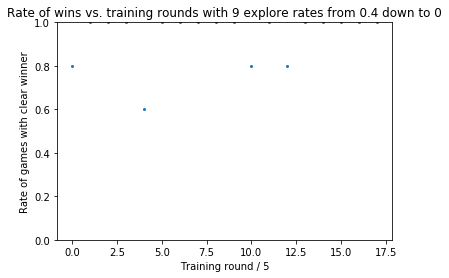

In [29]:
p1, p2 = makedynamic(10, 9, 0.4, movingalpha = True, aggover=5)

In [30]:
human = HumanPlayer("human")
p1 = player("computer", explore_rate=0)
p1.states_values = keras.models.load_model('models/dynamic1')
game = tictactoe(p1, human)
game.playhuman()

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   |   |   | 
-----------------

[0, 1, 2]
2
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   |   | x | 
-----------------

[0, 1, 2]
Input your action col:1
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   | o | x | 
-----------------

[0, 1, 2]
2
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   | x | 
-----------------
2  |   | o | x | 
-----------------

[0, 1, 2]
Input your action col:2
   | 0 | 1 | 2 |
-----------------
0  |   |   | o | 
-----------------
1  |   |   | x | 
-----------------
2  |   | o | x | 
-----------------

[0, 1]
0
   | 0 | 1 | 2 |
-----------------
0  |   |   | o | 
-----------------
1  |   |   | x | 
-----------------
2  | x | o | x | 
-----------------

[0, 1]
Input your action col:1
   |

-1

In [31]:
human = HumanPlayer("human")
p2 = player("computer", explore_rate=0)
p2.states_values = keras.models.load_model('models/dynamic2')
game = tictactoe(human, p2)
game.playhuman()

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   |   |   | 
-----------------

[0, 1, 2]
Input your action col:2
2
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   |   | x | 
-----------------

[0, 1, 2]
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  | o |   | x | 
-----------------

[0, 1, 2]
Input your action col:1
1
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  | o | x | x | 
-----------------

[0, 1, 2]
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  | o |   |   | 
-----------------
2  | o | x | x | 
-----------------

[0, 1, 2]
Input your action col:0
0
   | 0 | 1 | 2 |
-----------------
0  | x |   |   | 
-----------------
1  | o |   |   | 
-----------------
2  | o | x | x | 
-----------------

[1, 2]
 

1

In [38]:
human = HumanPlayer("human")
p2 = player("computer", explore_rate=0)
p2.states_values = keras.models.load_model('models/dynamic2')
game = tictactoe(human, p2)
game.playhuman()

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   |   |   | 
-----------------

[0, 1, 2]
Input your action col:1
1
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   | x |   | 
-----------------

[0, 1, 2]
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   | x | o | 
-----------------

[0, 1, 2]
Input your action col:1
1
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   | x |   | 
-----------------
2  |   | x | o | 
-----------------

[0, 1, 2]
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   | x | o | 
-----------------
2  |   | x | o | 
-----------------

[0, 1, 2]
Input your action col:1
1
   | 0 | 1 | 2 |
-----------------
0  |   | x |   | 
-----------------
1  |   | x | o | 
-----------------
2  |   | x | o | 
-----------------

human wi

1

Does ok! Way better than the same network does for regular tic tac toe, at least. I think having a way smaller output layer for the same amount of data actually helps with precision a lot.

Let's try a bit longer training (same thing as we did for no gravity, same number of epochs and same number of games per epoch) and see what happens.

0.01
training for explore rate 0.5 and alpha 0.5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.85s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.49 and alpha 0.49


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.37s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.48 and alpha 0.48


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.28s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.47 and alpha 0.47


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.95s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.46 and alpha 0.46


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.27s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.45 and alpha 0.45


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.64s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.44 and alpha 0.44


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.12s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.43 and alpha 0.43


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.90s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.42 and alpha 0.42


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.46s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.41 and alpha 0.41


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:17<00:00,  7.79s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.4 and alpha 0.4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:19<00:00,  7.97s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.39 and alpha 0.39


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.88s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.38 and alpha 0.38


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.96s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.37 and alpha 0.37


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.16s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.36 and alpha 0.36


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.98s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.35 and alpha 0.35


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:01<00:00,  6.12s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.34 and alpha 0.34


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.88s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.33 and alpha 0.33


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.74s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.32 and alpha 0.32


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.79s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.31 and alpha 0.31


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.76s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.3 and alpha 0.3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.29s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.29 and alpha 0.29


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.15s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.28 and alpha 0.28


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.75s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.27 and alpha 0.27


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.40s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.26 and alpha 0.26


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.80s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.25 and alpha 0.25


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.41s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.24 and alpha 0.24


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.08s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.23 and alpha 0.23


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.61s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.22 and alpha 0.22


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.40s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.21 and alpha 0.21


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.58s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.2 and alpha 0.2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.96s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.19 and alpha 0.19


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.64s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.18 and alpha 0.18


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.91s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.17 and alpha 0.17


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.67s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.16 and alpha 0.16


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.97s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.15 and alpha 0.15


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.62s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.14 and alpha 0.14


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.37s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.13 and alpha 0.13


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.47s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.12 and alpha 0.12


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.96s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.11 and alpha 0.11


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.02s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.1 and alpha 0.1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.78s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.09 and alpha 0.09


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.87s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.08 and alpha 0.08


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.61s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.07 and alpha 0.07


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.69s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.06 and alpha 0.06


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.18s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.05 and alpha 0.05


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.15s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.04 and alpha 0.04


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.10s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.03 and alpha 0.03


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.73s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.02 and alpha 0.02


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.82s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.01 and alpha 0.01


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.77s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.0 and alpha 0.01


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.79s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets


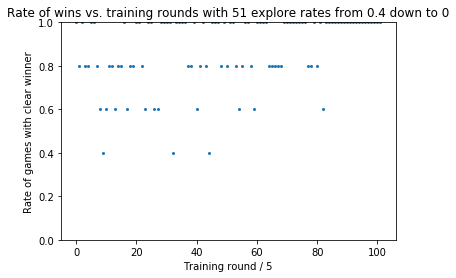

In [35]:
p1long, p2long = makedynamic(10, 51, 0.5, movingalpha = True, stratnames='dynamic', aggover=5)

In [36]:
human = HumanPlayer("human")
# p1.loadPolicy("policy_p1")
game = tictactoe(p1long, human)
game.playhuman()

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   |   |   | 
-----------------

[0, 1, 2]
2
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   |   | x | 
-----------------

[0, 1, 2]
Input your action col:1
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   | o | x | 
-----------------

[0, 1, 2]
2
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   | x | 
-----------------
2  |   | o | x | 
-----------------

[0, 1, 2]
Input your action col:2
   | 0 | 1 | 2 |
-----------------
0  |   |   | o | 
-----------------
1  |   |   | x | 
-----------------
2  |   | o | x | 
-----------------

[0, 1]
0
   | 0 | 1 | 2 |
-----------------
0  |   |   | o | 
-----------------
1  |   |   | x | 
-----------------
2  | x | o | x | 
-----------------

[0, 1]
Input your action col:1
   |

-1

In [37]:
human = HumanPlayer("human")
# p1.loadPolicy("policy_p1")
game = tictactoe(human, p2long)
game.playhuman()

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   |   |   | 
-----------------

[0, 1, 2]
Input your action col:1
1
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   | x |   | 
-----------------

[0, 1, 2]
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   | x | o | 
-----------------

[0, 1, 2]
Input your action col:1
1
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   | x |   | 
-----------------
2  |   | x | o | 
-----------------

[0, 1, 2]
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   | x | o | 
-----------------
2  |   | x | o | 
-----------------

[0, 1, 2]
Input your action col:1
1
   | 0 | 1 | 2 |
-----------------
0  |   | x |   | 
-----------------
1  |   | x | o | 
-----------------
2  |   | x | o | 
-----------------

human wi

1

It actually plays exactly the same as the longer train time does... I think we don't have enough features.

New architecture, now with one layer of 3 3x3 filters and no second layer of filters. Also add another FC layer.

0.05
training for explore rate 0.4 and alpha 0.4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.80s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.35 and alpha 0.35


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.07s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.3 and alpha 0.3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.51s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.25 and alpha 0.25


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.28s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.2 and alpha 0.2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.72s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.15 and alpha 0.15


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.06s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.1 and alpha 0.1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.52s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.05 and alpha 0.05


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.23s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.0 and alpha 0.01


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.31s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets


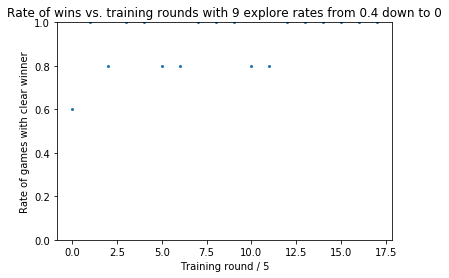

In [43]:
p1, p2 = makedynamic(10, 9, 0.4, movingalpha = True, aggover=5, numfilters=3, filtersize=3)

In [45]:
human = HumanPlayer("human")
game = tictactoe(p1, human)
game.playhuman()

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   |   |   | 
-----------------

[0, 1, 2]
0
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  | x |   |   | 
-----------------

[0, 1, 2]
Input your action col:2
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  | x |   | o | 
-----------------

[0, 1, 2]
0
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  | x |   |   | 
-----------------
2  | x |   | o | 
-----------------

[0, 1, 2]
Input your action col:0
   | 0 | 1 | 2 |
-----------------
0  | o |   |   | 
-----------------
1  | x |   |   | 
-----------------
2  | x |   | o | 
-----------------

[1, 2]
2
   | 0 | 1 | 2 |
-----------------
0  | o |   |   | 
-----------------
1  | x |   | x | 
-----------------
2  | x |   | o | 
-----------------

[1, 2]
Input your action col:1
   |

-1

Below are the results from using one filter of size 6 and one filter of size 4.

0.01
training for explore rate 0.5 and alpha 0.5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.78s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.49 and alpha 0.49


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.97s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.48 and alpha 0.48


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:06<00:00,  6.65s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.47 and alpha 0.47


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.25s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.46 and alpha 0.46


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.75s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.45 and alpha 0.45


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.24s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.44 and alpha 0.44


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.55s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.43 and alpha 0.43


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.12s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.42 and alpha 0.42


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.49s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.41 and alpha 0.41


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.68s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.4 and alpha 0.4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.49s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.39 and alpha 0.39


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.94s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.38 and alpha 0.38


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:07<00:00,  6.71s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.37 and alpha 0.37


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:01<00:00,  6.10s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.36 and alpha 0.36


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.68s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.35 and alpha 0.35


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.02s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.34 and alpha 0.34


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.22s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.33 and alpha 0.33


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.34s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.32 and alpha 0.32


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.70s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.31 and alpha 0.31


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.67s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.3 and alpha 0.3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:01<00:00,  6.14s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.29 and alpha 0.29


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.45s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.28 and alpha 0.28


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.85s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.27 and alpha 0.27


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.82s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.26 and alpha 0.26


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.08s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.25 and alpha 0.25


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.08s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.24 and alpha 0.24


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.24s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.23 and alpha 0.23


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.16s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.22 and alpha 0.22


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.55s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.21 and alpha 0.21


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.26s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.2 and alpha 0.2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.20s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.19 and alpha 0.19


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.31s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.18 and alpha 0.18


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:03<00:00,  6.33s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.17 and alpha 0.17


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.90s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.16 and alpha 0.16


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.70s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.15 and alpha 0.15


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.94s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.14 and alpha 0.14


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.02s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.13 and alpha 0.13


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.32s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.12 and alpha 0.12


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.83s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.11 and alpha 0.11


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.60s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.1 and alpha 0.1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.56s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.09 and alpha 0.09


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.89s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.08 and alpha 0.08


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.13s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.07 and alpha 0.07


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.05s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.06 and alpha 0.06


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.58s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.05 and alpha 0.05


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.78s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.04 and alpha 0.04


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.27s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.03 and alpha 0.03


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:51<00:00,  5.12s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.02 and alpha 0.02


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.10s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.01 and alpha 0.01


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.80s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets
training for explore rate 0.0 and alpha 0.01


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.62s/it]


INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets


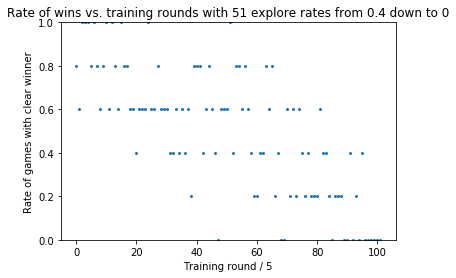

In [46]:
p1long, p2long = makedynamic(10, 51, 0.5, movingalpha = True, stratnames='dynamic', aggover=5, numfilters=3, filtersize=3)

In [9]:
human = HumanPlayer("human")
p1 = player("computer", explore_rate=0)
p1.states_values = keras.models.load_model('models/dynamic1')
game = tictactoe(p1, human)
game.playhuman()

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   |   |   | 
-----------------

[0, 1, 2]
1
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   | x |   | 
-----------------

[0, 1, 2]
Input your action col:1
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   | o |   | 
-----------------
2  |   | x |   | 
-----------------

[0, 1, 2]
1
   | 0 | 1 | 2 |
-----------------
0  |   | x |   | 
-----------------
1  |   | o |   | 
-----------------
2  |   | x |   | 
-----------------

[0, 2]
Input your action col:2
   | 0 | 1 | 2 |
-----------------
0  |   | x |   | 
-----------------
1  |   | o |   | 
-----------------
2  |   | x | o | 
-----------------

[0, 2]
2
   | 0 | 1 | 2 |
-----------------
0  |   | x |   | 
-----------------
1  |   | o | x | 
-----------------
2  |   | x | o | 
-----------------

[0, 2]
Input your action col:0
   | 0 

1

Now make each FC layer equal to board size and add another filter to convolutional layer for total of 4 filters. Also try a bit more training like what worked below.

### Graphs with update size start here

0.005





  0%|                                                                                          | 0/101 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





  1%|▊                                                                                 | 1/101 [00:16<28:17, 16.97s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





  2%|█▌                                                                                | 2/101 [00:34<28:07, 17.05s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





  3%|██▍                                                                               | 3/101 [00:53<29:01, 17.77s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





  4%|███▏                                                                              | 4/101 [01:10<28:21, 17.54s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





  5%|████                                                                              | 5/101 [01:27<27:52, 17.42s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





  6%|████▊                                                                             | 6/101 [01:50<29:51, 18.86s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





  7%|█████▋                                                                            | 7/101 [02:11<30:35, 19.52s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





  8%|██████▍                                                                           | 8/101 [02:30<30:09, 19.46s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





  9%|███████▎                                                                          | 9/101 [02:51<30:43, 20.04s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 10%|████████                                                                         | 10/101 [03:14<31:48, 20.97s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 11%|████████▊                                                                        | 11/101 [03:36<31:53, 21.26s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 12%|█████████▌                                                                       | 12/101 [03:59<32:18, 21.78s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 13%|██████████▍                                                                      | 13/101 [04:22<32:30, 22.16s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 14%|███████████▏                                                                     | 14/101 [04:43<31:22, 21.64s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 15%|████████████                                                                     | 15/101 [05:01<29:26, 20.54s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 16%|████████████▊                                                                    | 16/101 [05:20<28:23, 20.04s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 17%|█████████████▋                                                                   | 17/101 [05:40<28:00, 20.00s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 18%|██████████████▍                                                                  | 18/101 [05:56<26:10, 18.93s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 19%|███████████████▏                                                                 | 19/101 [06:12<24:33, 17.97s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 20%|████████████████                                                                 | 20/101 [06:33<25:27, 18.86s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 21%|████████████████▊                                                                | 21/101 [06:52<25:21, 19.02s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 22%|█████████████████▋                                                               | 22/101 [07:15<26:24, 20.05s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 23%|██████████████████▍                                                              | 23/101 [07:32<25:04, 19.29s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 24%|███████████████████▏                                                             | 24/101 [07:54<25:56, 20.21s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 25%|████████████████████                                                             | 25/101 [08:12<24:36, 19.43s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 26%|████████████████████▊                                                            | 26/101 [08:30<23:40, 18.95s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 27%|█████████████████████▋                                                           | 27/101 [08:52<24:31, 19.89s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 28%|██████████████████████▍                                                          | 28/101 [09:14<24:56, 20.50s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 29%|███████████████████████▎                                                         | 29/101 [09:31<23:23, 19.49s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 30%|████████████████████████                                                         | 30/101 [09:52<23:26, 19.81s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 31%|████████████████████████▊                                                        | 31/101 [10:08<21:56, 18.81s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 32%|█████████████████████████▋                                                       | 32/101 [10:28<22:10, 19.29s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 33%|██████████████████████████▍                                                      | 33/101 [10:47<21:27, 18.93s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 34%|███████████████████████████▎                                                     | 34/101 [11:09<22:17, 19.97s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 35%|████████████████████████████                                                     | 35/101 [11:35<23:55, 21.75s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 36%|████████████████████████████▊                                                    | 36/101 [11:55<23:02, 21.27s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 37%|█████████████████████████████▋                                                   | 37/101 [12:13<21:46, 20.42s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 38%|██████████████████████████████▍                                                  | 38/101 [12:38<22:43, 21.64s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 39%|███████████████████████████████▎                                                 | 39/101 [13:01<22:52, 22.13s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 40%|████████████████████████████████                                                 | 40/101 [13:19<21:08, 20.79s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 41%|████████████████████████████████▉                                                | 41/101 [13:35<19:22, 19.37s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 42%|█████████████████████████████████▋                                               | 42/101 [13:55<19:07, 19.45s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 43%|██████████████████████████████████▍                                              | 43/101 [14:15<19:13, 19.88s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 44%|███████████████████████████████████▎                                             | 44/101 [14:34<18:36, 19.59s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 45%|████████████████████████████████████                                             | 45/101 [14:57<19:01, 20.38s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 46%|████████████████████████████████████▉                                            | 46/101 [15:13<17:43, 19.33s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 47%|█████████████████████████████████████▋                                           | 47/101 [15:32<17:14, 19.16s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 48%|██████████████████████████████████████▍                                          | 48/101 [15:50<16:30, 18.68s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 49%|███████████████████████████████████████▎                                         | 49/101 [16:09<16:21, 18.88s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 50%|████████████████████████████████████████                                         | 50/101 [16:28<16:04, 18.91s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 50%|████████████████████████████████████████▉                                        | 51/101 [16:49<16:18, 19.58s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 51%|█████████████████████████████████████████▋                                       | 52/101 [17:09<16:08, 19.76s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 52%|██████████████████████████████████████████▌                                      | 53/101 [17:29<15:53, 19.86s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 53%|███████████████████████████████████████████▎                                     | 54/101 [17:49<15:27, 19.73s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 54%|████████████████████████████████████████████                                     | 55/101 [18:13<16:06, 21.01s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 55%|████████████████████████████████████████████▉                                    | 56/101 [18:33<15:32, 20.73s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 56%|█████████████████████████████████████████████▋                                   | 57/101 [18:53<14:58, 20.41s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 57%|██████████████████████████████████████████████▌                                  | 58/101 [19:11<14:06, 19.69s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 58%|███████████████████████████████████████████████▎                                 | 59/101 [19:33<14:19, 20.47s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 59%|████████████████████████████████████████████████                                 | 60/101 [19:52<13:36, 19.91s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 60%|████████████████████████████████████████████████▉                                | 61/101 [20:08<12:36, 18.92s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 61%|█████████████████████████████████████████████████▋                               | 62/101 [20:26<12:01, 18.50s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 62%|██████████████████████████████████████████████████▌                              | 63/101 [20:45<11:46, 18.59s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 63%|███████████████████████████████████████████████████▎                             | 64/101 [21:00<10:58, 17.79s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 64%|████████████████████████████████████████████████████▏                            | 65/101 [21:20<11:02, 18.40s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 65%|████████████████████████████████████████████████████▉                            | 66/101 [21:39<10:52, 18.65s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 66%|█████████████████████████████████████████████████████▋                           | 67/101 [21:56<10:12, 18.03s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 67%|██████████████████████████████████████████████████████▌                          | 68/101 [22:14<09:53, 18.00s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 68%|███████████████████████████████████████████████████████▎                         | 69/101 [22:41<10:58, 20.58s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 69%|████████████████████████████████████████████████████████▏                        | 70/101 [23:02<10:47, 20.88s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 70%|████████████████████████████████████████████████████████▉                        | 71/101 [23:24<10:38, 21.27s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 71%|█████████████████████████████████████████████████████████▋                       | 72/101 [23:47<10:27, 21.65s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 72%|██████████████████████████████████████████████████████████▌                      | 73/101 [24:06<09:46, 20.96s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 73%|███████████████████████████████████████████████████████████▎                     | 74/101 [24:27<09:22, 20.83s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 74%|████████████████████████████████████████████████████████████▏                    | 75/101 [24:45<08:45, 20.20s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [25:03<08:04, 19.39s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 76%|█████████████████████████████████████████████████████████████▊                   | 77/101 [25:23<07:51, 19.65s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 77%|██████████████████████████████████████████████████████████████▌                  | 78/101 [25:40<07:12, 18.81s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 78%|███████████████████████████████████████████████████████████████▎                 | 79/101 [25:56<06:36, 18.01s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 79%|████████████████████████████████████████████████████████████████▏                | 80/101 [26:14<06:13, 17.80s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 80%|████████████████████████████████████████████████████████████████▉                | 81/101 [26:35<06:18, 18.94s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 81%|█████████████████████████████████████████████████████████████████▊               | 82/101 [26:53<05:54, 18.68s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 82%|██████████████████████████████████████████████████████████████████▌              | 83/101 [27:11<05:28, 18.26s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 83%|███████████████████████████████████████████████████████████████████▎             | 84/101 [27:29<05:10, 18.27s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 84%|████████████████████████████████████████████████████████████████████▏            | 85/101 [27:48<04:58, 18.65s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 85%|████████████████████████████████████████████████████████████████████▉            | 86/101 [28:08<04:45, 19.01s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 86%|█████████████████████████████████████████████████████████████████████▊           | 87/101 [28:26<04:19, 18.55s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 87%|██████████████████████████████████████████████████████████████████████▌          | 88/101 [28:44<03:58, 18.37s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 88%|███████████████████████████████████████████████████████████████████████▍         | 89/101 [29:02<03:41, 18.47s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 89%|████████████████████████████████████████████████████████████████████████▏        | 90/101 [29:22<03:28, 18.97s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 90%|████████████████████████████████████████████████████████████████████████▉        | 91/101 [29:45<03:19, 19.95s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 91%|█████████████████████████████████████████████████████████████████████████▊       | 92/101 [30:13<03:22, 22.53s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 92%|██████████████████████████████████████████████████████████████████████████▌      | 93/101 [30:32<02:52, 21.54s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 93%|███████████████████████████████████████████████████████████████████████████▍     | 94/101 [30:52<02:26, 20.97s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 94%|████████████████████████████████████████████████████████████████████████████▏    | 95/101 [31:12<02:03, 20.51s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 95%|████████████████████████████████████████████████████████████████████████████▉    | 96/101 [31:34<01:45, 21.04s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 96%|█████████████████████████████████████████████████████████████████████████████▊   | 97/101 [31:52<01:21, 20.32s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 97%|██████████████████████████████████████████████████████████████████████████████▌  | 98/101 [32:11<00:58, 19.63s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 98%|███████████████████████████████████████████████████████████████████████████████▍ | 99/101 [32:28<00:38, 19.14s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





 99%|███████████████████████████████████████████████████████████████████████████████▏| 100/101 [32:46<00:18, 18.52s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets





100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [33:02<00:00, 19.63s/it]


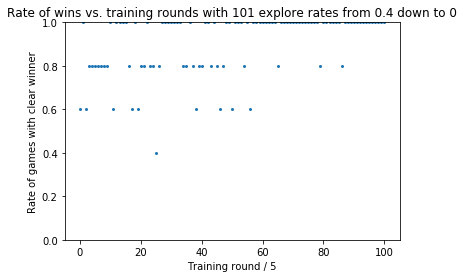

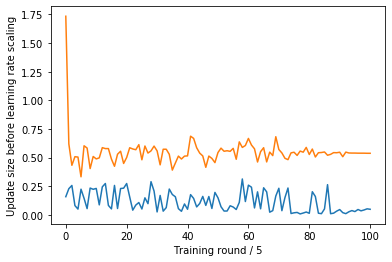

In [22]:
p1short, p2short = makedynamic(5, 101, 0.5, movingalpha = True, stratnames='dynamic', aggover=5, numfilters=4, filtersize=3)

In [23]:
human = HumanPlayer("human")
game = tictactoe(p1short, human)
game.playhuman()

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   |   |   | 
-----------------

[0, 1, 2]
0
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  | x |   |   | 
-----------------

[0, 1, 2]
Input your action col:1
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  | x | o |   | 
-----------------

[0, 1, 2]
0
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  | x |   |   | 
-----------------
2  | x | o |   | 
-----------------

[0, 1, 2]
Input your action col:0
   | 0 | 1 | 2 |
-----------------
0  | o |   |   | 
-----------------
1  | x |   |   | 
-----------------
2  | x | o |   | 
-----------------

[1, 2]
2
   | 0 | 1 | 2 |
-----------------
0  | o |   |   | 
-----------------
1  | x |   |   | 
-----------------
2  | x | o | x | 
-----------------

[1, 2]
Input your action col:1
   |

-1

0.0025




  0%|                                                                                          | 0/201 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  0%|▍                                                                                 | 1/201 [00:17<59:27, 17.84s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  1%|▊                                                                               | 2/201 [00:36<1:00:13, 18.16s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  1%|█▏                                                                                | 3/201 [00:53<58:29, 17.72s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  2%|█▌                                                                              | 4/201 [01:13<1:00:54, 18.55s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  2%|█▉                                                                              | 5/201 [01:35<1:03:12, 19.35s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  3%|██▍                                                                             | 6/201 [01:59<1:07:39, 20.82s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  3%|██▊                                                                             | 7/201 [02:26<1:13:32, 22.74s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  4%|███▏                                                                            | 8/201 [02:53<1:17:04, 23.96s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  4%|███▌                                                                            | 9/201 [03:18<1:17:33, 24.24s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  5%|███▉                                                                           | 10/201 [03:43<1:17:36, 24.38s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  5%|████▎                                                                          | 11/201 [04:12<1:21:43, 25.81s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  6%|████▋                                                                          | 12/201 [04:40<1:23:21, 26.47s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  6%|█████                                                                          | 13/201 [05:06<1:23:10, 26.55s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  7%|█████▌                                                                         | 14/201 [05:35<1:24:55, 27.25s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  7%|█████▉                                                                         | 15/201 [06:16<1:36:56, 31.27s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  8%|██████▎                                                                        | 16/201 [06:43<1:32:23, 29.97s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  8%|██████▋                                                                        | 17/201 [07:08<1:27:53, 28.66s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  9%|███████                                                                        | 18/201 [07:32<1:22:55, 27.19s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




  9%|███████▍                                                                       | 19/201 [07:58<1:20:54, 26.67s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 10%|███████▊                                                                       | 20/201 [08:21<1:17:21, 25.65s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 10%|████████▎                                                                      | 21/201 [08:43<1:13:33, 24.52s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 11%|████████▋                                                                      | 22/201 [09:03<1:08:53, 23.09s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 11%|█████████                                                                      | 23/201 [09:20<1:03:01, 21.24s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 12%|█████████▍                                                                     | 24/201 [09:46<1:07:25, 22.86s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 12%|█████████▊                                                                     | 25/201 [10:11<1:08:41, 23.42s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 13%|██████████▏                                                                    | 26/201 [10:34<1:08:26, 23.46s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 13%|██████████▌                                                                    | 27/201 [10:55<1:05:51, 22.71s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 14%|███████████                                                                    | 28/201 [11:16<1:03:45, 22.12s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 14%|███████████▍                                                                   | 29/201 [11:37<1:02:15, 21.72s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 15%|████████████                                                                     | 30/201 [11:55<58:53, 20.66s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 15%|████████████▍                                                                    | 31/201 [12:17<59:41, 21.07s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 16%|████████████▉                                                                    | 32/201 [12:35<56:16, 19.98s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 16%|█████████████▎                                                                   | 33/201 [12:57<57:51, 20.67s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 17%|█████████████▋                                                                   | 34/201 [13:13<53:44, 19.31s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 17%|██████████████                                                                   | 35/201 [13:31<52:01, 18.80s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 18%|██████████████▌                                                                  | 36/201 [13:53<55:00, 20.01s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 18%|██████████████▉                                                                  | 37/201 [14:15<55:37, 20.35s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 19%|███████████████▎                                                                 | 38/201 [14:33<54:03, 19.90s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 19%|███████████████▋                                                                 | 39/201 [14:51<52:14, 19.35s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 20%|████████████████                                                                 | 40/201 [15:08<49:48, 18.56s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 20%|████████████████▌                                                                | 41/201 [15:37<57:52, 21.70s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 21%|████████████████▌                                                              | 42/201 [16:03<1:00:51, 22.96s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 21%|████████████████▉                                                              | 43/201 [16:28<1:02:05, 23.58s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 22%|█████████████████▎                                                             | 44/201 [17:01<1:09:03, 26.39s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 22%|█████████████████▋                                                             | 45/201 [17:26<1:07:23, 25.92s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 23%|██████████████████                                                             | 46/201 [17:51<1:06:19, 25.68s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 23%|██████████████████▍                                                            | 47/201 [18:12<1:02:17, 24.27s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 24%|███████████████████▎                                                             | 48/201 [18:34<59:53, 23.49s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 24%|███████████████████▋                                                             | 49/201 [18:55<57:27, 22.68s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 25%|████████████████████▏                                                            | 50/201 [19:15<55:31, 22.06s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 25%|████████████████████▌                                                            | 51/201 [19:34<52:58, 21.19s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 26%|████████████████████▉                                                            | 52/201 [19:57<53:54, 21.71s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 26%|█████████████████████▎                                                           | 53/201 [20:16<51:26, 20.86s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 27%|█████████████████████▊                                                           | 54/201 [20:37<51:20, 20.95s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 27%|██████████████████████▏                                                          | 55/201 [21:00<52:02, 21.39s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 28%|██████████████████████▌                                                          | 56/201 [21:24<53:38, 22.20s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 28%|██████████████████████▉                                                          | 57/201 [21:48<55:03, 22.94s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 29%|███████████████████████▎                                                         | 58/201 [22:10<53:48, 22.58s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 29%|███████████████████████▊                                                         | 59/201 [22:37<56:32, 23.89s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 30%|████████████████████████▏                                                        | 60/201 [22:59<54:34, 23.22s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 30%|████████████████████████▌                                                        | 61/201 [23:20<52:31, 22.51s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 31%|████████████████████████▉                                                        | 62/201 [23:35<47:24, 20.46s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 31%|█████████████████████████▍                                                       | 63/201 [23:56<47:17, 20.56s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 32%|█████████████████████████▊                                                       | 64/201 [24:24<51:50, 22.70s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 32%|██████████████████████████▏                                                      | 65/201 [24:48<52:30, 23.17s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 33%|██████████████████████████▌                                                      | 66/201 [25:07<49:17, 21.91s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 33%|███████████████████████████                                                      | 67/201 [25:29<48:58, 21.93s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 34%|███████████████████████████▍                                                     | 68/201 [25:50<48:04, 21.69s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 34%|███████████████████████████▊                                                     | 69/201 [26:10<46:11, 21.00s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 35%|████████████████████████████▏                                                    | 70/201 [26:29<44:58, 20.60s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 35%|████████████████████████████▌                                                    | 71/201 [26:47<43:08, 19.91s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 36%|█████████████████████████████                                                    | 72/201 [27:07<42:25, 19.73s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 36%|█████████████████████████████▍                                                   | 73/201 [27:26<41:31, 19.46s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 37%|█████████████████████████████▊                                                   | 74/201 [27:47<42:22, 20.02s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 37%|██████████████████████████████▏                                                  | 75/201 [28:09<43:10, 20.56s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 38%|██████████████████████████████▋                                                  | 76/201 [28:26<41:01, 19.69s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 38%|███████████████████████████████                                                  | 77/201 [28:47<41:23, 20.03s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 39%|███████████████████████████████▍                                                 | 78/201 [29:06<40:14, 19.63s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 39%|███████████████████████████████▊                                                 | 79/201 [29:28<41:22, 20.35s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 40%|████████████████████████████████▏                                                | 80/201 [29:51<42:49, 21.23s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 40%|████████████████████████████████▋                                                | 81/201 [30:10<40:46, 20.39s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 41%|█████████████████████████████████                                                | 82/201 [30:29<39:40, 20.00s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 41%|█████████████████████████████████▍                                               | 83/201 [30:54<42:41, 21.71s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 42%|█████████████████████████████████▊                                               | 84/201 [31:22<45:40, 23.43s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 42%|██████████████████████████████████▎                                              | 85/201 [31:45<44:56, 23.25s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 43%|██████████████████████████████████▋                                              | 86/201 [32:06<43:10, 22.53s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 43%|███████████████████████████████████                                              | 87/201 [32:28<42:36, 22.42s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 44%|███████████████████████████████████▍                                             | 88/201 [32:53<43:55, 23.32s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 44%|███████████████████████████████████▊                                             | 89/201 [33:16<43:02, 23.05s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 45%|████████████████████████████████████▎                                            | 90/201 [33:38<42:21, 22.89s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 45%|████████████████████████████████████▋                                            | 91/201 [33:57<39:45, 21.69s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 46%|█████████████████████████████████████                                            | 92/201 [34:19<39:38, 21.82s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 46%|█████████████████████████████████████▍                                           | 93/201 [34:39<38:09, 21.20s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 47%|█████████████████████████████████████▉                                           | 94/201 [34:58<36:39, 20.56s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 47%|██████████████████████████████████████▎                                          | 95/201 [35:16<35:06, 19.88s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 48%|██████████████████████████████████████▋                                          | 96/201 [35:35<34:18, 19.60s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 48%|███████████████████████████████████████                                          | 97/201 [35:57<34:53, 20.13s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 49%|███████████████████████████████████████▍                                         | 98/201 [36:19<35:34, 20.72s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 49%|███████████████████████████████████████▉                                         | 99/201 [36:40<35:19, 20.77s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 50%|███████████████████████████████████████▊                                        | 100/201 [37:01<35:22, 21.02s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 50%|████████████████████████████████████████▏                                       | 101/201 [37:19<33:24, 20.04s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 51%|████████████████████████████████████████▌                                       | 102/201 [37:42<34:40, 21.02s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 51%|████████████████████████████████████████▉                                       | 103/201 [38:04<34:48, 21.31s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 52%|█████████████████████████████████████████▍                                      | 104/201 [38:27<35:04, 21.69s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 52%|█████████████████████████████████████████▊                                      | 105/201 [38:51<35:48, 22.38s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 53%|██████████████████████████████████████████▏                                     | 106/201 [39:14<35:50, 22.63s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 53%|██████████████████████████████████████████▌                                     | 107/201 [39:38<36:19, 23.18s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 54%|██████████████████████████████████████████▉                                     | 108/201 [39:59<34:47, 22.44s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 54%|███████████████████████████████████████████▍                                    | 109/201 [40:18<32:40, 21.31s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 55%|███████████████████████████████████████████▊                                    | 110/201 [40:37<31:31, 20.78s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 55%|████████████████████████████████████████████▏                                   | 111/201 [40:58<31:03, 20.70s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 56%|████████████████████████████████████████████▌                                   | 112/201 [41:25<33:43, 22.73s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 56%|████████████████████████████████████████████▉                                   | 113/201 [41:52<35:03, 23.90s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 57%|█████████████████████████████████████████████▎                                  | 114/201 [42:13<33:28, 23.08s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 57%|█████████████████████████████████████████████▊                                  | 115/201 [42:37<33:22, 23.29s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 58%|██████████████████████████████████████████████▏                                 | 116/201 [42:59<32:22, 22.85s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 58%|██████████████████████████████████████████████▌                                 | 117/201 [43:22<32:09, 22.97s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 59%|██████████████████████████████████████████████▉                                 | 118/201 [43:43<30:54, 22.34s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 59%|███████████████████████████████████████████████▎                                | 119/201 [44:05<30:28, 22.29s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 60%|███████████████████████████████████████████████▊                                | 120/201 [44:31<31:26, 23.29s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 60%|████████████████████████████████████████████████▏                               | 121/201 [44:55<31:31, 23.65s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 61%|████████████████████████████████████████████████▌                               | 122/201 [45:15<29:45, 22.60s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 61%|████████████████████████████████████████████████▉                               | 123/201 [45:33<27:24, 21.08s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 62%|█████████████████████████████████████████████████▎                              | 124/201 [45:53<26:29, 20.64s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 62%|█████████████████████████████████████████████████▊                              | 125/201 [46:09<24:37, 19.45s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 63%|██████████████████████████████████████████████████▏                             | 126/201 [46:35<26:40, 21.34s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 63%|██████████████████████████████████████████████████▌                             | 127/201 [46:59<27:17, 22.13s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 64%|██████████████████████████████████████████████████▉                             | 128/201 [47:21<27:05, 22.26s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 64%|███████████████████████████████████████████████████▎                            | 129/201 [47:44<26:49, 22.35s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 65%|███████████████████████████████████████████████████▋                            | 130/201 [48:09<27:13, 23.00s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 65%|████████████████████████████████████████████████████▏                           | 131/201 [48:28<25:43, 22.05s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 66%|████████████████████████████████████████████████████▌                           | 132/201 [48:49<24:56, 21.69s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 66%|████████████████████████████████████████████████████▉                           | 133/201 [49:12<24:59, 22.04s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 67%|█████████████████████████████████████████████████████▎                          | 134/201 [49:39<26:12, 23.47s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 67%|█████████████████████████████████████████████████████▋                          | 135/201 [50:02<25:44, 23.41s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 68%|██████████████████████████████████████████████████████▏                         | 136/201 [50:22<24:07, 22.26s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 68%|██████████████████████████████████████████████████████▌                         | 137/201 [50:43<23:32, 22.06s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 69%|██████████████████████████████████████████████████████▉                         | 138/201 [51:06<23:14, 22.13s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 69%|███████████████████████████████████████████████████████▎                        | 139/201 [51:24<21:51, 21.15s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 70%|███████████████████████████████████████████████████████▋                        | 140/201 [51:43<20:48, 20.46s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 70%|████████████████████████████████████████████████████████                        | 141/201 [52:04<20:28, 20.48s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 71%|████████████████████████████████████████████████████████▌                       | 142/201 [52:27<20:53, 21.24s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 71%|████████████████████████████████████████████████████████▉                       | 143/201 [52:46<19:46, 20.46s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 72%|█████████████████████████████████████████████████████████▎                      | 144/201 [53:05<19:14, 20.26s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 72%|█████████████████████████████████████████████████████████▋                      | 145/201 [53:25<18:44, 20.08s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 73%|██████████████████████████████████████████████████████████                      | 146/201 [53:47<18:54, 20.62s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 73%|██████████████████████████████████████████████████████████▌                     | 147/201 [54:06<18:02, 20.04s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 74%|██████████████████████████████████████████████████████████▉                     | 148/201 [54:27<18:11, 20.59s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 74%|███████████████████████████████████████████████████████████▎                    | 149/201 [54:50<18:18, 21.12s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 75%|███████████████████████████████████████████████████████████▋                    | 150/201 [55:11<18:00, 21.19s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 75%|████████████████████████████████████████████████████████████                    | 151/201 [55:34<18:03, 21.68s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 76%|████████████████████████████████████████████████████████████▍                   | 152/201 [55:53<17:06, 20.96s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 76%|████████████████████████████████████████████████████████████▉                   | 153/201 [56:18<17:34, 21.97s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 77%|█████████████████████████████████████████████████████████████▎                  | 154/201 [56:37<16:42, 21.32s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 77%|█████████████████████████████████████████████████████████████▋                  | 155/201 [56:59<16:29, 21.50s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 78%|██████████████████████████████████████████████████████████████                  | 156/201 [57:16<15:08, 20.18s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 78%|██████████████████████████████████████████████████████████████▍                 | 157/201 [57:32<13:53, 18.95s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 79%|██████████████████████████████████████████████████████████████▉                 | 158/201 [57:51<13:30, 18.85s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 79%|███████████████████████████████████████████████████████████████▎                | 159/201 [58:10<13:13, 18.90s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 80%|███████████████████████████████████████████████████████████████▋                | 160/201 [58:27<12:35, 18.43s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 80%|████████████████████████████████████████████████████████████████                | 161/201 [58:48<12:46, 19.17s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 81%|████████████████████████████████████████████████████████████████▍               | 162/201 [59:07<12:15, 18.87s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 81%|████████████████████████████████████████████████████████████████▉               | 163/201 [59:26<12:04, 19.06s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 82%|█████████████████████████████████████████████████████████████████▎              | 164/201 [59:48<12:18, 19.97s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 82%|████████████████████████████████████████████████████████████████              | 165/201 [1:00:09<12:14, 20.39s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 83%|████████████████████████████████████████████████████████████████▍             | 166/201 [1:00:30<11:52, 20.34s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 83%|████████████████████████████████████████████████████████████████▊             | 167/201 [1:00:55<12:18, 21.73s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 84%|█████████████████████████████████████████████████████████████████▏            | 168/201 [1:01:16<11:55, 21.68s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 84%|█████████████████████████████████████████████████████████████████▌            | 169/201 [1:01:38<11:38, 21.84s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 85%|█████████████████████████████████████████████████████████████████▉            | 170/201 [1:02:01<11:25, 22.12s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 85%|██████████████████████████████████████████████████████████████████▎           | 171/201 [1:02:21<10:45, 21.53s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 86%|██████████████████████████████████████████████████████████████████▋           | 172/201 [1:02:44<10:31, 21.78s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 86%|███████████████████████████████████████████████████████████████████▏          | 173/201 [1:03:03<09:50, 21.10s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 87%|███████████████████████████████████████████████████████████████████▌          | 174/201 [1:03:22<09:12, 20.45s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 87%|███████████████████████████████████████████████████████████████████▉          | 175/201 [1:03:39<08:22, 19.33s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 88%|████████████████████████████████████████████████████████████████████▎         | 176/201 [1:03:57<07:53, 18.93s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 88%|████████████████████████████████████████████████████████████████████▋         | 177/201 [1:04:15<07:27, 18.65s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 89%|█████████████████████████████████████████████████████████████████████         | 178/201 [1:04:36<07:24, 19.32s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 89%|█████████████████████████████████████████████████████████████████████▍        | 179/201 [1:04:58<07:24, 20.22s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 90%|█████████████████████████████████████████████████████████████████████▊        | 180/201 [1:05:20<07:14, 20.68s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 90%|██████████████████████████████████████████████████████████████████████▏       | 181/201 [1:05:41<06:54, 20.74s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 91%|██████████████████████████████████████████████████████████████████████▋       | 182/201 [1:06:02<06:35, 20.84s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 91%|███████████████████████████████████████████████████████████████████████       | 183/201 [1:06:21<06:05, 20.30s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 92%|███████████████████████████████████████████████████████████████████████▍      | 184/201 [1:06:42<05:48, 20.50s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 92%|███████████████████████████████████████████████████████████████████████▊      | 185/201 [1:07:02<05:27, 20.44s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 93%|████████████████████████████████████████████████████████████████████████▏     | 186/201 [1:07:22<05:04, 20.27s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 93%|████████████████████████████████████████████████████████████████████████▌     | 187/201 [1:07:41<04:37, 19.82s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 94%|████████████████████████████████████████████████████████████████████████▉     | 188/201 [1:08:00<04:16, 19.72s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 94%|█████████████████████████████████████████████████████████████████████████▎    | 189/201 [1:08:20<03:55, 19.62s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 95%|█████████████████████████████████████████████████████████████████████████▋    | 190/201 [1:08:40<03:37, 19.74s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 95%|██████████████████████████████████████████████████████████████████████████    | 191/201 [1:08:58<03:13, 19.38s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 96%|██████████████████████████████████████████████████████████████████████████▌   | 192/201 [1:09:19<02:58, 19.79s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 96%|██████████████████████████████████████████████████████████████████████████▉   | 193/201 [1:09:45<02:52, 21.62s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 97%|███████████████████████████████████████████████████████████████████████████▎  | 194/201 [1:10:09<02:36, 22.37s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 97%|███████████████████████████████████████████████████████████████████████████▋  | 195/201 [1:10:30<02:12, 22.11s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 98%|████████████████████████████████████████████████████████████████████████████  | 196/201 [1:10:53<01:50, 22.16s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 98%|████████████████████████████████████████████████████████████████████████████▍ | 197/201 [1:11:14<01:27, 21.90s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 99%|████████████████████████████████████████████████████████████████████████████▊ | 198/201 [1:11:36<01:05, 21.88s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




 99%|█████████████████████████████████████████████████████████████████████████████▏| 199/201 [1:11:56<00:42, 21.50s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




100%|█████████████████████████████████████████████████████████████████████████████▌| 200/201 [1:12:17<00:21, 21.31s/it]

INFO:tensorflow:Assets written to: models/dynamic1\assets
INFO:tensorflow:Assets written to: models/dynamic2\assets




100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [1:12:38<00:00, 21.68s/it]


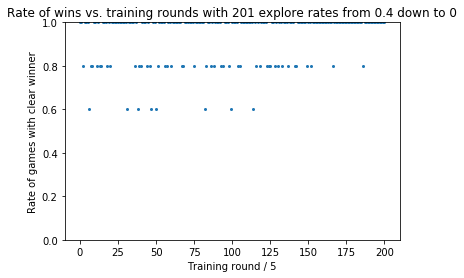

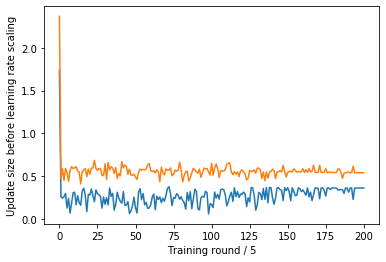

In [20]:
p1long, p2long = makedynamic(5, 201, 0.5, movingalpha = True, stratnames='dynamic', aggover=5, numfilters=4, filtersize=3)

In [25]:
human = HumanPlayer("human")
game = tictactoe(p1long, human)
game.playhuman()

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   |   |   | 
-----------------

[0, 1, 2]
1
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   | x |   | 
-----------------

[0, 1, 2]
Input your action col:1
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   | o |   | 
-----------------
2  |   | x |   | 
-----------------

[0, 1, 2]
1
   | 0 | 1 | 2 |
-----------------
0  |   | x |   | 
-----------------
1  |   | o |   | 
-----------------
2  |   | x |   | 
-----------------

[0, 2]
Input your action col:2
   | 0 | 1 | 2 |
-----------------
0  |   | x |   | 
-----------------
1  |   | o |   | 
-----------------
2  |   | x | o | 
-----------------

[0, 2]
0
   | 0 | 1 | 2 |
-----------------
0  |   | x |   | 
-----------------
1  |   | o |   | 
-----------------
2  | x | x | o | 
-----------------

[0, 2]
Input your action col:0
   | 0 

-1

# 3x4 CNN first test

Both moving alpha and moving exp rate. For 3x3 needed 10 times 51 with layers of 6 and 4, but here, since network architecture is actually the same (except for output layer, which is automatically taken care of by our board being longer and our action space being larger), will probably not need more training. 

Actually does need more training. Go to 5 times 201 instead. Use same architecture for now.

That architecture actually works really well! (2 hidden layers of board size, 4 filters).

0.0025





  0%|                                                                                          | 0/201 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  0%|▍                                                                                 | 1/201 [00:15<52:31, 15.76s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  1%|▊                                                                                 | 2/201 [00:36<57:12, 17.25s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  1%|█▏                                                                              | 3/201 [00:59<1:02:40, 18.99s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  2%|█▌                                                                              | 4/201 [01:37<1:21:19, 24.77s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  2%|█▉                                                                              | 5/201 [02:09<1:27:28, 26.78s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  3%|██▍                                                                             | 6/201 [02:43<1:34:46, 29.16s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  3%|██▊                                                                             | 7/201 [03:12<1:34:02, 29.08s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  4%|███▏                                                                            | 8/201 [03:37<1:29:00, 27.67s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  4%|███▌                                                                            | 9/201 [04:03<1:27:30, 27.35s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  5%|███▉                                                                           | 10/201 [04:26<1:22:29, 25.92s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  5%|████▎                                                                          | 11/201 [04:49<1:19:49, 25.21s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  6%|████▋                                                                          | 12/201 [05:11<1:16:05, 24.16s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  6%|█████                                                                          | 13/201 [05:40<1:20:00, 25.53s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  7%|█████▌                                                                         | 14/201 [06:10<1:23:38, 26.83s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  7%|█████▉                                                                         | 15/201 [06:37<1:23:44, 27.01s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  8%|██████▎                                                                        | 16/201 [06:59<1:18:19, 25.40s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  8%|██████▋                                                                        | 17/201 [07:23<1:17:05, 25.14s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  9%|███████                                                                        | 18/201 [07:47<1:15:14, 24.67s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





  9%|███████▍                                                                       | 19/201 [08:09<1:12:28, 23.89s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 10%|███████▊                                                                       | 20/201 [08:36<1:15:06, 24.90s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 10%|████████▎                                                                      | 21/201 [08:53<1:07:42, 22.57s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 11%|████████▋                                                                      | 22/201 [09:13<1:04:46, 21.71s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 11%|█████████                                                                      | 23/201 [09:31<1:01:21, 20.69s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 12%|█████████▍                                                                     | 24/201 [09:54<1:02:16, 21.11s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 12%|██████████                                                                       | 25/201 [10:12<59:53, 20.42s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 13%|██████████▏                                                                    | 26/201 [10:35<1:01:25, 21.06s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 13%|██████████▌                                                                    | 27/201 [11:01<1:05:27, 22.57s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 14%|███████████                                                                    | 28/201 [11:24<1:05:21, 22.67s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 14%|███████████▍                                                                   | 29/201 [11:48<1:06:22, 23.15s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 15%|███████████▊                                                                   | 30/201 [12:16<1:10:06, 24.60s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 15%|████████████▏                                                                  | 31/201 [12:44<1:12:42, 25.66s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 16%|████████████▌                                                                  | 32/201 [13:07<1:10:10, 24.91s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 16%|████████████▉                                                                  | 33/201 [13:34<1:10:52, 25.31s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 17%|█████████████▎                                                                 | 34/201 [14:01<1:12:03, 25.89s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 17%|█████████████▊                                                                 | 35/201 [14:30<1:13:52, 26.70s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 18%|██████████████▏                                                                | 36/201 [14:56<1:13:15, 26.64s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 18%|██████████████▌                                                                | 37/201 [15:19<1:09:33, 25.45s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 19%|██████████████▉                                                                | 38/201 [15:45<1:09:38, 25.63s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 19%|███████████████▎                                                               | 39/201 [16:12<1:10:28, 26.10s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 20%|███████████████▋                                                               | 40/201 [16:44<1:14:32, 27.78s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 20%|████████████████                                                               | 41/201 [17:10<1:12:53, 27.33s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 21%|████████████████▌                                                              | 42/201 [17:31<1:07:45, 25.57s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 21%|████████████████▉                                                              | 43/201 [17:53<1:04:10, 24.37s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 22%|█████████████████▎                                                             | 44/201 [18:13<1:00:33, 23.14s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 22%|██████████████████▏                                                              | 45/201 [18:29<54:39, 21.02s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 23%|██████████████████▌                                                              | 46/201 [18:49<52:57, 20.50s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 23%|██████████████████▉                                                              | 47/201 [19:09<52:31, 20.47s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 24%|███████████████████▎                                                             | 48/201 [19:38<58:58, 23.13s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 24%|███████████████████▋                                                             | 49/201 [20:02<58:46, 23.20s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 25%|███████████████████▋                                                           | 50/201 [20:31<1:02:55, 25.01s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 25%|████████████████████                                                           | 51/201 [20:56<1:02:43, 25.09s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 26%|████████████████████▍                                                          | 52/201 [21:24<1:03:57, 25.76s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 26%|█████████████████████▎                                                           | 53/201 [21:44<59:42, 24.20s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 27%|█████████████████████▏                                                         | 54/201 [22:12<1:02:13, 25.40s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 27%|█████████████████████▌                                                         | 55/201 [22:42<1:04:38, 26.57s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 28%|██████████████████████                                                         | 56/201 [23:14<1:08:46, 28.46s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 28%|██████████████████████▍                                                        | 57/201 [23:39<1:05:31, 27.30s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 29%|██████████████████████▊                                                        | 58/201 [24:05<1:04:07, 26.91s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 29%|███████████████████████▏                                                       | 59/201 [24:31<1:02:52, 26.57s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 30%|███████████████████████▌                                                       | 60/201 [24:56<1:01:25, 26.14s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 30%|████████████████████████▌                                                        | 61/201 [25:20<59:26, 25.48s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 31%|████████████████████████▉                                                        | 62/201 [25:44<58:03, 25.06s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 31%|█████████████████████████▍                                                       | 63/201 [26:08<56:51, 24.72s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 32%|█████████████████████████▊                                                       | 64/201 [26:31<55:08, 24.15s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 32%|██████████████████████████▏                                                      | 65/201 [26:54<54:03, 23.85s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 33%|██████████████████████████▌                                                      | 66/201 [27:16<52:30, 23.34s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 33%|███████████████████████████                                                      | 67/201 [27:39<52:09, 23.35s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 34%|███████████████████████████▍                                                     | 68/201 [28:09<56:01, 25.27s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 34%|███████████████████████████▊                                                     | 69/201 [28:28<51:38, 23.47s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 35%|████████████████████████████▏                                                    | 70/201 [28:57<54:33, 24.99s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 35%|████████████████████████████▌                                                    | 71/201 [29:25<55:53, 25.80s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 36%|█████████████████████████████                                                    | 72/201 [29:48<53:55, 25.08s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 36%|█████████████████████████████▍                                                   | 73/201 [30:14<54:14, 25.42s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 37%|█████████████████████████████▊                                                   | 74/201 [30:42<55:31, 26.23s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 37%|██████████████████████████████▏                                                  | 75/201 [31:06<53:38, 25.54s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 38%|██████████████████████████████▋                                                  | 76/201 [31:27<50:19, 24.16s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 38%|███████████████████████████████                                                  | 77/201 [31:52<50:26, 24.41s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 39%|███████████████████████████████▍                                                 | 78/201 [32:15<48:50, 23.82s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 39%|███████████████████████████████▊                                                 | 79/201 [32:36<46:36, 22.93s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 40%|████████████████████████████████▏                                                | 80/201 [33:05<50:26, 25.01s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 40%|████████████████████████████████▋                                                | 81/201 [33:29<48:54, 24.45s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 41%|█████████████████████████████████                                                | 82/201 [33:48<45:49, 23.10s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 41%|█████████████████████████████████▍                                               | 83/201 [34:14<46:48, 23.80s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 42%|█████████████████████████████████▊                                               | 84/201 [34:35<44:55, 23.03s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 42%|██████████████████████████████████▎                                              | 85/201 [35:03<47:11, 24.41s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 43%|██████████████████████████████████▋                                              | 86/201 [35:25<45:47, 23.89s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 43%|███████████████████████████████████                                              | 87/201 [35:50<45:49, 24.12s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 44%|███████████████████████████████████▍                                             | 88/201 [36:22<50:02, 26.57s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 44%|███████████████████████████████████▊                                             | 89/201 [36:47<48:16, 25.86s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 45%|████████████████████████████████████▎                                            | 90/201 [37:09<45:56, 24.83s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 45%|████████████████████████████████████▋                                            | 91/201 [37:32<44:45, 24.41s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 46%|█████████████████████████████████████                                            | 92/201 [37:55<43:12, 23.79s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 46%|█████████████████████████████████████▍                                           | 93/201 [38:20<43:49, 24.34s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 47%|█████████████████████████████████████▉                                           | 94/201 [38:45<43:22, 24.32s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 47%|██████████████████████████████████████▎                                          | 95/201 [39:06<41:15, 23.35s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 48%|██████████████████████████████████████▋                                          | 96/201 [39:29<40:44, 23.28s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 48%|███████████████████████████████████████                                          | 97/201 [39:54<41:08, 23.73s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 49%|███████████████████████████████████████▍                                         | 98/201 [40:15<39:24, 22.96s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 49%|███████████████████████████████████████▉                                         | 99/201 [40:36<37:51, 22.27s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 50%|███████████████████████████████████████▊                                        | 100/201 [41:03<40:13, 23.90s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 50%|████████████████████████████████████████▏                                       | 101/201 [41:22<37:11, 22.32s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 51%|████████████████████████████████████████▌                                       | 102/201 [41:44<36:37, 22.20s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 51%|████████████████████████████████████████▉                                       | 103/201 [42:11<38:32, 23.60s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 52%|█████████████████████████████████████████▍                                      | 104/201 [42:40<40:46, 25.22s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 52%|█████████████████████████████████████████▊                                      | 105/201 [43:06<41:01, 25.64s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 53%|██████████████████████████████████████████▏                                     | 106/201 [43:34<41:30, 26.22s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 53%|██████████████████████████████████████████▌                                     | 107/201 [44:01<41:17, 26.35s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 54%|██████████████████████████████████████████▉                                     | 108/201 [44:25<40:04, 25.86s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 54%|███████████████████████████████████████████▍                                    | 109/201 [44:47<37:42, 24.59s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 55%|███████████████████████████████████████████▊                                    | 110/201 [45:11<37:01, 24.41s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 55%|████████████████████████████████████████████▏                                   | 111/201 [45:33<35:48, 23.87s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 56%|████████████████████████████████████████████▌                                   | 112/201 [45:53<33:39, 22.69s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 56%|████████████████████████████████████████████▉                                   | 113/201 [46:17<33:39, 22.94s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 57%|█████████████████████████████████████████████▎                                  | 114/201 [46:35<31:19, 21.61s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 57%|█████████████████████████████████████████████▊                                  | 115/201 [46:58<31:18, 21.84s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 58%|██████████████████████████████████████████████▏                                 | 116/201 [47:19<30:35, 21.59s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 58%|██████████████████████████████████████████████▌                                 | 117/201 [47:47<32:51, 23.47s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 59%|██████████████████████████████████████████████▉                                 | 118/201 [48:06<30:47, 22.25s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 59%|███████████████████████████████████████████████▎                                | 119/201 [48:30<31:07, 22.77s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 60%|███████████████████████████████████████████████▊                                | 120/201 [48:51<30:12, 22.37s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 60%|████████████████████████████████████████████████▏                               | 121/201 [49:22<33:14, 24.93s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 61%|████████████████████████████████████████████████▌                               | 122/201 [49:46<32:14, 24.48s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 61%|████████████████████████████████████████████████▉                               | 123/201 [50:13<32:50, 25.26s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 62%|█████████████████████████████████████████████████▎                              | 124/201 [50:41<33:31, 26.13s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 62%|█████████████████████████████████████████████████▊                              | 125/201 [51:12<35:01, 27.64s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 63%|██████████████████████████████████████████████████▏                             | 126/201 [51:33<32:03, 25.65s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 63%|██████████████████████████████████████████████████▌                             | 127/201 [51:57<30:50, 25.00s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 64%|██████████████████████████████████████████████████▉                             | 128/201 [52:22<30:35, 25.15s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 64%|███████████████████████████████████████████████████▎                            | 129/201 [52:49<30:51, 25.72s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 65%|███████████████████████████████████████████████████▋                            | 130/201 [53:16<30:52, 26.09s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 65%|████████████████████████████████████████████████████▏                           | 131/201 [53:36<28:23, 24.34s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 66%|████████████████████████████████████████████████████▌                           | 132/201 [53:58<26:59, 23.47s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 66%|████████████████████████████████████████████████████▉                           | 133/201 [54:19<25:44, 22.72s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 67%|█████████████████████████████████████████████████████▎                          | 134/201 [54:41<25:02, 22.42s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 67%|█████████████████████████████████████████████████████▋                          | 135/201 [55:01<24:08, 21.94s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 68%|██████████████████████████████████████████████████████▏                         | 136/201 [55:22<23:18, 21.51s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 68%|██████████████████████████████████████████████████████▌                         | 137/201 [55:39<21:25, 20.09s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 69%|██████████████████████████████████████████████████████▉                         | 138/201 [55:59<21:12, 20.19s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 69%|███████████████████████████████████████████████████████▎                        | 139/201 [56:17<20:11, 19.54s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 70%|███████████████████████████████████████████████████████▋                        | 140/201 [56:36<19:31, 19.21s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 70%|████████████████████████████████████████████████████████                        | 141/201 [56:54<19:05, 19.09s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 71%|████████████████████████████████████████████████████████▌                       | 142/201 [57:16<19:31, 19.86s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 71%|████████████████████████████████████████████████████████▉                       | 143/201 [57:37<19:36, 20.28s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 72%|█████████████████████████████████████████████████████████▎                      | 144/201 [58:06<21:39, 22.79s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 72%|█████████████████████████████████████████████████████████▋                      | 145/201 [58:30<21:44, 23.29s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 73%|██████████████████████████████████████████████████████████                      | 146/201 [58:57<22:17, 24.32s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 73%|██████████████████████████████████████████████████████████▌                     | 147/201 [59:31<24:30, 27.23s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 74%|██████████████████████████████████████████████████████████▉                     | 148/201 [59:54<22:56, 25.97s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 74%|█████████████████████████████████████████████████████████▊                    | 149/201 [1:00:19<22:11, 25.61s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 75%|██████████████████████████████████████████████████████████▏                   | 150/201 [1:00:40<20:29, 24.11s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 75%|██████████████████████████████████████████████████████████▌                   | 151/201 [1:01:02<19:41, 23.63s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 76%|██████████████████████████████████████████████████████████▉                   | 152/201 [1:01:24<18:51, 23.09s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 76%|███████████████████████████████████████████████████████████▎                  | 153/201 [1:01:49<18:52, 23.59s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 77%|███████████████████████████████████████████████████████████▊                  | 154/201 [1:02:08<17:32, 22.40s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 77%|████████████████████████████████████████████████████████████▏                 | 155/201 [1:02:28<16:34, 21.61s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 78%|████████████████████████████████████████████████████████████▌                 | 156/201 [1:02:49<16:04, 21.43s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 78%|████████████████████████████████████████████████████████████▉                 | 157/201 [1:03:07<15:02, 20.50s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 79%|█████████████████████████████████████████████████████████████▎                | 158/201 [1:03:28<14:46, 20.61s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 79%|█████████████████████████████████████████████████████████████▋                | 159/201 [1:03:46<13:51, 19.80s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 80%|██████████████████████████████████████████████████████████████                | 160/201 [1:04:11<14:36, 21.39s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 80%|██████████████████████████████████████████████████████████████▍               | 161/201 [1:04:30<13:41, 20.53s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 81%|██████████████████████████████████████████████████████████████▊               | 162/201 [1:04:59<14:57, 23.02s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 81%|███████████████████████████████████████████████████████████████▎              | 163/201 [1:05:20<14:13, 22.45s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 82%|███████████████████████████████████████████████████████████████▋              | 164/201 [1:05:39<13:19, 21.62s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 82%|████████████████████████████████████████████████████████████████              | 165/201 [1:06:02<13:12, 22.01s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 83%|████████████████████████████████████████████████████████████████▍             | 166/201 [1:06:29<13:40, 23.44s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 83%|████████████████████████████████████████████████████████████████▊             | 167/201 [1:06:49<12:36, 22.25s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 84%|█████████████████████████████████████████████████████████████████▏            | 168/201 [1:07:09<11:52, 21.60s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 84%|█████████████████████████████████████████████████████████████████▌            | 169/201 [1:07:27<11:03, 20.75s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 85%|█████████████████████████████████████████████████████████████████▉            | 170/201 [1:07:50<11:01, 21.35s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 85%|██████████████████████████████████████████████████████████████████▎           | 171/201 [1:08:11<10:39, 21.32s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 86%|██████████████████████████████████████████████████████████████████▋           | 172/201 [1:08:34<10:29, 21.69s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 86%|███████████████████████████████████████████████████████████████████▏          | 173/201 [1:08:51<09:28, 20.32s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 87%|███████████████████████████████████████████████████████████████████▌          | 174/201 [1:09:14<09:29, 21.10s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 87%|███████████████████████████████████████████████████████████████████▉          | 175/201 [1:09:35<09:07, 21.07s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 88%|████████████████████████████████████████████████████████████████████▎         | 176/201 [1:09:52<08:18, 19.94s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 88%|████████████████████████████████████████████████████████████████████▋         | 177/201 [1:10:10<07:40, 19.19s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 89%|█████████████████████████████████████████████████████████████████████         | 178/201 [1:10:28<07:11, 18.77s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 89%|█████████████████████████████████████████████████████████████████████▍        | 179/201 [1:10:50<07:18, 19.94s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 90%|█████████████████████████████████████████████████████████████████████▊        | 180/201 [1:11:14<07:22, 21.08s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 90%|██████████████████████████████████████████████████████████████████████▏       | 181/201 [1:11:40<07:32, 22.62s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 91%|██████████████████████████████████████████████████████████████████████▋       | 182/201 [1:12:02<07:02, 22.23s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 91%|███████████████████████████████████████████████████████████████████████       | 183/201 [1:12:21<06:26, 21.46s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 92%|███████████████████████████████████████████████████████████████████████▍      | 184/201 [1:12:44<06:11, 21.83s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 92%|███████████████████████████████████████████████████████████████████████▊      | 185/201 [1:13:02<05:30, 20.64s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 93%|████████████████████████████████████████████████████████████████████████▏     | 186/201 [1:13:20<04:59, 19.93s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 93%|████████████████████████████████████████████████████████████████████████▌     | 187/201 [1:13:35<04:19, 18.56s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 94%|████████████████████████████████████████████████████████████████████████▉     | 188/201 [1:13:51<03:48, 17.61s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 94%|█████████████████████████████████████████████████████████████████████████▎    | 189/201 [1:14:06<03:22, 16.88s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 95%|█████████████████████████████████████████████████████████████████████████▋    | 190/201 [1:14:25<03:12, 17.49s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 95%|██████████████████████████████████████████████████████████████████████████    | 191/201 [1:14:44<03:00, 18.00s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 96%|██████████████████████████████████████████████████████████████████████████▌   | 192/201 [1:15:02<02:40, 17.84s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 96%|██████████████████████████████████████████████████████████████████████████▉   | 193/201 [1:15:19<02:21, 17.64s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 97%|███████████████████████████████████████████████████████████████████████████▎  | 194/201 [1:15:36<02:02, 17.48s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 97%|███████████████████████████████████████████████████████████████████████████▋  | 195/201 [1:15:53<01:45, 17.51s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 98%|████████████████████████████████████████████████████████████████████████████  | 196/201 [1:16:13<01:30, 18.13s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 98%|████████████████████████████████████████████████████████████████████████████▍ | 197/201 [1:16:30<01:11, 17.79s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 99%|████████████████████████████████████████████████████████████████████████████▊ | 198/201 [1:16:47<00:52, 17.44s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





 99%|█████████████████████████████████████████████████████████████████████████████▏| 199/201 [1:17:04<00:34, 17.43s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





100%|█████████████████████████████████████████████████████████████████████████████▌| 200/201 [1:17:22<00:17, 17.68s/it]

INFO:tensorflow:Assets written to: models/grav341\assets
INFO:tensorflow:Assets written to: models/grav342\assets





100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [1:17:39<00:00, 23.18s/it]


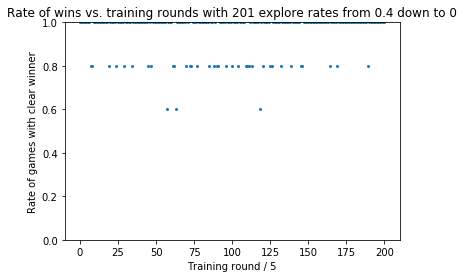

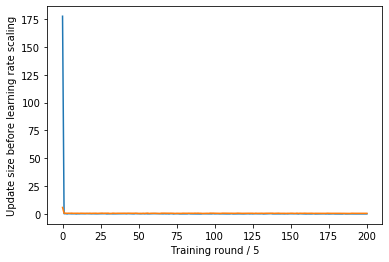

In [26]:
p1long4, p2long4 = makedynamic(5, 201, 0.5, rows=3, cols=4, movingalpha = True, stratnames='grav34', aggover=5, 
                               numfilters=4, filtersize=3)
#p1grav34, p2grav34 = makedynamic(15000, 9, 0.4, rows=3, cols=4, winc=3, gmove=True, movingalpha=True, 
                               #stratnames="grav34")
# gmove is no longer necessary, our class takes care of that for us now.

In [32]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p1long4, human, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

[0, 1, 2, 3]
0
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | x |   |   |   | 
---------------------

[0, 1, 2, 3]
Input your action col:2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | x |   | o |   | 
---------------------

[0, 1, 2, 3]
0
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  | x |   |   |   | 
---------------------
2  | x |   | o |   | 
---------------------

[0, 1, 2, 3]
Input your action col:0
   | 0 | 1 | 2 | 3 |
---------------------
0  | o |   |   |   | 
---------------------
1  | x |   |   |   | 
---------------------
2  | x |   | o |   | 
---------------------

[1, 2, 3]
2
   |

-1

In [24]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(human, p2long4, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

[0, 1, 2, 3]
Input your action col:2
2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   | x |   | 
---------------------

[0, 1, 2, 3]
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | o |   | x |   | 
---------------------

[0, 1, 2, 3]
Input your action col:1
1
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | o | x | x |   | 
---------------------

[0, 1, 2, 3]
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  | o |   |   |   | 
---------------------
2  | o | x | x |   | 
---------------------

[0, 1, 2, 3]
Inp

1

## 4x4

Updated number of filters from 4 to 8 / actually still 4. Try 2000 vs 1000 rounds since 1000 rounds didn't work (when we used 8 filters).

Test both 1000 and 2000 rounds below with 4 filters. Neither worked. Graph for 2000 rounds is same as graph for 1000 rounds.

0.0025





  0%|                                                                                          | 0/201 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  0%|▍                                                                               | 1/201 [00:26<1:29:36, 26.88s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  1%|▊                                                                               | 2/201 [00:44<1:19:34, 23.99s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  1%|█▏                                                                              | 3/201 [01:08<1:19:35, 24.12s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  2%|█▌                                                                              | 4/201 [01:26<1:13:10, 22.29s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  2%|█▉                                                                              | 5/201 [01:49<1:13:37, 22.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  3%|██▍                                                                             | 6/201 [02:09<1:10:58, 21.84s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  3%|██▊                                                                             | 7/201 [02:34<1:13:34, 22.75s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  4%|███▏                                                                            | 8/201 [02:51<1:07:49, 21.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  4%|███▌                                                                            | 9/201 [03:13<1:07:45, 21.18s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  5%|███▉                                                                           | 10/201 [03:39<1:11:41, 22.52s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  5%|████▎                                                                          | 11/201 [03:59<1:09:08, 21.83s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  6%|████▋                                                                          | 12/201 [04:20<1:07:53, 21.55s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  6%|█████                                                                          | 13/201 [04:40<1:06:10, 21.12s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  7%|█████▌                                                                         | 14/201 [05:06<1:10:21, 22.57s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  7%|█████▉                                                                         | 15/201 [05:26<1:07:22, 21.74s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  8%|██████▎                                                                        | 16/201 [05:51<1:10:47, 22.96s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  8%|██████▋                                                                        | 17/201 [06:17<1:12:50, 23.75s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  9%|███████                                                                        | 18/201 [06:35<1:07:11, 22.03s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  9%|███████▍                                                                       | 19/201 [06:59<1:08:27, 22.57s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 10%|███████▊                                                                       | 20/201 [07:16<1:03:24, 21.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 10%|████████▎                                                                      | 21/201 [07:41<1:06:25, 22.14s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 11%|████████▊                                                                        | 22/201 [07:56<59:56, 20.09s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 11%|█████████                                                                      | 23/201 [08:18<1:00:50, 20.51s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 12%|█████████▋                                                                       | 24/201 [08:37<59:38, 20.22s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 12%|█████████▊                                                                     | 25/201 [09:03<1:04:01, 21.83s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 13%|██████████▏                                                                    | 26/201 [09:29<1:07:37, 23.18s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 13%|██████████▌                                                                    | 27/201 [09:51<1:06:10, 22.82s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 14%|███████████                                                                    | 28/201 [10:11<1:02:50, 21.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 14%|███████████▍                                                                   | 29/201 [10:30<1:00:51, 21.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 15%|███████████▊                                                                   | 30/201 [10:57<1:04:52, 22.76s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 15%|████████████▏                                                                  | 31/201 [11:18<1:03:09, 22.29s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 16%|████████████▌                                                                  | 32/201 [11:43<1:04:58, 23.07s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 16%|████████████▉                                                                  | 33/201 [12:03<1:02:08, 22.19s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 17%|█████████████▎                                                                 | 34/201 [12:24<1:00:37, 21.78s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 17%|█████████████▊                                                                 | 35/201 [12:47<1:01:34, 22.26s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 18%|██████████████▏                                                                | 36/201 [13:14<1:04:47, 23.56s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 18%|██████████████▉                                                                  | 37/201 [13:32<59:56, 21.93s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 19%|███████████████▎                                                                 | 38/201 [13:53<58:43, 21.62s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 19%|███████████████▋                                                                 | 39/201 [14:10<54:42, 20.26s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 20%|████████████████                                                                 | 40/201 [14:32<55:51, 20.82s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 20%|████████████████▌                                                                | 41/201 [14:53<55:15, 20.72s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 21%|████████████████▉                                                                | 42/201 [15:13<54:31, 20.57s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 21%|█████████████████▎                                                               | 43/201 [15:36<56:09, 21.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 22%|█████████████████▋                                                               | 44/201 [15:57<55:45, 21.31s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 22%|██████████████████▏                                                              | 45/201 [16:16<53:08, 20.44s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 23%|██████████████████▌                                                              | 46/201 [16:34<51:04, 19.77s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 23%|██████████████████▉                                                              | 47/201 [16:54<50:58, 19.86s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 24%|███████████████████▎                                                             | 48/201 [17:13<50:07, 19.66s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 24%|███████████████████▋                                                             | 49/201 [17:30<48:01, 18.96s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 25%|████████████████████▏                                                            | 50/201 [17:50<48:08, 19.13s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 25%|████████████████████▌                                                            | 51/201 [18:11<49:01, 19.61s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 26%|████████████████████▉                                                            | 52/201 [18:33<51:08, 20.60s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 26%|█████████████████████▎                                                           | 53/201 [18:54<50:37, 20.52s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 27%|█████████████████████▊                                                           | 54/201 [19:15<50:48, 20.74s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 27%|██████████████████████▏                                                          | 55/201 [19:39<53:08, 21.84s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 28%|██████████████████████▌                                                          | 56/201 [19:58<50:41, 20.98s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 28%|██████████████████████▉                                                          | 57/201 [20:16<47:54, 19.96s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 29%|███████████████████████▎                                                         | 58/201 [20:38<48:57, 20.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 29%|███████████████████████▊                                                         | 59/201 [21:03<51:37, 21.81s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 30%|████████████████████████▏                                                        | 60/201 [21:25<51:29, 21.91s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 30%|████████████████████████▌                                                        | 61/201 [21:44<49:15, 21.11s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 31%|████████████████████████▉                                                        | 62/201 [22:04<47:55, 20.68s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 31%|█████████████████████████▍                                                       | 63/201 [22:25<47:47, 20.78s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 32%|█████████████████████████▊                                                       | 64/201 [22:48<48:47, 21.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 32%|██████████████████████████▏                                                      | 65/201 [23:14<51:39, 22.79s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 33%|██████████████████████████▌                                                      | 66/201 [23:36<50:53, 22.62s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 33%|███████████████████████████                                                      | 67/201 [23:57<49:24, 22.12s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 34%|███████████████████████████▍                                                     | 68/201 [24:16<47:22, 21.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 34%|███████████████████████████▊                                                     | 69/201 [24:33<44:05, 20.04s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 35%|████████████████████████████▏                                                    | 70/201 [24:49<40:43, 18.66s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 35%|████████████████████████████▌                                                    | 71/201 [25:13<43:56, 20.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 36%|█████████████████████████████                                                    | 72/201 [25:35<44:42, 20.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 36%|█████████████████████████████▍                                                   | 73/201 [26:00<47:20, 22.19s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 37%|█████████████████████████████▊                                                   | 74/201 [26:18<44:20, 20.95s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 37%|██████████████████████████████▏                                                  | 75/201 [26:43<46:32, 22.16s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 38%|██████████████████████████████▋                                                  | 76/201 [27:01<43:05, 20.69s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 38%|███████████████████████████████                                                  | 77/201 [27:22<43:22, 20.99s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 39%|███████████████████████████████▍                                                 | 78/201 [27:44<43:30, 21.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 39%|███████████████████████████████▊                                                 | 79/201 [28:03<41:53, 20.60s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 40%|████████████████████████████████▏                                                | 80/201 [28:25<42:17, 20.98s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 40%|████████████████████████████████▋                                                | 81/201 [28:46<41:54, 20.95s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 41%|█████████████████████████████████                                                | 82/201 [29:05<40:39, 20.50s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 41%|█████████████████████████████████▍                                               | 83/201 [29:28<41:38, 21.18s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 42%|█████████████████████████████████▊                                               | 84/201 [29:56<45:14, 23.20s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 42%|██████████████████████████████████▎                                              | 85/201 [30:17<43:35, 22.55s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 43%|██████████████████████████████████▋                                              | 86/201 [30:36<41:22, 21.59s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 43%|███████████████████████████████████                                              | 87/201 [30:53<38:05, 20.05s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 44%|███████████████████████████████████▍                                             | 88/201 [31:17<40:13, 21.36s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 44%|███████████████████████████████████▊                                             | 89/201 [31:37<39:08, 20.97s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 45%|████████████████████████████████████▎                                            | 90/201 [31:56<37:16, 20.15s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 45%|████████████████████████████████████▋                                            | 91/201 [32:13<35:09, 19.18s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 46%|█████████████████████████████████████                                            | 92/201 [32:33<35:42, 19.66s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 46%|█████████████████████████████████████▍                                           | 93/201 [32:48<32:35, 18.11s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 47%|█████████████████████████████████████▉                                           | 94/201 [33:13<35:48, 20.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 47%|██████████████████████████████████████▎                                          | 95/201 [33:38<38:34, 21.84s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 48%|██████████████████████████████████████▋                                          | 96/201 [33:58<37:04, 21.19s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 48%|███████████████████████████████████████                                          | 97/201 [34:17<35:23, 20.42s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 49%|███████████████████████████████████████▍                                         | 98/201 [34:43<38:07, 22.21s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 49%|███████████████████████████████████████▉                                         | 99/201 [35:06<38:15, 22.51s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 50%|███████████████████████████████████████▊                                        | 100/201 [35:28<37:25, 22.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 50%|████████████████████████████████████████▏                                       | 101/201 [35:49<36:26, 21.87s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 51%|████████████████████████████████████████▌                                       | 102/201 [36:08<34:39, 21.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 51%|████████████████████████████████████████▉                                       | 103/201 [36:27<33:22, 20.44s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 52%|█████████████████████████████████████████▍                                      | 104/201 [36:44<31:13, 19.31s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 52%|█████████████████████████████████████████▊                                      | 105/201 [37:05<32:00, 20.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 53%|██████████████████████████████████████████▏                                     | 106/201 [37:21<29:44, 18.78s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 53%|██████████████████████████████████████████▌                                     | 107/201 [37:44<31:30, 20.11s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 54%|██████████████████████████████████████████▉                                     | 108/201 [38:02<29:57, 19.33s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 54%|███████████████████████████████████████████▍                                    | 109/201 [38:23<30:20, 19.79s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 55%|███████████████████████████████████████████▊                                    | 110/201 [38:42<29:44, 19.61s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 55%|████████████████████████████████████████████▏                                   | 111/201 [39:07<31:36, 21.07s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 56%|████████████████████████████████████████████▌                                   | 112/201 [39:28<31:25, 21.19s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 56%|████████████████████████████████████████████▉                                   | 113/201 [39:46<29:33, 20.16s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 57%|█████████████████████████████████████████████▎                                  | 114/201 [40:03<28:04, 19.36s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 57%|█████████████████████████████████████████████▊                                  | 115/201 [40:33<32:04, 22.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 58%|██████████████████████████████████████████████▏                                 | 116/201 [40:50<29:34, 20.87s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 58%|██████████████████████████████████████████████▌                                 | 117/201 [41:14<30:33, 21.82s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 59%|██████████████████████████████████████████████▉                                 | 118/201 [41:33<28:57, 20.93s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 59%|███████████████████████████████████████████████▎                                | 119/201 [41:51<27:34, 20.18s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 60%|███████████████████████████████████████████████▊                                | 120/201 [42:11<26:58, 19.98s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 60%|████████████████████████████████████████████████▏                               | 121/201 [42:32<27:05, 20.31s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 61%|████████████████████████████████████████████████▌                               | 122/201 [42:51<26:21, 20.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 61%|████████████████████████████████████████████████▉                               | 123/201 [43:16<27:51, 21.43s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 62%|█████████████████████████████████████████████████▎                              | 124/201 [43:36<26:58, 21.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 62%|█████████████████████████████████████████████████▊                              | 125/201 [43:55<25:42, 20.30s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 63%|██████████████████████████████████████████████████▏                             | 126/201 [44:14<24:51, 19.88s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 63%|██████████████████████████████████████████████████▌                             | 127/201 [44:32<24:04, 19.52s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 64%|██████████████████████████████████████████████████▉                             | 128/201 [44:54<24:24, 20.06s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 64%|███████████████████████████████████████████████████▎                            | 129/201 [45:10<22:49, 19.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 65%|███████████████████████████████████████████████████▋                            | 130/201 [45:27<21:49, 18.44s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 65%|████████████████████████████████████████████████████▏                           | 131/201 [45:45<21:16, 18.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 66%|████████████████████████████████████████████████████▌                           | 132/201 [46:03<20:42, 18.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 66%|████████████████████████████████████████████████████▉                           | 133/201 [46:21<20:29, 18.09s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 67%|█████████████████████████████████████████████████████▎                          | 134/201 [46:39<20:17, 18.17s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 67%|█████████████████████████████████████████████████████▋                          | 135/201 [46:56<19:23, 17.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 68%|██████████████████████████████████████████████████████▏                         | 136/201 [47:20<21:27, 19.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 68%|██████████████████████████████████████████████████████▌                         | 137/201 [47:43<22:09, 20.77s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 69%|██████████████████████████████████████████████████████▉                         | 138/201 [48:07<22:36, 21.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 69%|███████████████████████████████████████████████████████▎                        | 139/201 [48:26<21:25, 20.73s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 70%|███████████████████████████████████████████████████████▋                        | 140/201 [48:45<20:31, 20.19s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 70%|████████████████████████████████████████████████████████                        | 141/201 [49:06<20:39, 20.67s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 71%|████████████████████████████████████████████████████████▌                       | 142/201 [49:28<20:31, 20.87s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 71%|████████████████████████████████████████████████████████▉                       | 143/201 [49:53<21:26, 22.19s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 72%|█████████████████████████████████████████████████████████▎                      | 144/201 [50:13<20:20, 21.42s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 72%|█████████████████████████████████████████████████████████▋                      | 145/201 [50:38<21:13, 22.74s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 73%|██████████████████████████████████████████████████████████                      | 146/201 [50:58<19:55, 21.73s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 73%|██████████████████████████████████████████████████████████▌                     | 147/201 [51:17<18:47, 20.88s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 74%|██████████████████████████████████████████████████████████▉                     | 148/201 [51:34<17:24, 19.71s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 74%|███████████████████████████████████████████████████████████▎                    | 149/201 [51:51<16:25, 18.96s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 75%|███████████████████████████████████████████████████████████▋                    | 150/201 [52:09<16:00, 18.83s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 75%|████████████████████████████████████████████████████████████                    | 151/201 [52:27<15:18, 18.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 76%|████████████████████████████████████████████████████████████▍                   | 152/201 [52:46<15:12, 18.62s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 76%|████████████████████████████████████████████████████████████▉                   | 153/201 [53:10<16:14, 20.30s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 77%|█████████████████████████████████████████████████████████████▎                  | 154/201 [53:30<15:46, 20.13s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 77%|█████████████████████████████████████████████████████████████▋                  | 155/201 [53:50<15:30, 20.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 78%|██████████████████████████████████████████████████████████████                  | 156/201 [54:07<14:20, 19.11s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 78%|██████████████████████████████████████████████████████████████▍                 | 157/201 [54:25<13:54, 18.97s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 79%|██████████████████████████████████████████████████████████████▉                 | 158/201 [54:44<13:34, 18.94s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 79%|███████████████████████████████████████████████████████████████▎                | 159/201 [55:08<14:10, 20.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 80%|███████████████████████████████████████████████████████████████▋                | 160/201 [55:26<13:28, 19.71s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 80%|████████████████████████████████████████████████████████████████                | 161/201 [55:50<14:00, 21.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 81%|████████████████████████████████████████████████████████████████▍               | 162/201 [56:13<14:07, 21.73s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 81%|████████████████████████████████████████████████████████████████▉               | 163/201 [56:32<13:14, 20.91s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 82%|█████████████████████████████████████████████████████████████████▎              | 164/201 [56:47<11:47, 19.12s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 82%|█████████████████████████████████████████████████████████████████▋              | 165/201 [57:08<11:43, 19.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 83%|██████████████████████████████████████████████████████████████████              | 166/201 [57:27<11:20, 19.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 83%|██████████████████████████████████████████████████████████████████▍             | 167/201 [57:46<10:57, 19.33s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 84%|██████████████████████████████████████████████████████████████████▊             | 168/201 [58:04<10:24, 18.91s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 84%|███████████████████████████████████████████████████████████████████▎            | 169/201 [58:26<10:34, 19.84s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 85%|███████████████████████████████████████████████████████████████████▋            | 170/201 [58:46<10:11, 19.72s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 85%|████████████████████████████████████████████████████████████████████            | 171/201 [59:04<09:36, 19.20s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 86%|████████████████████████████████████████████████████████████████████▍           | 172/201 [59:25<09:39, 19.99s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 86%|████████████████████████████████████████████████████████████████████▊           | 173/201 [59:42<08:54, 19.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 87%|███████████████████████████████████████████████████████████████████▌          | 174/201 [1:00:01<08:32, 19.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 87%|███████████████████████████████████████████████████████████████████▉          | 175/201 [1:00:18<07:57, 18.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 88%|████████████████████████████████████████████████████████████████████▎         | 176/201 [1:00:37<07:43, 18.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 88%|████████████████████████████████████████████████████████████████████▋         | 177/201 [1:00:56<07:27, 18.64s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 89%|█████████████████████████████████████████████████████████████████████         | 178/201 [1:01:15<07:09, 18.67s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 89%|█████████████████████████████████████████████████████████████████████▍        | 179/201 [1:01:33<06:50, 18.66s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 90%|█████████████████████████████████████████████████████████████████████▊        | 180/201 [1:01:51<06:23, 18.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 90%|██████████████████████████████████████████████████████████████████████▏       | 181/201 [1:02:07<05:55, 17.76s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 91%|██████████████████████████████████████████████████████████████████████▋       | 182/201 [1:02:26<05:40, 17.92s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 91%|███████████████████████████████████████████████████████████████████████       | 183/201 [1:02:44<05:27, 18.18s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 92%|███████████████████████████████████████████████████████████████████████▍      | 184/201 [1:03:05<05:21, 18.91s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 92%|███████████████████████████████████████████████████████████████████████▊      | 185/201 [1:03:24<05:05, 19.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 93%|████████████████████████████████████████████████████████████████████████▏     | 186/201 [1:03:46<04:58, 19.91s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 93%|████████████████████████████████████████████████████████████████████████▌     | 187/201 [1:04:04<04:31, 19.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 94%|████████████████████████████████████████████████████████████████████████▉     | 188/201 [1:04:23<04:10, 19.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 94%|█████████████████████████████████████████████████████████████████████████▎    | 189/201 [1:04:44<03:57, 19.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 95%|█████████████████████████████████████████████████████████████████████████▋    | 190/201 [1:05:03<03:33, 19.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 95%|██████████████████████████████████████████████████████████████████████████    | 191/201 [1:05:22<03:14, 19.44s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 96%|██████████████████████████████████████████████████████████████████████████▌   | 192/201 [1:05:41<02:53, 19.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 96%|██████████████████████████████████████████████████████████████████████████▉   | 193/201 [1:06:00<02:32, 19.06s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 97%|███████████████████████████████████████████████████████████████████████████▎  | 194/201 [1:06:18<02:11, 18.77s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 97%|███████████████████████████████████████████████████████████████████████████▋  | 195/201 [1:06:37<01:52, 18.72s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 98%|████████████████████████████████████████████████████████████████████████████  | 196/201 [1:06:55<01:33, 18.64s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 98%|████████████████████████████████████████████████████████████████████████████▍ | 197/201 [1:07:13<01:14, 18.57s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 99%|████████████████████████████████████████████████████████████████████████████▊ | 198/201 [1:07:33<00:56, 18.82s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 99%|█████████████████████████████████████████████████████████████████████████████▏| 199/201 [1:07:49<00:36, 18.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





100%|█████████████████████████████████████████████████████████████████████████████▌| 200/201 [1:08:07<00:18, 18.14s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [1:08:27<00:00, 20.44s/it]


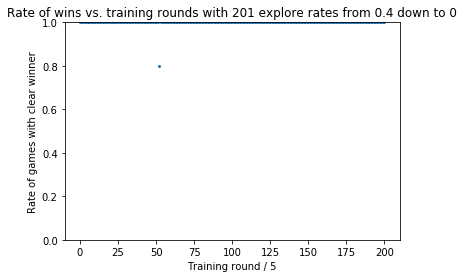

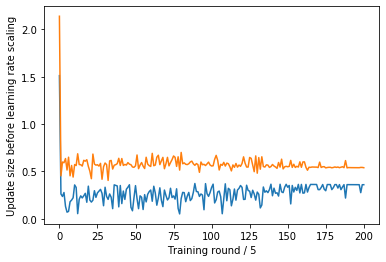

In [27]:
p1long44, p2long44 = makedynamic(5, 201, 0.5, rows=4, cols=4, movingalpha = True, stratnames='grav44', aggover=5,
                               numfilters=4, filtersize=3)
#p1grav34, p2grav34 = makedynamic(15000, 9, 0.4, rows=3, cols=4, winc=3, gmove=True, movingalpha=True, 
                               #stratnames="grav34")
# gmove is no longer necessary, our class takes care of that for us now.

Next try 2000 rounds but with more filters (8 vs. 4).

0.00125





  0%|                                                                                          | 0/401 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  0%|▏                                                                               | 1/401 [00:19<2:08:13, 19.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  0%|▍                                                                               | 2/401 [00:39<2:10:18, 19.60s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  1%|▌                                                                               | 3/401 [01:09<2:30:01, 22.62s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  1%|▊                                                                               | 4/401 [01:32<2:30:50, 22.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  1%|▉                                                                               | 5/401 [01:57<2:35:25, 23.55s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  1%|█▏                                                                              | 6/401 [02:16<2:25:24, 22.09s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  2%|█▍                                                                              | 7/401 [02:38<2:24:15, 21.97s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  2%|█▌                                                                              | 8/401 [03:06<2:35:29, 23.74s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  2%|█▊                                                                              | 9/401 [03:39<2:53:39, 26.58s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  2%|█▉                                                                             | 10/401 [03:58<2:39:34, 24.49s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  3%|██▏                                                                            | 11/401 [04:25<2:43:12, 25.11s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  3%|██▎                                                                            | 12/401 [04:55<2:53:03, 26.69s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  3%|██▌                                                                            | 13/401 [05:19<2:47:24, 25.89s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  3%|██▊                                                                            | 14/401 [05:39<2:34:26, 23.94s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  4%|██▉                                                                            | 15/401 [06:02<2:32:34, 23.72s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  4%|███▏                                                                           | 16/401 [06:27<2:34:33, 24.09s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  4%|███▎                                                                           | 17/401 [06:45<2:22:38, 22.29s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  4%|███▌                                                                           | 18/401 [07:06<2:19:55, 21.92s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  5%|███▋                                                                           | 19/401 [07:28<2:20:21, 22.05s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  5%|███▉                                                                           | 20/401 [07:48<2:14:22, 21.16s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  5%|████▏                                                                          | 21/401 [08:08<2:11:53, 20.82s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  5%|████▎                                                                          | 22/401 [08:29<2:12:44, 21.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  6%|████▌                                                                          | 23/401 [08:51<2:14:27, 21.34s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  6%|████▋                                                                          | 24/401 [09:11<2:11:04, 20.86s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  6%|████▉                                                                          | 25/401 [09:35<2:16:46, 21.83s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  6%|█████                                                                          | 26/401 [09:59<2:21:10, 22.59s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  7%|█████▎                                                                         | 27/401 [10:28<2:31:23, 24.29s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  7%|█████▌                                                                         | 28/401 [10:49<2:25:51, 23.46s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  7%|█████▋                                                                         | 29/401 [11:11<2:21:53, 22.89s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  7%|█████▉                                                                         | 30/401 [11:27<2:09:28, 20.94s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  8%|██████                                                                         | 31/401 [11:46<2:05:57, 20.43s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  8%|██████▎                                                                        | 32/401 [12:13<2:18:03, 22.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  8%|██████▌                                                                        | 33/401 [12:36<2:17:38, 22.44s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  8%|██████▋                                                                        | 34/401 [13:01<2:22:18, 23.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  9%|██████▉                                                                        | 35/401 [13:20<2:13:14, 21.84s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  9%|███████                                                                        | 36/401 [13:37<2:05:42, 20.66s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  9%|███████▎                                                                       | 37/401 [13:58<2:05:03, 20.61s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  9%|███████▍                                                                       | 38/401 [14:20<2:06:59, 20.99s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 10%|███████▋                                                                       | 39/401 [14:43<2:10:14, 21.59s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 10%|███████▉                                                                       | 40/401 [15:05<2:10:26, 21.68s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 10%|████████                                                                       | 41/401 [15:25<2:06:53, 21.15s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 10%|████████▎                                                                      | 42/401 [15:45<2:04:18, 20.78s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 11%|████████▍                                                                      | 43/401 [16:07<2:06:22, 21.18s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 11%|████████▋                                                                      | 44/401 [16:33<2:16:05, 22.87s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 11%|████████▊                                                                      | 45/401 [16:58<2:18:15, 23.30s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 11%|█████████                                                                      | 46/401 [17:19<2:14:10, 22.68s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 12%|█████████▎                                                                     | 47/401 [17:38<2:06:57, 21.52s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 12%|█████████▍                                                                     | 48/401 [18:00<2:07:54, 21.74s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 12%|█████████▋                                                                     | 49/401 [18:26<2:14:22, 22.91s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 12%|█████████▊                                                                     | 50/401 [18:48<2:13:28, 22.82s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 13%|██████████                                                                     | 51/401 [19:09<2:10:04, 22.30s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 13%|██████████▏                                                                    | 52/401 [19:33<2:11:53, 22.67s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 13%|██████████▍                                                                    | 53/401 [19:59<2:17:46, 23.75s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 13%|██████████▋                                                                    | 54/401 [20:22<2:15:19, 23.40s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 14%|██████████▊                                                                    | 55/401 [20:46<2:15:54, 23.57s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 14%|███████████                                                                    | 56/401 [21:13<2:21:00, 24.52s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 14%|███████████▏                                                                   | 57/401 [21:34<2:14:58, 23.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 14%|███████████▍                                                                   | 58/401 [21:54<2:08:41, 22.51s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 15%|███████████▌                                                                   | 59/401 [22:13<2:03:05, 21.59s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 15%|███████████▊                                                                   | 60/401 [22:34<2:01:16, 21.34s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 15%|████████████                                                                   | 61/401 [23:00<2:08:47, 22.73s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 15%|████████████▏                                                                  | 62/401 [23:24<2:10:00, 23.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 16%|████████████▍                                                                  | 63/401 [23:44<2:05:48, 22.33s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 16%|████████████▌                                                                  | 64/401 [24:06<2:04:37, 22.19s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 16%|████████████▊                                                                  | 65/401 [24:25<1:58:44, 21.20s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 16%|█████████████                                                                  | 66/401 [24:46<1:56:57, 20.95s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 17%|█████████████▏                                                                 | 67/401 [25:06<1:55:09, 20.69s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 17%|█████████████▍                                                                 | 68/401 [25:29<1:58:26, 21.34s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 17%|█████████████▌                                                                 | 69/401 [25:47<1:53:16, 20.47s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 17%|█████████████▊                                                                 | 70/401 [26:09<1:56:08, 21.05s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 18%|█████████████▉                                                                 | 71/401 [26:36<2:05:20, 22.79s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 18%|██████████████▏                                                                | 72/401 [26:57<2:02:18, 22.30s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 18%|██████████████▍                                                                | 73/401 [27:18<1:59:38, 21.88s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 18%|██████████████▌                                                                | 74/401 [27:39<1:56:54, 21.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 19%|██████████████▊                                                                | 75/401 [28:04<2:02:56, 22.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 19%|██████████████▉                                                                | 76/401 [28:23<1:56:14, 21.46s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 19%|███████████████▏                                                               | 77/401 [28:42<1:52:57, 20.92s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 19%|███████████████▎                                                               | 78/401 [29:02<1:50:25, 20.51s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 20%|███████████████▌                                                               | 79/401 [29:22<1:48:58, 20.31s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 20%|███████████████▊                                                               | 80/401 [29:50<2:01:28, 22.70s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 20%|███████████████▉                                                               | 81/401 [30:16<2:06:45, 23.77s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 20%|████████████████▏                                                              | 82/401 [30:35<1:58:12, 22.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 21%|████████████████▎                                                              | 83/401 [31:00<2:01:49, 22.99s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 21%|████████████████▌                                                              | 84/401 [31:16<1:50:48, 20.97s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 21%|████████████████▋                                                              | 85/401 [31:46<2:04:38, 23.67s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 21%|████████████████▉                                                              | 86/401 [32:05<1:56:55, 22.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 22%|█████████████████▏                                                             | 87/401 [32:22<1:48:08, 20.67s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 22%|█████████████████▎                                                             | 88/401 [32:42<1:47:08, 20.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 22%|█████████████████▌                                                             | 89/401 [33:01<1:43:50, 19.97s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 22%|█████████████████▋                                                             | 90/401 [33:21<1:43:17, 19.93s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 23%|█████████████████▉                                                             | 91/401 [33:44<1:48:21, 20.97s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 23%|██████████████████                                                             | 92/401 [34:03<1:44:43, 20.33s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 23%|██████████████████▎                                                            | 93/401 [34:29<1:53:20, 22.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 23%|██████████████████▌                                                            | 94/401 [34:46<1:45:36, 20.64s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 24%|██████████████████▋                                                            | 95/401 [35:08<1:46:57, 20.97s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 24%|██████████████████▉                                                            | 96/401 [35:31<1:49:07, 21.47s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 24%|███████████████████                                                            | 97/401 [35:48<1:42:30, 20.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 24%|███████████████████▎                                                           | 98/401 [36:05<1:37:33, 19.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 25%|███████████████████▌                                                           | 99/401 [36:25<1:37:18, 19.33s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 25%|███████████████████▍                                                          | 100/401 [36:46<1:39:45, 19.89s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 25%|███████████████████▋                                                          | 101/401 [37:04<1:37:26, 19.49s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 25%|███████████████████▊                                                          | 102/401 [37:23<1:35:20, 19.13s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 26%|████████████████████                                                          | 103/401 [37:42<1:35:16, 19.18s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 26%|████████████████████▏                                                         | 104/401 [38:08<1:44:33, 21.12s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 26%|████████████████████▍                                                         | 105/401 [38:35<1:53:58, 23.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 26%|████████████████████▌                                                         | 106/401 [39:01<1:58:01, 24.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 27%|████████████████████▊                                                         | 107/401 [39:26<1:58:51, 24.26s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 27%|█████████████████████                                                         | 108/401 [39:58<2:09:50, 26.59s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 27%|█████████████████████▏                                                        | 109/401 [40:22<2:05:01, 25.69s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 27%|█████████████████████▍                                                        | 110/401 [40:40<1:53:26, 23.39s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 28%|█████████████████████▌                                                        | 111/401 [41:04<1:54:12, 23.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 28%|█████████████████████▊                                                        | 112/401 [41:24<1:48:13, 22.47s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 28%|█████████████████████▉                                                        | 113/401 [41:45<1:45:26, 21.97s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 28%|██████████████████████▏                                                       | 114/401 [42:08<1:47:31, 22.48s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 29%|██████████████████████▎                                                       | 115/401 [42:36<1:54:53, 24.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 29%|██████████████████████▌                                                       | 116/401 [43:02<1:57:24, 24.72s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 29%|██████████████████████▊                                                       | 117/401 [43:27<1:57:14, 24.77s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 29%|██████████████████████▉                                                       | 118/401 [43:53<1:58:22, 25.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 30%|███████████████████████▏                                                      | 119/401 [44:13<1:50:08, 23.43s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 30%|███████████████████████▎                                                      | 120/401 [44:37<1:50:44, 23.65s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 30%|███████████████████████▌                                                      | 121/401 [44:59<1:48:28, 23.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 30%|███████████████████████▋                                                      | 122/401 [45:27<1:53:50, 24.48s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 31%|███████████████████████▉                                                      | 123/401 [45:44<1:43:37, 22.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 31%|████████████████████████                                                      | 124/401 [46:10<1:48:01, 23.40s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 31%|████████████████████████▎                                                     | 125/401 [46:32<1:45:34, 22.95s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 31%|████████████████████████▌                                                     | 126/401 [46:47<1:34:59, 20.73s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 32%|████████████████████████▋                                                     | 127/401 [47:08<1:34:03, 20.60s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 32%|████████████████████████▉                                                     | 128/401 [47:24<1:27:33, 19.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 32%|█████████████████████████                                                     | 129/401 [47:37<1:19:45, 17.59s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 32%|█████████████████████████▎                                                    | 130/401 [48:00<1:25:59, 19.04s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 33%|█████████████████████████▍                                                    | 131/401 [48:21<1:28:52, 19.75s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 33%|█████████████████████████▋                                                    | 132/401 [48:42<1:29:27, 19.95s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 33%|█████████████████████████▊                                                    | 133/401 [48:59<1:25:21, 19.11s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 33%|██████████████████████████                                                    | 134/401 [49:23<1:32:12, 20.72s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 34%|██████████████████████████▎                                                   | 135/401 [49:44<1:31:17, 20.59s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 34%|██████████████████████████▍                                                   | 136/401 [50:09<1:36:55, 21.94s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 34%|██████████████████████████▋                                                   | 137/401 [50:32<1:38:26, 22.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 34%|██████████████████████████▊                                                   | 138/401 [50:51<1:33:35, 21.35s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 35%|███████████████████████████                                                   | 139/401 [51:18<1:40:08, 22.93s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 35%|███████████████████████████▏                                                  | 140/401 [51:38<1:37:05, 22.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 35%|███████████████████████████▍                                                  | 141/401 [51:59<1:34:44, 21.86s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 35%|███████████████████████████▌                                                  | 142/401 [52:19<1:31:13, 21.13s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 36%|███████████████████████████▊                                                  | 143/401 [52:38<1:28:41, 20.62s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 36%|████████████████████████████                                                  | 144/401 [52:55<1:23:54, 19.59s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 36%|████████████████████████████▏                                                 | 145/401 [53:14<1:22:08, 19.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 36%|████████████████████████████▍                                                 | 146/401 [53:34<1:23:02, 19.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 37%|████████████████████████████▌                                                 | 147/401 [53:57<1:26:54, 20.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 37%|████████████████████████████▊                                                 | 148/401 [54:20<1:29:37, 21.26s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 37%|████████████████████████████▉                                                 | 149/401 [54:34<1:20:11, 19.09s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 37%|█████████████████████████████▏                                                | 150/401 [54:52<1:18:46, 18.83s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 38%|█████████████████████████████▎                                                | 151/401 [55:17<1:25:55, 20.62s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 38%|█████████████████████████████▌                                                | 152/401 [55:41<1:29:56, 21.67s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 38%|█████████████████████████████▊                                                | 153/401 [56:02<1:28:31, 21.42s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 38%|█████████████████████████████▉                                                | 154/401 [56:23<1:28:26, 21.49s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 39%|██████████████████████████████▏                                               | 155/401 [56:44<1:27:14, 21.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 39%|██████████████████████████████▎                                               | 156/401 [57:00<1:20:10, 19.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 39%|██████████████████████████████▌                                               | 157/401 [57:20<1:20:35, 19.82s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 39%|██████████████████████████████▋                                               | 158/401 [57:42<1:22:20, 20.33s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 40%|██████████████████████████████▉                                               | 159/401 [58:02<1:21:51, 20.30s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 40%|███████████████████████████████                                               | 160/401 [58:26<1:26:00, 21.41s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 40%|███████████████████████████████▎                                              | 161/401 [58:44<1:21:21, 20.34s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 40%|███████████████████████████████▌                                              | 162/401 [59:04<1:20:23, 20.18s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 41%|███████████████████████████████▋                                              | 163/401 [59:25<1:21:31, 20.55s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 41%|███████████████████████████████▉                                              | 164/401 [59:44<1:19:14, 20.06s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 41%|███████████████████████████████▎                                            | 165/401 [1:00:04<1:18:38, 19.99s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 41%|███████████████████████████████▍                                            | 166/401 [1:00:26<1:21:20, 20.77s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 42%|███████████████████████████████▋                                            | 167/401 [1:00:42<1:15:20, 19.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 42%|███████████████████████████████▊                                            | 168/401 [1:01:05<1:18:41, 20.26s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 42%|████████████████████████████████                                            | 169/401 [1:01:26<1:19:54, 20.67s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 42%|████████████████████████████████▏                                           | 170/401 [1:01:45<1:17:15, 20.07s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 43%|████████████████████████████████▍                                           | 171/401 [1:02:03<1:14:54, 19.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 43%|████████████████████████████████▌                                           | 172/401 [1:02:23<1:14:56, 19.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 43%|████████████████████████████████▊                                           | 173/401 [1:02:44<1:16:21, 20.09s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 43%|████████████████████████████████▉                                           | 174/401 [1:03:01<1:11:56, 19.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 44%|█████████████████████████████████▏                                          | 175/401 [1:03:21<1:12:37, 19.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 44%|█████████████████████████████████▎                                          | 176/401 [1:03:40<1:12:08, 19.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 44%|█████████████████████████████████▌                                          | 177/401 [1:04:00<1:12:48, 19.50s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 44%|█████████████████████████████████▋                                          | 178/401 [1:04:21<1:13:47, 19.86s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 45%|█████████████████████████████████▉                                          | 179/401 [1:04:41<1:13:42, 19.92s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 45%|██████████████████████████████████                                          | 180/401 [1:05:00<1:12:05, 19.57s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 45%|██████████████████████████████████▎                                         | 181/401 [1:05:22<1:14:22, 20.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 45%|██████████████████████████████████▍                                         | 182/401 [1:05:40<1:11:38, 19.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 46%|██████████████████████████████████▋                                         | 183/401 [1:06:00<1:11:40, 19.73s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 46%|██████████████████████████████████▊                                         | 184/401 [1:06:22<1:13:44, 20.39s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 46%|███████████████████████████████████                                         | 185/401 [1:06:44<1:15:08, 20.87s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 46%|███████████████████████████████████▎                                        | 186/401 [1:06:58<1:08:14, 19.04s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 47%|███████████████████████████████████▍                                        | 187/401 [1:07:18<1:08:21, 19.16s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 47%|███████████████████████████████████▋                                        | 188/401 [1:07:35<1:05:47, 18.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 47%|███████████████████████████████████▊                                        | 189/401 [1:07:58<1:10:15, 19.88s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 47%|████████████████████████████████████                                        | 190/401 [1:08:14<1:06:22, 18.88s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 48%|████████████████████████████████████▏                                       | 191/401 [1:08:33<1:05:17, 18.65s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 48%|████████████████████████████████████▍                                       | 192/401 [1:08:51<1:04:40, 18.56s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 48%|████████████████████████████████████▌                                       | 193/401 [1:09:12<1:07:21, 19.43s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 48%|████████████████████████████████████▊                                       | 194/401 [1:09:35<1:10:34, 20.46s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 49%|████████████████████████████████████▉                                       | 195/401 [1:09:58<1:12:57, 21.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 49%|█████████████████████████████████████▏                                      | 196/401 [1:10:15<1:07:37, 19.79s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 49%|█████████████████████████████████████▎                                      | 197/401 [1:10:32<1:05:06, 19.15s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 49%|█████████████████████████████████████▌                                      | 198/401 [1:10:50<1:03:06, 18.65s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 50%|█████████████████████████████████████▋                                      | 199/401 [1:11:10<1:04:31, 19.16s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 50%|█████████████████████████████████████▉                                      | 200/401 [1:11:29<1:03:52, 19.06s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 50%|██████████████████████████████████████                                      | 201/401 [1:11:47<1:02:47, 18.84s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 50%|██████████████████████████████████████▎                                     | 202/401 [1:12:08<1:04:09, 19.35s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 51%|██████████████████████████████████████▍                                     | 203/401 [1:12:25<1:02:05, 18.81s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 51%|██████████████████████████████████████▋                                     | 204/401 [1:12:46<1:03:03, 19.21s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 51%|██████████████████████████████████████▊                                     | 205/401 [1:13:06<1:03:36, 19.47s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 51%|███████████████████████████████████████                                     | 206/401 [1:13:24<1:02:38, 19.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 52%|███████████████████████████████████████▏                                    | 207/401 [1:13:43<1:01:59, 19.17s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 52%|███████████████████████████████████████▍                                    | 208/401 [1:14:04<1:02:58, 19.58s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 52%|███████████████████████████████████████▌                                    | 209/401 [1:14:27<1:05:40, 20.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 52%|███████████████████████████████████████▊                                    | 210/401 [1:14:46<1:04:11, 20.16s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 53%|███████████████████████████████████████▉                                    | 211/401 [1:15:06<1:03:24, 20.03s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 53%|█████████████████████████████████████████▏                                    | 212/401 [1:15:21<58:45, 18.65s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 53%|█████████████████████████████████████████▍                                    | 213/401 [1:15:37<56:16, 17.96s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 53%|█████████████████████████████████████████▋                                    | 214/401 [1:15:57<57:30, 18.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 54%|████████████████████████████████████████▋                                   | 215/401 [1:16:22<1:02:51, 20.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 54%|████████████████████████████████████████▉                                   | 216/401 [1:16:41<1:01:21, 19.90s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 54%|█████████████████████████████████████████▏                                  | 217/401 [1:17:03<1:03:15, 20.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 54%|█████████████████████████████████████████▎                                  | 218/401 [1:17:27<1:06:12, 21.71s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 55%|█████████████████████████████████████████▌                                  | 219/401 [1:17:48<1:05:06, 21.47s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 55%|█████████████████████████████████████████▋                                  | 220/401 [1:18:10<1:04:57, 21.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 55%|█████████████████████████████████████████▉                                  | 221/401 [1:18:29<1:02:07, 20.71s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 55%|██████████████████████████████████████████                                  | 222/401 [1:18:51<1:03:18, 21.22s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 56%|██████████████████████████████████████████▎                                 | 223/401 [1:19:10<1:01:03, 20.58s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 56%|██████████████████████████████████████████▍                                 | 224/401 [1:19:30<1:00:06, 20.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 56%|███████████████████████████████████████████▊                                  | 225/401 [1:19:50<59:28, 20.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 56%|███████████████████████████████████████████▉                                  | 226/401 [1:20:10<59:10, 20.29s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 57%|███████████████████████████████████████████                                 | 227/401 [1:20:36<1:03:16, 21.82s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 57%|███████████████████████████████████████████▏                                | 228/401 [1:20:56<1:01:30, 21.34s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 57%|████████████████████████████████████████████▌                                 | 229/401 [1:21:16<59:52, 20.89s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 57%|████████████████████████████████████████████▋                                 | 230/401 [1:21:36<58:38, 20.58s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 58%|████████████████████████████████████████████▉                                 | 231/401 [1:21:56<58:31, 20.65s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 58%|█████████████████████████████████████████████▏                                | 232/401 [1:22:16<57:08, 20.29s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 58%|████████████████████████████████████████████▏                               | 233/401 [1:22:43<1:02:35, 22.36s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 58%|█████████████████████████████████████████████▌                                | 234/401 [1:23:02<59:25, 21.35s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 59%|█████████████████████████████████████████████▋                                | 235/401 [1:23:21<57:10, 20.66s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 59%|█████████████████████████████████████████████▉                                | 236/401 [1:23:42<57:11, 20.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 59%|██████████████████████████████████████████████                                | 237/401 [1:24:07<59:55, 21.92s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 59%|██████████████████████████████████████████████▎                               | 238/401 [1:24:27<58:07, 21.40s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 60%|██████████████████████████████████████████████▍                               | 239/401 [1:24:48<57:20, 21.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 60%|█████████████████████████████████████████████▍                              | 240/401 [1:25:13<1:00:08, 22.42s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 60%|█████████████████████████████████████████████▋                              | 241/401 [1:25:40<1:03:17, 23.73s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 60%|█████████████████████████████████████████████▊                              | 242/401 [1:26:06<1:04:36, 24.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 61%|██████████████████████████████████████████████                              | 243/401 [1:26:32<1:05:30, 24.88s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 61%|██████████████████████████████████████████████▏                             | 244/401 [1:26:55<1:03:29, 24.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 61%|██████████████████████████████████████████████▍                             | 245/401 [1:27:16<1:01:00, 23.47s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 61%|███████████████████████████████████████████████▊                              | 246/401 [1:27:36<58:05, 22.49s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 62%|████████████████████████████████████████████████                              | 247/401 [1:27:57<56:28, 22.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 62%|████████████████████████████████████████████████▏                             | 248/401 [1:28:22<57:53, 22.71s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 62%|████████████████████████████████████████████████▍                             | 249/401 [1:28:41<55:06, 21.76s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 62%|████████████████████████████████████████████████▋                             | 250/401 [1:29:02<54:22, 21.60s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 63%|████████████████████████████████████████████████▊                             | 251/401 [1:29:18<49:31, 19.81s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 63%|█████████████████████████████████████████████████                             | 252/401 [1:29:35<47:06, 18.97s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 63%|█████████████████████████████████████████████████▏                            | 253/401 [1:29:54<46:38, 18.91s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 63%|█████████████████████████████████████████████████▍                            | 254/401 [1:30:13<46:39, 19.04s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 64%|█████████████████████████████████████████████████▌                            | 255/401 [1:30:32<46:21, 19.05s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 64%|█████████████████████████████████████████████████▊                            | 256/401 [1:30:50<44:55, 18.59s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 64%|█████████████████████████████████████████████████▉                            | 257/401 [1:31:08<44:43, 18.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 64%|██████████████████████████████████████████████████▏                           | 258/401 [1:31:35<50:19, 21.11s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 65%|██████████████████████████████████████████████████▍                           | 259/401 [1:31:57<50:14, 21.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 65%|██████████████████████████████████████████████████▌                           | 260/401 [1:32:20<51:13, 21.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 65%|██████████████████████████████████████████████████▊                           | 261/401 [1:32:42<51:15, 21.97s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 65%|██████████████████████████████████████████████████▉                           | 262/401 [1:33:04<50:33, 21.82s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 66%|███████████████████████████████████████████████████▏                          | 263/401 [1:33:26<50:09, 21.81s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 66%|███████████████████████████████████████████████████▎                          | 264/401 [1:33:46<48:58, 21.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 66%|███████████████████████████████████████████████████▌                          | 265/401 [1:34:06<47:37, 21.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 66%|███████████████████████████████████████████████████▋                          | 266/401 [1:34:29<48:27, 21.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 67%|███████████████████████████████████████████████████▉                          | 267/401 [1:34:49<47:24, 21.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 67%|████████████████████████████████████████████████████▏                         | 268/401 [1:35:14<49:12, 22.20s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 67%|████████████████████████████████████████████████████▎                         | 269/401 [1:35:34<47:28, 21.58s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 67%|████████████████████████████████████████████████████▌                         | 270/401 [1:35:50<43:37, 19.98s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 68%|████████████████████████████████████████████████████▋                         | 271/401 [1:36:09<42:20, 19.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 68%|████████████████████████████████████████████████████▉                         | 272/401 [1:36:25<40:01, 18.61s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 68%|█████████████████████████████████████████████████████                         | 273/401 [1:36:41<37:57, 17.79s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 68%|█████████████████████████████████████████████████████▎                        | 274/401 [1:36:59<37:56, 17.92s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 69%|█████████████████████████████████████████████████████▍                        | 275/401 [1:37:21<39:55, 19.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 69%|█████████████████████████████████████████████████████▋                        | 276/401 [1:37:40<39:35, 19.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 69%|█████████████████████████████████████████████████████▉                        | 277/401 [1:38:00<39:38, 19.18s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 69%|██████████████████████████████████████████████████████                        | 278/401 [1:38:22<41:25, 20.21s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 70%|██████████████████████████████████████████████████████▎                       | 279/401 [1:38:42<41:08, 20.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 70%|██████████████████████████████████████████████████████▍                       | 280/401 [1:39:05<42:25, 21.04s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 70%|██████████████████████████████████████████████████████▋                       | 281/401 [1:39:27<42:37, 21.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 70%|██████████████████████████████████████████████████████▊                       | 282/401 [1:39:50<42:54, 21.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 71%|███████████████████████████████████████████████████████                       | 283/401 [1:40:15<44:32, 22.65s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 71%|███████████████████████████████████████████████████████▏                      | 284/401 [1:40:38<44:25, 22.78s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 71%|███████████████████████████████████████████████████████▍                      | 285/401 [1:40:58<42:36, 22.04s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 71%|███████████████████████████████████████████████████████▋                      | 286/401 [1:41:18<41:06, 21.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 72%|███████████████████████████████████████████████████████▊                      | 287/401 [1:41:38<39:57, 21.03s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 72%|████████████████████████████████████████████████████████                      | 288/401 [1:42:01<40:43, 21.62s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 72%|████████████████████████████████████████████████████████▏                     | 289/401 [1:42:25<41:33, 22.26s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 72%|████████████████████████████████████████████████████████▍                     | 290/401 [1:42:43<38:39, 20.89s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 73%|████████████████████████████████████████████████████████▌                     | 291/401 [1:43:00<36:07, 19.71s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 73%|████████████████████████████████████████████████████████▊                     | 292/401 [1:43:16<34:09, 18.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 73%|████████████████████████████████████████████████████████▉                     | 293/401 [1:43:33<32:34, 18.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 73%|█████████████████████████████████████████████████████████▏                    | 294/401 [1:43:50<31:58, 17.93s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 74%|█████████████████████████████████████████████████████████▍                    | 295/401 [1:44:08<31:43, 17.96s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 74%|█████████████████████████████████████████████████████████▌                    | 296/401 [1:44:30<33:07, 18.93s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 74%|█████████████████████████████████████████████████████████▊                    | 297/401 [1:44:51<34:20, 19.81s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 74%|█████████████████████████████████████████████████████████▉                    | 298/401 [1:45:11<33:49, 19.70s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 75%|██████████████████████████████████████████████████████████▏                   | 299/401 [1:45:31<33:51, 19.92s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 75%|██████████████████████████████████████████████████████████▎                   | 300/401 [1:45:52<33:55, 20.16s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 75%|██████████████████████████████████████████████████████████▌                   | 301/401 [1:46:13<33:53, 20.34s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 75%|██████████████████████████████████████████████████████████▋                   | 302/401 [1:46:33<33:41, 20.42s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 76%|██████████████████████████████████████████████████████████▉                   | 303/401 [1:46:57<34:54, 21.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 76%|███████████████████████████████████████████████████████████▏                  | 304/401 [1:47:19<35:01, 21.67s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 76%|███████████████████████████████████████████████████████████▎                  | 305/401 [1:47:40<34:25, 21.52s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 76%|███████████████████████████████████████████████████████████▌                  | 306/401 [1:48:01<33:24, 21.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 77%|███████████████████████████████████████████████████████████▋                  | 307/401 [1:48:20<32:17, 20.61s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 77%|███████████████████████████████████████████████████████████▉                  | 308/401 [1:48:43<32:48, 21.17s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 77%|████████████████████████████████████████████████████████████                  | 309/401 [1:49:04<32:48, 21.40s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 77%|████████████████████████████████████████████████████████████▎                 | 310/401 [1:49:23<31:00, 20.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 78%|████████████████████████████████████████████████████████████▍                 | 311/401 [1:49:42<30:09, 20.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 78%|████████████████████████████████████████████████████████████▋                 | 312/401 [1:50:03<30:08, 20.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 78%|████████████████████████████████████████████████████████████▉                 | 313/401 [1:50:20<28:26, 19.39s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 78%|█████████████████████████████████████████████████████████████                 | 314/401 [1:50:37<27:08, 18.72s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 79%|█████████████████████████████████████████████████████████████▎                | 315/401 [1:50:55<26:37, 18.57s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 79%|█████████████████████████████████████████████████████████████▍                | 316/401 [1:51:15<26:34, 18.76s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 79%|█████████████████████████████████████████████████████████████▋                | 317/401 [1:51:32<25:34, 18.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 79%|█████████████████████████████████████████████████████████████▊                | 318/401 [1:51:53<26:38, 19.26s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 80%|██████████████████████████████████████████████████████████████                | 319/401 [1:52:15<27:24, 20.05s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 80%|██████████████████████████████████████████████████████████████▏               | 320/401 [1:52:39<28:33, 21.16s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 80%|██████████████████████████████████████████████████████████████▍               | 321/401 [1:53:01<28:36, 21.46s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 80%|██████████████████████████████████████████████████████████████▋               | 322/401 [1:53:24<28:59, 22.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 81%|██████████████████████████████████████████████████████████████▊               | 323/401 [1:53:45<28:12, 21.70s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 81%|███████████████████████████████████████████████████████████████               | 324/401 [1:54:05<26:51, 20.92s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 81%|███████████████████████████████████████████████████████████████▏              | 325/401 [1:54:25<26:25, 20.87s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 81%|███████████████████████████████████████████████████████████████▍              | 326/401 [1:54:48<26:38, 21.31s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 82%|███████████████████████████████████████████████████████████████▌              | 327/401 [1:55:06<25:14, 20.46s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 82%|███████████████████████████████████████████████████████████████▊              | 328/401 [1:55:23<23:46, 19.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 82%|███████████████████████████████████████████████████████████████▉              | 329/401 [1:55:44<23:38, 19.70s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 82%|████████████████████████████████████████████████████████████████▏             | 330/401 [1:56:00<22:16, 18.82s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 83%|████████████████████████████████████████████████████████████████▍             | 331/401 [1:56:19<21:45, 18.65s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 83%|████████████████████████████████████████████████████████████████▌             | 332/401 [1:56:36<21:00, 18.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 83%|████████████████████████████████████████████████████████████████▊             | 333/401 [1:56:57<21:41, 19.14s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 83%|████████████████████████████████████████████████████████████████▉             | 334/401 [1:57:15<20:57, 18.77s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 84%|█████████████████████████████████████████████████████████████████▏            | 335/401 [1:57:37<21:44, 19.76s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 84%|█████████████████████████████████████████████████████████████████▎            | 336/401 [1:58:00<22:34, 20.84s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 84%|█████████████████████████████████████████████████████████████████▌            | 337/401 [1:58:22<22:23, 20.99s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 84%|█████████████████████████████████████████████████████████████████▋            | 338/401 [1:58:44<22:18, 21.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 85%|█████████████████████████████████████████████████████████████████▉            | 339/401 [1:59:05<22:02, 21.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 85%|██████████████████████████████████████████████████████████████████▏           | 340/401 [1:59:28<22:12, 21.85s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 85%|██████████████████████████████████████████████████████████████████▎           | 341/401 [1:59:51<21:59, 22.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 85%|██████████████████████████████████████████████████████████████████▌           | 342/401 [2:00:10<21:00, 21.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 86%|██████████████████████████████████████████████████████████████████▋           | 343/401 [2:00:29<19:55, 20.61s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 86%|██████████████████████████████████████████████████████████████████▉           | 344/401 [2:00:46<18:26, 19.42s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 86%|███████████████████████████████████████████████████████████████████           | 345/401 [2:01:05<18:01, 19.31s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 86%|███████████████████████████████████████████████████████████████████▎          | 346/401 [2:01:25<17:58, 19.62s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 87%|███████████████████████████████████████████████████████████████████▍          | 347/401 [2:01:50<19:06, 21.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 87%|███████████████████████████████████████████████████████████████████▋          | 348/401 [2:02:14<19:28, 22.04s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 87%|███████████████████████████████████████████████████████████████████▉          | 349/401 [2:02:34<18:30, 21.36s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 87%|████████████████████████████████████████████████████████████████████          | 350/401 [2:02:52<17:16, 20.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 88%|████████████████████████████████████████████████████████████████████▎         | 351/401 [2:03:12<16:50, 20.21s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 88%|████████████████████████████████████████████████████████████████████▍         | 352/401 [2:03:31<16:21, 20.03s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 88%|████████████████████████████████████████████████████████████████████▋         | 353/401 [2:03:54<16:39, 20.83s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 88%|████████████████████████████████████████████████████████████████████▊         | 354/401 [2:04:15<16:14, 20.74s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 89%|█████████████████████████████████████████████████████████████████████         | 355/401 [2:04:35<15:53, 20.73s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 89%|█████████████████████████████████████████████████████████████████████▏        | 356/401 [2:04:58<15:57, 21.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 89%|█████████████████████████████████████████████████████████████████████▍        | 357/401 [2:05:20<15:43, 21.43s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 89%|█████████████████████████████████████████████████████████████████████▋        | 358/401 [2:05:42<15:37, 21.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 90%|█████████████████████████████████████████████████████████████████████▊        | 359/401 [2:06:04<15:14, 21.77s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 90%|██████████████████████████████████████████████████████████████████████        | 360/401 [2:06:23<14:18, 20.93s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 90%|██████████████████████████████████████████████████████████████████████▏       | 361/401 [2:06:41<13:24, 20.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 90%|██████████████████████████████████████████████████████████████████████▍       | 362/401 [2:07:00<12:49, 19.74s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 91%|██████████████████████████████████████████████████████████████████████▌       | 363/401 [2:07:20<12:29, 19.73s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 91%|██████████████████████████████████████████████████████████████████████▊       | 364/401 [2:07:38<11:47, 19.12s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 91%|██████████████████████████████████████████████████████████████████████▉       | 365/401 [2:07:58<11:39, 19.43s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 91%|███████████████████████████████████████████████████████████████████████▏      | 366/401 [2:08:17<11:19, 19.41s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 92%|███████████████████████████████████████████████████████████████████████▍      | 367/401 [2:08:36<10:51, 19.15s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 92%|███████████████████████████████████████████████████████████████████████▌      | 368/401 [2:08:56<10:43, 19.49s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 92%|███████████████████████████████████████████████████████████████████████▊      | 369/401 [2:09:16<10:31, 19.72s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 92%|███████████████████████████████████████████████████████████████████████▉      | 370/401 [2:09:37<10:23, 20.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 93%|████████████████████████████████████████████████████████████████████████▏     | 371/401 [2:10:04<11:04, 22.16s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 93%|████████████████████████████████████████████████████████████████████████▎     | 372/401 [2:10:26<10:43, 22.18s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 93%|████████████████████████████████████████████████████████████████████████▌     | 373/401 [2:10:48<10:17, 22.04s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 93%|████████████████████████████████████████████████████████████████████████▋     | 374/401 [2:11:10<09:53, 21.99s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 94%|████████████████████████████████████████████████████████████████████████▉     | 375/401 [2:11:31<09:23, 21.66s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 94%|█████████████████████████████████████████████████████████████████████████▏    | 376/401 [2:11:50<08:41, 20.86s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 94%|█████████████████████████████████████████████████████████████████████████▎    | 377/401 [2:12:09<08:05, 20.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 94%|█████████████████████████████████████████████████████████████████████████▌    | 378/401 [2:12:28<07:41, 20.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 95%|█████████████████████████████████████████████████████████████████████████▋    | 379/401 [2:12:48<07:21, 20.07s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 95%|█████████████████████████████████████████████████████████████████████████▉    | 380/401 [2:13:12<07:20, 21.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 95%|██████████████████████████████████████████████████████████████████████████    | 381/401 [2:13:34<07:06, 21.34s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 95%|██████████████████████████████████████████████████████████████████████████▎   | 382/401 [2:13:54<06:40, 21.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 96%|██████████████████████████████████████████████████████████████████████████▍   | 383/401 [2:14:12<06:00, 20.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 96%|██████████████████████████████████████████████████████████████████████████▋   | 384/401 [2:14:30<05:32, 19.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 96%|██████████████████████████████████████████████████████████████████████████▉   | 385/401 [2:14:48<05:05, 19.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 96%|███████████████████████████████████████████████████████████████████████████   | 386/401 [2:15:08<04:47, 19.19s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 97%|███████████████████████████████████████████████████████████████████████████▎  | 387/401 [2:15:27<04:28, 19.15s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 97%|███████████████████████████████████████████████████████████████████████████▍  | 388/401 [2:15:46<04:10, 19.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 97%|███████████████████████████████████████████████████████████████████████████▋  | 389/401 [2:16:06<03:54, 19.56s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 97%|███████████████████████████████████████████████████████████████████████████▊  | 390/401 [2:16:27<03:39, 19.94s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 98%|████████████████████████████████████████████████████████████████████████████  | 391/401 [2:16:46<03:14, 19.50s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 98%|████████████████████████████████████████████████████████████████████████████▏ | 392/401 [2:17:09<03:05, 20.60s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 98%|████████████████████████████████████████████████████████████████████████████▍ | 393/401 [2:17:29<02:43, 20.39s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 98%|████████████████████████████████████████████████████████████████████████████▋ | 394/401 [2:17:51<02:25, 20.81s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 99%|████████████████████████████████████████████████████████████████████████████▊ | 395/401 [2:18:13<02:07, 21.22s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 99%|█████████████████████████████████████████████████████████████████████████████ | 396/401 [2:18:33<01:44, 20.98s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 99%|█████████████████████████████████████████████████████████████████████████████▏| 397/401 [2:18:53<01:23, 20.77s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 99%|█████████████████████████████████████████████████████████████████████████████▍| 398/401 [2:19:13<01:01, 20.40s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





100%|█████████████████████████████████████████████████████████████████████████████▌| 399/401 [2:19:33<00:40, 20.20s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





100%|█████████████████████████████████████████████████████████████████████████████▊| 400/401 [2:19:53<00:20, 20.20s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





100%|██████████████████████████████████████████████████████████████████████████████| 401/401 [2:20:12<00:00, 20.98s/it]


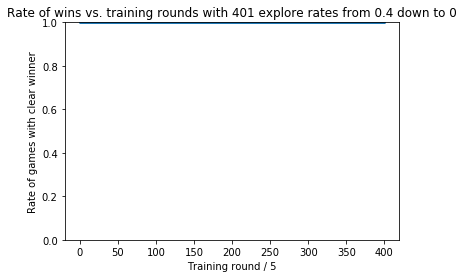

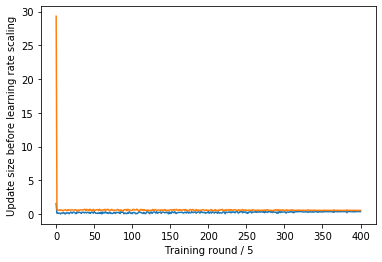

In [28]:
p1superlong44, p2superlong44 = makedynamic(5, 401, 0.5, rows=4, cols=4, movingalpha = True, stratnames='grav44', 
                                         aggover=5, numfilters=8, filtersize=3)
#p1grav34, p2grav34 = makedynamic(15000, 9, 0.4, rows=3, cols=4, winc=3, gmove=True, movingalpha=True, 
                               #stratnames="grav34")
# gmove is no longer necessary, our class takes care of that for us now.

In [13]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p1long4, human, numrows=4, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------
3  |   |   |   |   | 
---------------------

[0, 1, 2, 3]
1
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------
3  |   | x |   |   | 
---------------------

[0, 1, 2, 3]
Input your action col:2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------
3  |   | x | o |   | 
---------------------

[0, 1, 2, 3]
1
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   | x |   |   | 
---------------------
3  |   | x | o |   | 
---------------------

[0, 1, 2, 3]
Input your action col:1
   | 0 | 1 | 2 |

-1

Doesn't work so good. WMaybe use even more filters (like 16 of them)? Might be good to use board size worth of filters, since a larger board increases complexity by that much.

Test this with same number of training rounds.

0.00125





  0%|                                                                                          | 0/401 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  0%|▏                                                                               | 1/401 [00:27<3:06:11, 27.93s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  0%|▍                                                                               | 2/401 [00:52<2:59:08, 26.94s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  1%|▌                                                                               | 3/401 [01:14<2:49:01, 25.48s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  1%|▊                                                                               | 4/401 [01:31<2:31:06, 22.84s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  1%|▉                                                                               | 5/401 [01:50<2:22:41, 21.62s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  1%|█▏                                                                              | 6/401 [02:14<2:28:02, 22.49s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  2%|█▍                                                                              | 7/401 [02:34<2:23:10, 21.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  2%|█▌                                                                              | 8/401 [02:57<2:24:59, 22.14s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  2%|█▊                                                                              | 9/401 [03:16<2:18:14, 21.16s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  2%|█▉                                                                             | 10/401 [03:39<2:20:47, 21.61s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  3%|██▏                                                                            | 11/401 [04:01<2:22:05, 21.86s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  3%|██▎                                                                            | 12/401 [04:24<2:22:37, 22.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  3%|██▌                                                                            | 13/401 [04:55<2:41:32, 24.98s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  3%|██▊                                                                            | 14/401 [05:21<2:41:54, 25.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  4%|██▉                                                                            | 15/401 [05:49<2:47:17, 26.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  4%|███▏                                                                           | 16/401 [06:09<2:35:31, 24.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  4%|███▎                                                                           | 17/401 [06:28<2:24:25, 22.57s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  4%|███▌                                                                           | 18/401 [06:47<2:18:30, 21.70s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  5%|███▋                                                                           | 19/401 [07:04<2:09:02, 20.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  5%|███▉                                                                           | 20/401 [07:27<2:12:39, 20.89s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  5%|████▏                                                                          | 21/401 [07:45<2:07:11, 20.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  5%|████▎                                                                          | 22/401 [08:05<2:05:59, 19.95s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  6%|████▌                                                                          | 23/401 [08:23<2:02:02, 19.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  6%|████▋                                                                          | 24/401 [08:46<2:09:16, 20.57s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  6%|████▉                                                                          | 25/401 [09:07<2:09:23, 20.65s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  6%|█████                                                                          | 26/401 [09:31<2:16:33, 21.85s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  7%|█████▎                                                                         | 27/401 [10:04<2:35:50, 25.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  7%|█████▌                                                                         | 28/401 [10:27<2:33:02, 24.62s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  7%|█████▋                                                                         | 29/401 [11:01<2:50:07, 27.44s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  7%|█████▉                                                                         | 30/401 [11:25<2:43:00, 26.36s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  8%|██████                                                                         | 31/401 [11:48<2:35:10, 25.16s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  8%|██████▎                                                                        | 32/401 [12:08<2:24:54, 23.56s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  8%|██████▌                                                                        | 33/401 [12:30<2:22:02, 23.16s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  8%|██████▋                                                                        | 34/401 [12:54<2:23:48, 23.51s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  9%|██████▉                                                                        | 35/401 [13:14<2:16:56, 22.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  9%|███████                                                                        | 36/401 [13:34<2:12:13, 21.74s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  9%|███████▎                                                                       | 37/401 [13:56<2:12:38, 21.86s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  9%|███████▍                                                                       | 38/401 [14:16<2:08:10, 21.19s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 10%|███████▋                                                                       | 39/401 [14:44<2:19:46, 23.17s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 10%|███████▉                                                                       | 40/401 [15:03<2:12:44, 22.06s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 10%|████████                                                                       | 41/401 [15:23<2:08:48, 21.47s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 10%|████████▎                                                                      | 42/401 [15:44<2:07:55, 21.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 11%|████████▍                                                                      | 43/401 [16:12<2:18:34, 23.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 11%|████████▋                                                                      | 44/401 [16:36<2:18:52, 23.34s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 11%|████████▊                                                                      | 45/401 [16:57<2:15:12, 22.79s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 11%|█████████                                                                      | 46/401 [17:24<2:21:28, 23.91s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 12%|█████████▎                                                                     | 47/401 [17:46<2:18:52, 23.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 12%|█████████▍                                                                     | 48/401 [18:10<2:18:46, 23.59s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 12%|█████████▋                                                                     | 49/401 [18:31<2:14:12, 22.88s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 12%|█████████▊                                                                     | 50/401 [18:54<2:13:40, 22.85s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 13%|██████████                                                                     | 51/401 [19:14<2:07:34, 21.87s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 13%|██████████▏                                                                    | 52/401 [19:38<2:12:30, 22.78s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 13%|██████████▍                                                                    | 53/401 [19:56<2:03:40, 21.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 13%|██████████▋                                                                    | 54/401 [20:23<2:12:37, 22.93s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 14%|██████████▊                                                                    | 55/401 [20:49<2:17:12, 23.79s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 14%|███████████                                                                    | 56/401 [21:09<2:11:11, 22.81s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 14%|███████████▏                                                                   | 57/401 [21:32<2:11:07, 22.87s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 14%|███████████▍                                                                   | 58/401 [21:55<2:10:53, 22.90s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 15%|███████████▌                                                                   | 59/401 [22:16<2:07:08, 22.30s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 15%|███████████▊                                                                   | 60/401 [22:36<2:02:35, 21.57s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 15%|████████████                                                                   | 61/401 [23:02<2:10:19, 23.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 15%|████████████▏                                                                  | 62/401 [23:24<2:07:22, 22.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 16%|████████████▍                                                                  | 63/401 [23:44<2:03:24, 21.91s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 16%|████████████▌                                                                  | 64/401 [24:06<2:02:16, 21.77s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 16%|████████████▊                                                                  | 65/401 [24:27<2:00:35, 21.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 16%|█████████████                                                                  | 66/401 [24:55<2:11:48, 23.61s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 17%|█████████████▏                                                                 | 67/401 [25:23<2:18:19, 24.85s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 17%|█████████████▍                                                                 | 68/401 [25:50<2:22:02, 25.59s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 17%|█████████████▌                                                                 | 69/401 [26:17<2:23:00, 25.84s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 17%|█████████████▊                                                                 | 70/401 [26:45<2:27:13, 26.69s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 18%|█████████████▉                                                                 | 71/401 [27:12<2:26:55, 26.71s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 18%|██████████████▏                                                                | 72/401 [27:45<2:36:12, 28.49s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 18%|██████████████▍                                                                | 73/401 [28:14<2:37:36, 28.83s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 18%|██████████████▌                                                                | 74/401 [28:49<2:46:30, 30.55s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 19%|██████████████▊                                                                | 75/401 [29:15<2:39:03, 29.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 19%|██████████████▉                                                                | 76/401 [29:56<2:56:52, 32.65s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 19%|███████████████▏                                                               | 77/401 [30:21<2:44:06, 30.39s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 19%|███████████████▎                                                               | 78/401 [30:44<2:31:52, 28.21s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 20%|███████████████▌                                                               | 79/401 [31:14<2:34:03, 28.71s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 20%|███████████████▊                                                               | 80/401 [31:43<2:34:17, 28.84s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 20%|███████████████▉                                                               | 81/401 [32:11<2:32:53, 28.67s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 20%|████████████████▏                                                              | 82/401 [32:48<2:45:51, 31.20s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 21%|████████████████▎                                                              | 83/401 [33:26<2:55:19, 33.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 21%|████████████████▌                                                              | 84/401 [33:50<2:39:48, 30.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 21%|████████████████▋                                                              | 85/401 [34:20<2:38:59, 30.19s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 21%|████████████████▉                                                              | 86/401 [34:47<2:33:20, 29.21s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 22%|█████████████████▏                                                             | 87/401 [35:17<2:34:34, 29.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 22%|█████████████████▎                                                             | 88/401 [35:45<2:31:58, 29.13s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 22%|█████████████████▌                                                             | 89/401 [36:13<2:29:52, 28.82s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 22%|█████████████████▋                                                             | 90/401 [36:42<2:29:17, 28.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 23%|█████████████████▉                                                             | 91/401 [37:17<2:38:29, 30.68s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 23%|██████████████████                                                             | 92/401 [37:42<2:29:14, 28.98s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 23%|██████████████████▎                                                            | 93/401 [38:13<2:32:32, 29.71s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 23%|██████████████████▌                                                            | 94/401 [38:39<2:26:19, 28.60s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 24%|██████████████████▋                                                            | 95/401 [39:10<2:29:17, 29.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 24%|██████████████████▉                                                            | 96/401 [39:35<2:22:25, 28.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 24%|███████████████████                                                            | 97/401 [40:06<2:25:32, 28.73s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 24%|███████████████████▎                                                           | 98/401 [40:40<2:32:47, 30.26s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 25%|███████████████████▌                                                           | 99/401 [41:08<2:29:43, 29.75s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 25%|███████████████████▍                                                          | 100/401 [41:32<2:21:02, 28.11s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 25%|███████████████████▋                                                          | 101/401 [41:52<2:07:29, 25.50s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 25%|███████████████████▊                                                          | 102/401 [42:17<2:06:56, 25.47s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 26%|████████████████████                                                          | 103/401 [42:40<2:03:14, 24.81s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 26%|████████████████████▏                                                         | 104/401 [43:08<2:06:07, 25.48s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 26%|████████████████████▍                                                         | 105/401 [43:26<1:55:57, 23.51s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 26%|████████████████████▌                                                         | 106/401 [43:46<1:49:30, 22.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 27%|████████████████████▊                                                         | 107/401 [44:10<1:51:50, 22.83s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 27%|█████████████████████                                                         | 108/401 [44:28<1:44:06, 21.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 27%|█████████████████████▏                                                        | 109/401 [44:49<1:43:00, 21.17s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 27%|█████████████████████▍                                                        | 110/401 [45:13<1:48:01, 22.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 28%|█████████████████████▌                                                        | 111/401 [45:34<1:45:07, 21.75s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 28%|█████████████████████▊                                                        | 112/401 [45:52<1:38:44, 20.50s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 28%|█████████████████████▉                                                        | 113/401 [46:12<1:38:10, 20.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 28%|██████████████████████▏                                                       | 114/401 [46:30<1:33:52, 19.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 29%|██████████████████████▎                                                       | 115/401 [46:57<1:44:20, 21.89s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 29%|██████████████████████▌                                                       | 116/401 [47:19<1:44:16, 21.95s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 29%|██████████████████████▊                                                       | 117/401 [47:40<1:43:15, 21.81s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 29%|██████████████████████▉                                                       | 118/401 [48:02<1:42:15, 21.68s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 30%|███████████████████████▏                                                      | 119/401 [48:27<1:46:58, 22.76s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 30%|███████████████████████▎                                                      | 120/401 [48:50<1:46:42, 22.78s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 30%|███████████████████████▌                                                      | 121/401 [49:11<1:44:45, 22.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 30%|███████████████████████▋                                                      | 122/401 [49:34<1:44:03, 22.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 31%|███████████████████████▉                                                      | 123/401 [49:54<1:40:29, 21.69s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 31%|████████████████████████                                                      | 124/401 [50:14<1:38:28, 21.33s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 31%|████████████████████████▎                                                     | 125/401 [50:36<1:39:03, 21.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 31%|████████████████████████▌                                                     | 126/401 [50:58<1:39:02, 21.61s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 32%|████████████████████████▋                                                     | 127/401 [51:14<1:31:08, 19.96s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 32%|████████████████████████▉                                                     | 128/401 [51:32<1:27:15, 19.18s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 32%|█████████████████████████                                                     | 129/401 [51:54<1:31:46, 20.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 32%|█████████████████████████▎                                                    | 130/401 [52:16<1:33:48, 20.77s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 33%|█████████████████████████▍                                                    | 131/401 [52:38<1:35:11, 21.16s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 33%|█████████████████████████▋                                                    | 132/401 [53:06<1:43:46, 23.15s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 33%|█████████████████████████▊                                                    | 133/401 [53:26<1:39:02, 22.17s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 33%|██████████████████████████                                                    | 134/401 [53:49<1:39:42, 22.41s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 34%|██████████████████████████▎                                                   | 135/401 [54:17<1:46:25, 24.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 34%|██████████████████████████▍                                                   | 136/401 [54:41<1:45:51, 23.97s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 34%|██████████████████████████▋                                                   | 137/401 [55:00<1:39:23, 22.59s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 34%|██████████████████████████▊                                                   | 138/401 [55:18<1:33:05, 21.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 35%|███████████████████████████                                                   | 139/401 [55:36<1:28:22, 20.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 35%|███████████████████████████▏                                                  | 140/401 [55:55<1:26:39, 19.92s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 35%|███████████████████████████▍                                                  | 141/401 [56:17<1:28:36, 20.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 35%|███████████████████████████▌                                                  | 142/401 [56:41<1:33:08, 21.58s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 36%|███████████████████████████▊                                                  | 143/401 [57:00<1:29:23, 20.79s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 36%|████████████████████████████                                                  | 144/401 [57:21<1:28:59, 20.78s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 36%|████████████████████████████▏                                                 | 145/401 [57:44<1:31:32, 21.46s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 36%|████████████████████████████▍                                                 | 146/401 [58:10<1:37:49, 23.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 37%|████████████████████████████▌                                                 | 147/401 [58:32<1:35:21, 22.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 37%|████████████████████████████▊                                                 | 148/401 [58:49<1:28:41, 21.03s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 37%|████████████████████████████▉                                                 | 149/401 [59:14<1:32:26, 22.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 37%|█████████████████████████████▏                                                | 150/401 [59:35<1:30:57, 21.74s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 38%|█████████████████████████████▎                                                | 151/401 [59:54<1:26:58, 20.87s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 38%|████████████████████████████▊                                               | 152/401 [1:00:16<1:29:00, 21.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 38%|████████████████████████████▉                                               | 153/401 [1:00:39<1:29:52, 21.74s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 38%|█████████████████████████████▏                                              | 154/401 [1:01:06<1:36:43, 23.50s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 39%|█████████████████████████████▍                                              | 155/401 [1:01:25<1:30:11, 22.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 39%|█████████████████████████████▌                                              | 156/401 [1:01:46<1:28:33, 21.69s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 39%|█████████████████████████████▊                                              | 157/401 [1:02:04<1:24:10, 20.70s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 39%|█████████████████████████████▉                                              | 158/401 [1:02:24<1:22:55, 20.48s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 40%|██████████████████████████████▏                                             | 159/401 [1:02:48<1:26:32, 21.46s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 40%|██████████████████████████████▎                                             | 160/401 [1:03:10<1:26:52, 21.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 40%|██████████████████████████████▌                                             | 161/401 [1:03:30<1:24:19, 21.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 40%|██████████████████████████████▋                                             | 162/401 [1:03:50<1:22:27, 20.70s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 41%|██████████████████████████████▉                                             | 163/401 [1:04:16<1:28:43, 22.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 41%|███████████████████████████████                                             | 164/401 [1:04:38<1:28:16, 22.35s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 41%|███████████████████████████████▎                                            | 165/401 [1:05:00<1:27:35, 22.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 41%|███████████████████████████████▍                                            | 166/401 [1:05:20<1:24:31, 21.58s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 42%|███████████████████████████████▋                                            | 167/401 [1:05:41<1:23:16, 21.35s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 42%|███████████████████████████████▊                                            | 168/401 [1:05:59<1:19:01, 20.35s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 42%|████████████████████████████████                                            | 169/401 [1:06:16<1:14:51, 19.36s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 42%|████████████████████████████████▏                                           | 170/401 [1:06:31<1:09:20, 18.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 43%|████████████████████████████████▍                                           | 171/401 [1:06:46<1:06:08, 17.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 43%|████████████████████████████████▌                                           | 172/401 [1:07:01<1:02:32, 16.39s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 43%|████████████████████████████████▊                                           | 173/401 [1:07:19<1:04:15, 16.91s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 43%|████████████████████████████████▉                                           | 174/401 [1:07:35<1:03:14, 16.71s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 44%|█████████████████████████████████▏                                          | 175/401 [1:07:54<1:04:57, 17.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 44%|█████████████████████████████████▎                                          | 176/401 [1:08:15<1:08:54, 18.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 44%|█████████████████████████████████▌                                          | 177/401 [1:08:33<1:08:34, 18.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 44%|█████████████████████████████████▋                                          | 178/401 [1:08:57<1:14:52, 20.15s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 45%|█████████████████████████████████▉                                          | 179/401 [1:09:14<1:10:29, 19.05s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 45%|██████████████████████████████████                                          | 180/401 [1:09:36<1:13:16, 19.89s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 45%|██████████████████████████████████▎                                         | 181/401 [1:09:56<1:13:35, 20.07s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 45%|██████████████████████████████████▍                                         | 182/401 [1:10:15<1:12:09, 19.77s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 46%|██████████████████████████████████▋                                         | 183/401 [1:10:36<1:13:05, 20.12s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 46%|██████████████████████████████████▊                                         | 184/401 [1:10:59<1:15:26, 20.86s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 46%|███████████████████████████████████                                         | 185/401 [1:11:21<1:16:36, 21.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 46%|███████████████████████████████████▎                                        | 186/401 [1:11:46<1:20:10, 22.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 47%|███████████████████████████████████▍                                        | 187/401 [1:12:09<1:20:12, 22.49s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 47%|███████████████████████████████████▋                                        | 188/401 [1:12:28<1:16:03, 21.43s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 47%|███████████████████████████████████▊                                        | 189/401 [1:12:50<1:16:15, 21.58s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 47%|████████████████████████████████████                                        | 190/401 [1:13:10<1:14:09, 21.09s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 48%|████████████████████████████████████▏                                       | 191/401 [1:13:28<1:11:20, 20.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 48%|████████████████████████████████████▍                                       | 192/401 [1:13:47<1:09:32, 19.96s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 48%|████████████████████████████████████▌                                       | 193/401 [1:14:08<1:09:37, 20.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 48%|████████████████████████████████████▊                                       | 194/401 [1:14:28<1:09:58, 20.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 49%|████████████████████████████████████▉                                       | 195/401 [1:14:49<1:09:56, 20.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 49%|█████████████████████████████████████▏                                      | 196/401 [1:15:10<1:10:28, 20.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 49%|█████████████████████████████████████▎                                      | 197/401 [1:15:32<1:11:23, 21.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 49%|█████████████████████████████████████▌                                      | 198/401 [1:15:51<1:09:20, 20.50s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 50%|█████████████████████████████████████▋                                      | 199/401 [1:16:14<1:11:22, 21.20s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 50%|█████████████████████████████████████▉                                      | 200/401 [1:16:35<1:10:57, 21.18s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 50%|██████████████████████████████████████                                      | 201/401 [1:16:59<1:13:30, 22.05s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 50%|██████████████████████████████████████▎                                     | 202/401 [1:17:27<1:18:55, 23.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 51%|██████████████████████████████████████▍                                     | 203/401 [1:17:51<1:18:22, 23.75s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 51%|██████████████████████████████████████▋                                     | 204/401 [1:18:12<1:15:19, 22.94s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 51%|██████████████████████████████████████▊                                     | 205/401 [1:18:32<1:11:59, 22.04s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 51%|███████████████████████████████████████                                     | 206/401 [1:18:51<1:08:20, 21.03s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 52%|███████████████████████████████████████▏                                    | 207/401 [1:19:10<1:06:34, 20.59s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 52%|███████████████████████████████████████▍                                    | 208/401 [1:19:28<1:03:07, 19.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 52%|███████████████████████████████████████▌                                    | 209/401 [1:19:51<1:06:01, 20.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 52%|███████████████████████████████████████▊                                    | 210/401 [1:20:13<1:07:26, 21.19s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 53%|███████████████████████████████████████▉                                    | 211/401 [1:20:31<1:04:20, 20.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 53%|████████████████████████████████████████▏                                   | 212/401 [1:20:52<1:04:08, 20.36s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 53%|█████████████████████████████████████████▍                                    | 213/401 [1:21:08<59:58, 19.14s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 53%|████████████████████████████████████████▌                                   | 214/401 [1:21:28<1:00:06, 19.29s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 54%|████████████████████████████████████████▋                                   | 215/401 [1:21:49<1:01:47, 19.93s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 54%|████████████████████████████████████████▉                                   | 216/401 [1:22:15<1:07:10, 21.79s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 54%|█████████████████████████████████████████▏                                  | 217/401 [1:22:36<1:05:58, 21.51s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 54%|█████████████████████████████████████████▎                                  | 218/401 [1:22:57<1:05:16, 21.40s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 55%|█████████████████████████████████████████▌                                  | 219/401 [1:23:23<1:08:29, 22.58s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 55%|█████████████████████████████████████████▋                                  | 220/401 [1:23:44<1:06:39, 22.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 55%|█████████████████████████████████████████▉                                  | 221/401 [1:24:04<1:05:04, 21.69s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 55%|██████████████████████████████████████████                                  | 222/401 [1:24:24<1:02:59, 21.11s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 56%|██████████████████████████████████████████▎                                 | 223/401 [1:24:43<1:00:33, 20.41s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 56%|███████████████████████████████████████████▌                                  | 224/401 [1:25:01<58:20, 19.78s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 56%|███████████████████████████████████████████▊                                  | 225/401 [1:25:22<58:45, 20.03s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 56%|███████████████████████████████████████████▉                                  | 226/401 [1:25:42<58:49, 20.17s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 57%|████████████████████████████████████████████▏                                 | 227/401 [1:25:59<55:19, 19.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 57%|████████████████████████████████████████████▎                                 | 228/401 [1:26:20<57:05, 19.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 57%|███████████████████████████████████████████▍                                | 229/401 [1:26:44<1:00:33, 21.13s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 57%|████████████████████████████████████████████▋                                 | 230/401 [1:27:04<59:08, 20.75s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 58%|████████████████████████████████████████████▉                                 | 231/401 [1:27:24<57:53, 20.43s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 58%|█████████████████████████████████████████████▏                                | 232/401 [1:27:43<56:09, 19.94s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 58%|████████████████████████████████████████████▏                               | 233/401 [1:28:09<1:00:44, 21.69s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 58%|█████████████████████████████████████████████▌                                | 234/401 [1:28:28<58:11, 20.91s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 59%|█████████████████████████████████████████████▋                                | 235/401 [1:28:45<55:00, 19.89s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 59%|█████████████████████████████████████████████▉                                | 236/401 [1:29:03<52:42, 19.17s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 59%|██████████████████████████████████████████████                                | 237/401 [1:29:20<51:05, 18.69s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 59%|██████████████████████████████████████████████▎                               | 238/401 [1:29:44<54:37, 20.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 60%|██████████████████████████████████████████████▍                               | 239/401 [1:30:06<55:50, 20.68s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 60%|██████████████████████████████████████████████▋                               | 240/401 [1:30:22<51:42, 19.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 60%|██████████████████████████████████████████████▉                               | 241/401 [1:30:40<50:18, 18.87s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 60%|███████████████████████████████████████████████                               | 242/401 [1:31:01<52:18, 19.74s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 61%|███████████████████████████████████████████████▎                              | 243/401 [1:31:28<57:20, 21.77s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 61%|███████████████████████████████████████████████▍                              | 244/401 [1:31:49<56:13, 21.48s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 61%|███████████████████████████████████████████████▋                              | 245/401 [1:32:11<56:19, 21.67s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 61%|███████████████████████████████████████████████▊                              | 246/401 [1:32:33<56:16, 21.79s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 62%|████████████████████████████████████████████████                              | 247/401 [1:32:56<56:41, 22.09s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 62%|████████████████████████████████████████████████▏                             | 248/401 [1:33:14<53:45, 21.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 62%|████████████████████████████████████████████████▍                             | 249/401 [1:33:31<50:04, 19.77s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 62%|████████████████████████████████████████████████▋                             | 250/401 [1:33:51<49:42, 19.75s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 63%|████████████████████████████████████████████████▊                             | 251/401 [1:34:10<49:02, 19.62s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 63%|█████████████████████████████████████████████████                             | 252/401 [1:34:31<49:25, 19.90s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 63%|█████████████████████████████████████████████████▏                            | 253/401 [1:34:53<51:15, 20.78s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 63%|█████████████████████████████████████████████████▍                            | 254/401 [1:35:13<49:58, 20.40s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 64%|█████████████████████████████████████████████████▌                            | 255/401 [1:35:32<48:52, 20.09s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 64%|█████████████████████████████████████████████████▊                            | 256/401 [1:35:50<46:50, 19.39s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 64%|█████████████████████████████████████████████████▉                            | 257/401 [1:36:10<47:06, 19.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 64%|██████████████████████████████████████████████████▏                           | 258/401 [1:36:33<48:52, 20.51s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 65%|██████████████████████████████████████████████████▍                           | 259/401 [1:36:52<47:29, 20.07s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 65%|██████████████████████████████████████████████████▌                           | 260/401 [1:37:11<46:20, 19.72s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 65%|██████████████████████████████████████████████████▊                           | 261/401 [1:37:29<44:37, 19.13s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 65%|██████████████████████████████████████████████████▉                           | 262/401 [1:37:47<44:10, 19.07s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 66%|███████████████████████████████████████████████████▏                          | 263/401 [1:38:08<44:34, 19.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 66%|███████████████████████████████████████████████████▎                          | 264/401 [1:38:29<45:38, 19.99s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 66%|███████████████████████████████████████████████████▌                          | 265/401 [1:38:51<46:42, 20.60s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 66%|███████████████████████████████████████████████████▋                          | 266/401 [1:39:08<44:10, 19.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 67%|███████████████████████████████████████████████████▉                          | 267/401 [1:39:27<43:23, 19.43s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 67%|████████████████████████████████████████████████████▏                         | 268/401 [1:39:46<42:37, 19.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 67%|████████████████████████████████████████████████████▎                         | 269/401 [1:40:03<40:43, 18.51s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 67%|████████████████████████████████████████████████████▌                         | 270/401 [1:40:24<42:07, 19.29s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 68%|████████████████████████████████████████████████████▋                         | 271/401 [1:40:45<42:47, 19.75s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 68%|████████████████████████████████████████████████████▉                         | 272/401 [1:41:05<42:25, 19.73s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 68%|█████████████████████████████████████████████████████                         | 273/401 [1:41:27<44:01, 20.64s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 68%|█████████████████████████████████████████████████████▎                        | 274/401 [1:41:48<43:45, 20.68s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 69%|█████████████████████████████████████████████████████▍                        | 275/401 [1:42:07<42:09, 20.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 69%|█████████████████████████████████████████████████████▋                        | 276/401 [1:42:29<43:07, 20.70s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 69%|█████████████████████████████████████████████████████▉                        | 277/401 [1:42:49<42:17, 20.47s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 69%|██████████████████████████████████████████████████████                        | 278/401 [1:43:08<41:21, 20.17s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 70%|██████████████████████████████████████████████████████▎                       | 279/401 [1:43:25<38:42, 19.04s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 70%|██████████████████████████████████████████████████████▍                       | 280/401 [1:43:46<39:39, 19.66s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 70%|██████████████████████████████████████████████████████▋                       | 281/401 [1:44:05<39:18, 19.65s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 70%|██████████████████████████████████████████████████████▊                       | 282/401 [1:44:26<39:33, 19.94s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 71%|███████████████████████████████████████████████████████                       | 283/401 [1:44:46<39:21, 20.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 71%|███████████████████████████████████████████████████████▏                      | 284/401 [1:45:08<39:51, 20.44s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 71%|███████████████████████████████████████████████████████▍                      | 285/401 [1:45:41<46:41, 24.15s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 71%|███████████████████████████████████████████████████████▋                      | 286/401 [1:46:19<54:34, 28.47s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 72%|███████████████████████████████████████████████████████▊                      | 287/401 [1:46:44<52:14, 27.50s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 72%|████████████████████████████████████████████████████████                      | 288/401 [1:47:07<49:15, 26.15s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 72%|████████████████████████████████████████████████████████▏                     | 289/401 [1:47:30<47:00, 25.18s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 72%|████████████████████████████████████████████████████████▍                     | 290/401 [1:47:49<43:01, 23.26s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 73%|████████████████████████████████████████████████████████▌                     | 291/401 [1:48:10<41:33, 22.67s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 73%|████████████████████████████████████████████████████████▊                     | 292/401 [1:48:31<39:58, 22.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 73%|████████████████████████████████████████████████████████▉                     | 293/401 [1:48:48<37:16, 20.71s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 73%|█████████████████████████████████████████████████████████▏                    | 294/401 [1:49:07<35:38, 19.99s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 74%|█████████████████████████████████████████████████████████▍                    | 295/401 [1:49:25<34:25, 19.48s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 74%|█████████████████████████████████████████████████████████▌                    | 296/401 [1:49:44<33:55, 19.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 74%|█████████████████████████████████████████████████████████▊                    | 297/401 [1:50:04<34:00, 19.62s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 74%|█████████████████████████████████████████████████████████▉                    | 298/401 [1:50:24<33:48, 19.69s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 75%|██████████████████████████████████████████████████████████▏                   | 299/401 [1:50:43<33:13, 19.55s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 75%|██████████████████████████████████████████████████████████▎                   | 300/401 [1:51:02<32:09, 19.11s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 75%|██████████████████████████████████████████████████████████▌                   | 301/401 [1:51:22<32:27, 19.48s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 75%|██████████████████████████████████████████████████████████▋                   | 302/401 [1:51:43<32:52, 19.93s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 76%|██████████████████████████████████████████████████████████▉                   | 303/401 [1:52:02<32:12, 19.72s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 76%|███████████████████████████████████████████████████████████▏                  | 304/401 [1:52:23<32:15, 19.96s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 76%|███████████████████████████████████████████████████████████▎                  | 305/401 [1:52:48<34:27, 21.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 76%|███████████████████████████████████████████████████████████▌                  | 306/401 [1:53:09<34:01, 21.49s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 77%|███████████████████████████████████████████████████████████▋                  | 307/401 [1:53:28<32:17, 20.61s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 77%|███████████████████████████████████████████████████████████▉                  | 308/401 [1:53:49<32:08, 20.74s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 77%|████████████████████████████████████████████████████████████                  | 309/401 [1:54:08<31:13, 20.36s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 77%|████████████████████████████████████████████████████████████▎                 | 310/401 [1:54:26<29:46, 19.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 78%|████████████████████████████████████████████████████████████▍                 | 311/401 [1:54:46<29:17, 19.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 78%|████████████████████████████████████████████████████████████▋                 | 312/401 [1:55:02<27:32, 18.56s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 78%|████████████████████████████████████████████████████████████▉                 | 313/401 [1:55:20<26:59, 18.40s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 78%|█████████████████████████████████████████████████████████████                 | 314/401 [1:55:38<26:29, 18.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 79%|█████████████████████████████████████████████████████████████▎                | 315/401 [1:55:56<26:20, 18.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 79%|█████████████████████████████████████████████████████████████▍                | 316/401 [1:56:15<26:03, 18.39s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 79%|█████████████████████████████████████████████████████████████▋                | 317/401 [1:56:33<25:38, 18.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 79%|█████████████████████████████████████████████████████████████▊                | 318/401 [1:56:53<26:07, 18.88s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 80%|██████████████████████████████████████████████████████████████                | 319/401 [1:57:11<25:09, 18.41s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 80%|██████████████████████████████████████████████████████████████▏               | 320/401 [1:57:26<23:42, 17.57s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 80%|██████████████████████████████████████████████████████████████▍               | 321/401 [1:57:45<24:04, 18.06s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 80%|██████████████████████████████████████████████████████████████▋               | 322/401 [1:58:05<24:13, 18.40s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 81%|██████████████████████████████████████████████████████████████▊               | 323/401 [1:58:25<24:33, 18.89s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 81%|███████████████████████████████████████████████████████████████               | 324/401 [1:58:44<24:29, 19.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 81%|███████████████████████████████████████████████████████████████▏              | 325/401 [1:59:07<25:38, 20.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 81%|███████████████████████████████████████████████████████████████▍              | 326/401 [1:59:25<24:26, 19.56s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 82%|███████████████████████████████████████████████████████████████▌              | 327/401 [1:59:46<24:32, 19.91s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 82%|███████████████████████████████████████████████████████████████▊              | 328/401 [2:00:05<23:51, 19.60s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 82%|███████████████████████████████████████████████████████████████▉              | 329/401 [2:00:22<22:45, 18.97s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 82%|████████████████████████████████████████████████████████████████▏             | 330/401 [2:00:41<22:32, 19.04s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 83%|████████████████████████████████████████████████████████████████▍             | 331/401 [2:01:01<22:22, 19.17s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 83%|████████████████████████████████████████████████████████████████▌             | 332/401 [2:01:21<22:33, 19.61s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 83%|████████████████████████████████████████████████████████████████▊             | 333/401 [2:01:38<21:19, 18.82s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 83%|████████████████████████████████████████████████████████████████▉             | 334/401 [2:01:59<21:31, 19.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 84%|█████████████████████████████████████████████████████████████████▏            | 335/401 [2:02:20<21:52, 19.89s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 84%|█████████████████████████████████████████████████████████████████▎            | 336/401 [2:02:43<22:40, 20.93s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 84%|█████████████████████████████████████████████████████████████████▌            | 337/401 [2:03:01<21:06, 19.79s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 84%|█████████████████████████████████████████████████████████████████▋            | 338/401 [2:03:19<20:30, 19.52s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 85%|█████████████████████████████████████████████████████████████████▉            | 339/401 [2:03:41<20:55, 20.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 85%|██████████████████████████████████████████████████████████████████▏           | 340/401 [2:03:59<19:46, 19.46s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 85%|██████████████████████████████████████████████████████████████████▎           | 341/401 [2:04:18<19:11, 19.20s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 85%|██████████████████████████████████████████████████████████████████▌           | 342/401 [2:04:40<19:56, 20.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 86%|██████████████████████████████████████████████████████████████████▋           | 343/401 [2:05:00<19:32, 20.21s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 86%|██████████████████████████████████████████████████████████████████▉           | 344/401 [2:05:19<18:45, 19.74s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 86%|███████████████████████████████████████████████████████████████████           | 345/401 [2:05:39<18:19, 19.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 86%|███████████████████████████████████████████████████████████████████▎          | 346/401 [2:05:57<17:40, 19.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 87%|███████████████████████████████████████████████████████████████████▍          | 347/401 [2:06:15<16:55, 18.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 87%|███████████████████████████████████████████████████████████████████▋          | 348/401 [2:06:32<16:10, 18.30s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 87%|███████████████████████████████████████████████████████████████████▉          | 349/401 [2:06:52<16:21, 18.88s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 87%|████████████████████████████████████████████████████████████████████          | 350/401 [2:07:09<15:30, 18.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 88%|████████████████████████████████████████████████████████████████████▎         | 351/401 [2:07:26<14:49, 17.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 88%|████████████████████████████████████████████████████████████████████▍         | 352/401 [2:07:43<14:29, 17.75s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 88%|████████████████████████████████████████████████████████████████████▋         | 353/401 [2:08:04<14:52, 18.59s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 88%|████████████████████████████████████████████████████████████████████▊         | 354/401 [2:08:21<14:16, 18.21s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 89%|█████████████████████████████████████████████████████████████████████         | 355/401 [2:08:41<14:24, 18.79s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 89%|█████████████████████████████████████████████████████████████████████▏        | 356/401 [2:09:01<14:15, 19.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 89%|█████████████████████████████████████████████████████████████████████▍        | 357/401 [2:09:19<13:52, 18.91s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 89%|█████████████████████████████████████████████████████████████████████▋        | 358/401 [2:09:41<14:09, 19.75s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 90%|█████████████████████████████████████████████████████████████████████▊        | 359/401 [2:10:00<13:43, 19.61s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 90%|██████████████████████████████████████████████████████████████████████        | 360/401 [2:10:19<13:17, 19.44s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 90%|██████████████████████████████████████████████████████████████████████▏       | 361/401 [2:10:40<13:06, 19.67s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 90%|██████████████████████████████████████████████████████████████████████▍       | 362/401 [2:10:57<12:18, 18.93s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 91%|██████████████████████████████████████████████████████████████████████▌       | 363/401 [2:11:16<12:00, 18.97s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 91%|██████████████████████████████████████████████████████████████████████▊       | 364/401 [2:11:35<11:47, 19.12s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 91%|██████████████████████████████████████████████████████████████████████▉       | 365/401 [2:11:56<11:39, 19.42s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 91%|███████████████████████████████████████████████████████████████████████▏      | 366/401 [2:12:14<11:12, 19.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 92%|███████████████████████████████████████████████████████████████████████▍      | 367/401 [2:12:36<11:16, 19.88s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 92%|███████████████████████████████████████████████████████████████████████▌      | 368/401 [2:13:00<11:35, 21.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 92%|███████████████████████████████████████████████████████████████████████▊      | 369/401 [2:13:21<11:19, 21.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 92%|███████████████████████████████████████████████████████████████████████▉      | 370/401 [2:13:40<10:38, 20.59s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 93%|████████████████████████████████████████████████████████████████████████▏     | 371/401 [2:13:59<10:00, 20.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 93%|████████████████████████████████████████████████████████████████████████▎     | 372/401 [2:14:17<09:23, 19.41s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 93%|████████████████████████████████████████████████████████████████████████▌     | 373/401 [2:14:35<08:48, 18.86s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 93%|████████████████████████████████████████████████████████████████████████▋     | 374/401 [2:14:52<08:16, 18.40s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 94%|████████████████████████████████████████████████████████████████████████▉     | 375/401 [2:15:10<07:57, 18.35s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 94%|█████████████████████████████████████████████████████████████████████████▏    | 376/401 [2:15:29<07:43, 18.55s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 94%|█████████████████████████████████████████████████████████████████████████▎    | 377/401 [2:15:46<07:15, 18.14s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 94%|█████████████████████████████████████████████████████████████████████████▌    | 378/401 [2:16:05<06:59, 18.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 95%|█████████████████████████████████████████████████████████████████████████▋    | 379/401 [2:16:25<06:56, 18.95s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 95%|█████████████████████████████████████████████████████████████████████████▉    | 380/401 [2:16:45<06:44, 19.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 95%|██████████████████████████████████████████████████████████████████████████    | 381/401 [2:17:04<06:20, 19.05s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 95%|██████████████████████████████████████████████████████████████████████████▎   | 382/401 [2:17:23<06:01, 19.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 96%|██████████████████████████████████████████████████████████████████████████▍   | 383/401 [2:17:42<05:42, 19.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 96%|██████████████████████████████████████████████████████████████████████████▋   | 384/401 [2:18:00<05:16, 18.62s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 96%|██████████████████████████████████████████████████████████████████████████▉   | 385/401 [2:18:18<04:59, 18.70s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 96%|███████████████████████████████████████████████████████████████████████████   | 386/401 [2:18:37<04:39, 18.64s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 97%|███████████████████████████████████████████████████████████████████████████▎  | 387/401 [2:18:57<04:26, 19.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 97%|███████████████████████████████████████████████████████████████████████████▍  | 388/401 [2:19:16<04:05, 18.92s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 97%|███████████████████████████████████████████████████████████████████████████▋  | 389/401 [2:19:36<03:52, 19.35s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 97%|███████████████████████████████████████████████████████████████████████████▊  | 390/401 [2:19:56<03:35, 19.55s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 98%|████████████████████████████████████████████████████████████████████████████  | 391/401 [2:20:14<03:12, 19.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 98%|████████████████████████████████████████████████████████████████████████████▏ | 392/401 [2:20:33<02:52, 19.16s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 98%|████████████████████████████████████████████████████████████████████████████▍ | 393/401 [2:20:54<02:36, 19.51s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 98%|████████████████████████████████████████████████████████████████████████████▋ | 394/401 [2:21:13<02:15, 19.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 99%|████████████████████████████████████████████████████████████████████████████▊ | 395/401 [2:21:32<01:55, 19.31s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 99%|█████████████████████████████████████████████████████████████████████████████ | 396/401 [2:21:50<01:34, 18.96s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 99%|█████████████████████████████████████████████████████████████████████████████▏| 397/401 [2:22:09<01:15, 18.99s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 99%|█████████████████████████████████████████████████████████████████████████████▍| 398/401 [2:22:28<00:57, 19.03s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





100%|█████████████████████████████████████████████████████████████████████████████▌| 399/401 [2:22:48<00:38, 19.30s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





100%|█████████████████████████████████████████████████████████████████████████████▊| 400/401 [2:23:07<00:19, 19.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





100%|██████████████████████████████████████████████████████████████████████████████| 401/401 [2:23:27<00:00, 21.46s/it]


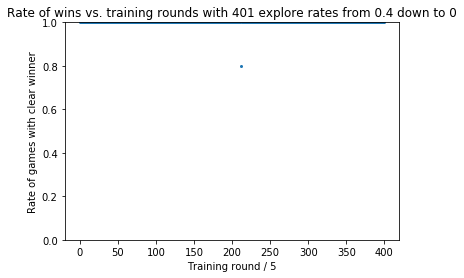

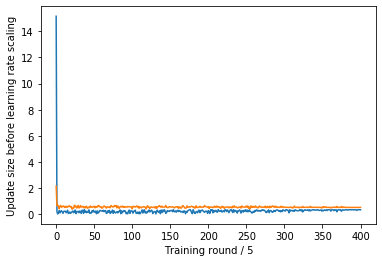

In [29]:
p1superlong4416filt, p2superlong4416filt = makedynamic(5, 401, 0.5, rows=4, cols=4, movingalpha = True, stratnames='grav44', 
                                         aggover=5, numfilters=16, filtersize=3)
#p1grav34, p2grav34 = makedynamic(15000, 9, 0.4, rows=3, cols=4, winc=3, gmove=True, movingalpha=True, 
                               #stratnames="grav34")
# gmove is no longer necessary, our class takes care of that for us now.

0.00125





  0%|                                                                                          | 0/401 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  0%|▏                                                                               | 1/401 [00:31<3:32:22, 31.86s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  0%|▍                                                                               | 2/401 [00:52<3:08:51, 28.40s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  1%|▌                                                                               | 3/401 [01:13<2:55:14, 26.42s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  1%|▊                                                                               | 4/401 [01:35<2:44:35, 24.88s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  1%|▉                                                                               | 5/401 [02:05<2:54:00, 26.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  1%|█▏                                                                              | 6/401 [02:31<2:54:34, 26.52s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  2%|█▍                                                                              | 7/401 [02:56<2:49:23, 25.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  2%|█▌                                                                              | 8/401 [03:26<2:57:21, 27.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  2%|█▊                                                                              | 9/401 [03:47<2:46:27, 25.48s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  2%|█▉                                                                             | 10/401 [04:11<2:43:02, 25.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  3%|██▏                                                                            | 11/401 [04:31<2:31:54, 23.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  3%|██▎                                                                            | 12/401 [04:49<2:21:15, 21.79s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  3%|██▌                                                                            | 13/401 [05:12<2:22:25, 22.03s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  3%|██▊                                                                            | 14/401 [05:29<2:13:19, 20.67s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  4%|██▉                                                                            | 15/401 [05:48<2:10:34, 20.30s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  4%|███▏                                                                           | 16/401 [06:11<2:15:25, 21.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  4%|███▎                                                                           | 17/401 [06:33<2:15:40, 21.20s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  4%|███▌                                                                           | 18/401 [06:55<2:16:09, 21.33s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  5%|███▋                                                                           | 19/401 [07:14<2:13:11, 20.92s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  5%|███▉                                                                           | 20/401 [07:34<2:10:31, 20.56s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  5%|████▏                                                                          | 21/401 [08:00<2:19:29, 22.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  5%|████▎                                                                          | 22/401 [08:24<2:24:09, 22.82s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  6%|████▌                                                                          | 23/401 [08:46<2:21:13, 22.42s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  6%|████▋                                                                          | 24/401 [09:06<2:16:34, 21.74s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  6%|████▉                                                                          | 25/401 [09:27<2:14:59, 21.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  6%|█████                                                                          | 26/401 [09:52<2:21:57, 22.71s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  7%|█████▎                                                                         | 27/401 [10:23<2:35:16, 24.91s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  7%|█████▌                                                                         | 28/401 [10:48<2:36:30, 25.17s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  7%|█████▋                                                                         | 29/401 [11:12<2:33:30, 24.76s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  7%|█████▉                                                                         | 30/401 [11:32<2:24:02, 23.30s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  8%|██████                                                                         | 31/401 [11:54<2:21:17, 22.91s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  8%|██████▎                                                                        | 32/401 [12:09<2:06:14, 20.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  8%|██████▌                                                                        | 33/401 [12:32<2:09:43, 21.15s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  8%|██████▋                                                                        | 34/401 [12:53<2:09:56, 21.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  9%|██████▉                                                                        | 35/401 [13:15<2:10:18, 21.36s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  9%|███████                                                                        | 36/401 [13:35<2:07:29, 20.96s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  9%|███████▎                                                                       | 37/401 [13:52<2:01:17, 19.99s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





  9%|███████▍                                                                       | 38/401 [14:11<1:59:07, 19.69s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 10%|███████▋                                                                       | 39/401 [14:28<1:53:00, 18.73s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 10%|███████▉                                                                       | 40/401 [14:49<1:57:08, 19.47s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 10%|████████                                                                       | 41/401 [15:13<2:05:08, 20.86s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 10%|████████▎                                                                      | 42/401 [15:34<2:04:47, 20.86s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 11%|████████▍                                                                      | 43/401 [15:55<2:05:11, 20.98s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 11%|████████▋                                                                      | 44/401 [16:17<2:06:05, 21.19s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 11%|████████▊                                                                      | 45/401 [16:38<2:06:10, 21.26s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 11%|█████████                                                                      | 46/401 [17:00<2:05:36, 21.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 12%|█████████▎                                                                     | 47/401 [17:24<2:10:13, 22.07s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 12%|█████████▍                                                                     | 48/401 [17:47<2:12:34, 22.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 12%|█████████▋                                                                     | 49/401 [18:11<2:14:32, 22.93s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 12%|█████████▊                                                                     | 50/401 [18:29<2:05:04, 21.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 13%|██████████                                                                     | 51/401 [18:51<2:06:02, 21.61s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 13%|██████████▏                                                                    | 52/401 [19:08<1:57:51, 20.26s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 13%|██████████▍                                                                    | 53/401 [19:29<1:58:43, 20.47s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 13%|██████████▋                                                                    | 54/401 [19:52<2:02:55, 21.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 14%|██████████▊                                                                    | 55/401 [20:14<2:03:16, 21.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 14%|███████████                                                                    | 56/401 [20:34<2:00:43, 21.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 14%|███████████▏                                                                   | 57/401 [20:54<1:59:16, 20.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 14%|███████████▍                                                                   | 58/401 [21:15<1:59:24, 20.89s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 15%|███████████▌                                                                   | 59/401 [21:32<1:51:24, 19.55s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 15%|███████████▊                                                                   | 60/401 [21:57<2:00:02, 21.12s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 15%|████████████                                                                   | 61/401 [22:14<1:53:46, 20.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 15%|████████████▏                                                                  | 62/401 [22:39<2:01:09, 21.44s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 16%|████████████▍                                                                  | 63/401 [23:01<2:01:54, 21.64s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 16%|████████████▌                                                                  | 64/401 [23:31<2:16:31, 24.31s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 16%|████████████▊                                                                  | 65/401 [23:53<2:11:58, 23.57s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 16%|█████████████                                                                  | 66/401 [24:16<2:10:38, 23.40s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 17%|█████████████▏                                                                 | 67/401 [24:37<2:06:13, 22.68s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 17%|█████████████▍                                                                 | 68/401 [24:59<2:04:36, 22.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 17%|█████████████▌                                                                 | 69/401 [25:21<2:02:27, 22.13s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 17%|█████████████▊                                                                 | 70/401 [25:40<1:57:57, 21.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 18%|█████████████▉                                                                 | 71/401 [25:59<1:53:27, 20.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 18%|██████████████▏                                                                | 72/401 [26:22<1:57:02, 21.35s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 18%|██████████████▍                                                                | 73/401 [26:39<1:48:45, 19.89s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 18%|██████████████▌                                                                | 74/401 [26:59<1:49:35, 20.11s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 19%|██████████████▊                                                                | 75/401 [27:18<1:47:19, 19.75s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 19%|██████████████▉                                                                | 76/401 [27:41<1:52:39, 20.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 19%|███████████████▏                                                               | 77/401 [28:03<1:53:47, 21.07s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 19%|███████████████▎                                                               | 78/401 [28:23<1:52:09, 20.83s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 20%|███████████████▌                                                               | 79/401 [28:46<1:54:38, 21.36s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 20%|███████████████▊                                                               | 80/401 [29:14<2:05:33, 23.47s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 20%|███████████████▉                                                               | 81/401 [29:35<2:01:05, 22.71s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 20%|████████████████▏                                                              | 82/401 [29:55<1:56:23, 21.89s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 21%|████████████████▎                                                              | 83/401 [30:18<1:56:55, 22.06s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 21%|████████████████▌                                                              | 84/401 [30:37<1:52:24, 21.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 21%|████████████████▋                                                              | 85/401 [31:11<2:11:50, 25.03s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 21%|████████████████▉                                                              | 86/401 [31:37<2:13:40, 25.46s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 22%|█████████████████▏                                                             | 87/401 [31:59<2:07:41, 24.40s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 22%|█████████████████▎                                                             | 88/401 [32:24<2:08:14, 24.58s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 22%|█████████████████▌                                                             | 89/401 [32:45<2:02:17, 23.52s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 22%|█████████████████▋                                                             | 90/401 [33:06<1:57:16, 22.62s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 23%|█████████████████▉                                                             | 91/401 [33:24<1:50:04, 21.30s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 23%|██████████████████                                                             | 92/401 [33:44<1:48:01, 20.98s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 23%|██████████████████▎                                                            | 93/401 [34:10<1:54:36, 22.33s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 23%|██████████████████▌                                                            | 94/401 [34:25<1:43:50, 20.29s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 24%|██████████████████▋                                                            | 95/401 [34:41<1:36:52, 18.99s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 24%|██████████████████▉                                                            | 96/401 [35:00<1:35:33, 18.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 24%|███████████████████                                                            | 97/401 [35:20<1:37:29, 19.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 24%|███████████████████▎                                                           | 98/401 [35:43<1:42:32, 20.31s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 25%|███████████████████▌                                                           | 99/401 [36:07<1:47:46, 21.41s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 25%|███████████████████▍                                                          | 100/401 [36:25<1:42:59, 20.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 25%|███████████████████▋                                                          | 101/401 [36:45<1:40:59, 20.20s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 25%|███████████████████▊                                                          | 102/401 [37:05<1:40:41, 20.21s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 26%|████████████████████                                                          | 103/401 [37:25<1:40:35, 20.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 26%|████████████████████▏                                                         | 104/401 [37:44<1:38:15, 19.85s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 26%|████████████████████▍                                                         | 105/401 [38:02<1:35:12, 19.30s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 26%|████████████████████▌                                                         | 106/401 [38:28<1:45:07, 21.38s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 27%|████████████████████▊                                                         | 107/401 [38:47<1:41:14, 20.66s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 27%|█████████████████████                                                         | 108/401 [39:11<1:45:48, 21.67s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 27%|█████████████████████▏                                                        | 109/401 [39:30<1:41:12, 20.80s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 27%|█████████████████████▍                                                        | 110/401 [39:53<1:44:12, 21.49s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 28%|█████████████████████▌                                                        | 111/401 [40:13<1:40:45, 20.85s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 28%|█████████████████████▊                                                        | 112/401 [40:30<1:35:47, 19.89s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 28%|█████████████████████▉                                                        | 113/401 [40:50<1:34:31, 19.69s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 28%|██████████████████████▏                                                       | 114/401 [41:18<1:46:55, 22.35s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 29%|██████████████████████▎                                                       | 115/401 [41:37<1:41:05, 21.21s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 29%|██████████████████████▌                                                       | 116/401 [41:55<1:36:30, 20.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 29%|██████████████████████▊                                                       | 117/401 [42:22<1:46:09, 22.43s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 29%|██████████████████████▉                                                       | 118/401 [42:44<1:44:10, 22.09s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 30%|███████████████████████▏                                                      | 119/401 [43:07<1:45:53, 22.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 30%|███████████████████████▎                                                      | 120/401 [43:34<1:52:10, 23.95s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 30%|███████████████████████▌                                                      | 121/401 [43:56<1:47:51, 23.11s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 30%|███████████████████████▋                                                      | 122/401 [44:17<1:44:32, 22.48s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 31%|███████████████████████▉                                                      | 123/401 [44:40<1:45:54, 22.86s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 31%|████████████████████████                                                      | 124/401 [45:01<1:42:01, 22.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 31%|████████████████████████▎                                                     | 125/401 [45:24<1:43:37, 22.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 31%|████████████████████████▌                                                     | 126/401 [45:43<1:38:53, 21.58s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 32%|████████████████████████▋                                                     | 127/401 [46:09<1:43:58, 22.77s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 32%|████████████████████████▉                                                     | 128/401 [46:27<1:37:18, 21.39s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 32%|█████████████████████████                                                     | 129/401 [46:42<1:28:41, 19.56s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 32%|█████████████████████████▎                                                    | 130/401 [47:03<1:29:27, 19.81s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 33%|█████████████████████████▍                                                    | 131/401 [47:27<1:34:52, 21.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 33%|█████████████████████████▋                                                    | 132/401 [47:48<1:33:52, 20.94s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 33%|█████████████████████████▊                                                    | 133/401 [48:08<1:32:18, 20.66s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 33%|██████████████████████████                                                    | 134/401 [48:32<1:36:33, 21.70s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 34%|██████████████████████████▎                                                   | 135/401 [48:55<1:38:05, 22.13s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 34%|██████████████████████████▍                                                   | 136/401 [49:15<1:34:39, 21.43s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 34%|██████████████████████████▋                                                   | 137/401 [49:38<1:36:56, 22.03s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 34%|██████████████████████████▊                                                   | 138/401 [50:01<1:38:09, 22.39s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 35%|███████████████████████████                                                   | 139/401 [50:21<1:34:17, 21.59s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 35%|███████████████████████████▏                                                  | 140/401 [50:46<1:38:00, 22.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 35%|███████████████████████████▍                                                  | 141/401 [51:08<1:36:44, 22.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 35%|███████████████████████████▌                                                  | 142/401 [51:30<1:36:51, 22.44s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 36%|███████████████████████████▊                                                  | 143/401 [51:55<1:40:02, 23.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 36%|████████████████████████████                                                  | 144/401 [52:16<1:35:41, 22.34s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 36%|████████████████████████████▏                                                 | 145/401 [52:37<1:34:09, 22.07s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 36%|████████████████████████████▍                                                 | 146/401 [52:57<1:30:33, 21.31s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 37%|████████████████████████████▌                                                 | 147/401 [53:17<1:29:38, 21.18s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 37%|████████████████████████████▊                                                 | 148/401 [53:38<1:28:38, 21.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 37%|████████████████████████████▉                                                 | 149/401 [53:59<1:28:30, 21.07s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 37%|█████████████████████████████▏                                                | 150/401 [54:19<1:26:17, 20.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 38%|█████████████████████████████▎                                                | 151/401 [54:35<1:20:18, 19.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 38%|█████████████████████████████▌                                                | 152/401 [54:56<1:21:34, 19.66s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 38%|█████████████████████████████▊                                                | 153/401 [55:18<1:24:07, 20.35s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 38%|█████████████████████████████▉                                                | 154/401 [55:36<1:22:01, 19.93s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 39%|██████████████████████████████▏                                               | 155/401 [55:56<1:20:36, 19.66s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 39%|██████████████████████████████▎                                               | 156/401 [56:16<1:21:30, 19.96s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 39%|██████████████████████████████▌                                               | 157/401 [56:39<1:24:29, 20.78s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 39%|██████████████████████████████▋                                               | 158/401 [57:00<1:24:27, 20.85s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 40%|██████████████████████████████▉                                               | 159/401 [57:23<1:26:36, 21.47s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 40%|███████████████████████████████                                               | 160/401 [57:47<1:29:24, 22.26s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 40%|███████████████████████████████▎                                              | 161/401 [58:07<1:25:53, 21.47s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 40%|███████████████████████████████▌                                              | 162/401 [58:29<1:26:07, 21.62s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 41%|███████████████████████████████▋                                              | 163/401 [58:49<1:24:41, 21.35s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 41%|███████████████████████████████▉                                              | 164/401 [59:14<1:28:06, 22.31s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 41%|████████████████████████████████                                              | 165/401 [59:31<1:22:07, 20.88s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 41%|████████████████████████████████▎                                             | 166/401 [59:49<1:17:35, 19.81s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 42%|███████████████████████████████▋                                            | 167/401 [1:00:08<1:16:54, 19.72s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 42%|███████████████████████████████▊                                            | 168/401 [1:00:29<1:17:29, 19.95s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 42%|████████████████████████████████                                            | 169/401 [1:00:47<1:15:36, 19.55s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 42%|████████████████████████████████▏                                           | 170/401 [1:01:06<1:14:45, 19.42s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 43%|████████████████████████████████▍                                           | 171/401 [1:01:28<1:16:46, 20.03s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 43%|████████████████████████████████▌                                           | 172/401 [1:01:53<1:22:42, 21.67s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 43%|████████████████████████████████▊                                           | 173/401 [1:02:16<1:23:32, 21.98s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 43%|████████████████████████████████▉                                           | 174/401 [1:02:37<1:22:14, 21.74s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 44%|█████████████████████████████████▏                                          | 175/401 [1:02:57<1:19:40, 21.15s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 44%|█████████████████████████████████▎                                          | 176/401 [1:03:22<1:23:12, 22.19s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 44%|█████████████████████████████████▌                                          | 177/401 [1:03:44<1:22:55, 22.21s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 44%|█████████████████████████████████▋                                          | 178/401 [1:04:04<1:20:45, 21.73s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 45%|█████████████████████████████████▉                                          | 179/401 [1:04:26<1:19:42, 21.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 45%|██████████████████████████████████                                          | 180/401 [1:04:46<1:17:33, 21.06s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 45%|██████████████████████████████████▎                                         | 181/401 [1:05:04<1:14:16, 20.26s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 45%|██████████████████████████████████▍                                         | 182/401 [1:05:22<1:11:51, 19.69s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 46%|██████████████████████████████████▋                                         | 183/401 [1:05:42<1:11:51, 19.78s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 46%|██████████████████████████████████▊                                         | 184/401 [1:05:58<1:07:16, 18.60s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 46%|███████████████████████████████████                                         | 185/401 [1:06:22<1:12:53, 20.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 46%|███████████████████████████████████▎                                        | 186/401 [1:06:45<1:15:23, 21.04s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 47%|███████████████████████████████████▍                                        | 187/401 [1:07:07<1:16:02, 21.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 47%|███████████████████████████████████▋                                        | 188/401 [1:07:32<1:19:05, 22.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 47%|███████████████████████████████████▊                                        | 189/401 [1:07:49<1:13:40, 20.85s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 47%|████████████████████████████████████                                        | 190/401 [1:08:10<1:12:53, 20.73s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 48%|████████████████████████████████████▏                                       | 191/401 [1:08:28<1:10:27, 20.13s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 48%|████████████████████████████████████▍                                       | 192/401 [1:08:47<1:08:38, 19.71s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 48%|████████████████████████████████████▌                                       | 193/401 [1:09:03<1:04:47, 18.69s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 48%|████████████████████████████████████▊                                       | 194/401 [1:09:21<1:03:22, 18.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 49%|████████████████████████████████████▉                                       | 195/401 [1:09:36<1:00:10, 17.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 49%|█████████████████████████████████████▏                                      | 196/401 [1:09:59<1:04:45, 18.95s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 49%|█████████████████████████████████████▎                                      | 197/401 [1:10:16<1:02:57, 18.52s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 49%|█████████████████████████████████████▌                                      | 198/401 [1:10:39<1:07:15, 19.88s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 50%|█████████████████████████████████████▋                                      | 199/401 [1:11:00<1:07:19, 20.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 50%|█████████████████████████████████████▉                                      | 200/401 [1:11:26<1:13:05, 21.82s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 50%|██████████████████████████████████████                                      | 201/401 [1:11:48<1:13:00, 21.90s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 50%|██████████████████████████████████████▎                                     | 202/401 [1:12:06<1:09:15, 20.88s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 51%|██████████████████████████████████████▍                                     | 203/401 [1:12:24<1:06:00, 20.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 51%|██████████████████████████████████████▋                                     | 204/401 [1:12:44<1:05:33, 19.97s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 51%|██████████████████████████████████████▊                                     | 205/401 [1:13:04<1:04:48, 19.84s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 51%|███████████████████████████████████████                                     | 206/401 [1:13:23<1:04:10, 19.75s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 52%|███████████████████████████████████████▏                                    | 207/401 [1:13:44<1:05:09, 20.15s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 52%|███████████████████████████████████████▍                                    | 208/401 [1:14:02<1:02:15, 19.36s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 52%|███████████████████████████████████████▌                                    | 209/401 [1:14:28<1:08:04, 21.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 52%|███████████████████████████████████████▊                                    | 210/401 [1:14:52<1:11:05, 22.33s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 53%|███████████████████████████████████████▉                                    | 211/401 [1:15:19<1:14:49, 23.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 53%|████████████████████████████████████████▏                                   | 212/401 [1:15:44<1:15:30, 23.97s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 53%|████████████████████████████████████████▎                                   | 213/401 [1:16:06<1:13:50, 23.56s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 53%|████████████████████████████████████████▌                                   | 214/401 [1:16:28<1:11:27, 22.93s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 54%|████████████████████████████████████████▋                                   | 215/401 [1:16:48<1:08:11, 22.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 54%|████████████████████████████████████████▉                                   | 216/401 [1:17:05<1:03:33, 20.61s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 54%|█████████████████████████████████████████▏                                  | 217/401 [1:17:24<1:02:04, 20.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 54%|█████████████████████████████████████████▎                                  | 218/401 [1:17:44<1:01:29, 20.16s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 55%|██████████████████████████████████████████▌                                   | 219/401 [1:18:01<57:42, 19.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 55%|██████████████████████████████████████████▊                                   | 220/401 [1:18:20<57:09, 18.95s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 55%|██████████████████████████████████████████▉                                   | 221/401 [1:18:39<57:18, 19.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 55%|███████████████████████████████████████████▏                                  | 222/401 [1:18:56<55:23, 18.57s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 56%|██████████████████████████████████████████▎                                 | 223/401 [1:19:21<1:00:20, 20.34s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 56%|██████████████████████████████████████████▍                                 | 224/401 [1:19:47<1:05:18, 22.14s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 56%|██████████████████████████████████████████▋                                 | 225/401 [1:20:07<1:03:22, 21.60s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 56%|██████████████████████████████████████████▊                                 | 226/401 [1:20:28<1:01:52, 21.22s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 57%|███████████████████████████████████████████                                 | 227/401 [1:20:49<1:01:40, 21.27s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 57%|████████████████████████████████████████████▎                                 | 228/401 [1:21:09<59:59, 20.81s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 57%|████████████████████████████████████████████▌                                 | 229/401 [1:21:28<58:16, 20.33s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 57%|████████████████████████████████████████████▋                                 | 230/401 [1:21:51<59:51, 21.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 58%|████████████████████████████████████████████▉                                 | 231/401 [1:22:07<55:06, 19.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 58%|█████████████████████████████████████████████▏                                | 232/401 [1:22:27<55:54, 19.85s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 58%|█████████████████████████████████████████████▎                                | 233/401 [1:22:48<56:02, 20.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 58%|█████████████████████████████████████████████▌                                | 234/401 [1:23:10<57:57, 20.83s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 59%|█████████████████████████████████████████████▋                                | 235/401 [1:23:32<58:12, 21.04s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 59%|█████████████████████████████████████████████▉                                | 236/401 [1:23:51<56:26, 20.52s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 59%|██████████████████████████████████████████████                                | 237/401 [1:24:11<55:43, 20.39s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 59%|██████████████████████████████████████████████▎                               | 238/401 [1:24:31<54:38, 20.11s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 60%|██████████████████████████████████████████████▍                               | 239/401 [1:24:49<52:51, 19.58s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 60%|██████████████████████████████████████████████▋                               | 240/401 [1:25:08<52:13, 19.46s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 60%|██████████████████████████████████████████████▉                               | 241/401 [1:25:30<53:58, 20.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 60%|███████████████████████████████████████████████                               | 242/401 [1:25:52<54:52, 20.71s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 61%|███████████████████████████████████████████████▎                              | 243/401 [1:26:18<58:44, 22.31s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 61%|███████████████████████████████████████████████▍                              | 244/401 [1:26:38<56:32, 21.61s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 61%|███████████████████████████████████████████████▋                              | 245/401 [1:26:58<54:37, 21.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 61%|███████████████████████████████████████████████▊                              | 246/401 [1:27:20<55:20, 21.42s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 62%|████████████████████████████████████████████████                              | 247/401 [1:27:38<52:23, 20.41s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 62%|████████████████████████████████████████████████▏                             | 248/401 [1:27:59<52:25, 20.56s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 62%|████████████████████████████████████████████████▍                             | 249/401 [1:28:16<49:15, 19.44s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 62%|████████████████████████████████████████████████▋                             | 250/401 [1:28:35<48:15, 19.17s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 63%|████████████████████████████████████████████████▊                             | 251/401 [1:28:55<49:10, 19.67s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 63%|█████████████████████████████████████████████████                             | 252/401 [1:29:17<49:57, 20.12s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 63%|█████████████████████████████████████████████████▏                            | 253/401 [1:29:36<49:28, 20.06s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 63%|█████████████████████████████████████████████████▍                            | 254/401 [1:29:59<50:43, 20.70s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 64%|█████████████████████████████████████████████████▌                            | 255/401 [1:30:17<48:57, 20.12s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 64%|█████████████████████████████████████████████████▊                            | 256/401 [1:30:38<49:01, 20.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 64%|█████████████████████████████████████████████████▉                            | 257/401 [1:30:57<47:58, 19.99s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 64%|██████████████████████████████████████████████████▏                           | 258/401 [1:31:19<48:59, 20.56s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 65%|██████████████████████████████████████████████████▍                           | 259/401 [1:31:36<46:02, 19.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 65%|██████████████████████████████████████████████████▌                           | 260/401 [1:31:52<43:13, 18.39s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 65%|██████████████████████████████████████████████████▊                           | 261/401 [1:32:11<43:03, 18.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 65%|██████████████████████████████████████████████████▉                           | 262/401 [1:32:29<42:58, 18.55s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 66%|███████████████████████████████████████████████████▏                          | 263/401 [1:32:52<45:09, 19.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 66%|███████████████████████████████████████████████████▎                          | 264/401 [1:33:12<45:33, 19.95s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 66%|███████████████████████████████████████████████████▌                          | 265/401 [1:33:33<46:01, 20.30s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 66%|███████████████████████████████████████████████████▋                          | 266/401 [1:33:54<45:34, 20.26s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 67%|███████████████████████████████████████████████████▉                          | 267/401 [1:34:11<43:25, 19.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 67%|████████████████████████████████████████████████████▏                         | 268/401 [1:34:34<45:16, 20.42s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 67%|████████████████████████████████████████████████████▎                         | 269/401 [1:34:54<45:01, 20.46s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 67%|████████████████████████████████████████████████████▌                         | 270/401 [1:35:16<45:27, 20.82s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 68%|████████████████████████████████████████████████████▋                         | 271/401 [1:35:34<43:30, 20.08s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 68%|████████████████████████████████████████████████████▉                         | 272/401 [1:35:57<44:44, 20.81s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 68%|█████████████████████████████████████████████████████                         | 273/401 [1:36:17<43:54, 20.58s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 68%|█████████████████████████████████████████████████████▎                        | 274/401 [1:36:34<41:08, 19.44s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 69%|█████████████████████████████████████████████████████▍                        | 275/401 [1:36:53<40:34, 19.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 69%|█████████████████████████████████████████████████████▋                        | 276/401 [1:37:14<41:27, 19.90s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 69%|█████████████████████████████████████████████████████▉                        | 277/401 [1:37:34<41:11, 19.93s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 69%|██████████████████████████████████████████████████████                        | 278/401 [1:37:51<39:10, 19.11s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 70%|██████████████████████████████████████████████████████▎                       | 279/401 [1:38:09<37:54, 18.64s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 70%|██████████████████████████████████████████████████████▍                       | 280/401 [1:38:30<39:07, 19.40s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 70%|██████████████████████████████████████████████████████▋                       | 281/401 [1:38:47<37:40, 18.84s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 70%|██████████████████████████████████████████████████████▊                       | 282/401 [1:39:11<40:24, 20.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 71%|███████████████████████████████████████████████████████                       | 283/401 [1:39:29<38:10, 19.41s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 71%|███████████████████████████████████████████████████████▏                      | 284/401 [1:39:49<38:40, 19.83s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 71%|███████████████████████████████████████████████████████▍                      | 285/401 [1:40:07<36:45, 19.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 71%|███████████████████████████████████████████████████████▋                      | 286/401 [1:40:22<34:16, 17.88s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 72%|███████████████████████████████████████████████████████▊                      | 287/401 [1:40:41<34:48, 18.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 72%|████████████████████████████████████████████████████████                      | 288/401 [1:40:57<33:20, 17.70s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 72%|████████████████████████████████████████████████████████▏                     | 289/401 [1:41:26<39:18, 21.06s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 72%|████████████████████████████████████████████████████████▍                     | 290/401 [1:41:55<43:13, 23.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 73%|████████████████████████████████████████████████████████▌                     | 291/401 [1:42:18<42:25, 23.14s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 73%|████████████████████████████████████████████████████████▊                     | 292/401 [1:42:39<41:21, 22.76s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 73%|████████████████████████████████████████████████████████▉                     | 293/401 [1:42:57<38:22, 21.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 73%|█████████████████████████████████████████████████████████▏                    | 294/401 [1:43:18<37:41, 21.13s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 74%|█████████████████████████████████████████████████████████▍                    | 295/401 [1:43:38<36:40, 20.76s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 74%|█████████████████████████████████████████████████████████▌                    | 296/401 [1:43:53<33:25, 19.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 74%|█████████████████████████████████████████████████████████▊                    | 297/401 [1:44:13<33:21, 19.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 74%|█████████████████████████████████████████████████████████▉                    | 298/401 [1:44:31<32:37, 19.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 75%|██████████████████████████████████████████████████████████▏                   | 299/401 [1:44:48<31:09, 18.33s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 75%|██████████████████████████████████████████████████████████▎                   | 300/401 [1:45:06<30:27, 18.09s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 75%|██████████████████████████████████████████████████████████▌                   | 301/401 [1:45:26<31:22, 18.83s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 75%|██████████████████████████████████████████████████████████▋                   | 302/401 [1:45:43<30:11, 18.29s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 76%|██████████████████████████████████████████████████████████▉                   | 303/401 [1:46:02<30:20, 18.58s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 76%|███████████████████████████████████████████████████████████▏                  | 304/401 [1:46:25<32:10, 19.90s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 76%|███████████████████████████████████████████████████████████▎                  | 305/401 [1:46:45<31:50, 19.90s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 76%|███████████████████████████████████████████████████████████▌                  | 306/401 [1:47:05<31:14, 19.74s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 77%|███████████████████████████████████████████████████████████▋                  | 307/401 [1:47:25<31:25, 20.06s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 77%|███████████████████████████████████████████████████████████▉                  | 308/401 [1:47:44<30:24, 19.62s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 77%|████████████████████████████████████████████████████████████                  | 309/401 [1:48:04<30:25, 19.84s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 77%|████████████████████████████████████████████████████████████▎                 | 310/401 [1:48:24<29:48, 19.65s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 78%|████████████████████████████████████████████████████████████▍                 | 311/401 [1:48:43<29:14, 19.49s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 78%|████████████████████████████████████████████████████████████▋                 | 312/401 [1:49:04<29:45, 20.06s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 78%|████████████████████████████████████████████████████████████▉                 | 313/401 [1:49:26<30:17, 20.65s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 78%|█████████████████████████████████████████████████████████████                 | 314/401 [1:49:46<29:37, 20.43s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 79%|█████████████████████████████████████████████████████████████▎                | 315/401 [1:50:06<29:06, 20.31s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 79%|█████████████████████████████████████████████████████████████▍                | 316/401 [1:50:25<28:22, 20.03s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 79%|█████████████████████████████████████████████████████████████▋                | 317/401 [1:50:44<27:22, 19.55s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 79%|█████████████████████████████████████████████████████████████▊                | 318/401 [1:51:02<26:16, 19.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 80%|██████████████████████████████████████████████████████████████                | 319/401 [1:51:22<26:22, 19.29s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 80%|██████████████████████████████████████████████████████████████▏               | 320/401 [1:51:43<27:01, 20.02s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 80%|██████████████████████████████████████████████████████████████▍               | 321/401 [1:52:02<26:18, 19.73s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 80%|██████████████████████████████████████████████████████████████▋               | 322/401 [1:52:28<28:07, 21.37s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 81%|██████████████████████████████████████████████████████████████▊               | 323/401 [1:52:46<26:39, 20.51s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 81%|███████████████████████████████████████████████████████████████               | 324/401 [1:53:07<26:22, 20.55s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 81%|███████████████████████████████████████████████████████████████▏              | 325/401 [1:53:24<24:38, 19.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 81%|███████████████████████████████████████████████████████████████▍              | 326/401 [1:53:42<24:05, 19.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 82%|███████████████████████████████████████████████████████████████▌              | 327/401 [1:54:01<23:28, 19.03s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 82%|███████████████████████████████████████████████████████████████▊              | 328/401 [1:54:21<23:23, 19.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 82%|███████████████████████████████████████████████████████████████▉              | 329/401 [1:54:40<23:08, 19.29s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 82%|████████████████████████████████████████████████████████████████▏             | 330/401 [1:55:00<23:12, 19.61s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 83%|████████████████████████████████████████████████████████████████▍             | 331/401 [1:55:20<22:55, 19.66s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 83%|████████████████████████████████████████████████████████████████▌             | 332/401 [1:55:44<23:58, 20.84s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 83%|████████████████████████████████████████████████████████████████▊             | 333/401 [1:56:13<26:33, 23.43s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 83%|████████████████████████████████████████████████████████████████▉             | 334/401 [1:56:33<24:47, 22.20s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 84%|█████████████████████████████████████████████████████████████████▏            | 335/401 [1:56:52<23:38, 21.50s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 84%|█████████████████████████████████████████████████████████████████▎            | 336/401 [1:57:14<23:12, 21.43s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 84%|█████████████████████████████████████████████████████████████████▌            | 337/401 [1:57:32<21:51, 20.50s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 84%|█████████████████████████████████████████████████████████████████▋            | 338/401 [1:57:54<21:54, 20.86s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 85%|█████████████████████████████████████████████████████████████████▉            | 339/401 [1:58:15<21:49, 21.12s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 85%|██████████████████████████████████████████████████████████████████▏           | 340/401 [1:58:36<21:08, 20.79s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 85%|██████████████████████████████████████████████████████████████████▎           | 341/401 [1:58:53<19:53, 19.89s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 85%|██████████████████████████████████████████████████████████████████▌           | 342/401 [1:59:11<18:59, 19.32s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 86%|██████████████████████████████████████████████████████████████████▋           | 343/401 [1:59:31<18:54, 19.56s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 86%|██████████████████████████████████████████████████████████████████▉           | 344/401 [1:59:48<17:43, 18.65s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 86%|███████████████████████████████████████████████████████████████████           | 345/401 [2:00:05<16:52, 18.09s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 86%|███████████████████████████████████████████████████████████████████▎          | 346/401 [2:00:24<16:58, 18.51s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 87%|███████████████████████████████████████████████████████████████████▍          | 347/401 [2:00:42<16:25, 18.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 87%|███████████████████████████████████████████████████████████████████▋          | 348/401 [2:01:04<17:13, 19.51s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 87%|███████████████████████████████████████████████████████████████████▉          | 349/401 [2:01:23<16:42, 19.28s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 87%|████████████████████████████████████████████████████████████████████          | 350/401 [2:01:42<16:20, 19.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 88%|████████████████████████████████████████████████████████████████████▎         | 351/401 [2:02:01<15:59, 19.20s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 88%|████████████████████████████████████████████████████████████████████▍         | 352/401 [2:02:19<15:18, 18.74s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 88%|████████████████████████████████████████████████████████████████████▋         | 353/401 [2:02:39<15:19, 19.16s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 88%|████████████████████████████████████████████████████████████████████▊         | 354/401 [2:03:00<15:21, 19.60s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 89%|█████████████████████████████████████████████████████████████████████         | 355/401 [2:03:24<16:10, 21.10s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 89%|█████████████████████████████████████████████████████████████████████▏        | 356/401 [2:03:45<15:44, 21.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 89%|█████████████████████████████████████████████████████████████████████▍        | 357/401 [2:04:08<15:44, 21.47s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 89%|█████████████████████████████████████████████████████████████████████▋        | 358/401 [2:04:29<15:25, 21.51s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 90%|█████████████████████████████████████████████████████████████████████▊        | 359/401 [2:04:50<14:57, 21.36s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 90%|██████████████████████████████████████████████████████████████████████        | 360/401 [2:05:09<14:05, 20.61s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 90%|██████████████████████████████████████████████████████████████████████▏       | 361/401 [2:05:25<12:50, 19.26s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 90%|██████████████████████████████████████████████████████████████████████▍       | 362/401 [2:05:42<12:03, 18.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 91%|██████████████████████████████████████████████████████████████████████▌       | 363/401 [2:05:58<11:18, 17.85s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 91%|██████████████████████████████████████████████████████████████████████▊       | 364/401 [2:06:21<11:50, 19.20s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 91%|██████████████████████████████████████████████████████████████████████▉       | 365/401 [2:06:41<11:46, 19.63s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 91%|███████████████████████████████████████████████████████████████████████▏      | 366/401 [2:07:00<11:13, 19.25s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 92%|███████████████████████████████████████████████████████████████████████▍      | 367/401 [2:07:20<11:03, 19.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 92%|███████████████████████████████████████████████████████████████████████▌      | 368/401 [2:07:38<10:34, 19.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 92%|███████████████████████████████████████████████████████████████████████▊      | 369/401 [2:07:57<10:13, 19.18s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 92%|███████████████████████████████████████████████████████████████████████▉      | 370/401 [2:08:17<09:55, 19.21s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 93%|████████████████████████████████████████████████████████████████████████▏     | 371/401 [2:08:35<09:29, 19.00s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 93%|████████████████████████████████████████████████████████████████████████▎     | 372/401 [2:08:54<09:11, 19.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 93%|████████████████████████████████████████████████████████████████████████▌     | 373/401 [2:09:13<08:46, 18.82s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 93%|████████████████████████████████████████████████████████████████████████▋     | 374/401 [2:09:33<08:38, 19.19s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 94%|████████████████████████████████████████████████████████████████████████▉     | 375/401 [2:09:52<08:20, 19.23s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 94%|█████████████████████████████████████████████████████████████████████████▏    | 376/401 [2:10:12<08:07, 19.49s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 94%|█████████████████████████████████████████████████████████████████████████▎    | 377/401 [2:10:33<07:58, 19.92s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 94%|█████████████████████████████████████████████████████████████████████████▌    | 378/401 [2:10:54<07:42, 20.12s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 95%|█████████████████████████████████████████████████████████████████████████▋    | 379/401 [2:11:16<07:34, 20.65s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 95%|█████████████████████████████████████████████████████████████████████████▉    | 380/401 [2:11:35<07:08, 20.43s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 95%|██████████████████████████████████████████████████████████████████████████    | 381/401 [2:11:56<06:48, 20.41s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 95%|██████████████████████████████████████████████████████████████████████████▎   | 382/401 [2:12:15<06:23, 20.16s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 96%|██████████████████████████████████████████████████████████████████████████▍   | 383/401 [2:12:34<05:52, 19.59s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 96%|██████████████████████████████████████████████████████████████████████████▋   | 384/401 [2:12:53<05:30, 19.45s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 96%|██████████████████████████████████████████████████████████████████████████▉   | 385/401 [2:13:12<05:08, 19.31s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 96%|███████████████████████████████████████████████████████████████████████████   | 386/401 [2:13:34<05:03, 20.24s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 97%|███████████████████████████████████████████████████████████████████████████▎  | 387/401 [2:13:53<04:38, 19.89s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 97%|███████████████████████████████████████████████████████████████████████████▍  | 388/401 [2:14:11<04:11, 19.34s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 97%|███████████████████████████████████████████████████████████████████████████▋  | 389/401 [2:14:30<03:48, 19.06s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 97%|███████████████████████████████████████████████████████████████████████████▊  | 390/401 [2:14:48<03:28, 18.96s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 98%|████████████████████████████████████████████████████████████████████████████  | 391/401 [2:15:07<03:09, 18.97s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 98%|████████████████████████████████████████████████████████████████████████████▏ | 392/401 [2:15:28<02:53, 19.31s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 98%|████████████████████████████████████████████████████████████████████████████▍ | 393/401 [2:15:46<02:32, 19.01s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 98%|████████████████████████████████████████████████████████████████████████████▋ | 394/401 [2:16:06<02:15, 19.42s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 99%|████████████████████████████████████████████████████████████████████████████▊ | 395/401 [2:16:25<01:55, 19.18s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 99%|█████████████████████████████████████████████████████████████████████████████ | 396/401 [2:16:44<01:35, 19.17s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 99%|█████████████████████████████████████████████████████████████████████████████▏| 397/401 [2:17:02<01:15, 18.97s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





 99%|█████████████████████████████████████████████████████████████████████████████▍| 398/401 [2:17:23<00:58, 19.54s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





100%|█████████████████████████████████████████████████████████████████████████████▌| 399/401 [2:17:44<00:39, 19.76s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





100%|█████████████████████████████████████████████████████████████████████████████▊| 400/401 [2:18:06<00:20, 20.53s/it]

INFO:tensorflow:Assets written to: models/grav441\assets
INFO:tensorflow:Assets written to: models/grav442\assets





100%|██████████████████████████████████████████████████████████████████████████████| 401/401 [2:18:28<00:00, 20.72s/it]


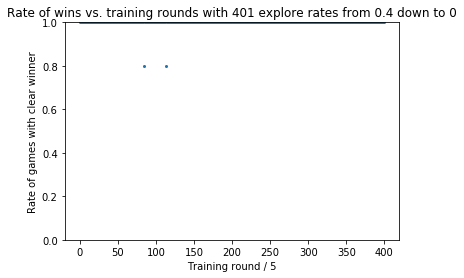

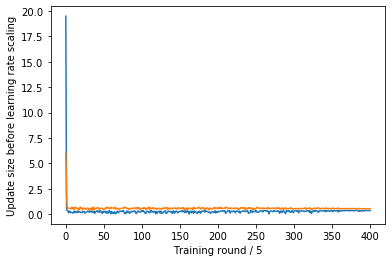

In [30]:
p1superlong4464filt, p2superlong4464filt = makedynamic(5, 401, 0.5, rows=4, cols=4, movingalpha = True, stratnames='grav44', 
                                         aggover=5, numfilters=64, filtersize=3)
#p1grav34, p2grav34 = makedynamic(15000, 9, 0.4, rows=3, cols=4, winc=3, gmove=True, movingalpha=True, 
                               #stratnames="grav34")
# gmove is no longer necessary, our class takes care of that for us now.

In [31]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p1superlong4464filt, human, numrows=4, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------
3  |   |   |   |   | 
---------------------

[0, 1, 2, 3]
1
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------
3  |   | x |   |   | 
---------------------

[0, 1, 2, 3]
Input your action col:2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------
3  |   | x | o |   | 
---------------------

[0, 1, 2, 3]
1
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   | x |   |   | 
---------------------
3  |   | x | o |   | 
---------------------

[0, 1, 2, 3]
Input your action col:1
   | 0 | 1 | 2 |

-1

Should we even test 4x4 filters here? It wouldn't make any sense why we would need to. For a game where a win condition is captured in a 3x3 section of the board should be able to just capture it in a filter of the same size.

# Testing against self

Now I'm running out of time. Clearly it'll be too much work to determine a good model architecture for every game. So I'm just gonna skip straight to Connect 4.

Gonna try to train against self since that seems to work. Below is a test for 3x3, did incredibly well:

0.004


  0%|                                                                                          | 0/101 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


  1%|▊                                                                                 | 1/101 [00:20<34:57, 20.97s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


  2%|█▌                                                                                | 2/101 [00:47<37:06, 22.49s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


  3%|██▍                                                                               | 3/101 [01:11<37:48, 23.15s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


  4%|███▏                                                                              | 4/101 [01:37<38:32, 23.84s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


  5%|████                                                                              | 5/101 [02:03<39:15, 24.54s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


  6%|████▊                                                                             | 6/101 [02:32<41:01, 25.91s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


  7%|█████▋                                                                            | 7/101 [02:56<39:38, 25.30s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


  8%|██████▍                                                                           | 8/101 [03:31<43:50, 28.28s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


  9%|███████▎                                                                          | 9/101 [03:55<41:18, 26.94s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 10%|████████                                                                         | 10/101 [04:23<41:30, 27.37s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 11%|████████▊                                                                        | 11/101 [04:56<43:30, 29.01s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 12%|█████████▌                                                                       | 12/101 [05:25<43:13, 29.14s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 13%|██████████▍                                                                      | 13/101 [05:58<44:04, 30.05s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 14%|███████████▏                                                                     | 14/101 [06:29<44:08, 30.44s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 15%|████████████                                                                     | 15/101 [07:11<48:39, 33.95s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 16%|████████████▊                                                                    | 16/101 [07:41<46:13, 32.63s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 17%|█████████████▋                                                                   | 17/101 [08:14<46:03, 32.90s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 18%|██████████████▍                                                                  | 18/101 [08:47<45:37, 32.98s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 19%|███████████████▏                                                                 | 19/101 [09:33<50:05, 36.66s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 20%|████████████████                                                                 | 20/101 [10:10<49:48, 36.89s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 21%|████████████████▊                                                                | 21/101 [10:39<46:08, 34.61s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 22%|█████████████████▋                                                               | 22/101 [11:20<47:57, 36.43s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 23%|██████████████████▍                                                              | 23/101 [11:58<48:00, 36.93s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 24%|███████████████████▏                                                             | 24/101 [12:26<43:49, 34.15s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 25%|████████████████████                                                             | 25/101 [13:02<43:58, 34.72s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 26%|████████████████████▊                                                            | 26/101 [13:33<42:06, 33.69s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 27%|█████████████████████▋                                                           | 27/101 [14:06<41:13, 33.43s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 28%|██████████████████████▍                                                          | 28/101 [14:35<39:10, 32.20s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 29%|███████████████████████▎                                                         | 29/101 [15:03<37:11, 31.00s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 30%|████████████████████████                                                         | 30/101 [15:40<38:37, 32.65s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 31%|████████████████████████▊                                                        | 31/101 [16:11<37:24, 32.07s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 32%|█████████████████████████▋                                                       | 32/101 [16:43<36:48, 32.01s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 33%|██████████████████████████▍                                                      | 33/101 [17:09<34:15, 30.22s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 34%|███████████████████████████▎                                                     | 34/101 [17:40<33:58, 30.43s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 35%|████████████████████████████                                                     | 35/101 [18:16<35:23, 32.17s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 36%|████████████████████████████▊                                                    | 36/101 [18:46<34:17, 31.65s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 37%|█████████████████████████████▋                                                   | 37/101 [19:20<34:28, 32.31s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 38%|██████████████████████████████▍                                                  | 38/101 [19:49<32:51, 31.30s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 39%|███████████████████████████████▎                                                 | 39/101 [20:31<35:39, 34.51s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 40%|████████████████████████████████                                                 | 40/101 [21:02<34:01, 33.46s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 41%|████████████████████████████████▉                                                | 41/101 [21:29<31:29, 31.49s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 42%|█████████████████████████████████▋                                               | 42/101 [21:54<29:05, 29.59s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 43%|██████████████████████████████████▍                                              | 43/101 [22:21<27:50, 28.80s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 44%|███████████████████████████████████▎                                             | 44/101 [22:53<28:19, 29.82s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 45%|████████████████████████████████████                                             | 45/101 [23:20<26:50, 28.76s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 46%|████████████████████████████████████▉                                            | 46/101 [23:52<27:30, 30.01s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 47%|█████████████████████████████████████▋                                           | 47/101 [24:29<28:50, 32.05s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 48%|██████████████████████████████████████▍                                          | 48/101 [25:07<29:54, 33.85s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 49%|███████████████████████████████████████▎                                         | 49/101 [25:44<30:08, 34.78s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 50%|████████████████████████████████████████                                         | 50/101 [26:13<28:06, 33.07s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 50%|████████████████████████████████████████▉                                        | 51/101 [26:39<25:47, 30.94s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 51%|█████████████████████████████████████████▋                                       | 52/101 [27:04<23:50, 29.19s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 52%|██████████████████████████████████████████▌                                      | 53/101 [27:31<22:42, 28.38s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 53%|███████████████████████████████████████████▎                                     | 54/101 [27:56<21:27, 27.40s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 54%|████████████████████████████████████████████                                     | 55/101 [28:26<21:39, 28.24s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 55%|████████████████████████████████████████████▉                                    | 56/101 [28:57<21:42, 28.95s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 56%|█████████████████████████████████████████████▋                                   | 57/101 [29:28<21:42, 29.61s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 57%|██████████████████████████████████████████████▌                                  | 58/101 [30:05<22:54, 31.96s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 58%|███████████████████████████████████████████████▎                                 | 59/101 [30:34<21:37, 30.89s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 59%|████████████████████████████████████████████████                                 | 60/101 [31:07<21:36, 31.63s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 60%|████████████████████████████████████████████████▉                                | 61/101 [31:33<19:59, 29.99s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 61%|█████████████████████████████████████████████████▋                               | 62/101 [32:06<20:02, 30.83s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 62%|██████████████████████████████████████████████████▌                              | 63/101 [32:32<18:29, 29.20s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 63%|███████████████████████████████████████████████████▎                             | 64/101 [32:57<17:15, 27.99s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 64%|████████████████████████████████████████████████████▏                            | 65/101 [33:22<16:19, 27.21s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 65%|████████████████████████████████████████████████████▉                            | 66/101 [33:48<15:40, 26.87s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 66%|█████████████████████████████████████████████████████▋                           | 67/101 [34:20<16:08, 28.50s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 67%|██████████████████████████████████████████████████████▌                          | 68/101 [34:51<16:00, 29.10s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 68%|███████████████████████████████████████████████████████▎                         | 69/101 [35:20<15:28, 29.01s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 69%|████████████████████████████████████████████████████████▏                        | 70/101 [35:48<14:51, 28.75s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 70%|████████████████████████████████████████████████████████▉                        | 71/101 [36:17<14:21, 28.72s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 71%|█████████████████████████████████████████████████████████▋                       | 72/101 [36:45<13:47, 28.54s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 72%|██████████████████████████████████████████████████████████▌                      | 73/101 [37:11<12:57, 27.77s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 73%|███████████████████████████████████████████████████████████▎                     | 74/101 [37:37<12:19, 27.40s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 74%|████████████████████████████████████████████████████████████▏                    | 75/101 [38:08<12:17, 28.37s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [38:32<11:20, 27.21s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 76%|█████████████████████████████████████████████████████████████▊                   | 77/101 [39:06<11:36, 29.03s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 77%|██████████████████████████████████████████████████████████████▌                  | 78/101 [39:41<11:54, 31.08s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 78%|███████████████████████████████████████████████████████████████▎                 | 79/101 [40:12<11:23, 31.05s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 79%|████████████████████████████████████████████████████████████████▏                | 80/101 [40:48<11:22, 32.51s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 80%|████████████████████████████████████████████████████████████████▉                | 81/101 [41:23<11:01, 33.07s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 81%|█████████████████████████████████████████████████████████████████▊               | 82/101 [41:53<10:10, 32.15s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 82%|██████████████████████████████████████████████████████████████████▌              | 83/101 [42:22<09:24, 31.35s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 83%|███████████████████████████████████████████████████████████████████▎             | 84/101 [42:50<08:32, 30.15s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 84%|████████████████████████████████████████████████████████████████████▏            | 85/101 [43:20<08:04, 30.29s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 85%|████████████████████████████████████████████████████████████████████▉            | 86/101 [43:48<07:24, 29.62s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 86%|█████████████████████████████████████████████████████████████████████▊           | 87/101 [44:17<06:52, 29.43s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 87%|██████████████████████████████████████████████████████████████████████▌          | 88/101 [44:45<06:17, 29.01s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 88%|███████████████████████████████████████████████████████████████████████▍         | 89/101 [45:14<05:48, 29.04s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 89%|████████████████████████████████████████████████████████████████████████▏        | 90/101 [45:48<05:34, 30.42s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 90%|████████████████████████████████████████████████████████████████████████▉        | 91/101 [46:16<04:56, 29.69s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 91%|█████████████████████████████████████████████████████████████████████████▊       | 92/101 [46:44<04:21, 29.04s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 92%|██████████████████████████████████████████████████████████████████████████▌      | 93/101 [47:10<03:45, 28.22s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 93%|███████████████████████████████████████████████████████████████████████████▍     | 94/101 [47:37<03:16, 28.05s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 94%|████████████████████████████████████████████████████████████████████████████▏    | 95/101 [48:08<02:51, 28.66s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 95%|████████████████████████████████████████████████████████████████████████████▉    | 96/101 [48:35<02:21, 28.33s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 97/101 [49:04<01:53, 28.47s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 98/101 [49:31<01:24, 28.15s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 99/101 [50:02<00:57, 28.90s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


 99%|███████████████████████████████████████████████████████████████████████████████▏| 100/101 [50:30<00:28, 28.53s/it]

INFO:tensorflow:Assets written to: models/grav33final1\assets
INFO:tensorflow:Assets written to: models/grav33final2\assets


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [51:00<00:00, 30.30s/it]


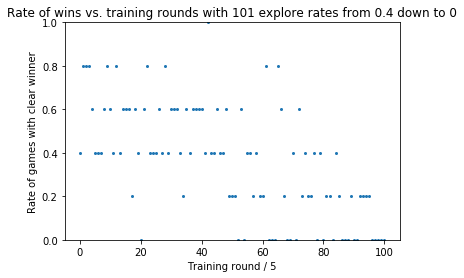

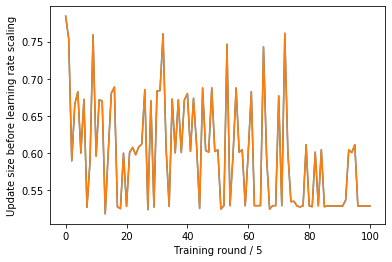

In [7]:
# train player1 against himself
p133, p233 = makedynamic(5, 101, 0.4, rows=3, cols=3, movingalpha = True, stratnames='grav33final', 
                                         aggover=5, numfilters=4, filtersize=3, selftrain=True)

Training against self also gives the advantage that we still get returned a completely untrained model in p233. Performance against self is good:

In [8]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p133, p233, numrows=3, numcols=3, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   |   |   | 
-----------------

[0, 1, 2]
0
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  | x |   |   | 
-----------------

[0, 1, 2]
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  | o |   |   | 
-----------------
2  | x |   |   | 
-----------------

[0, 1, 2]
0
   | 0 | 1 | 2 |
-----------------
0  | x |   |   | 
-----------------
1  | o |   |   | 
-----------------
2  | x |   |   | 
-----------------

[1, 2]
   | 0 | 1 | 2 |
-----------------
0  | x |   |   | 
-----------------
1  | o |   |   | 
-----------------
2  | x |   | o | 
-----------------

[1, 2]
2
   | 0 | 1 | 2 |
-----------------
0  | x |   |   | 
-----------------
1  | o |   | x | 
-----------------
2  | x |   | o | 
-----------------

[1, 2]
   | 0 | 1 | 2 |
-----------------
0  | x |   | o | 
-----------------
1  | o |

0

Performance against a human is a bit weird -- it doesn't try to block player 2 from winning at the end of the game. It's due to the reward scheme. If player 1's only option is to either block player 2 (and prevent itself from winning) or not block player 2 and just try to run straight for a win, it tries to just run straight for the win. It's counting on player 2 possibly making a mistake, and thinking that the value of that assumption and a potential chance of winning is greater than the 0.1 it might get for tying. This reward scheme makes player 1 aggressive and reckless. I think I'll keep it this way for now.

Basically, when player 1 decides it has no chance of winning by just trying to block player 2, it tries to win in a really dumb and bold way.

In [9]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p133, human, numrows=3, numcols=3, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  |   |   |   | 
-----------------

[0, 1, 2]
0
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  | x |   |   | 
-----------------

[0, 1, 2]
Input your action col:1
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  |   |   |   | 
-----------------
2  | x | o |   | 
-----------------

[0, 1, 2]
0
   | 0 | 1 | 2 |
-----------------
0  |   |   |   | 
-----------------
1  | x |   |   | 
-----------------
2  | x | o |   | 
-----------------

[0, 1, 2]
Input your action col:0
   | 0 | 1 | 2 |
-----------------
0  | o |   |   | 
-----------------
1  | x |   |   | 
-----------------
2  | x | o |   | 
-----------------

[1, 2]
2
   | 0 | 1 | 2 |
-----------------
0  | o |   |   | 
-----------------
1  | x |   |   | 
-----------------
2  | x | o | x | 
-----------------

[1, 2]
Input your action col:1
   |

-1

Also testing 3x4 when played against self (use similar training time to 3x3 since the higher network complexity should capture most of what we need):

0.005



  0%|                                                                                          | 0/101 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



  1%|▊                                                                                 | 1/101 [00:33<55:49, 33.49s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



  2%|█▌                                                                                | 2/101 [01:12<57:45, 35.01s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



  3%|██▍                                                                               | 3/101 [01:37<52:32, 32.17s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



  4%|███▏                                                                              | 4/101 [02:16<55:12, 34.15s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



  5%|███▉                                                                            | 5/101 [03:03<1:01:01, 38.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



  6%|████▊                                                                           | 6/101 [03:42<1:00:34, 38.26s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



  7%|█████▌                                                                          | 7/101 [04:32<1:05:31, 41.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



  8%|██████▎                                                                         | 8/101 [05:18<1:06:45, 43.07s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



  9%|███████▏                                                                        | 9/101 [05:53<1:02:26, 40.72s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 10%|███████▊                                                                       | 10/101 [06:38<1:03:49, 42.09s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 11%|████████▌                                                                      | 11/101 [07:15<1:00:46, 40.52s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 12%|█████████▌                                                                       | 12/101 [07:44<54:37, 36.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 13%|██████████▍                                                                      | 13/101 [08:16<52:04, 35.51s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 14%|███████████▏                                                                     | 14/101 [08:58<54:07, 37.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 15%|████████████                                                                     | 15/101 [09:46<58:12, 40.61s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 16%|████████████▌                                                                  | 16/101 [11:08<1:15:01, 52.96s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 17%|█████████████▎                                                                 | 17/101 [11:43<1:06:46, 47.70s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 18%|██████████████▍                                                                  | 18/101 [12:14<58:53, 42.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 19%|███████████████▏                                                                 | 19/101 [12:50<55:35, 40.67s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 20%|████████████████                                                                 | 20/101 [13:32<55:27, 41.08s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 21%|████████████████▊                                                                | 21/101 [14:07<52:21, 39.27s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 22%|█████████████████▋                                                               | 22/101 [14:47<51:55, 39.43s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 23%|██████████████████▍                                                              | 23/101 [15:28<51:59, 40.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 24%|███████████████████▏                                                             | 24/101 [16:16<54:27, 42.44s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 25%|████████████████████                                                             | 25/101 [16:49<50:13, 39.65s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 26%|████████████████████▊                                                            | 26/101 [17:27<48:40, 38.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 27%|█████████████████████▋                                                           | 27/101 [18:15<51:24, 41.69s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 28%|██████████████████████▍                                                          | 28/101 [19:11<55:55, 45.97s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 29%|███████████████████████▎                                                         | 29/101 [19:57<55:18, 46.09s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 30%|████████████████████████                                                         | 30/101 [20:38<52:35, 44.45s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 31%|████████████████████████▊                                                        | 31/101 [21:15<49:17, 42.25s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 32%|█████████████████████████▋                                                       | 32/101 [21:57<48:38, 42.30s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 33%|██████████████████████████▍                                                      | 33/101 [22:38<47:23, 41.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 34%|███████████████████████████▎                                                     | 34/101 [23:19<46:23, 41.54s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 35%|████████████████████████████                                                     | 35/101 [24:13<49:48, 45.28s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 36%|████████████████████████████▊                                                    | 36/101 [24:59<49:19, 45.53s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 37%|█████████████████████████████▋                                                   | 37/101 [25:43<48:03, 45.05s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 38%|██████████████████████████████▍                                                  | 38/101 [26:16<43:27, 41.39s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 39%|███████████████████████████████▎                                                 | 39/101 [26:52<41:14, 39.90s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 40%|████████████████████████████████                                                 | 40/101 [27:50<45:58, 45.22s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 41%|████████████████████████████████▉                                                | 41/101 [28:42<47:24, 47.41s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 42%|█████████████████████████████████▋                                               | 42/101 [29:24<44:50, 45.61s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 43%|██████████████████████████████████▍                                              | 43/101 [30:12<44:51, 46.41s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 44%|███████████████████████████████████▎                                             | 44/101 [30:50<41:43, 43.93s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 45%|████████████████████████████████████                                             | 45/101 [31:30<39:46, 42.62s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 46%|████████████████████████████████████▉                                            | 46/101 [32:00<35:43, 38.98s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 47%|█████████████████████████████████████▋                                           | 47/101 [32:34<33:38, 37.38s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 48%|██████████████████████████████████████▍                                          | 48/101 [33:21<35:31, 40.22s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 49%|███████████████████████████████████████▎                                         | 49/101 [33:55<33:16, 38.40s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 50%|████████████████████████████████████████                                         | 50/101 [34:41<34:40, 40.80s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 50%|████████████████████████████████████████▉                                        | 51/101 [35:20<33:27, 40.16s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 51%|█████████████████████████████████████████▋                                       | 52/101 [36:08<34:40, 42.47s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 52%|██████████████████████████████████████████▌                                      | 53/101 [36:48<33:30, 41.88s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 53%|███████████████████████████████████████████▎                                     | 54/101 [37:17<29:47, 38.03s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 54%|████████████████████████████████████████████                                     | 55/101 [37:53<28:40, 37.41s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 55%|████████████████████████████████████████████▉                                    | 56/101 [38:36<29:14, 38.98s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 56%|█████████████████████████████████████████████▋                                   | 57/101 [39:17<29:05, 39.67s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 57%|██████████████████████████████████████████████▌                                  | 58/101 [39:59<28:54, 40.35s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 58%|███████████████████████████████████████████████▎                                 | 59/101 [40:48<29:59, 42.86s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 59%|████████████████████████████████████████████████                                 | 60/101 [41:19<26:57, 39.45s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 60%|████████████████████████████████████████████████▉                                | 61/101 [41:58<26:06, 39.17s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 61%|█████████████████████████████████████████████████▋                               | 62/101 [42:36<25:22, 39.03s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 62%|██████████████████████████████████████████████████▌                              | 63/101 [43:16<24:50, 39.22s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 63%|███████████████████████████████████████████████████▎                             | 64/101 [43:54<23:57, 38.86s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 64%|████████████████████████████████████████████████████▏                            | 65/101 [44:31<23:00, 38.35s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 65%|████████████████████████████████████████████████████▉                            | 66/101 [45:07<21:53, 37.54s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 66%|█████████████████████████████████████████████████████▋                           | 67/101 [45:42<20:50, 36.77s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 67%|██████████████████████████████████████████████████████▌                          | 68/101 [46:15<19:40, 35.79s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 68%|███████████████████████████████████████████████████████▎                         | 69/101 [46:48<18:36, 34.90s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 69%|████████████████████████████████████████████████████████▏                        | 70/101 [47:32<19:21, 37.46s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 70%|████████████████████████████████████████████████████████▉                        | 71/101 [48:07<18:26, 36.89s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 71%|█████████████████████████████████████████████████████████▋                       | 72/101 [48:43<17:38, 36.51s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 72%|██████████████████████████████████████████████████████████▌                      | 73/101 [49:22<17:24, 37.31s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 73%|███████████████████████████████████████████████████████████▎                     | 74/101 [49:54<16:05, 35.75s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 74%|████████████████████████████████████████████████████████████▏                    | 75/101 [50:36<16:18, 37.64s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [51:08<14:55, 35.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 76%|█████████████████████████████████████████████████████████████▊                   | 77/101 [51:37<13:33, 33.90s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 77%|██████████████████████████████████████████████████████████████▌                  | 78/101 [52:23<14:18, 37.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 78%|███████████████████████████████████████████████████████████████▎                 | 79/101 [53:12<15:01, 40.96s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 79%|████████████████████████████████████████████████████████████████▏                | 80/101 [53:59<14:59, 42.83s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 80%|████████████████████████████████████████████████████████████████▉                | 81/101 [54:41<14:09, 42.49s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 81%|█████████████████████████████████████████████████████████████████▊               | 82/101 [55:21<13:11, 41.67s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 82%|██████████████████████████████████████████████████████████████████▌              | 83/101 [56:02<12:25, 41.44s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 83%|███████████████████████████████████████████████████████████████████▎             | 84/101 [56:37<11:12, 39.55s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 84%|████████████████████████████████████████████████████████████████████▏            | 85/101 [57:12<10:10, 38.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 85%|████████████████████████████████████████████████████████████████████▉            | 86/101 [57:53<09:46, 39.10s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 86%|█████████████████████████████████████████████████████████████████████▊           | 87/101 [58:23<08:29, 36.38s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 87%|██████████████████████████████████████████████████████████████████████▌          | 88/101 [59:00<07:56, 36.65s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 88%|███████████████████████████████████████████████████████████████████████▍         | 89/101 [59:34<07:09, 35.80s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 89%|██████████████████████████████████████████████████████████████████████▍        | 90/101 [1:00:22<07:12, 39.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 90%|███████████████████████████████████████████████████████████████████████▏       | 91/101 [1:00:54<06:13, 37.31s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 91%|███████████████████████████████████████████████████████████████████████▉       | 92/101 [1:01:31<05:35, 37.26s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 92%|████████████████████████████████████████████████████████████████████████▋      | 93/101 [1:02:04<04:47, 35.91s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 93%|█████████████████████████████████████████████████████████████████████████▌     | 94/101 [1:02:38<04:07, 35.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 94%|██████████████████████████████████████████████████████████████████████████▎    | 95/101 [1:03:18<03:40, 36.77s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 95%|███████████████████████████████████████████████████████████████████████████    | 96/101 [1:03:52<02:58, 35.76s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 96%|███████████████████████████████████████████████████████████████████████████▊   | 97/101 [1:04:27<02:22, 35.66s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 97%|████████████████████████████████████████████████████████████████████████████▋  | 98/101 [1:05:01<01:45, 35.10s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 98%|█████████████████████████████████████████████████████████████████████████████▍ | 99/101 [1:05:35<01:09, 34.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



 99%|█████████████████████████████████████████████████████████████████████████████▏| 100/101 [1:06:11<00:35, 35.17s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets



100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [1:06:47<00:00, 39.67s/it]


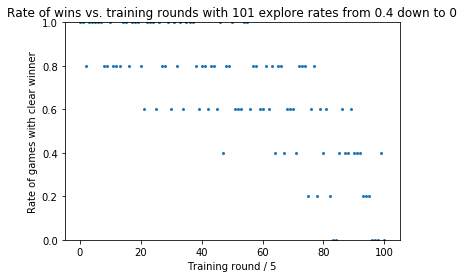

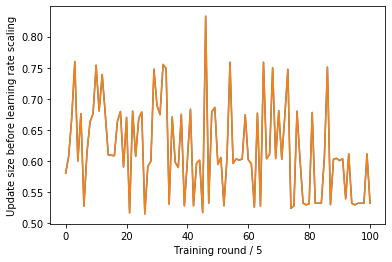

In [7]:
p134, p234 = makedynamic(5, 101, 0.5, rows=3, cols=4, movingalpha = True, stratnames='grav34final', aggover=5, 
                               numfilters=4, filtersize=3, selftrain=True)
# should be 201 when not training against self, so try 101 
# since self training should be 2x efficient. 
# start at 0.5 learning rate since that worked before

In [9]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p134, human, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

[0, 1, 2, 3]
2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   | x |   | 
---------------------

[0, 1, 2, 3]
Input your action col:1
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   | o | x |   | 
---------------------

[0, 1, 2, 3]
2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   | x |   | 
---------------------
2  |   | o | x |   | 
---------------------

[0, 1, 2, 3]
Input your action col:2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   | o |   | 
---------------------
1  |   |   | x |   | 
---------------------
2  |   | o | x |   | 
---------------------

[0, 1, 3]
3
   |

-1

Turns out we can actually just use the same training time for a larger board and still have the game converge! Even if it whiffs sometimes. I think more filters will help with the whiffing, so I'll increase number of filters from 4 to 8 (actually, jk, from below this doesn't work well). 

0.005


  0%|                                                                                          | 0/101 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  1%|▊                                                                               | 1/101 [00:38<1:04:10, 38.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  2%|█▌                                                                              | 2/101 [01:37<1:13:40, 44.65s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  3%|██▍                                                                             | 3/101 [02:28<1:16:05, 46.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  4%|███▏                                                                            | 4/101 [03:29<1:22:19, 50.93s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  5%|███▉                                                                            | 5/101 [04:21<1:21:53, 51.18s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  6%|████▊                                                                           | 6/101 [05:13<1:21:19, 51.36s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  7%|█████▌                                                                          | 7/101 [06:07<1:21:40, 52.13s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  8%|██████▎                                                                         | 8/101 [07:07<1:24:37, 54.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  9%|███████▏                                                                        | 9/101 [08:06<1:25:54, 56.02s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 10%|███████▊                                                                       | 10/101 [08:52<1:20:17, 52.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 11%|████████▌                                                                      | 11/101 [09:41<1:17:28, 51.65s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 12%|█████████▍                                                                     | 12/101 [10:27<1:14:24, 50.16s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 13%|██████████▏                                                                    | 13/101 [11:26<1:17:20, 52.73s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 14%|██████████▉                                                                    | 14/101 [12:10<1:12:25, 49.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 15%|███████████▋                                                                   | 15/101 [12:57<1:10:34, 49.24s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 16%|████████████▌                                                                  | 16/101 [13:56<1:13:44, 52.05s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 17%|█████████████▎                                                                 | 17/101 [14:41<1:10:07, 50.08s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 18%|██████████████                                                                 | 18/101 [15:39<1:12:22, 52.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 19%|██████████████▊                                                                | 19/101 [16:33<1:12:26, 53.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 20%|███████████████▋                                                               | 20/101 [17:38<1:16:20, 56.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 21%|████████████████▍                                                              | 21/101 [18:36<1:15:46, 56.83s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 22%|█████████████████▏                                                             | 22/101 [19:13<1:07:03, 50.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 23%|█████████████████▉                                                             | 23/101 [19:56<1:03:14, 48.65s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 24%|██████████████████▊                                                            | 24/101 [20:56<1:06:32, 51.85s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 25%|███████████████████▌                                                           | 25/101 [21:36<1:01:18, 48.41s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 26%|████████████████████▊                                                            | 26/101 [22:17<57:37, 46.10s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 27%|█████████████████████▋                                                           | 27/101 [22:52<52:58, 42.95s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 28%|██████████████████████▍                                                          | 28/101 [23:45<56:01, 46.04s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 29%|███████████████████████▎                                                         | 29/101 [24:26<53:05, 44.25s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 30%|████████████████████████                                                         | 30/101 [25:06<51:03, 43.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 31%|████████████████████████▊                                                        | 31/101 [25:57<53:07, 45.54s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 32%|█████████████████████████▋                                                       | 32/101 [26:44<52:48, 45.92s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 33%|██████████████████████████▍                                                      | 33/101 [27:26<50:40, 44.71s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 34%|███████████████████████████▎                                                     | 34/101 [28:05<48:03, 43.04s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 35%|████████████████████████████                                                     | 35/101 [28:47<46:51, 42.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 36%|████████████████████████████▊                                                    | 36/101 [29:35<48:00, 44.31s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 37%|█████████████████████████████▋                                                   | 37/101 [30:30<50:48, 47.63s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 38%|██████████████████████████████▍                                                  | 38/101 [31:12<48:09, 45.87s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 39%|███████████████████████████████▎                                                 | 39/101 [32:02<48:42, 47.13s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 40%|████████████████████████████████                                                 | 40/101 [32:47<47:04, 46.31s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 41%|████████████████████████████████▉                                                | 41/101 [33:34<46:36, 46.61s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 42%|█████████████████████████████████▋                                               | 42/101 [34:15<44:06, 44.86s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 43%|██████████████████████████████████▍                                              | 43/101 [35:04<44:43, 46.28s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 44%|███████████████████████████████████▎                                             | 44/101 [35:48<43:16, 45.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 45%|████████████████████████████████████                                             | 45/101 [36:28<40:55, 43.85s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 46%|████████████████████████████████████▉                                            | 46/101 [37:18<41:52, 45.69s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 47%|█████████████████████████████████████▋                                           | 47/101 [38:04<41:08, 45.72s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 48%|██████████████████████████████████████▍                                          | 48/101 [38:48<39:56, 45.21s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 49%|███████████████████████████████████████▎                                         | 49/101 [39:42<41:36, 48.01s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 50%|████████████████████████████████████████                                         | 50/101 [40:22<38:36, 45.43s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 50%|████████████████████████████████████████▉                                        | 51/101 [41:01<36:16, 43.53s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 51%|█████████████████████████████████████████▋                                       | 52/101 [41:43<35:18, 43.24s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 52%|██████████████████████████████████████████▌                                      | 53/101 [42:27<34:37, 43.28s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 53%|███████████████████████████████████████████▎                                     | 54/101 [43:01<31:51, 40.68s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 54%|████████████████████████████████████████████                                     | 55/101 [43:48<32:39, 42.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 55%|████████████████████████████████████████████▉                                    | 56/101 [44:28<31:22, 41.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 56%|█████████████████████████████████████████████▋                                   | 57/101 [45:08<30:12, 41.20s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 57%|██████████████████████████████████████████████▌                                  | 58/101 [45:40<27:36, 38.53s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 58%|███████████████████████████████████████████████▎                                 | 59/101 [46:31<29:32, 42.21s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 59%|████████████████████████████████████████████████                                 | 60/101 [47:18<29:51, 43.69s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 60%|████████████████████████████████████████████████▉                                | 61/101 [48:13<31:16, 46.91s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 61%|█████████████████████████████████████████████████▋                               | 62/101 [48:55<29:34, 45.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 62%|██████████████████████████████████████████████████▌                              | 63/101 [50:00<32:30, 51.33s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 63%|███████████████████████████████████████████████████▎                             | 64/101 [50:51<31:40, 51.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 64%|████████████████████████████████████████████████████▏                            | 65/101 [51:44<31:05, 51.83s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 65%|████████████████████████████████████████████████████▉                            | 66/101 [52:24<28:06, 48.18s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 66%|█████████████████████████████████████████████████████▋                           | 67/101 [52:57<24:38, 43.48s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 67%|██████████████████████████████████████████████████████▌                          | 68/101 [53:29<22:09, 40.29s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 68%|███████████████████████████████████████████████████████▎                         | 69/101 [54:10<21:28, 40.26s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 69%|████████████████████████████████████████████████████████▏                        | 70/101 [54:56<21:49, 42.23s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 70%|████████████████████████████████████████████████████████▉                        | 71/101 [55:46<22:10, 44.36s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 71%|█████████████████████████████████████████████████████████▋                       | 72/101 [56:22<20:19, 42.05s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 72%|██████████████████████████████████████████████████████████▌                      | 73/101 [56:57<18:33, 39.78s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 73%|███████████████████████████████████████████████████████████▎                     | 74/101 [57:40<18:24, 40.91s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 74%|████████████████████████████████████████████████████████████▏                    | 75/101 [58:22<17:52, 41.25s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [58:56<16:12, 38.91s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 76%|█████████████████████████████████████████████████████████████▊                   | 77/101 [59:31<15:08, 37.87s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 77%|█████████████████████████████████████████████████████████████                  | 78/101 [1:00:20<15:43, 41.01s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 78%|█████████████████████████████████████████████████████████████▊                 | 79/101 [1:00:56<14:34, 39.73s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 79%|██████████████████████████████████████████████████████████████▌                | 80/101 [1:01:42<14:32, 41.53s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 80%|███████████████████████████████████████████████████████████████▎               | 81/101 [1:02:22<13:39, 40.98s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 81%|████████████████████████████████████████████████████████████████▏              | 82/101 [1:02:59<12:38, 39.92s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 82%|████████████████████████████████████████████████████████████████▉              | 83/101 [1:03:30<11:09, 37.21s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 83%|█████████████████████████████████████████████████████████████████▋             | 84/101 [1:04:14<11:05, 39.15s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 84%|██████████████████████████████████████████████████████████████████▍            | 85/101 [1:04:50<10:12, 38.30s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 85%|███████████████████████████████████████████████████████████████████▎           | 86/101 [1:05:31<09:47, 39.18s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 86%|████████████████████████████████████████████████████████████████████           | 87/101 [1:06:10<09:05, 38.97s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 87%|████████████████████████████████████████████████████████████████████▊          | 88/101 [1:06:47<08:19, 38.45s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 88%|█████████████████████████████████████████████████████████████████████▌         | 89/101 [1:07:19<07:17, 36.43s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 89%|██████████████████████████████████████████████████████████████████████▍        | 90/101 [1:08:00<06:57, 37.91s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 90%|███████████████████████████████████████████████████████████████████████▏       | 91/101 [1:08:33<06:04, 36.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 91%|███████████████████████████████████████████████████████████████████████▉       | 92/101 [1:09:12<05:34, 37.22s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 92%|████████████████████████████████████████████████████████████████████████▋      | 93/101 [1:09:55<05:10, 38.87s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 93%|█████████████████████████████████████████████████████████████████████████▌     | 94/101 [1:10:25<04:13, 36.28s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 94%|██████████████████████████████████████████████████████████████████████████▎    | 95/101 [1:11:03<03:39, 36.66s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 95%|███████████████████████████████████████████████████████████████████████████    | 96/101 [1:11:34<02:55, 35.09s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 96%|███████████████████████████████████████████████████████████████████████████▊   | 97/101 [1:12:07<02:17, 34.31s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 97%|████████████████████████████████████████████████████████████████████████████▋  | 98/101 [1:12:38<01:40, 33.51s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 99/101 [1:13:12<01:06, 33.48s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 99%|█████████████████████████████████████████████████████████████████████████████▏| 100/101 [1:13:44<00:33, 33.21s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [1:14:15<00:00, 44.12s/it]


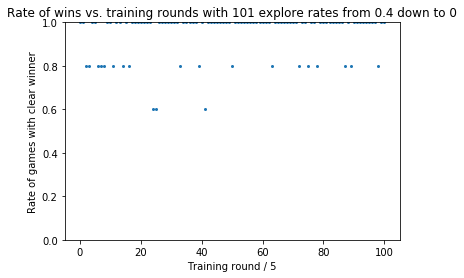

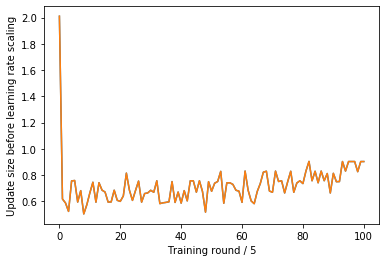

In [6]:
p134, p234 = makedynamic(5, 101, 0.5, rows=3, cols=4, movingalpha = True, stratnames='grav34final', aggover=5, 
                               numfilters=8, filtersize=3, selftrain=True)
# should be 201 when not training against self, so try 101 
# since self training should be 2x efficient. 
# start at 0.5 learning rate since that worked before

In [12]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p134, p234, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

[0, 1, 2, 3]
0
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | x |   |   |   | 
---------------------

[0, 1, 2, 3]
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  | o |   |   |   | 
---------------------
2  | x |   |   |   | 
---------------------

[0, 1, 2, 3]
0
   | 0 | 1 | 2 | 3 |
---------------------
0  | x |   |   |   | 
---------------------
1  | o |   |   |   | 
---------------------
2  | x |   |   |   | 
---------------------

[1, 2, 3]
   | 0 | 1 | 2 | 3 |
---------------------
0  | x |   |   |   | 
---------------------
1  | o |   |   |   | 
---------------------
2  | x |   | o |   | 
---------------------

[1, 2, 3]
3
   | 0 | 1 | 2 | 3 |
---------------------
0  | x |   |

-1

0.0025




  0%|                                                                                          | 0/201 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  0%|▍                                                                               | 1/201 [00:40<2:15:11, 40.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  1%|▊                                                                               | 2/201 [01:30<2:24:11, 43.48s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  1%|█▏                                                                              | 3/201 [02:21<2:31:01, 45.76s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  2%|█▌                                                                              | 4/201 [02:58<2:20:45, 42.87s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  2%|█▉                                                                              | 5/201 [03:36<2:15:38, 41.52s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  3%|██▍                                                                             | 6/201 [04:01<1:59:03, 36.63s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  3%|██▊                                                                             | 7/201 [04:33<1:54:06, 35.29s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  4%|███▏                                                                            | 8/201 [05:25<2:09:42, 40.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  4%|███▌                                                                            | 9/201 [06:21<2:23:39, 44.89s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  5%|███▉                                                                           | 10/201 [07:07<2:23:39, 45.13s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  5%|████▎                                                                          | 11/201 [08:03<2:33:40, 48.53s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  6%|████▋                                                                          | 12/201 [09:03<2:43:12, 51.81s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  6%|█████                                                                          | 13/201 [09:59<2:47:01, 53.31s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  7%|█████▌                                                                         | 14/201 [10:37<2:31:48, 48.71s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  7%|█████▉                                                                         | 15/201 [11:17<2:22:50, 46.08s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  8%|██████▎                                                                        | 16/201 [11:58<2:17:19, 44.54s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  8%|██████▋                                                                        | 17/201 [12:46<2:19:55, 45.63s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  9%|███████                                                                        | 18/201 [13:38<2:25:03, 47.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  9%|███████▍                                                                       | 19/201 [14:22<2:20:45, 46.40s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 10%|███████▊                                                                       | 20/201 [14:56<2:08:56, 42.74s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 10%|████████▎                                                                      | 21/201 [15:34<2:03:29, 41.16s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 11%|████████▋                                                                      | 22/201 [16:18<2:05:39, 42.12s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 11%|█████████                                                                      | 23/201 [16:57<2:02:13, 41.20s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 12%|█████████▍                                                                     | 24/201 [17:35<1:58:33, 40.19s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 12%|█████████▊                                                                     | 25/201 [18:20<2:01:56, 41.57s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 13%|██████████▏                                                                    | 26/201 [18:54<1:54:19, 39.19s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 13%|██████████▌                                                                    | 27/201 [19:41<2:00:50, 41.67s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 14%|███████████                                                                    | 28/201 [20:15<1:53:22, 39.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 14%|███████████▍                                                                   | 29/201 [20:56<1:54:27, 39.93s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 15%|███████████▊                                                                   | 30/201 [21:41<1:58:10, 41.46s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 15%|████████████▏                                                                  | 31/201 [22:22<1:57:17, 41.40s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 16%|████████████▌                                                                  | 32/201 [23:02<1:54:50, 40.77s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 16%|████████████▉                                                                  | 33/201 [23:43<1:54:10, 40.78s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 17%|█████████████▎                                                                 | 34/201 [24:13<1:44:37, 37.59s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 17%|█████████████▊                                                                 | 35/201 [25:05<1:55:53, 41.89s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 18%|██████████████▏                                                                | 36/201 [25:59<2:05:44, 45.72s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 18%|██████████████▌                                                                | 37/201 [26:49<2:08:16, 46.93s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 19%|██████████████▉                                                                | 38/201 [27:42<2:12:10, 48.65s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 19%|███████████████▎                                                               | 39/201 [28:21<2:04:08, 45.98s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 20%|███████████████▋                                                               | 40/201 [29:12<2:07:04, 47.36s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 20%|████████████████                                                               | 41/201 [30:01<2:07:57, 47.98s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 21%|████████████████▌                                                              | 42/201 [30:45<2:03:22, 46.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 21%|████████████████▉                                                              | 43/201 [31:45<2:13:04, 50.53s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 22%|█████████████████▎                                                             | 44/201 [32:18<1:58:58, 45.47s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 22%|█████████████████▋                                                             | 45/201 [33:08<2:01:46, 46.83s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 23%|██████████████████                                                             | 46/201 [33:50<1:56:51, 45.23s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 23%|██████████████████▍                                                            | 47/201 [34:25<1:48:26, 42.25s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 24%|██████████████████▊                                                            | 48/201 [35:03<1:44:50, 41.12s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 24%|███████████████████▎                                                           | 49/201 [35:52<1:50:04, 43.45s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 25%|███████████████████▋                                                           | 50/201 [36:29<1:43:57, 41.31s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 25%|████████████████████                                                           | 51/201 [37:06<1:40:01, 40.01s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 26%|████████████████████▍                                                          | 52/201 [37:59<1:49:24, 44.06s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 26%|████████████████████▊                                                          | 53/201 [39:00<2:01:12, 49.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 27%|█████████████████████▏                                                         | 54/201 [40:05<2:11:46, 53.78s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 27%|█████████████████████▌                                                         | 55/201 [40:47<2:02:29, 50.34s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 28%|██████████████████████                                                         | 56/201 [41:35<1:59:45, 49.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 28%|██████████████████████▍                                                        | 57/201 [42:19<1:54:46, 47.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 29%|██████████████████████▊                                                        | 58/201 [42:59<1:48:39, 45.59s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 29%|███████████████████████▏                                                       | 59/201 [43:39<1:44:02, 43.96s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 30%|███████████████████████▌                                                       | 60/201 [44:31<1:49:11, 46.46s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 30%|███████████████████████▉                                                       | 61/201 [45:06<1:40:25, 43.04s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 31%|████████████████████████▎                                                      | 62/201 [45:59<1:46:37, 46.03s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 31%|████████████████████████▊                                                      | 63/201 [46:39<1:41:11, 44.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 32%|█████████████████████████▏                                                     | 64/201 [47:29<1:44:57, 45.96s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 32%|█████████████████████████▌                                                     | 65/201 [48:11<1:41:30, 44.79s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 33%|█████████████████████████▉                                                     | 66/201 [48:50<1:36:43, 42.99s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 33%|██████████████████████████▎                                                    | 67/201 [49:26<1:31:25, 40.93s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 34%|██████████████████████████▋                                                    | 68/201 [50:11<1:33:10, 42.03s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 34%|███████████████████████████                                                    | 69/201 [51:04<1:40:06, 45.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 35%|███████████████████████████▌                                                   | 70/201 [51:55<1:42:19, 46.87s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 35%|███████████████████████████▉                                                   | 71/201 [52:43<1:42:17, 47.21s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 36%|████████████████████████████▎                                                  | 72/201 [53:27<1:39:46, 46.41s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 36%|████████████████████████████▋                                                  | 73/201 [54:02<1:31:42, 42.99s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 37%|█████████████████████████████                                                  | 74/201 [54:53<1:36:11, 45.44s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 37%|█████████████████████████████▍                                                 | 75/201 [55:38<1:34:50, 45.16s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 38%|█████████████████████████████▊                                                 | 76/201 [56:34<1:40:49, 48.39s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 38%|██████████████████████████████▎                                                | 77/201 [57:29<1:44:02, 50.34s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 39%|██████████████████████████████▋                                                | 78/201 [57:59<1:31:04, 44.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 39%|███████████████████████████████                                                | 79/201 [58:35<1:25:09, 41.88s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 40%|███████████████████████████████▍                                               | 80/201 [59:13<1:22:20, 40.83s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 40%|███████████████████████████████▊                                               | 81/201 [59:52<1:20:31, 40.26s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 41%|███████████████████████████████▍                                             | 82/201 [1:00:20<1:12:20, 36.48s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 41%|███████████████████████████████▊                                             | 83/201 [1:01:08<1:18:34, 39.96s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 42%|████████████████████████████████▏                                            | 84/201 [1:02:01<1:25:25, 43.81s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 42%|████████████████████████████████▌                                            | 85/201 [1:02:33<1:17:57, 40.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 43%|████████████████████████████████▉                                            | 86/201 [1:03:03<1:11:31, 37.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 43%|█████████████████████████████████▎                                           | 87/201 [1:03:44<1:12:35, 38.21s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 44%|█████████████████████████████████▋                                           | 88/201 [1:04:30<1:16:24, 40.57s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 44%|██████████████████████████████████                                           | 89/201 [1:05:11<1:16:11, 40.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 45%|██████████████████████████████████▍                                          | 90/201 [1:05:47<1:12:39, 39.27s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 45%|██████████████████████████████████▊                                          | 91/201 [1:06:26<1:11:46, 39.15s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 46%|███████████████████████████████████▏                                         | 92/201 [1:07:00<1:08:17, 37.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 46%|███████████████████████████████████▋                                         | 93/201 [1:07:55<1:17:01, 42.80s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 47%|████████████████████████████████████                                         | 94/201 [1:08:52<1:24:13, 47.23s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 47%|████████████████████████████████████▍                                        | 95/201 [1:09:38<1:22:54, 46.93s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 48%|████████████████████████████████████▊                                        | 96/201 [1:10:21<1:19:36, 45.49s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 48%|█████████████████████████████████████▏                                       | 97/201 [1:11:01<1:16:01, 43.86s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 49%|█████████████████████████████████████▌                                       | 98/201 [1:11:32<1:08:40, 40.01s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 49%|█████████████████████████████████████▉                                       | 99/201 [1:12:13<1:08:55, 40.55s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 50%|█████████████████████████████████████▊                                      | 100/201 [1:13:00<1:11:21, 42.39s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 50%|██████████████████████████████████████▏                                     | 101/201 [1:13:47<1:12:56, 43.77s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 51%|██████████████████████████████████████▌                                     | 102/201 [1:14:37<1:15:21, 45.67s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 51%|██████████████████████████████████████▉                                     | 103/201 [1:15:19<1:12:51, 44.61s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 52%|███████████████████████████████████████▎                                    | 104/201 [1:16:04<1:11:59, 44.53s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 52%|███████████████████████████████████████▋                                    | 105/201 [1:16:51<1:12:39, 45.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 53%|████████████████████████████████████████                                    | 106/201 [1:17:30<1:08:48, 43.45s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 53%|████████████████████████████████████████▍                                   | 107/201 [1:18:26<1:14:08, 47.33s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 54%|████████████████████████████████████████▊                                   | 108/201 [1:19:18<1:15:29, 48.70s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 54%|█████████████████████████████████████████▏                                  | 109/201 [1:19:57<1:10:10, 45.77s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 55%|█████████████████████████████████████████▌                                  | 110/201 [1:20:45<1:10:06, 46.23s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 55%|█████████████████████████████████████████▉                                  | 111/201 [1:21:29<1:08:27, 45.64s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 56%|██████████████████████████████████████████▎                                 | 112/201 [1:22:14<1:07:30, 45.51s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 56%|██████████████████████████████████████████▋                                 | 113/201 [1:22:49<1:01:55, 42.23s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 57%|███████████████████████████████████████████                                 | 114/201 [1:23:35<1:02:59, 43.45s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 57%|███████████████████████████████████████████▍                                | 115/201 [1:24:26<1:05:36, 45.78s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 58%|███████████████████████████████████████████▊                                | 116/201 [1:25:05<1:02:06, 43.84s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 58%|████████████████████████████████████████████▏                               | 117/201 [1:25:51<1:01:56, 44.25s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 59%|████████████████████████████████████████████▌                               | 118/201 [1:26:39<1:02:49, 45.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 59%|████████████████████████████████████████████▉                               | 119/201 [1:27:20<1:00:12, 44.05s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 60%|██████████████████████████████████████████████▌                               | 120/201 [1:28:00<57:59, 42.96s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 60%|██████████████████████████████████████████████▉                               | 121/201 [1:28:34<53:30, 40.13s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 61%|███████████████████████████████████████████████▎                              | 122/201 [1:29:21<55:39, 42.27s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 61%|███████████████████████████████████████████████▋                              | 123/201 [1:29:56<52:02, 40.03s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 62%|████████████████████████████████████████████████                              | 124/201 [1:30:33<50:19, 39.21s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 62%|████████████████████████████████████████████████▌                             | 125/201 [1:31:18<51:49, 40.91s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 63%|████████████████████████████████████████████████▉                             | 126/201 [1:32:05<53:18, 42.64s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 63%|█████████████████████████████████████████████████▎                            | 127/201 [1:32:40<49:47, 40.38s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 64%|█████████████████████████████████████████████████▋                            | 128/201 [1:33:19<48:55, 40.21s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 64%|██████████████████████████████████████████████████                            | 129/201 [1:33:56<47:01, 39.19s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 65%|██████████████████████████████████████████████████▍                           | 130/201 [1:34:40<47:54, 40.48s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 65%|██████████████████████████████████████████████████▊                           | 131/201 [1:35:17<46:05, 39.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 66%|███████████████████████████████████████████████████▏                          | 132/201 [1:35:53<44:23, 38.61s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 66%|███████████████████████████████████████████████████▌                          | 133/201 [1:36:34<44:22, 39.15s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 67%|████████████████████████████████████████████████████                          | 134/201 [1:37:05<40:54, 36.63s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 67%|████████████████████████████████████████████████████▍                         | 135/201 [1:37:47<42:08, 38.31s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 68%|████████████████████████████████████████████████████▊                         | 136/201 [1:38:23<40:44, 37.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 68%|█████████████████████████████████████████████████████▏                        | 137/201 [1:39:00<40:03, 37.55s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 69%|█████████████████████████████████████████████████████▌                        | 138/201 [1:39:40<40:10, 38.27s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 69%|█████████████████████████████████████████████████████▉                        | 139/201 [1:40:16<38:37, 37.38s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 70%|██████████████████████████████████████████████████████▎                       | 140/201 [1:40:57<39:17, 38.65s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 70%|██████████████████████████████████████████████████████▋                       | 141/201 [1:41:33<37:45, 37.75s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 71%|███████████████████████████████████████████████████████                       | 142/201 [1:42:09<36:43, 37.35s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 71%|███████████████████████████████████████████████████████▍                      | 143/201 [1:42:57<39:04, 40.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 72%|███████████████████████████████████████████████████████▉                      | 144/201 [1:43:34<37:31, 39.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 72%|████████████████████████████████████████████████████████▎                     | 145/201 [1:44:20<38:31, 41.27s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 73%|████████████████████████████████████████████████████████▋                     | 146/201 [1:45:11<40:44, 44.45s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 73%|█████████████████████████████████████████████████████████                     | 147/201 [1:46:01<41:30, 46.12s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 74%|█████████████████████████████████████████████████████████▍                    | 148/201 [1:46:32<36:41, 41.54s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 74%|█████████████████████████████████████████████████████████▊                    | 149/201 [1:47:24<38:37, 44.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 75%|██████████████████████████████████████████████████████████▏                   | 150/201 [1:48:02<36:21, 42.77s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 75%|██████████████████████████████████████████████████████████▌                   | 151/201 [1:48:45<35:42, 42.84s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 76%|██████████████████████████████████████████████████████████▉                   | 152/201 [1:49:32<35:47, 43.83s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 76%|███████████████████████████████████████████████████████████▎                  | 153/201 [1:50:14<34:44, 43.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 77%|███████████████████████████████████████████████████████████▊                  | 154/201 [1:50:55<33:26, 42.69s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 77%|████████████████████████████████████████████████████████████▏                 | 155/201 [1:51:35<32:00, 41.75s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 78%|████████████████████████████████████████████████████████████▌                 | 156/201 [1:52:08<29:23, 39.18s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 78%|████████████████████████████████████████████████████████████▉                 | 157/201 [1:52:45<28:21, 38.66s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 79%|█████████████████████████████████████████████████████████████▎                | 158/201 [1:53:29<28:43, 40.08s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 79%|█████████████████████████████████████████████████████████████▋                | 159/201 [1:54:01<26:32, 37.91s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 80%|██████████████████████████████████████████████████████████████                | 160/201 [1:54:33<24:38, 36.05s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 80%|██████████████████████████████████████████████████████████████▍               | 161/201 [1:55:04<23:04, 34.62s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 81%|██████████████████████████████████████████████████████████████▊               | 162/201 [1:55:34<21:28, 33.03s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 81%|███████████████████████████████████████████████████████████████▎              | 163/201 [1:56:14<22:21, 35.30s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 82%|███████████████████████████████████████████████████████████████▋              | 164/201 [1:56:53<22:19, 36.19s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 82%|████████████████████████████████████████████████████████████████              | 165/201 [1:57:32<22:12, 37.02s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 83%|████████████████████████████████████████████████████████████████▍             | 166/201 [1:58:09<21:38, 37.10s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 83%|████████████████████████████████████████████████████████████████▊             | 167/201 [1:58:47<21:14, 37.49s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 84%|█████████████████████████████████████████████████████████████████▏            | 168/201 [1:59:18<19:32, 35.53s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 84%|█████████████████████████████████████████████████████████████████▌            | 169/201 [1:59:56<19:20, 36.26s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 85%|█████████████████████████████████████████████████████████████████▉            | 170/201 [2:00:33<18:45, 36.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 85%|██████████████████████████████████████████████████████████████████▎           | 171/201 [2:01:23<20:13, 40.46s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 86%|██████████████████████████████████████████████████████████████████▋           | 172/201 [2:02:14<21:06, 43.66s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 86%|███████████████████████████████████████████████████████████████████▏          | 173/201 [2:02:52<19:33, 41.91s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 87%|███████████████████████████████████████████████████████████████████▌          | 174/201 [2:03:26<17:47, 39.52s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 87%|███████████████████████████████████████████████████████████████████▉          | 175/201 [2:04:03<16:50, 38.87s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 88%|████████████████████████████████████████████████████████████████████▎         | 176/201 [2:04:45<16:37, 39.89s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 88%|████████████████████████████████████████████████████████████████████▋         | 177/201 [2:05:17<15:01, 37.55s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 89%|█████████████████████████████████████████████████████████████████████         | 178/201 [2:06:09<15:59, 41.73s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 89%|█████████████████████████████████████████████████████████████████████▍        | 179/201 [2:06:52<15:27, 42.18s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 90%|█████████████████████████████████████████████████████████████████████▊        | 180/201 [2:07:28<14:05, 40.24s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 90%|██████████████████████████████████████████████████████████████████████▏       | 181/201 [2:08:09<13:32, 40.62s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 91%|██████████████████████████████████████████████████████████████████████▋       | 182/201 [2:08:53<13:06, 41.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 91%|███████████████████████████████████████████████████████████████████████       | 183/201 [2:09:43<13:13, 44.07s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 92%|███████████████████████████████████████████████████████████████████████▍      | 184/201 [2:10:13<11:18, 39.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 92%|███████████████████████████████████████████████████████████████████████▊      | 185/201 [2:10:48<10:14, 38.39s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 93%|████████████████████████████████████████████████████████████████████████▏     | 186/201 [2:11:22<09:15, 37.01s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 93%|████████████████████████████████████████████████████████████████████████▌     | 187/201 [2:11:57<08:29, 36.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 94%|████████████████████████████████████████████████████████████████████████▉     | 188/201 [2:12:31<07:45, 35.79s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 94%|█████████████████████████████████████████████████████████████████████████▎    | 189/201 [2:13:26<08:16, 41.41s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 95%|█████████████████████████████████████████████████████████████████████████▋    | 190/201 [2:13:58<07:07, 38.85s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 95%|██████████████████████████████████████████████████████████████████████████    | 191/201 [2:14:39<06:33, 39.39s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 96%|██████████████████████████████████████████████████████████████████████████▌   | 192/201 [2:15:09<05:29, 36.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 96%|██████████████████████████████████████████████████████████████████████████▉   | 193/201 [2:15:45<04:51, 36.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 97%|███████████████████████████████████████████████████████████████████████████▎  | 194/201 [2:16:19<04:09, 35.64s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 97%|███████████████████████████████████████████████████████████████████████████▋  | 195/201 [2:16:50<03:24, 34.15s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 98%|████████████████████████████████████████████████████████████████████████████  | 196/201 [2:17:22<02:47, 33.48s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 98%|████████████████████████████████████████████████████████████████████████████▍ | 197/201 [2:17:55<02:14, 33.52s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 99%|████████████████████████████████████████████████████████████████████████████▊ | 198/201 [2:18:36<01:46, 35.63s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 99%|█████████████████████████████████████████████████████████████████████████████▏| 199/201 [2:19:07<01:08, 34.40s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




100%|█████████████████████████████████████████████████████████████████████████████▌| 200/201 [2:19:40<00:33, 33.85s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [2:20:13<00:00, 41.86s/it]


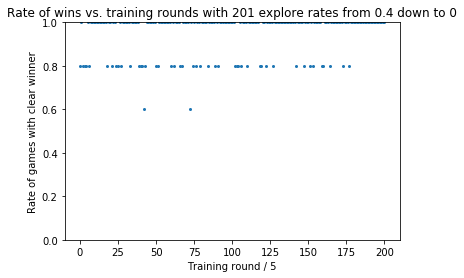

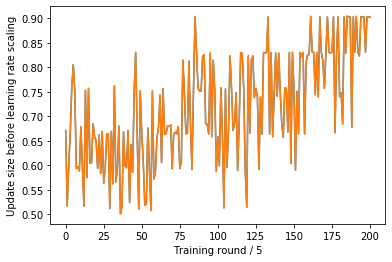

In [13]:
p134, p234 = makedynamic(5, 201, 0.5, rows=3, cols=4, movingalpha = True, stratnames='grav34final', aggover=5, 
                               numfilters=8, filtersize=3, selftrain=True)

In [16]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p134, p234, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

[0, 1, 2, 3]
3
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   | x | 
---------------------

[0, 1, 2, 3]
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | o |   |   | x | 
---------------------

[0, 1, 2, 3]
3
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   | x | 
---------------------
2  | o |   |   | x | 
---------------------

[0, 1, 2, 3]
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  | o |   |   | x | 
---------------------
2  | o |   |   | x | 
---------------------

[0, 1, 2, 3]
3
   | 0 | 1 | 2 | 3 |
---------------------
0  |  

1

Final test for 3x4: will more filters work better with a lower learning rate? Give a bit more train time as well. Performed ok, but not against self.

0.0008


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  0%|▎                                                                               | 1/251 [00:27<1:56:18, 27.91s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  1%|▋                                                                               | 2/251 [01:14<2:19:27, 33.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  1%|▉                                                                               | 3/251 [01:51<2:22:26, 34.46s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  2%|█▎                                                                              | 4/251 [02:27<2:24:01, 34.99s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  2%|█▌                                                                              | 5/251 [02:58<2:18:19, 33.74s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  2%|█▉                                                                              | 6/251 [03:36<2:23:38, 35.18s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  3%|██▏                                                                             | 7/251 [04:02<2:11:32, 32.35s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  3%|██▌                                                                             | 8/251 [04:28<2:03:15, 30.44s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  4%|██▊                                                                             | 9/251 [05:03<2:08:37, 31.89s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  4%|███▏                                                                           | 10/251 [05:34<2:06:40, 31.54s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  4%|███▍                                                                           | 11/251 [06:07<2:08:16, 32.07s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  5%|███▊                                                                           | 12/251 [06:36<2:03:03, 30.89s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  5%|████                                                                           | 13/251 [07:07<2:03:05, 31.03s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  6%|████▍                                                                          | 14/251 [07:45<2:10:32, 33.05s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  6%|████▋                                                                          | 15/251 [08:16<2:08:01, 32.55s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  6%|█████                                                                          | 16/251 [08:48<2:07:00, 32.43s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  7%|█████▎                                                                         | 17/251 [09:19<2:04:46, 31.99s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  7%|█████▋                                                                         | 18/251 [09:53<2:06:54, 32.68s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  8%|█████▉                                                                         | 19/251 [10:25<2:05:10, 32.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  8%|██████▎                                                                        | 20/251 [11:05<2:13:18, 34.62s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  8%|██████▌                                                                        | 21/251 [11:48<2:22:21, 37.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  9%|██████▉                                                                        | 22/251 [12:17<2:12:43, 34.77s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  9%|███████▏                                                                       | 23/251 [12:53<2:13:09, 35.04s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 10%|███████▌                                                                       | 24/251 [13:30<2:15:26, 35.80s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 10%|███████▊                                                                       | 25/251 [14:03<2:11:24, 34.89s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 10%|████████▏                                                                      | 26/251 [14:42<2:15:21, 36.09s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 11%|████████▍                                                                      | 27/251 [15:16<2:12:32, 35.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 11%|████████▊                                                                      | 28/251 [15:55<2:15:54, 36.57s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 12%|█████████▏                                                                     | 29/251 [16:28<2:11:32, 35.55s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 12%|█████████▍                                                                     | 30/251 [17:04<2:10:46, 35.51s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 12%|█████████▊                                                                     | 31/251 [17:34<2:04:23, 33.93s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 13%|██████████                                                                     | 32/251 [18:07<2:02:25, 33.54s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 13%|██████████▍                                                                    | 33/251 [18:47<2:08:44, 35.43s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 14%|██████████▋                                                                    | 34/251 [19:19<2:04:45, 34.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 14%|███████████                                                                    | 35/251 [20:01<2:12:12, 36.72s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 14%|███████████▎                                                                   | 36/251 [20:34<2:07:34, 35.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 15%|███████████▋                                                                   | 37/251 [21:07<2:03:56, 34.75s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 15%|███████████▉                                                                   | 38/251 [21:45<2:07:21, 35.88s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 16%|████████████▎                                                                  | 39/251 [22:21<2:06:22, 35.77s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 16%|████████████▌                                                                  | 40/251 [23:00<2:09:09, 36.73s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 16%|████████████▉                                                                  | 41/251 [23:40<2:12:37, 37.89s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 17%|█████████████▏                                                                 | 42/251 [24:16<2:09:54, 37.29s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 17%|█████████████▌                                                                 | 43/251 [24:50<2:05:58, 36.34s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 18%|█████████████▊                                                                 | 44/251 [25:29<2:08:27, 37.24s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 18%|██████████████▏                                                                | 45/251 [26:06<2:06:46, 36.92s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 18%|██████████████▍                                                                | 46/251 [26:44<2:07:04, 37.19s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 19%|██████████████▊                                                                | 47/251 [27:23<2:08:40, 37.85s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 19%|███████████████                                                                | 48/251 [28:06<2:13:49, 39.55s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 20%|███████████████▍                                                               | 49/251 [28:43<2:09:51, 38.57s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 20%|███████████████▋                                                               | 50/251 [29:25<2:12:34, 39.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 20%|████████████████                                                               | 51/251 [30:06<2:13:41, 40.11s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 21%|████████████████▎                                                              | 52/251 [30:55<2:21:59, 42.81s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 21%|████████████████▋                                                              | 53/251 [31:30<2:13:33, 40.47s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 22%|████████████████▉                                                              | 54/251 [32:03<2:05:16, 38.16s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 22%|█████████████████▎                                                             | 55/251 [32:38<2:01:23, 37.16s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 22%|█████████████████▋                                                             | 56/251 [33:13<1:58:36, 36.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 23%|█████████████████▉                                                             | 57/251 [33:43<1:52:04, 34.66s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 23%|██████████████████▎                                                            | 58/251 [34:21<1:54:29, 35.59s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 24%|██████████████████▌                                                            | 59/251 [35:00<1:57:24, 36.69s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 24%|██████████████████▉                                                            | 60/251 [35:33<1:53:43, 35.73s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 24%|███████████████████▏                                                           | 61/251 [36:13<1:56:29, 36.79s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 25%|███████████████████▌                                                           | 62/251 [36:50<1:55:55, 36.80s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 25%|███████████████████▊                                                           | 63/251 [37:23<1:52:25, 35.88s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 25%|████████████████████▏                                                          | 64/251 [38:00<1:52:23, 36.06s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 26%|████████████████████▍                                                          | 65/251 [38:41<1:56:49, 37.69s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 26%|████████████████████▊                                                          | 66/251 [39:26<2:02:27, 39.71s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 27%|█████████████████████                                                          | 67/251 [39:54<1:51:21, 36.31s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 27%|█████████████████████▍                                                         | 68/251 [40:31<1:51:16, 36.48s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 27%|█████████████████████▋                                                         | 69/251 [41:06<1:49:45, 36.18s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 28%|██████████████████████                                                         | 70/251 [41:44<1:49:56, 36.44s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 28%|██████████████████████▎                                                        | 71/251 [42:26<1:54:34, 38.19s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 29%|██████████████████████▋                                                        | 72/251 [43:10<1:59:15, 39.98s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 29%|██████████████████████▉                                                        | 73/251 [43:43<1:52:00, 37.75s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 29%|███████████████████████▎                                                       | 74/251 [44:27<1:57:34, 39.86s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 30%|███████████████████████▌                                                       | 75/251 [45:05<1:54:45, 39.12s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 30%|███████████████████████▉                                                       | 76/251 [45:43<1:53:34, 38.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 31%|████████████████████████▏                                                      | 77/251 [46:16<1:47:51, 37.19s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 31%|████████████████████████▌                                                      | 78/251 [46:51<1:44:44, 36.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 31%|████████████████████████▊                                                      | 79/251 [47:31<1:47:44, 37.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 32%|█████████████████████████▏                                                     | 80/251 [48:05<1:43:58, 36.49s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 32%|█████████████████████████▍                                                     | 81/251 [48:45<1:46:02, 37.43s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 33%|█████████████████████████▊                                                     | 82/251 [49:20<1:43:55, 36.90s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 33%|██████████████████████████                                                     | 83/251 [50:01<1:46:05, 37.89s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 33%|██████████████████████████▍                                                    | 84/251 [50:40<1:46:24, 38.23s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 34%|██████████████████████████▊                                                    | 85/251 [51:09<1:38:16, 35.52s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 34%|███████████████████████████                                                    | 86/251 [51:50<1:42:45, 37.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 35%|███████████████████████████▍                                                   | 87/251 [52:34<1:46:59, 39.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 35%|███████████████████████████▋                                                   | 88/251 [53:12<1:45:55, 38.99s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 35%|████████████████████████████                                                   | 89/251 [53:51<1:44:35, 38.74s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 36%|████████████████████████████▎                                                  | 90/251 [54:35<1:48:52, 40.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 36%|████████████████████████████▋                                                  | 91/251 [55:10<1:43:19, 38.75s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 37%|████████████████████████████▉                                                  | 92/251 [55:48<1:42:01, 38.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 37%|█████████████████████████████▎                                                 | 93/251 [56:24<1:39:46, 37.89s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 37%|█████████████████████████████▌                                                 | 94/251 [56:58<1:36:10, 36.75s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 38%|█████████████████████████████▉                                                 | 95/251 [57:40<1:39:18, 38.19s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 38%|██████████████████████████████▏                                                | 96/251 [58:22<1:41:37, 39.34s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 39%|██████████████████████████████▌                                                | 97/251 [58:58<1:38:11, 38.26s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 39%|██████████████████████████████▊                                                | 98/251 [59:35<1:37:08, 38.09s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 39%|██████████████████████████████▎                                              | 99/251 [1:00:13<1:36:12, 37.97s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 40%|██████████████████████████████▎                                             | 100/251 [1:00:48<1:33:17, 37.07s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 40%|██████████████████████████████▌                                             | 101/251 [1:01:29<1:35:34, 38.23s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 41%|██████████████████████████████▉                                             | 102/251 [1:02:16<1:41:15, 40.78s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 41%|███████████████████████████████▏                                            | 103/251 [1:02:52<1:37:31, 39.54s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 41%|███████████████████████████████▍                                            | 104/251 [1:03:25<1:32:09, 37.62s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 42%|███████████████████████████████▊                                            | 105/251 [1:04:11<1:37:24, 40.03s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 42%|████████████████████████████████                                            | 106/251 [1:04:57<1:40:38, 41.65s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 43%|████████████████████████████████▍                                           | 107/251 [1:05:35<1:37:24, 40.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 43%|████████████████████████████████▋                                           | 108/251 [1:06:06<1:30:14, 37.86s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 43%|█████████████████████████████████                                           | 109/251 [1:06:42<1:28:30, 37.39s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 44%|█████████████████████████████████▎                                          | 110/251 [1:07:32<1:36:23, 41.02s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 44%|█████████████████████████████████▌                                          | 111/251 [1:08:22<1:41:56, 43.69s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 45%|█████████████████████████████████▉                                          | 112/251 [1:09:18<1:50:06, 47.53s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 45%|██████████████████████████████████▏                                         | 113/251 [1:10:12<1:53:32, 49.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 45%|██████████████████████████████████▌                                         | 114/251 [1:11:15<2:02:05, 53.47s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 46%|██████████████████████████████████▊                                         | 115/251 [1:12:01<1:56:24, 51.36s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 46%|███████████████████████████████████                                         | 116/251 [1:12:49<1:52:56, 50.20s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 47%|███████████████████████████████████▍                                        | 117/251 [1:13:23<1:41:29, 45.44s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 47%|███████████████████████████████████▋                                        | 118/251 [1:14:03<1:36:39, 43.61s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 47%|████████████████████████████████████                                        | 119/251 [1:14:47<1:36:24, 43.83s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 48%|████████████████████████████████████▎                                       | 120/251 [1:15:23<1:30:50, 41.61s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 48%|████████████████████████████████████▋                                       | 121/251 [1:16:04<1:29:19, 41.23s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 49%|████████████████████████████████████▉                                       | 122/251 [1:16:38<1:24:23, 39.25s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 49%|█████████████████████████████████████▏                                      | 123/251 [1:17:25<1:28:18, 41.39s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 49%|█████████████████████████████████████▌                                      | 124/251 [1:17:53<1:19:15, 37.44s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 50%|█████████████████████████████████████▊                                      | 125/251 [1:18:32<1:19:28, 37.84s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 50%|██████████████████████████████████████▏                                     | 126/251 [1:19:08<1:17:33, 37.23s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 51%|██████████████████████████████████████▍                                     | 127/251 [1:19:53<1:22:04, 39.71s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 51%|██████████████████████████████████████▊                                     | 128/251 [1:20:32<1:20:50, 39.43s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 51%|███████████████████████████████████████                                     | 129/251 [1:21:14<1:21:36, 40.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 52%|███████████████████████████████████████▎                                    | 130/251 [1:21:56<1:22:05, 40.71s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 52%|███████████████████████████████████████▋                                    | 131/251 [1:22:32<1:18:51, 39.43s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 53%|███████████████████████████████████████▉                                    | 132/251 [1:23:16<1:20:52, 40.78s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 53%|████████████████████████████████████████▎                                   | 133/251 [1:23:57<1:20:24, 40.89s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 53%|████████████████████████████████████████▌                                   | 134/251 [1:24:32<1:16:15, 39.11s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 54%|████████████████████████████████████████▉                                   | 135/251 [1:25:09<1:14:02, 38.30s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 54%|█████████████████████████████████████████▏                                  | 136/251 [1:25:46<1:12:43, 37.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 55%|█████████████████████████████████████████▍                                  | 137/251 [1:26:22<1:11:24, 37.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 55%|█████████████████████████████████████████▊                                  | 138/251 [1:26:58<1:09:37, 36.97s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 55%|██████████████████████████████████████████                                  | 139/251 [1:27:36<1:09:31, 37.25s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 56%|██████████████████████████████████████████▍                                 | 140/251 [1:28:11<1:07:33, 36.52s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 56%|██████████████████████████████████████████▋                                 | 141/251 [1:28:50<1:08:33, 37.40s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 57%|██████████████████████████████████████████▉                                 | 142/251 [1:29:31<1:09:36, 38.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 57%|███████████████████████████████████████████▎                                | 143/251 [1:30:12<1:10:54, 39.39s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 57%|███████████████████████████████████████████▌                                | 144/251 [1:30:50<1:09:13, 38.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 58%|███████████████████████████████████████████▉                                | 145/251 [1:31:21<1:04:40, 36.61s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 58%|████████████████████████████████████████████▏                               | 146/251 [1:31:55<1:02:40, 35.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 59%|████████████████████████████████████████████▌                               | 147/251 [1:32:36<1:04:25, 37.17s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 59%|████████████████████████████████████████████▊                               | 148/251 [1:33:11<1:03:00, 36.70s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 59%|█████████████████████████████████████████████                               | 149/251 [1:33:44<1:00:08, 35.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 60%|██████████████████████████████████████████████▌                               | 150/251 [1:34:16<58:18, 34.64s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 60%|██████████████████████████████████████████████▉                               | 151/251 [1:34:51<57:46, 34.66s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 61%|███████████████████████████████████████████████▏                              | 152/251 [1:35:28<58:16, 35.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 61%|███████████████████████████████████████████████▌                              | 153/251 [1:36:00<55:59, 34.29s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 61%|██████████████████████████████████████████████▋                             | 154/251 [1:36:50<1:03:11, 39.08s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 62%|██████████████████████████████████████████████▉                             | 155/251 [1:37:36<1:05:56, 41.21s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 62%|███████████████████████████████████████████████▏                            | 156/251 [1:38:18<1:05:14, 41.20s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 63%|███████████████████████████████████████████████▌                            | 157/251 [1:38:53<1:01:43, 39.40s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 63%|███████████████████████████████████████████████▊                            | 158/251 [1:39:42<1:05:43, 42.40s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 63%|████████████████████████████████████████████████▏                           | 159/251 [1:40:19<1:02:41, 40.88s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 64%|████████████████████████████████████████████████▍                           | 160/251 [1:40:58<1:00:58, 40.21s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 64%|██████████████████████████████████████████████████                            | 161/251 [1:41:36<59:16, 39.52s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 65%|█████████████████████████████████████████████████                           | 162/251 [1:42:23<1:01:52, 41.72s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 65%|█████████████████████████████████████████████████▎                          | 163/251 [1:43:08<1:02:34, 42.66s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 65%|█████████████████████████████████████████████████▋                          | 164/251 [1:44:03<1:07:25, 46.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 66%|█████████████████████████████████████████████████▉                          | 165/251 [1:44:49<1:06:27, 46.36s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 66%|██████████████████████████████████████████████████▎                         | 166/251 [1:45:33<1:04:39, 45.65s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 67%|██████████████████████████████████████████████████▌                         | 167/251 [1:46:21<1:04:42, 46.22s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 67%|██████████████████████████████████████████████████▊                         | 168/251 [1:47:05<1:02:57, 45.51s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 67%|███████████████████████████████████████████████████▏                        | 169/251 [1:47:54<1:03:47, 46.67s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 68%|███████████████████████████████████████████████████▍                        | 170/251 [1:48:42<1:03:21, 46.93s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 68%|█████████████████████████████████████████████████████▏                        | 171/251 [1:49:19<58:54, 44.18s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 69%|████████████████████████████████████████████████████                        | 172/251 [1:50:16<1:03:01, 47.87s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 69%|████████████████████████████████████████████████████▍                       | 173/251 [1:51:08<1:03:47, 49.07s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 69%|████████████████████████████████████████████████████▋                       | 174/251 [1:51:59<1:03:53, 49.78s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 70%|████████████████████████████████████████████████████▉                       | 175/251 [1:52:50<1:03:37, 50.23s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 70%|█████████████████████████████████████████████████████▎                      | 176/251 [1:53:44<1:03:57, 51.17s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 71%|█████████████████████████████████████████████████████▌                      | 177/251 [1:54:30<1:01:11, 49.61s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 71%|█████████████████████████████████████████████████████▉                      | 178/251 [1:55:19<1:00:07, 49.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 71%|██████████████████████████████████████████████████████▏                     | 179/251 [1:56:16<1:02:10, 51.81s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 72%|██████████████████████████████████████████████████████▌                     | 180/251 [1:57:12<1:02:41, 52.98s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 72%|████████████████████████████████████████████████████████▏                     | 181/251 [1:57:57<59:09, 50.71s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 73%|████████████████████████████████████████████████████████▌                     | 182/251 [1:58:48<58:26, 50.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 73%|████████████████████████████████████████████████████████▊                     | 183/251 [1:59:38<57:06, 50.40s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 73%|█████████████████████████████████████████████████████████▏                    | 184/251 [2:00:29<56:29, 50.59s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 74%|█████████████████████████████████████████████████████████▍                    | 185/251 [2:01:29<58:42, 53.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 74%|████████████████████████████████████████████████████████▎                   | 186/251 [2:02:46<1:05:30, 60.46s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 75%|████████████████████████████████████████████████████████▌                   | 187/251 [2:03:40<1:02:35, 58.67s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 75%|██████████████████████████████████████████████████████████▍                   | 188/251 [2:04:32<59:23, 56.57s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 75%|██████████████████████████████████████████████████████████▋                   | 189/251 [2:05:12<53:32, 51.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 76%|███████████████████████████████████████████████████████████                   | 190/251 [2:06:05<52:44, 51.88s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 76%|███████████████████████████████████████████████████████████▎                  | 191/251 [2:07:04<54:14, 54.25s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 76%|███████████████████████████████████████████████████████████▋                  | 192/251 [2:07:48<50:08, 51.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 77%|███████████████████████████████████████████████████████████▉                  | 193/251 [2:08:32<47:20, 48.98s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 77%|████████████████████████████████████████████████████████████▎                 | 194/251 [2:09:18<45:35, 48.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 78%|████████████████████████████████████████████████████████████▌                 | 195/251 [2:09:53<41:11, 44.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 78%|████████████████████████████████████████████████████████████▉                 | 196/251 [2:10:46<43:04, 46.99s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 78%|█████████████████████████████████████████████████████████████▏                | 197/251 [2:11:39<43:44, 48.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 79%|█████████████████████████████████████████████████████████████▌                | 198/251 [2:12:32<44:16, 50.12s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 79%|█████████████████████████████████████████████████████████████▊                | 199/251 [2:13:25<44:01, 50.80s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 80%|██████████████████████████████████████████████████████████████▏               | 200/251 [2:14:10<41:49, 49.21s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 80%|██████████████████████████████████████████████████████████████▍               | 201/251 [2:14:57<40:26, 48.53s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 80%|██████████████████████████████████████████████████████████████▊               | 202/251 [2:15:39<37:54, 46.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 81%|███████████████████████████████████████████████████████████████               | 203/251 [2:16:17<35:09, 43.95s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 81%|███████████████████████████████████████████████████████████████▍              | 204/251 [2:17:14<37:34, 47.98s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 82%|███████████████████████████████████████████████████████████████▋              | 205/251 [2:18:02<36:40, 47.85s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 82%|████████████████████████████████████████████████████████████████              | 206/251 [2:19:04<38:59, 51.99s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 82%|████████████████████████████████████████████████████████████████▎             | 207/251 [2:19:52<37:16, 50.84s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 83%|████████████████████████████████████████████████████████████████▋             | 208/251 [2:20:43<36:37, 51.11s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 83%|████████████████████████████████████████████████████████████████▉             | 209/251 [2:21:28<34:20, 49.07s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 84%|█████████████████████████████████████████████████████████████████▎            | 210/251 [2:22:27<35:38, 52.16s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 84%|█████████████████████████████████████████████████████████████████▌            | 211/251 [2:23:28<36:33, 54.83s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 84%|█████████████████████████████████████████████████████████████████▉            | 212/251 [2:24:26<36:14, 55.76s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 85%|██████████████████████████████████████████████████████████████████▏           | 213/251 [2:25:23<35:29, 56.03s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 85%|██████████████████████████████████████████████████████████████████▌           | 214/251 [2:26:16<34:05, 55.28s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 86%|██████████████████████████████████████████████████████████████████▊           | 215/251 [2:27:26<35:43, 59.54s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 86%|███████████████████████████████████████████████████████████████████           | 216/251 [2:28:28<35:12, 60.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 86%|███████████████████████████████████████████████████████████████████▍          | 217/251 [2:29:18<32:24, 57.18s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 87%|███████████████████████████████████████████████████████████████████▋          | 218/251 [2:30:10<30:34, 55.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 87%|████████████████████████████████████████████████████████████████████          | 219/251 [2:30:54<27:48, 52.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 88%|████████████████████████████████████████████████████████████████████▎         | 220/251 [2:31:42<26:18, 50.92s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 88%|████████████████████████████████████████████████████████████████████▋         | 221/251 [2:33:05<30:15, 60.51s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 88%|████████████████████████████████████████████████████████████████████▉         | 222/251 [2:34:01<28:40, 59.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 89%|█████████████████████████████████████████████████████████████████████▎        | 223/251 [2:35:03<28:00, 60.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 89%|█████████████████████████████████████████████████████████████████████▌        | 224/251 [2:36:12<28:17, 62.87s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 90%|█████████████████████████████████████████████████████████████████████▉        | 225/251 [2:37:07<26:09, 60.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 90%|██████████████████████████████████████████████████████████████████████▏       | 226/251 [2:37:54<23:29, 56.40s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 90%|██████████████████████████████████████████████████████████████████████▌       | 227/251 [2:38:43<21:39, 54.13s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 91%|██████████████████████████████████████████████████████████████████████▊       | 228/251 [2:39:34<20:20, 53.06s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 91%|███████████████████████████████████████████████████████████████████████▏      | 229/251 [2:40:29<19:43, 53.81s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 92%|███████████████████████████████████████████████████████████████████████▍      | 230/251 [2:41:32<19:50, 56.68s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 92%|███████████████████████████████████████████████████████████████████████▊      | 231/251 [2:42:39<19:51, 59.55s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 92%|████████████████████████████████████████████████████████████████████████      | 232/251 [2:43:26<17:39, 55.74s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 93%|████████████████████████████████████████████████████████████████████████▍     | 233/251 [2:44:17<16:22, 54.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 93%|████████████████████████████████████████████████████████████████████████▋     | 234/251 [2:45:05<14:53, 52.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 94%|█████████████████████████████████████████████████████████████████████████     | 235/251 [2:46:01<14:17, 53.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 94%|█████████████████████████████████████████████████████████████████████████▎    | 236/251 [2:47:02<13:54, 55.66s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 94%|█████████████████████████████████████████████████████████████████████████▋    | 237/251 [2:47:56<12:53, 55.26s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 95%|█████████████████████████████████████████████████████████████████████████▉    | 238/251 [2:48:52<11:59, 55.34s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 95%|██████████████████████████████████████████████████████████████████████████▎   | 239/251 [2:49:56<11:35, 57.96s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 96%|██████████████████████████████████████████████████████████████████████████▌   | 240/251 [2:50:45<10:08, 55.29s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 96%|██████████████████████████████████████████████████████████████████████████▉   | 241/251 [2:51:38<09:08, 54.81s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 96%|███████████████████████████████████████████████████████████████████████████▏  | 242/251 [2:52:40<08:32, 56.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 97%|███████████████████████████████████████████████████████████████████████████▌  | 243/251 [2:53:44<07:51, 58.88s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 97%|███████████████████████████████████████████████████████████████████████████▊  | 244/251 [2:54:47<07:00, 60.09s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 98%|████████████████████████████████████████████████████████████████████████████▏ | 245/251 [2:55:45<05:57, 59.54s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 98%|████████████████████████████████████████████████████████████████████████████▍ | 246/251 [2:56:30<04:36, 55.22s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 98%|████████████████████████████████████████████████████████████████████████████▊ | 247/251 [2:57:15<03:28, 52.20s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 99%|█████████████████████████████████████████████████████████████████████████████ | 248/251 [2:58:06<02:34, 51.65s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 99%|█████████████████████████████████████████████████████████████████████████████▍| 249/251 [2:58:58<01:43, 51.87s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


100%|█████████████████████████████████████████████████████████████████████████████▋| 250/251 [2:59:55<00:53, 53.41s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


100%|██████████████████████████████████████████████████████████████████████████████| 251/251 [3:00:48<00:00, 43.22s/it]


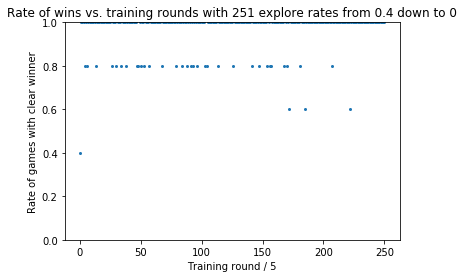

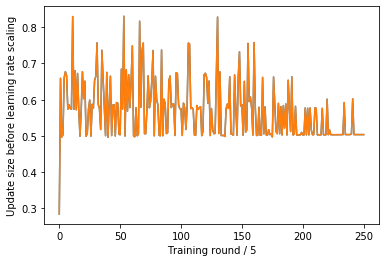

In [6]:
p134, p234 = makedynamic(5, 251, 0.2, rows=3, cols=4, movingalpha = True, stratnames='grav34final', aggover=5, 
                               numfilters=8, filtersize=3, selftrain=True)

In [9]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p134, human, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

[0, 1, 2, 3]
1
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   | x |   |   | 
---------------------

[0, 1, 2, 3]
Input your action col:2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   | x | o |   | 
---------------------

[0, 1, 2, 3]
1
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   | x |   |   | 
---------------------
2  |   | x | o |   | 
---------------------

[0, 1, 2, 3]
Input your action col:1
   | 0 | 1 | 2 | 3 |
---------------------
0  |   | o |   |   | 
---------------------
1  |   | x |   |   | 
---------------------
2  |   | x | o |   | 
---------------------

[0, 2, 3]
2
   |

1

Had to stop training 2/3 through. Restarting here. (jk didn't, but this is the code for restarting training)

In [ ]:
p134 = player('grav34final1', explore_rate=0.07, learning_rate = 0.07, board_size=[3, 4, 1])
p234 = player('grav34final2', explore_rate=0.07, learning_rate = 0.07, board_size=[3, 4, 1])
p134.states_values = keras.models.load_model('models/grav34final1')
p234.states_values = keras.models.load_model('models/grav34final2')
p134, p234 = makedynamic(5, 91, 0.07, rows=3, cols=4, movingalpha = True, stratnames='grav34final', aggover=5, 
                               numfilters=8, filtersize=3, selftrain=True, p1dynamic=p134, p2dynamic=p234)

I'll also give it a bit more training time (1.5x) for this board size. Will also try 1x and 2x since there are way more filters and I don't know how the algo will respond. Finally, will also square loss from now on and start from 0.7 alpha/epsilon (0.7^2=0.49).

Test the best performing 3x4 with square loss (double time just so time at higher learning rate matches):

0.0025




  0%|                                                                                          | 0/201 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  0%|▍                                                                               | 1/201 [00:39<2:10:56, 39.28s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  1%|▊                                                                               | 2/201 [01:17<2:09:21, 39.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  1%|█▏                                                                              | 3/201 [01:48<2:00:54, 36.64s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  2%|█▌                                                                              | 4/201 [02:27<2:02:08, 37.20s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  2%|█▉                                                                              | 5/201 [03:05<2:02:25, 37.48s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  3%|██▍                                                                             | 6/201 [03:36<1:56:00, 35.70s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  3%|██▊                                                                             | 7/201 [04:09<1:52:35, 34.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  4%|███▏                                                                            | 8/201 [04:37<1:45:26, 32.78s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  4%|███▌                                                                            | 9/201 [05:14<1:49:10, 34.12s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  5%|███▉                                                                           | 10/201 [05:46<1:46:22, 33.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  5%|████▎                                                                          | 11/201 [06:21<1:47:22, 33.91s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  6%|████▋                                                                          | 12/201 [06:57<1:48:55, 34.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  6%|█████                                                                          | 13/201 [07:42<1:57:59, 37.66s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  7%|█████▌                                                                         | 14/201 [08:14<1:51:30, 35.78s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  7%|█████▉                                                                         | 15/201 [08:53<1:54:02, 36.79s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  8%|██████▎                                                                        | 16/201 [09:32<1:55:55, 37.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  8%|██████▋                                                                        | 17/201 [10:08<1:53:16, 36.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  9%|███████                                                                        | 18/201 [10:43<1:50:55, 36.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  9%|███████▍                                                                       | 19/201 [11:27<1:57:18, 38.67s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 10%|███████▊                                                                       | 20/201 [12:05<1:56:01, 38.46s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 10%|████████▎                                                                      | 21/201 [12:45<1:56:58, 38.99s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 11%|████████▋                                                                      | 22/201 [13:23<1:55:08, 38.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 11%|█████████                                                                      | 23/201 [14:10<2:02:00, 41.13s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 12%|█████████▍                                                                     | 24/201 [14:45<1:56:21, 39.45s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 12%|█████████▊                                                                     | 25/201 [15:35<2:04:44, 42.53s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 13%|██████████▏                                                                    | 26/201 [16:21<2:06:50, 43.49s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 13%|██████████▌                                                                    | 27/201 [17:00<2:02:12, 42.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 14%|███████████                                                                    | 28/201 [17:36<1:56:06, 40.27s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 14%|███████████▍                                                                   | 29/201 [18:21<1:59:57, 41.85s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 15%|███████████▊                                                                   | 30/201 [19:07<2:02:27, 42.97s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 15%|████████████▏                                                                  | 31/201 [19:42<1:55:09, 40.64s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 16%|████████████▌                                                                  | 32/201 [20:15<1:47:59, 38.34s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 16%|████████████▉                                                                  | 33/201 [20:56<1:49:21, 39.05s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 17%|█████████████▎                                                                 | 34/201 [21:38<1:51:13, 39.96s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 17%|█████████████▊                                                                 | 35/201 [22:23<1:54:54, 41.53s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 18%|██████████████▏                                                                | 36/201 [23:07<1:56:30, 42.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 18%|██████████████▌                                                                | 37/201 [23:58<2:02:23, 44.78s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 19%|██████████████▉                                                                | 38/201 [24:33<1:54:14, 42.05s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 19%|███████████████▎                                                               | 39/201 [25:18<1:55:43, 42.86s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 20%|███████████████▋                                                               | 40/201 [25:56<1:51:10, 41.43s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 20%|████████████████                                                               | 41/201 [26:32<1:46:14, 39.84s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 21%|████████████████▌                                                              | 42/201 [27:09<1:43:15, 38.96s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 21%|████████████████▉                                                              | 43/201 [27:54<1:46:53, 40.59s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 22%|█████████████████▎                                                             | 44/201 [28:45<1:54:57, 43.93s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 22%|█████████████████▋                                                             | 45/201 [29:23<1:49:34, 42.15s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 23%|██████████████████                                                             | 46/201 [29:53<1:39:21, 38.46s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 23%|██████████████████▍                                                            | 47/201 [30:30<1:37:45, 38.09s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 24%|██████████████████▊                                                            | 48/201 [31:06<1:35:38, 37.51s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 24%|███████████████████▎                                                           | 49/201 [31:46<1:36:50, 38.23s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 25%|███████████████████▋                                                           | 50/201 [32:30<1:40:15, 39.84s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 25%|████████████████████                                                           | 51/201 [33:10<1:39:29, 39.80s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 26%|████████████████████▍                                                          | 52/201 [33:50<1:39:07, 39.91s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 26%|████████████████████▊                                                          | 53/201 [34:45<1:49:26, 44.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 27%|█████████████████████▏                                                         | 54/201 [35:57<2:09:38, 52.92s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 27%|█████████████████████▌                                                         | 55/201 [36:37<1:58:38, 48.76s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 28%|██████████████████████                                                         | 56/201 [37:13<1:48:47, 45.02s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 28%|██████████████████████▍                                                        | 57/201 [37:51<1:42:52, 42.87s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 29%|██████████████████████▊                                                        | 58/201 [38:38<1:44:59, 44.05s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 29%|███████████████████████▏                                                       | 59/201 [39:20<1:43:02, 43.54s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 30%|███████████████████████▌                                                       | 60/201 [40:09<1:46:22, 45.26s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 30%|███████████████████████▉                                                       | 61/201 [41:03<1:51:42, 47.88s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 31%|████████████████████████▎                                                      | 62/201 [41:43<1:45:13, 45.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 31%|████████████████████████▊                                                      | 63/201 [42:30<1:45:23, 45.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 32%|█████████████████████████▏                                                     | 64/201 [43:20<1:47:30, 47.08s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 32%|█████████████████████████▌                                                     | 65/201 [43:58<1:41:07, 44.62s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 33%|█████████████████████████▉                                                     | 66/201 [44:42<1:39:50, 44.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 33%|██████████████████████████▎                                                    | 67/201 [45:18<1:33:13, 41.74s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 34%|██████████████████████████▋                                                    | 68/201 [45:56<1:29:49, 40.52s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 34%|███████████████████████████                                                    | 69/201 [46:32<1:26:39, 39.39s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 35%|███████████████████████████▌                                                   | 70/201 [47:05<1:21:35, 37.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 35%|███████████████████████████▉                                                   | 71/201 [47:54<1:28:42, 40.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 36%|████████████████████████████▎                                                  | 72/201 [48:44<1:33:58, 43.71s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 36%|████████████████████████████▋                                                  | 73/201 [49:40<1:40:55, 47.31s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 37%|█████████████████████████████                                                  | 74/201 [50:14<1:31:54, 43.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 37%|█████████████████████████████▍                                                 | 75/201 [51:02<1:33:50, 44.68s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 38%|█████████████████████████████▊                                                 | 76/201 [51:46<1:32:44, 44.52s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 38%|██████████████████████████████▎                                                | 77/201 [52:32<1:32:50, 44.92s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 39%|██████████████████████████████▋                                                | 78/201 [53:22<1:35:27, 46.57s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 39%|███████████████████████████████                                                | 79/201 [54:08<1:34:13, 46.34s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 40%|███████████████████████████████▍                                               | 80/201 [54:57<1:35:10, 47.19s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 40%|███████████████████████████████▊                                               | 81/201 [55:39<1:31:10, 45.59s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 41%|████████████████████████████████▏                                              | 82/201 [56:21<1:28:15, 44.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 41%|████████████████████████████████▌                                              | 83/201 [57:11<1:30:20, 45.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 42%|█████████████████████████████████                                              | 84/201 [57:51<1:26:17, 44.26s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 42%|█████████████████████████████████▍                                             | 85/201 [58:26<1:20:21, 41.57s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 43%|█████████████████████████████████▊                                             | 86/201 [59:02<1:16:31, 39.93s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 43%|██████████████████████████████████▏                                            | 87/201 [59:51<1:20:54, 42.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 44%|█████████████████████████████████▋                                           | 88/201 [1:00:37<1:21:56, 43.51s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 44%|██████████████████████████████████                                           | 89/201 [1:01:14<1:17:30, 41.52s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 45%|██████████████████████████████████▍                                          | 90/201 [1:01:56<1:17:27, 41.87s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 45%|██████████████████████████████████▊                                          | 91/201 [1:02:42<1:19:05, 43.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 46%|███████████████████████████████████▏                                         | 92/201 [1:03:31<1:21:10, 44.68s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 46%|███████████████████████████████████▋                                         | 93/201 [1:04:22<1:24:15, 46.81s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 47%|████████████████████████████████████                                         | 94/201 [1:05:07<1:22:30, 46.27s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 47%|████████████████████████████████████▍                                        | 95/201 [1:05:54<1:22:09, 46.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 48%|████████████████████████████████████▊                                        | 96/201 [1:06:48<1:25:14, 48.71s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 48%|█████████████████████████████████████▏                                       | 97/201 [1:07:40<1:25:51, 49.53s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 49%|█████████████████████████████████████▌                                       | 98/201 [1:08:23<1:21:38, 47.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 49%|█████████████████████████████████████▉                                       | 99/201 [1:09:08<1:19:54, 47.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 50%|█████████████████████████████████████▊                                      | 100/201 [1:10:02<1:22:29, 49.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 50%|██████████████████████████████████████▏                                     | 101/201 [1:10:40<1:16:08, 45.69s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 51%|██████████████████████████████████████▌                                     | 102/201 [1:11:40<1:22:12, 49.83s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 51%|██████████████████████████████████████▉                                     | 103/201 [1:12:24<1:18:38, 48.15s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 52%|███████████████████████████████████████▎                                    | 104/201 [1:13:04<1:13:52, 45.70s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 52%|███████████████████████████████████████▋                                    | 105/201 [1:13:48<1:12:17, 45.18s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 53%|████████████████████████████████████████                                    | 106/201 [1:14:27<1:08:39, 43.36s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 53%|████████████████████████████████████████▍                                   | 107/201 [1:15:11<1:08:21, 43.64s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 54%|████████████████████████████████████████▊                                   | 108/201 [1:15:50<1:05:30, 42.26s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 54%|█████████████████████████████████████████▏                                  | 109/201 [1:16:51<1:13:25, 47.89s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 55%|█████████████████████████████████████████▌                                  | 110/201 [1:17:43<1:14:26, 49.08s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 55%|█████████████████████████████████████████▉                                  | 111/201 [1:18:20<1:08:02, 45.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 56%|██████████████████████████████████████████▎                                 | 112/201 [1:19:01<1:05:16, 44.01s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 56%|██████████████████████████████████████████▋                                 | 113/201 [1:19:42<1:03:16, 43.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 57%|███████████████████████████████████████████                                 | 114/201 [1:20:29<1:04:19, 44.36s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 57%|███████████████████████████████████████████▍                                | 115/201 [1:21:11<1:02:38, 43.71s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 58%|█████████████████████████████████████████████                                 | 116/201 [1:21:42<56:21, 39.78s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 58%|█████████████████████████████████████████████▍                                | 117/201 [1:22:24<56:47, 40.57s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 59%|█████████████████████████████████████████████▊                                | 118/201 [1:23:12<59:09, 42.76s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 59%|████████████████████████████████████████████▉                               | 119/201 [1:23:59<1:00:20, 44.15s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 60%|██████████████████████████████████████████████▌                               | 120/201 [1:24:43<59:11, 43.84s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 60%|██████████████████████████████████████████████▉                               | 121/201 [1:25:22<56:51, 42.64s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 61%|███████████████████████████████████████████████▎                              | 122/201 [1:25:58<53:18, 40.49s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 61%|███████████████████████████████████████████████▋                              | 123/201 [1:26:42<53:53, 41.45s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 62%|████████████████████████████████████████████████                              | 124/201 [1:27:22<52:47, 41.13s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 62%|████████████████████████████████████████████████▌                             | 125/201 [1:28:17<57:14, 45.19s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 63%|████████████████████████████████████████████████▉                             | 126/201 [1:28:56<54:22, 43.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 63%|█████████████████████████████████████████████████▎                            | 127/201 [1:29:39<53:17, 43.21s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 64%|█████████████████████████████████████████████████▋                            | 128/201 [1:30:31<55:47, 45.86s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 64%|██████████████████████████████████████████████████                            | 129/201 [1:31:29<59:27, 49.54s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 65%|██████████████████████████████████████████████████▍                           | 130/201 [1:32:12<56:28, 47.73s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 65%|██████████████████████████████████████████████████▊                           | 131/201 [1:32:58<54:50, 47.01s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 66%|███████████████████████████████████████████████████▏                          | 132/201 [1:33:44<53:47, 46.78s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 66%|███████████████████████████████████████████████████▌                          | 133/201 [1:34:35<54:34, 48.15s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 67%|████████████████████████████████████████████████████                          | 134/201 [1:35:38<58:29, 52.38s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 67%|████████████████████████████████████████████████████▍                         | 135/201 [1:36:19<54:04, 49.16s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 68%|████████████████████████████████████████████████████▊                         | 136/201 [1:37:18<56:31, 52.17s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 68%|█████████████████████████████████████████████████████▏                        | 137/201 [1:38:20<58:31, 54.86s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 69%|█████████████████████████████████████████████████████▌                        | 138/201 [1:39:15<57:44, 54.99s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 69%|█████████████████████████████████████████████████████▉                        | 139/201 [1:39:53<51:44, 50.07s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 70%|██████████████████████████████████████████████████████▎                       | 140/201 [1:40:45<51:26, 50.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 70%|██████████████████████████████████████████████████████▋                       | 141/201 [1:41:22<46:25, 46.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 71%|███████████████████████████████████████████████████████                       | 142/201 [1:42:12<46:48, 47.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 71%|███████████████████████████████████████████████████████▍                      | 143/201 [1:43:14<50:00, 51.74s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 72%|███████████████████████████████████████████████████████▉                      | 144/201 [1:44:04<48:50, 51.41s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 72%|████████████████████████████████████████████████████████▎                     | 145/201 [1:45:00<49:17, 52.80s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 73%|████████████████████████████████████████████████████████▋                     | 146/201 [1:46:04<51:25, 56.09s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 73%|█████████████████████████████████████████████████████████                     | 147/201 [1:47:10<53:03, 58.95s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 74%|█████████████████████████████████████████████████████████▍                    | 148/201 [1:47:59<49:24, 55.93s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 74%|█████████████████████████████████████████████████████████▊                    | 149/201 [1:48:50<47:19, 54.61s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 75%|██████████████████████████████████████████████████████████▏                   | 150/201 [1:49:33<43:29, 51.16s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 75%|██████████████████████████████████████████████████████████▌                   | 151/201 [1:50:23<42:22, 50.85s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 76%|██████████████████████████████████████████████████████████▉                   | 152/201 [1:51:24<43:51, 53.70s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 76%|███████████████████████████████████████████████████████████▎                  | 153/201 [1:52:00<38:44, 48.43s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 77%|███████████████████████████████████████████████████████████▊                  | 154/201 [1:52:46<37:30, 47.89s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 77%|████████████████████████████████████████████████████████████▏                 | 155/201 [1:53:32<36:04, 47.06s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 78%|████████████████████████████████████████████████████████████▌                 | 156/201 [1:54:15<34:31, 46.04s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 78%|████████████████████████████████████████████████████████████▉                 | 157/201 [1:54:58<33:00, 45.01s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 79%|█████████████████████████████████████████████████████████████▎                | 158/201 [1:55:51<33:56, 47.36s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 79%|█████████████████████████████████████████████████████████████▋                | 159/201 [1:56:33<32:01, 45.75s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 80%|██████████████████████████████████████████████████████████████                | 160/201 [1:57:13<30:04, 44.02s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 80%|██████████████████████████████████████████████████████████████▍               | 161/201 [1:57:52<28:25, 42.63s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 81%|██████████████████████████████████████████████████████████████▊               | 162/201 [1:58:36<27:57, 43.02s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 81%|███████████████████████████████████████████████████████████████▎              | 163/201 [1:59:20<27:21, 43.19s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 82%|███████████████████████████████████████████████████████████████▋              | 164/201 [2:00:08<27:36, 44.77s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 82%|████████████████████████████████████████████████████████████████              | 165/201 [2:01:01<28:17, 47.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 83%|████████████████████████████████████████████████████████████████▍             | 166/201 [2:01:45<27:04, 46.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 83%|████████████████████████████████████████████████████████████████▊             | 167/201 [2:02:28<25:41, 45.33s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 84%|█████████████████████████████████████████████████████████████████▏            | 168/201 [2:03:06<23:39, 43.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 84%|█████████████████████████████████████████████████████████████████▌            | 169/201 [2:03:52<23:26, 43.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 85%|█████████████████████████████████████████████████████████████████▉            | 170/201 [2:04:40<23:23, 45.27s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 85%|██████████████████████████████████████████████████████████████████▎           | 171/201 [2:05:29<23:11, 46.39s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 86%|██████████████████████████████████████████████████████████████████▋           | 172/201 [2:06:14<22:14, 46.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 86%|███████████████████████████████████████████████████████████████████▏          | 173/201 [2:06:50<19:56, 42.73s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 87%|███████████████████████████████████████████████████████████████████▌          | 174/201 [2:07:28<18:35, 41.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 87%|███████████████████████████████████████████████████████████████████▉          | 175/201 [2:08:20<19:17, 44.51s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 88%|████████████████████████████████████████████████████████████████████▎         | 176/201 [2:09:03<18:21, 44.06s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 88%|████████████████████████████████████████████████████████████████████▋         | 177/201 [2:09:50<17:59, 45.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 89%|█████████████████████████████████████████████████████████████████████         | 178/201 [2:10:51<19:05, 49.79s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 89%|█████████████████████████████████████████████████████████████████████▍        | 179/201 [2:11:37<17:52, 48.77s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 90%|█████████████████████████████████████████████████████████████████████▊        | 180/201 [2:12:19<16:23, 46.85s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 90%|██████████████████████████████████████████████████████████████████████▏       | 181/201 [2:13:10<15:59, 47.99s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 91%|██████████████████████████████████████████████████████████████████████▋       | 182/201 [2:13:55<14:52, 46.98s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 91%|███████████████████████████████████████████████████████████████████████       | 183/201 [2:14:32<13:11, 43.96s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 92%|███████████████████████████████████████████████████████████████████████▍      | 184/201 [2:15:16<12:30, 44.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 92%|███████████████████████████████████████████████████████████████████████▊      | 185/201 [2:15:56<11:25, 42.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 93%|████████████████████████████████████████████████████████████████████████▏     | 186/201 [2:16:26<09:45, 39.04s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 93%|████████████████████████████████████████████████████████████████████████▌     | 187/201 [2:17:16<09:52, 42.30s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 94%|████████████████████████████████████████████████████████████████████████▉     | 188/201 [2:18:12<10:02, 46.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 94%|█████████████████████████████████████████████████████████████████████████▎    | 189/201 [2:19:06<09:46, 48.84s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 95%|█████████████████████████████████████████████████████████████████████████▋    | 190/201 [2:19:45<08:23, 45.79s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 95%|██████████████████████████████████████████████████████████████████████████    | 191/201 [2:20:38<07:57, 47.77s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 96%|██████████████████████████████████████████████████████████████████████████▌   | 192/201 [2:21:17<06:46, 45.22s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 96%|██████████████████████████████████████████████████████████████████████████▉   | 193/201 [2:22:07<06:13, 46.70s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 97%|███████████████████████████████████████████████████████████████████████████▎  | 194/201 [2:22:46<05:11, 44.52s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 97%|███████████████████████████████████████████████████████████████████████████▋  | 195/201 [2:23:41<04:44, 47.45s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 98%|████████████████████████████████████████████████████████████████████████████  | 196/201 [2:24:27<03:55, 47.03s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 98%|████████████████████████████████████████████████████████████████████████████▍ | 197/201 [2:25:08<03:01, 45.27s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 99%|████████████████████████████████████████████████████████████████████████████▊ | 198/201 [2:25:49<02:12, 44.16s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 99%|█████████████████████████████████████████████████████████████████████████████▏| 199/201 [2:26:26<01:23, 41.98s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




100%|█████████████████████████████████████████████████████████████████████████████▌| 200/201 [2:27:07<00:41, 41.66s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [2:27:51<00:00, 44.14s/it]


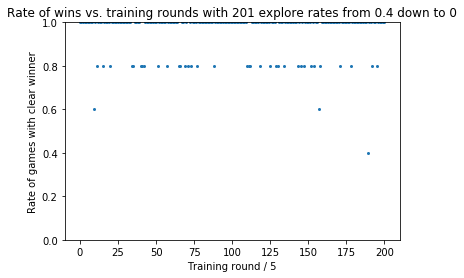

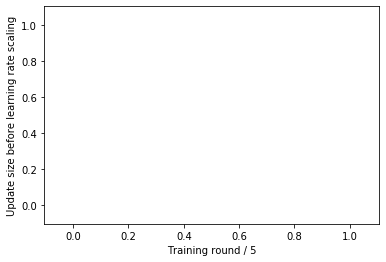

In [31]:
p134, p234 = makedynamic(5, 201, 0.5, rows=3, cols=4, movingalpha = True, stratnames='grav34final', aggover=5, 
                               numfilters=4, filtersize=3, selftrain=True, squareloss=True)
# should be 201 when not training against self, so try 101 
# since self training should be 2x efficient. 
# start at 0.5 learning rate since that worked before

0.005




  0%|                                                                                          | 0/101 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  1%|▊                                                                                 | 1/101 [00:34<57:41, 34.61s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  2%|█▌                                                                                | 2/101 [01:05<55:12, 33.46s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  3%|██▍                                                                               | 3/101 [01:38<54:42, 33.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  4%|███▏                                                                              | 4/101 [02:19<57:28, 35.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  5%|████                                                                              | 5/101 [02:58<58:50, 36.78s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  6%|████▊                                                                           | 6/101 [03:40<1:00:40, 38.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  7%|█████▌                                                                          | 7/101 [04:24<1:02:30, 39.90s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  8%|██████▎                                                                         | 8/101 [05:06<1:02:53, 40.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




  9%|███████▏                                                                        | 9/101 [05:46<1:01:46, 40.29s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 10%|███████▊                                                                       | 10/101 [06:29<1:02:21, 41.11s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 11%|████████▊                                                                        | 11/101 [06:59<56:40, 37.79s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 12%|█████████▌                                                                       | 12/101 [07:43<58:46, 39.62s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 13%|██████████▏                                                                    | 13/101 [08:28<1:00:29, 41.25s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 14%|███████████▏                                                                     | 14/101 [09:09<59:49, 41.26s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 15%|████████████                                                                     | 15/101 [09:39<54:25, 37.97s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 16%|████████████▊                                                                    | 16/101 [10:20<55:09, 38.93s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 17%|█████████████▋                                                                   | 17/101 [11:06<57:04, 40.77s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 18%|██████████████▍                                                                  | 18/101 [11:53<59:03, 42.69s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 19%|███████████████▏                                                                 | 19/101 [12:29<55:54, 40.91s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 20%|████████████████                                                                 | 20/101 [13:11<55:33, 41.15s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 21%|████████████████▊                                                                | 21/101 [13:55<55:46, 41.83s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 22%|█████████████████▋                                                               | 22/101 [14:40<56:22, 42.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 23%|██████████████████▍                                                              | 23/101 [15:13<51:59, 39.99s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 24%|███████████████████▏                                                             | 24/101 [15:49<49:54, 38.89s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 25%|████████████████████                                                             | 25/101 [16:31<50:19, 39.73s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 26%|████████████████████▊                                                            | 26/101 [17:23<54:01, 43.23s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 27%|█████████████████████▋                                                           | 27/101 [18:03<52:22, 42.47s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 28%|██████████████████████▍                                                          | 28/101 [18:53<54:15, 44.59s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 29%|███████████████████████▎                                                         | 29/101 [19:29<50:27, 42.05s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 30%|████████████████████████                                                         | 30/101 [20:04<47:25, 40.08s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 31%|████████████████████████▊                                                        | 31/101 [20:50<48:39, 41.70s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 32%|█████████████████████████▋                                                       | 32/101 [21:29<46:56, 40.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 33%|██████████████████████████▍                                                      | 33/101 [22:19<49:26, 43.63s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 34%|███████████████████████████▎                                                     | 34/101 [23:08<50:28, 45.21s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 35%|████████████████████████████                                                     | 35/101 [23:53<49:51, 45.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 36%|████████████████████████████▊                                                    | 36/101 [24:47<51:47, 47.81s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 37%|█████████████████████████████▋                                                   | 37/101 [25:27<48:34, 45.55s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 38%|██████████████████████████████▍                                                  | 38/101 [26:10<47:06, 44.86s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 39%|███████████████████████████████▎                                                 | 39/101 [26:54<45:59, 44.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 40%|████████████████████████████████                                                 | 40/101 [27:35<44:09, 43.44s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 41%|████████████████████████████████▉                                                | 41/101 [28:26<45:33, 45.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 42%|█████████████████████████████████▋                                               | 42/101 [29:06<43:23, 44.12s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 43%|██████████████████████████████████▍                                              | 43/101 [29:43<40:28, 41.87s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 44%|███████████████████████████████████▎                                             | 44/101 [30:35<42:44, 44.99s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 45%|████████████████████████████████████                                             | 45/101 [31:25<43:23, 46.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 46%|████████████████████████████████████▉                                            | 46/101 [32:07<41:22, 45.13s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 47%|█████████████████████████████████████▋                                           | 47/101 [32:51<40:16, 44.75s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 48%|██████████████████████████████████████▍                                          | 48/101 [33:35<39:20, 44.54s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 49%|███████████████████████████████████████▎                                         | 49/101 [34:32<41:56, 48.39s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 50%|████████████████████████████████████████                                         | 50/101 [35:14<39:21, 46.31s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 50%|████████████████████████████████████████▉                                        | 51/101 [35:45<34:47, 41.75s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 51%|█████████████████████████████████████████▋                                       | 52/101 [36:27<34:07, 41.79s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 52%|██████████████████████████████████████████▌                                      | 53/101 [37:20<36:10, 45.22s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 53%|███████████████████████████████████████████▎                                     | 54/101 [37:55<32:55, 42.03s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 54%|████████████████████████████████████████████                                     | 55/101 [38:29<30:27, 39.73s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 55%|████████████████████████████████████████████▉                                    | 56/101 [39:04<28:38, 38.20s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 56%|█████████████████████████████████████████████▋                                   | 57/101 [39:45<28:38, 39.05s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 57%|██████████████████████████████████████████████▌                                  | 58/101 [40:38<31:04, 43.35s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 58%|███████████████████████████████████████████████▎                                 | 59/101 [41:23<30:45, 43.95s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 59%|████████████████████████████████████████████████                                 | 60/101 [41:58<28:06, 41.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 60%|████████████████████████████████████████████████▉                                | 61/101 [42:45<28:31, 42.78s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 61%|█████████████████████████████████████████████████▋                               | 62/101 [43:35<29:18, 45.08s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 62%|██████████████████████████████████████████████████▌                              | 63/101 [44:40<32:13, 50.88s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 63%|███████████████████████████████████████████████████▎                             | 64/101 [45:30<31:18, 50.76s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 64%|████████████████████████████████████████████████████▏                            | 65/101 [46:03<27:20, 45.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 65%|████████████████████████████████████████████████████▉                            | 66/101 [46:43<25:27, 43.65s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 66%|█████████████████████████████████████████████████████▋                           | 67/101 [47:25<24:32, 43.31s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 67%|██████████████████████████████████████████████████████▌                          | 68/101 [48:04<23:04, 41.96s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 68%|███████████████████████████████████████████████████████▎                         | 69/101 [48:46<22:18, 41.83s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 69%|████████████████████████████████████████████████████████▏                        | 70/101 [49:35<22:45, 44.04s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 70%|████████████████████████████████████████████████████████▉                        | 71/101 [50:23<22:41, 45.39s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 71%|█████████████████████████████████████████████████████████▋                       | 72/101 [51:08<21:53, 45.30s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 72%|██████████████████████████████████████████████████████████▌                      | 73/101 [51:57<21:34, 46.25s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 73%|███████████████████████████████████████████████████████████▎                     | 74/101 [52:38<20:05, 44.67s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 74%|████████████████████████████████████████████████████████████▏                    | 75/101 [53:28<20:04, 46.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [54:11<18:49, 45.20s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 76%|█████████████████████████████████████████████████████████████▊                   | 77/101 [54:51<17:32, 43.87s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 77%|██████████████████████████████████████████████████████████████▌                  | 78/101 [55:43<17:43, 46.26s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 78%|███████████████████████████████████████████████████████████████▎                 | 79/101 [56:27<16:43, 45.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 79%|████████████████████████████████████████████████████████████████▏                | 80/101 [56:59<14:32, 41.55s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 80%|████████████████████████████████████████████████████████████████▉                | 81/101 [57:39<13:37, 40.88s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 81%|█████████████████████████████████████████████████████████████████▊               | 82/101 [58:14<12:27, 39.35s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 82%|██████████████████████████████████████████████████████████████████▌              | 83/101 [59:04<12:41, 42.28s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 83%|███████████████████████████████████████████████████████████████████▎             | 84/101 [59:39<11:21, 40.10s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 84%|██████████████████████████████████████████████████████████████████▍            | 85/101 [1:00:13<10:15, 38.46s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 85%|███████████████████████████████████████████████████████████████████▎           | 86/101 [1:00:57<10:01, 40.11s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 86%|████████████████████████████████████████████████████████████████████           | 87/101 [1:01:29<08:44, 37.49s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 87%|████████████████████████████████████████████████████████████████████▊          | 88/101 [1:02:09<08:21, 38.54s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 88%|█████████████████████████████████████████████████████████████████████▌         | 89/101 [1:02:51<07:51, 39.30s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 89%|██████████████████████████████████████████████████████████████████████▍        | 90/101 [1:03:47<08:08, 44.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 90%|███████████████████████████████████████████████████████████████████████▏       | 91/101 [1:04:48<08:15, 49.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 91%|███████████████████████████████████████████████████████████████████████▉       | 92/101 [1:05:38<07:26, 49.66s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 92%|████████████████████████████████████████████████████████████████████████▋      | 93/101 [1:06:25<06:29, 48.65s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 93%|█████████████████████████████████████████████████████████████████████████▌     | 94/101 [1:07:14<05:42, 48.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 94%|██████████████████████████████████████████████████████████████████████████▎    | 95/101 [1:07:57<04:41, 46.98s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 95%|███████████████████████████████████████████████████████████████████████████    | 96/101 [1:08:50<04:04, 48.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 96%|███████████████████████████████████████████████████████████████████████████▊   | 97/101 [1:09:37<03:12, 48.18s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 97%|████████████████████████████████████████████████████████████████████████████▋  | 98/101 [1:10:30<02:29, 49.85s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 99/101 [1:11:16<01:37, 48.66s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




 99%|█████████████████████████████████████████████████████████████████████████████▏| 100/101 [1:12:01<00:47, 47.54s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets




100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [1:12:48<00:00, 43.25s/it]


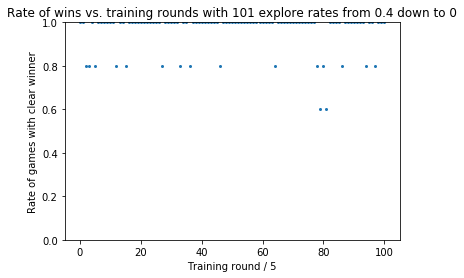

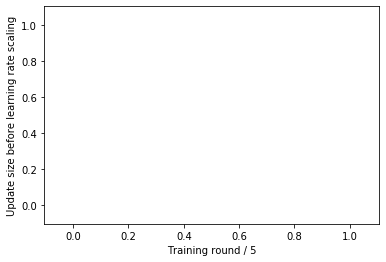

In [32]:
p134, p234 = makedynamic(5, 101, 0.5, rows=3, cols=4, movingalpha = True, stratnames='grav34final', aggover=5, 
                               numfilters=4, filtersize=3, selftrain=True, squareloss=True)
# should be 201 when not training against self, so try 101 
# since self training should be 2x efficient. 
# start at 0.5 learning rate since that worked before

Square loss with low starting LR for 8 filters. Actual final test for 3x4. Did really well! Plays to a stalemate (almost) against itself.

0.0013333333333333335


  0%|                                                                                          | 0/301 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  0%|▎                                                                               | 1/301 [00:59<4:57:10, 59.43s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  1%|▌                                                                               | 2/301 [01:37<4:23:39, 52.91s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  1%|▊                                                                               | 3/301 [02:23<4:13:25, 51.03s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  1%|█                                                                               | 4/301 [03:10<4:06:22, 49.77s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  2%|█▎                                                                              | 5/301 [03:41<3:37:34, 44.10s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  2%|█▌                                                                              | 6/301 [04:12<3:17:40, 40.20s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  2%|█▊                                                                              | 7/301 [05:06<3:37:01, 44.29s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  3%|██▏                                                                             | 8/301 [06:10<4:05:25, 50.26s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  3%|██▍                                                                             | 9/301 [06:53<3:53:36, 48.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  3%|██▌                                                                            | 10/301 [07:51<4:07:30, 51.03s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  4%|██▉                                                                            | 11/301 [08:51<4:19:41, 53.73s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  4%|███▏                                                                           | 12/301 [09:54<4:32:45, 56.63s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  4%|███▍                                                                           | 13/301 [10:36<4:10:14, 52.13s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  5%|███▋                                                                           | 14/301 [11:31<4:13:09, 52.93s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  5%|███▉                                                                           | 15/301 [12:21<4:08:22, 52.11s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  5%|████▏                                                                          | 16/301 [12:58<3:45:45, 47.53s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  6%|████▍                                                                          | 17/301 [13:39<3:36:37, 45.77s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  6%|████▋                                                                          | 18/301 [14:27<3:37:51, 46.19s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  6%|████▉                                                                          | 19/301 [15:22<3:49:44, 48.88s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  7%|█████▏                                                                         | 20/301 [16:08<3:44:47, 48.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  7%|█████▌                                                                         | 21/301 [17:05<3:57:13, 50.83s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  7%|█████▊                                                                         | 22/301 [17:47<3:44:27, 48.27s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  8%|██████                                                                         | 23/301 [18:42<3:51:41, 50.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  8%|██████▎                                                                        | 24/301 [19:11<3:22:39, 43.90s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  8%|██████▌                                                                        | 25/301 [19:59<3:27:36, 45.13s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  9%|██████▊                                                                        | 26/301 [20:35<3:13:26, 42.21s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  9%|███████                                                                        | 27/301 [21:33<3:34:20, 46.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


  9%|███████▎                                                                       | 28/301 [22:19<3:33:27, 46.91s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 10%|███████▌                                                                       | 29/301 [23:06<3:31:39, 46.69s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 10%|███████▊                                                                       | 30/301 [23:50<3:27:46, 46.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 10%|████████▏                                                                      | 31/301 [24:56<3:54:02, 52.01s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 11%|████████▍                                                                      | 32/301 [25:50<3:56:25, 52.73s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 11%|████████▋                                                                      | 33/301 [26:49<4:03:58, 54.62s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 11%|████████▉                                                                      | 34/301 [27:41<3:58:26, 53.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 12%|█████████▏                                                                     | 35/301 [28:18<3:36:21, 48.80s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 12%|█████████▍                                                                     | 36/301 [29:23<3:56:41, 53.59s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 12%|█████████▋                                                                     | 37/301 [30:10<3:47:13, 51.64s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 13%|█████████▉                                                                     | 38/301 [31:00<3:44:35, 51.24s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 13%|██████████▏                                                                    | 39/301 [32:04<3:59:36, 54.87s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 13%|██████████▍                                                                    | 40/301 [32:56<3:55:11, 54.07s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 14%|██████████▊                                                                    | 41/301 [33:40<3:41:16, 51.06s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 14%|███████████                                                                    | 42/301 [34:22<3:28:54, 48.40s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 14%|███████████▎                                                                   | 43/301 [35:15<3:33:12, 49.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 15%|███████████▌                                                                   | 44/301 [36:15<3:45:46, 52.71s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 15%|███████████▊                                                                   | 45/301 [37:06<3:42:54, 52.24s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 15%|████████████                                                                   | 46/301 [38:03<3:48:36, 53.79s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 16%|████████████▎                                                                  | 47/301 [38:44<3:31:35, 49.98s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 16%|████████████▌                                                                  | 48/301 [39:36<3:33:31, 50.64s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 16%|████████████▊                                                                  | 49/301 [40:33<3:40:21, 52.47s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 17%|█████████████                                                                  | 50/301 [41:41<3:59:23, 57.23s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 17%|█████████████▍                                                                 | 51/301 [42:44<4:05:02, 58.81s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 17%|█████████████▋                                                                 | 52/301 [43:43<4:04:28, 58.91s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 18%|█████████████▉                                                                 | 53/301 [44:45<4:06:44, 59.69s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 18%|██████████████▏                                                                | 54/301 [45:21<3:37:09, 52.75s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 18%|██████████████▍                                                                | 55/301 [46:13<3:35:28, 52.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 19%|██████████████▋                                                                | 56/301 [47:11<3:41:32, 54.26s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 19%|██████████████▉                                                                | 57/301 [48:10<3:46:01, 55.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 19%|███████████████▏                                                               | 58/301 [48:50<3:26:14, 50.92s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 20%|███████████████▍                                                               | 59/301 [49:54<3:40:31, 54.68s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 20%|███████████████▋                                                               | 60/301 [51:06<4:01:09, 60.04s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 20%|████████████████                                                               | 61/301 [51:46<3:36:01, 54.01s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 21%|████████████████▎                                                              | 62/301 [52:38<3:32:31, 53.35s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 21%|████████████████▌                                                              | 63/301 [53:20<3:18:19, 50.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 21%|████████████████▊                                                              | 64/301 [54:20<3:28:58, 52.91s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 22%|█████████████████                                                              | 65/301 [55:30<3:48:26, 58.08s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 22%|█████████████████▎                                                             | 66/301 [56:26<3:45:35, 57.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 22%|█████████████████▌                                                             | 67/301 [57:31<3:52:19, 59.57s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 23%|█████████████████▊                                                             | 68/301 [58:15<3:33:30, 54.98s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 23%|██████████████████                                                             | 69/301 [59:00<3:20:52, 51.95s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 23%|█████████████████▉                                                           | 70/301 [1:00:07<3:37:44, 56.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 24%|██████████████████▏                                                          | 71/301 [1:01:00<3:32:39, 55.48s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 24%|██████████████████▍                                                          | 72/301 [1:01:55<3:31:15, 55.35s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 24%|██████████████████▋                                                          | 73/301 [1:02:33<3:09:55, 49.98s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 25%|██████████████████▉                                                          | 74/301 [1:03:17<3:02:22, 48.21s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 25%|███████████████████▏                                                         | 75/301 [1:04:01<2:57:24, 47.10s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 25%|███████████████████▍                                                         | 76/301 [1:04:43<2:50:16, 45.41s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 26%|███████████████████▋                                                         | 77/301 [1:05:25<2:46:39, 44.64s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 26%|███████████████████▉                                                         | 78/301 [1:06:20<2:56:40, 47.53s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 26%|████████████████████▏                                                        | 79/301 [1:07:06<2:54:49, 47.25s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 27%|████████████████████▍                                                        | 80/301 [1:07:57<2:58:16, 48.40s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 27%|████████████████████▋                                                        | 81/301 [1:08:48<3:00:10, 49.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 27%|████████████████████▉                                                        | 82/301 [1:09:28<2:49:37, 46.47s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 28%|█████████████████████▏                                                       | 83/301 [1:10:13<2:46:48, 45.91s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 28%|█████████████████████▍                                                       | 84/301 [1:10:49<2:34:49, 42.81s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 28%|█████████████████████▋                                                       | 85/301 [1:11:31<2:33:13, 42.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 29%|██████████████████████                                                       | 86/301 [1:12:12<2:31:29, 42.28s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 29%|██████████████████████▎                                                      | 87/301 [1:13:08<2:45:36, 46.43s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 29%|██████████████████████▌                                                      | 88/301 [1:13:53<2:42:49, 45.86s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 30%|██████████████████████▊                                                      | 89/301 [1:14:36<2:38:52, 44.96s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 30%|███████████████████████                                                      | 90/301 [1:15:30<2:47:33, 47.65s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 30%|███████████████████████▎                                                     | 91/301 [1:16:21<2:50:31, 48.72s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 31%|███████████████████████▌                                                     | 92/301 [1:17:08<2:47:54, 48.20s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 31%|███████████████████████▊                                                     | 93/301 [1:18:04<2:55:30, 50.63s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 31%|████████████████████████                                                     | 94/301 [1:18:57<2:56:39, 51.21s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 32%|████████████████████████▎                                                    | 95/301 [1:19:37<2:45:02, 48.07s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 32%|████████████████████████▌                                                    | 96/301 [1:20:13<2:31:18, 44.29s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 32%|████████████████████████▊                                                    | 97/301 [1:20:57<2:30:47, 44.35s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 33%|█████████████████████████                                                    | 98/301 [1:21:41<2:28:50, 43.99s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 33%|█████████████████████████▎                                                   | 99/301 [1:22:39<2:42:29, 48.26s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 33%|█████████████████████████▏                                                  | 100/301 [1:23:27<2:41:49, 48.30s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 34%|█████████████████████████▌                                                  | 101/301 [1:24:12<2:37:55, 47.38s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 34%|█████████████████████████▊                                                  | 102/301 [1:25:04<2:41:14, 48.62s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 34%|██████████████████████████                                                  | 103/301 [1:25:49<2:36:49, 47.52s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 35%|██████████████████████████▎                                                 | 104/301 [1:26:44<2:43:27, 49.78s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 35%|██████████████████████████▌                                                 | 105/301 [1:27:18<2:27:21, 45.11s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 35%|██████████████████████████▊                                                 | 106/301 [1:28:17<2:39:58, 49.22s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 36%|███████████████████████████                                                 | 107/301 [1:29:08<2:40:56, 49.77s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 36%|███████████████████████████▎                                                | 108/301 [1:30:00<2:41:46, 50.29s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 36%|███████████████████████████▌                                                | 109/301 [1:30:54<2:44:45, 51.48s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 37%|███████████████████████████▊                                                | 110/301 [1:31:35<2:33:53, 48.34s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 37%|████████████████████████████                                                | 111/301 [1:32:20<2:30:22, 47.49s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 37%|████████████████████████████▎                                               | 112/301 [1:33:23<2:43:28, 51.89s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 38%|████████████████████████████▌                                               | 113/301 [1:34:13<2:41:26, 51.52s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 38%|████████████████████████████▊                                               | 114/301 [1:35:11<2:46:31, 53.43s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 38%|█████████████████████████████                                               | 115/301 [1:36:05<2:46:14, 53.63s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 39%|█████████████████████████████▎                                              | 116/301 [1:36:42<2:29:34, 48.51s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 39%|█████████████████████████████▌                                              | 117/301 [1:37:23<2:21:44, 46.22s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 39%|█████████████████████████████▊                                              | 118/301 [1:38:03<2:15:37, 44.47s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 40%|██████████████████████████████                                              | 119/301 [1:38:54<2:21:13, 46.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 40%|██████████████████████████████▎                                             | 120/301 [1:39:35<2:14:55, 44.73s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 40%|██████████████████████████████▌                                             | 121/301 [1:40:19<2:13:46, 44.59s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 41%|██████████████████████████████▊                                             | 122/301 [1:41:05<2:14:24, 45.05s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 41%|███████████████████████████████                                             | 123/301 [1:41:55<2:17:54, 46.48s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 41%|███████████████████████████████▎                                            | 124/301 [1:42:51<2:25:01, 49.16s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 42%|███████████████████████████████▌                                            | 125/301 [1:43:48<2:31:33, 51.67s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 42%|███████████████████████████████▊                                            | 126/301 [1:44:28<2:20:35, 48.20s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 42%|████████████████████████████████                                            | 127/301 [1:45:07<2:11:48, 45.45s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 43%|████████████████████████████████▎                                           | 128/301 [1:46:15<2:30:41, 52.26s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 43%|████████████████████████████████▌                                           | 129/301 [1:46:58<2:21:31, 49.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 43%|████████████████████████████████▊                                           | 130/301 [1:47:50<2:23:13, 50.25s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 44%|█████████████████████████████████                                           | 131/301 [1:48:36<2:18:20, 48.83s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 44%|█████████████████████████████████▎                                          | 132/301 [1:49:35<2:26:44, 52.10s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 44%|█████████████████████████████████▌                                          | 133/301 [1:50:29<2:27:06, 52.54s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 45%|█████████████████████████████████▊                                          | 134/301 [1:51:03<2:10:35, 46.92s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 45%|██████████████████████████████████                                          | 135/301 [1:51:54<2:13:16, 48.17s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 45%|██████████████████████████████████▎                                         | 136/301 [1:52:30<2:02:34, 44.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 46%|██████████████████████████████████▌                                         | 137/301 [1:53:31<2:14:55, 49.36s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 46%|██████████████████████████████████▊                                         | 138/301 [1:54:33<2:25:04, 53.40s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 46%|███████████████████████████████████                                         | 139/301 [1:55:16<2:15:14, 50.09s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 47%|███████████████████████████████████▎                                        | 140/301 [1:56:07<2:15:33, 50.52s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 47%|███████████████████████████████████▌                                        | 141/301 [1:56:46<2:04:56, 46.85s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 47%|███████████████████████████████████▊                                        | 142/301 [1:57:35<2:05:45, 47.46s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 48%|████████████████████████████████████                                        | 143/301 [1:58:14<1:58:43, 45.09s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 48%|████████████████████████████████████▎                                       | 144/301 [1:58:58<1:57:14, 44.80s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 48%|████████████████████████████████████▌                                       | 145/301 [1:59:45<1:58:03, 45.41s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 49%|████████████████████████████████████▊                                       | 146/301 [2:00:24<1:52:09, 43.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 49%|█████████████████████████████████████                                       | 147/301 [2:01:11<1:54:28, 44.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 49%|█████████████████████████████████████▎                                      | 148/301 [2:01:53<1:51:35, 43.76s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 50%|█████████████████████████████████████▌                                      | 149/301 [2:02:40<1:53:24, 44.76s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 50%|█████████████████████████████████████▊                                      | 150/301 [2:03:25<1:52:57, 44.88s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 50%|██████████████████████████████████████▏                                     | 151/301 [2:04:09<1:51:31, 44.61s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 50%|██████████████████████████████████████▍                                     | 152/301 [2:05:00<1:55:41, 46.59s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 51%|██████████████████████████████████████▋                                     | 153/301 [2:06:04<2:07:12, 51.57s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 51%|██████████████████████████████████████▉                                     | 154/301 [2:06:50<2:02:26, 49.98s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 51%|███████████████████████████████████████▏                                    | 155/301 [2:07:33<1:56:43, 47.97s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 52%|███████████████████████████████████████▍                                    | 156/301 [2:08:09<1:47:20, 44.41s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 52%|███████████████████████████████████████▋                                    | 157/301 [2:08:51<1:44:41, 43.62s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 52%|███████████████████████████████████████▉                                    | 158/301 [2:09:38<1:46:21, 44.62s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 53%|████████████████████████████████████████▏                                   | 159/301 [2:10:19<1:43:20, 43.67s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 53%|████████████████████████████████████████▍                                   | 160/301 [2:10:51<1:34:00, 40.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 53%|████████████████████████████████████████▋                                   | 161/301 [2:11:36<1:36:55, 41.54s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 54%|████████████████████████████████████████▉                                   | 162/301 [2:12:42<1:52:54, 48.74s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 54%|█████████████████████████████████████████▏                                  | 163/301 [2:13:42<1:59:52, 52.12s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 54%|█████████████████████████████████████████▍                                  | 164/301 [2:14:34<1:59:03, 52.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 55%|█████████████████████████████████████████▋                                  | 165/301 [2:15:19<1:53:42, 50.17s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 55%|█████████████████████████████████████████▉                                  | 166/301 [2:16:00<1:46:15, 47.22s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 55%|██████████████████████████████████████████▏                                 | 167/301 [2:16:46<1:44:36, 46.84s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 56%|██████████████████████████████████████████▍                                 | 168/301 [2:17:22<1:36:51, 43.69s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 56%|██████████████████████████████████████████▋                                 | 169/301 [2:18:12<1:39:58, 45.44s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 56%|██████████████████████████████████████████▉                                 | 170/301 [2:18:49<1:33:59, 43.05s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 57%|███████████████████████████████████████████▏                                | 171/301 [2:19:37<1:36:19, 44.46s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 57%|███████████████████████████████████████████▍                                | 172/301 [2:20:36<1:45:05, 48.88s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 57%|███████████████████████████████████████████▋                                | 173/301 [2:21:35<1:50:47, 51.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 58%|███████████████████████████████████████████▉                                | 174/301 [2:22:18<1:44:33, 49.40s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 58%|████████████████████████████████████████████▏                               | 175/301 [2:22:59<1:38:26, 46.88s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 58%|████████████████████████████████████████████▍                               | 176/301 [2:23:54<1:42:18, 49.11s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 59%|████████████████████████████████████████████▋                               | 177/301 [2:24:33<1:35:23, 46.16s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 59%|████████████████████████████████████████████▉                               | 178/301 [2:25:10<1:28:42, 43.27s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 59%|█████████████████████████████████████████████▏                              | 179/301 [2:25:41<1:20:31, 39.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 60%|█████████████████████████████████████████████▍                              | 180/301 [2:26:34<1:28:09, 43.72s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 60%|█████████████████████████████████████████████▋                              | 181/301 [2:27:19<1:28:26, 44.22s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 60%|█████████████████████████████████████████████▉                              | 182/301 [2:28:22<1:38:44, 49.78s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 61%|██████████████████████████████████████████████▏                             | 183/301 [2:29:26<1:46:30, 54.16s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 61%|██████████████████████████████████████████████▍                             | 184/301 [2:30:30<1:50:56, 56.89s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 61%|██████████████████████████████████████████████▋                             | 185/301 [2:31:06<1:37:53, 50.64s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 62%|██████████████████████████████████████████████▉                             | 186/301 [2:31:44<1:29:46, 46.84s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 62%|███████████████████████████████████████████████▏                            | 187/301 [2:32:17<1:21:20, 42.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 62%|███████████████████████████████████████████████▍                            | 188/301 [2:32:55<1:17:47, 41.30s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 63%|███████████████████████████████████████████████▋                            | 189/301 [2:33:32<1:14:50, 40.10s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 63%|███████████████████████████████████████████████▉                            | 190/301 [2:34:15<1:15:44, 40.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 63%|████████████████████████████████████████████████▏                           | 191/301 [2:35:07<1:20:54, 44.13s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 64%|████████████████████████████████████████████████▍                           | 192/301 [2:36:53<1:53:58, 62.74s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 64%|████████████████████████████████████████████████▋                           | 193/301 [2:38:37<2:15:02, 75.02s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 64%|████████████████████████████████████████████████▉                           | 194/301 [2:40:00<2:18:26, 77.63s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 65%|█████████████████████████████████████████████████▏                          | 195/301 [2:41:40<2:28:45, 84.21s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 65%|█████████████████████████████████████████████████▍                          | 196/301 [2:43:03<2:26:49, 83.90s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 65%|█████████████████████████████████████████████████▋                          | 197/301 [2:44:44<2:34:30, 89.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 66%|█████████████████████████████████████████████████▉                          | 198/301 [2:46:47<2:50:02, 99.06s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 66%|██████████████████████████████████████████████████▏                         | 199/301 [2:48:19<2:44:50, 96.96s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 66%|██████████████████████████████████████████████████▍                         | 200/301 [2:49:40<2:35:23, 92.31s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 67%|██████████████████████████████████████████████████                         | 201/301 [2:55:34<4:44:45, 170.85s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 67%|██████████████████████████████████████████████████▎                        | 202/301 [2:56:14<3:36:52, 131.43s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 67%|██████████████████████████████████████████████████▌                        | 203/301 [2:56:57<2:51:25, 104.96s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 68%|███████████████████████████████████████████████████▌                        | 204/301 [2:57:34<2:16:39, 84.53s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 68%|███████████████████████████████████████████████████▊                        | 205/301 [2:58:12<1:53:05, 70.68s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 68%|████████████████████████████████████████████████████                        | 206/301 [2:58:50<1:36:11, 60.76s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 69%|████████████████████████████████████████████████████▎                       | 207/301 [2:59:27<1:23:56, 53.59s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 69%|████████████████████████████████████████████████████▌                       | 208/301 [3:00:05<1:15:54, 48.98s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 69%|████████████████████████████████████████████████████▊                       | 209/301 [3:00:51<1:13:56, 48.22s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 70%|█████████████████████████████████████████████████████                       | 210/301 [3:01:27<1:07:21, 44.41s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 70%|█████████████████████████████████████████████████████▎                      | 211/301 [3:02:06<1:04:21, 42.90s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 70%|█████████████████████████████████████████████████████▌                      | 212/301 [3:02:43<1:00:51, 41.02s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 71%|███████████████████████████████████████████████████████▏                      | 213/301 [3:03:18<57:24, 39.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 71%|███████████████████████████████████████████████████████▍                      | 214/301 [3:03:46<52:07, 35.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 71%|███████████████████████████████████████████████████████▋                      | 215/301 [3:04:21<51:17, 35.78s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 72%|███████████████████████████████████████████████████████▉                      | 216/301 [3:05:08<55:07, 38.92s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 72%|████████████████████████████████████████████████████████▏                     | 217/301 [3:05:41<51:59, 37.13s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 72%|████████████████████████████████████████████████████████▍                     | 218/301 [3:06:17<50:56, 36.83s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 73%|████████████████████████████████████████████████████████▊                     | 219/301 [3:06:53<49:54, 36.51s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 73%|█████████████████████████████████████████████████████████                     | 220/301 [3:07:27<48:21, 35.82s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 73%|█████████████████████████████████████████████████████████▎                    | 221/301 [3:08:12<51:24, 38.55s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 74%|█████████████████████████████████████████████████████████▌                    | 222/301 [3:08:50<50:38, 38.46s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 74%|█████████████████████████████████████████████████████████▊                    | 223/301 [3:09:28<49:47, 38.30s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 74%|██████████████████████████████████████████████████████████                    | 224/301 [3:10:17<53:29, 41.69s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 75%|██████████████████████████████████████████████████████████▎                   | 225/301 [3:10:58<52:31, 41.46s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 75%|██████████████████████████████████████████████████████████▌                   | 226/301 [3:11:48<54:48, 43.84s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 75%|██████████████████████████████████████████████████████████▊                   | 227/301 [3:12:37<55:54, 45.33s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 76%|███████████████████████████████████████████████████████████                   | 228/301 [3:13:22<55:15, 45.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 76%|███████████████████████████████████████████████████████████▎                  | 229/301 [3:13:59<51:27, 42.88s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 76%|███████████████████████████████████████████████████████████▌                  | 230/301 [3:14:41<50:21, 42.55s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 77%|███████████████████████████████████████████████████████████▊                  | 231/301 [3:15:22<49:04, 42.06s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 77%|████████████████████████████████████████████████████████████                  | 232/301 [3:15:54<44:57, 39.09s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 77%|████████████████████████████████████████████████████████████▍                 | 233/301 [3:16:35<44:50, 39.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 78%|████████████████████████████████████████████████████████████▋                 | 234/301 [3:17:19<45:49, 41.04s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 78%|████████████████████████████████████████████████████████████▉                 | 235/301 [3:18:02<45:39, 41.51s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 78%|█████████████████████████████████████████████████████████████▏                | 236/301 [3:18:34<41:52, 38.65s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 79%|█████████████████████████████████████████████████████████████▍                | 237/301 [3:19:08<39:43, 37.25s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 79%|█████████████████████████████████████████████████████████████▋                | 238/301 [3:19:49<40:31, 38.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 79%|█████████████████████████████████████████████████████████████▉                | 239/301 [3:20:19<36:57, 35.76s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 80%|██████████████████████████████████████████████████████████████▏               | 240/301 [3:21:01<38:20, 37.71s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 80%|██████████████████████████████████████████████████████████████▍               | 241/301 [3:21:46<39:55, 39.92s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 80%|██████████████████████████████████████████████████████████████▋               | 242/301 [3:22:17<36:36, 37.23s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 81%|██████████████████████████████████████████████████████████████▉               | 243/301 [3:22:59<37:17, 38.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 81%|███████████████████████████████████████████████████████████████▏              | 244/301 [3:23:42<37:56, 39.94s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 81%|███████████████████████████████████████████████████████████████▍              | 245/301 [3:24:20<36:50, 39.47s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 82%|███████████████████████████████████████████████████████████████▋              | 246/301 [3:25:10<39:00, 42.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 82%|████████████████████████████████████████████████████████████████              | 247/301 [3:25:54<38:49, 43.14s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 82%|████████████████████████████████████████████████████████████████▎             | 248/301 [3:26:22<34:00, 38.50s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 83%|████████████████████████████████████████████████████████████████▌             | 249/301 [3:27:08<35:24, 40.85s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 83%|████████████████████████████████████████████████████████████████▊             | 250/301 [3:27:45<33:37, 39.56s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 83%|█████████████████████████████████████████████████████████████████             | 251/301 [3:28:22<32:22, 38.85s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 84%|█████████████████████████████████████████████████████████████████▎            | 252/301 [3:29:07<33:19, 40.80s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 84%|█████████████████████████████████████████████████████████████████▌            | 253/301 [3:29:57<34:49, 43.53s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 84%|█████████████████████████████████████████████████████████████████▊            | 254/301 [3:30:43<34:39, 44.25s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 85%|██████████████████████████████████████████████████████████████████            | 255/301 [3:31:32<35:03, 45.73s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 85%|██████████████████████████████████████████████████████████████████▎           | 256/301 [3:32:11<32:33, 43.42s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 85%|██████████████████████████████████████████████████████████████████▌           | 257/301 [3:32:52<31:20, 42.73s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 86%|██████████████████████████████████████████████████████████████████▊           | 258/301 [3:33:38<31:26, 43.87s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 86%|███████████████████████████████████████████████████████████████████           | 259/301 [3:34:18<29:51, 42.66s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 86%|███████████████████████████████████████████████████████████████████▍          | 260/301 [3:35:00<29:06, 42.60s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 87%|███████████████████████████████████████████████████████████████████▋          | 261/301 [3:35:39<27:34, 41.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 87%|███████████████████████████████████████████████████████████████████▉          | 262/301 [3:36:31<28:54, 44.48s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 87%|████████████████████████████████████████████████████████████████████▏         | 263/301 [3:37:13<27:50, 43.97s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 88%|████████████████████████████████████████████████████████████████████▍         | 264/301 [3:37:59<27:21, 44.38s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 88%|████████████████████████████████████████████████████████████████████▋         | 265/301 [3:38:36<25:17, 42.16s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 88%|████████████████████████████████████████████████████████████████████▉         | 266/301 [3:39:20<24:56, 42.77s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 89%|█████████████████████████████████████████████████████████████████████▏        | 267/301 [3:40:00<23:44, 41.90s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 89%|█████████████████████████████████████████████████████████████████████▍        | 268/301 [3:40:39<22:33, 41.02s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 89%|█████████████████████████████████████████████████████████████████████▋        | 269/301 [3:41:08<20:02, 37.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 90%|█████████████████████████████████████████████████████████████████████▉        | 270/301 [3:41:53<20:31, 39.73s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 90%|██████████████████████████████████████████████████████████████████████▏       | 271/301 [3:42:32<19:42, 39.43s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 90%|██████████████████████████████████████████████████████████████████████▍       | 272/301 [3:43:15<19:32, 40.44s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 91%|██████████████████████████████████████████████████████████████████████▋       | 273/301 [3:43:56<18:56, 40.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 91%|███████████████████████████████████████████████████████████████████████       | 274/301 [3:44:27<17:02, 37.86s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 91%|███████████████████████████████████████████████████████████████████████▎      | 275/301 [3:45:00<15:45, 36.37s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 92%|███████████████████████████████████████████████████████████████████████▌      | 276/301 [3:45:38<15:22, 36.89s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 92%|███████████████████████████████████████████████████████████████████████▊      | 277/301 [3:46:07<13:47, 34.48s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 92%|████████████████████████████████████████████████████████████████████████      | 278/301 [3:46:52<14:29, 37.79s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 93%|████████████████████████████████████████████████████████████████████████▎     | 279/301 [3:47:26<13:24, 36.58s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 93%|████████████████████████████████████████████████████████████████████████▌     | 280/301 [3:48:02<12:41, 36.24s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 93%|████████████████████████████████████████████████████████████████████████▊     | 281/301 [3:49:14<15:40, 47.02s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 94%|█████████████████████████████████████████████████████████████████████████     | 282/301 [3:51:37<24:03, 75.95s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 94%|█████████████████████████████████████████████████████████████████████████▎    | 283/301 [3:53:27<25:48, 86.00s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 94%|█████████████████████████████████████████████████████████████████████████▌    | 284/301 [3:54:33<22:42, 80.12s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 95%|█████████████████████████████████████████████████████████████████████████▊    | 285/301 [3:54:58<16:55, 63.48s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 95%|██████████████████████████████████████████████████████████████████████████    | 286/301 [3:55:33<13:46, 55.09s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 95%|██████████████████████████████████████████████████████████████████████████▎   | 287/301 [3:56:01<10:56, 46.88s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 96%|██████████████████████████████████████████████████████████████████████████▋   | 288/301 [3:56:44<09:52, 45.61s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 96%|██████████████████████████████████████████████████████████████████████████▉   | 289/301 [3:57:34<09:25, 47.16s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 96%|███████████████████████████████████████████████████████████████████████████▏  | 290/301 [3:58:10<07:59, 43.63s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 97%|███████████████████████████████████████████████████████████████████████████▍  | 291/301 [3:58:49<07:03, 42.32s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 97%|███████████████████████████████████████████████████████████████████████████▋  | 292/301 [3:59:35<06:30, 43.43s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 97%|███████████████████████████████████████████████████████████████████████████▉  | 293/301 [4:00:16<05:41, 42.69s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 98%|████████████████████████████████████████████████████████████████████████████▏ | 294/301 [4:01:00<05:01, 43.12s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 98%|████████████████████████████████████████████████████████████████████████████▍ | 295/301 [4:01:28<03:50, 38.41s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 98%|████████████████████████████████████████████████████████████████████████████▋ | 296/301 [4:01:58<03:00, 36.02s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 99%|████████████████████████████████████████████████████████████████████████████▉ | 297/301 [4:02:45<02:36, 39.18s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 99%|█████████████████████████████████████████████████████████████████████████████▏| 298/301 [4:03:35<02:07, 42.66s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


 99%|█████████████████████████████████████████████████████████████████████████████▍| 299/301 [4:04:23<01:28, 44.18s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


100%|█████████████████████████████████████████████████████████████████████████████▋| 300/301 [4:05:09<00:44, 44.71s/it]

INFO:tensorflow:Assets written to: models/grav34final1\assets
INFO:tensorflow:Assets written to: models/grav34final2\assets


100%|██████████████████████████████████████████████████████████████████████████████| 301/301 [4:05:47<00:00, 49.00s/it]


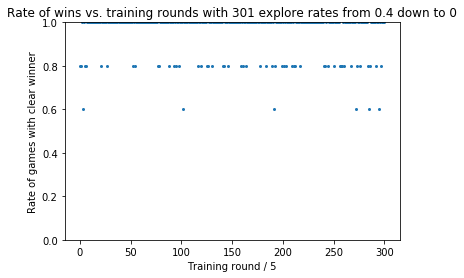

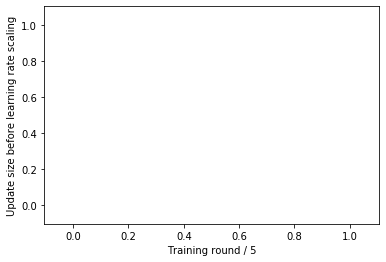

In [10]:
p134, p234 = makedynamic(5, 301, 0.4, rows=3, cols=4, movingalpha = True, stratnames='grav34final', aggover=5, 
                               numfilters=8, filtersize=3, selftrain=True, squareloss=True)
# starting at 0.4 is actually starting at 0.16 since we square the loss function

In [14]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p134, p134, numrows=3, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------

[0, 1, 2, 3]
0
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | x |   |   |   | 
---------------------

[0, 1, 2, 3]
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | x |   | o |   | 
---------------------

[0, 1, 2, 3]
3
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | x |   | o | x | 
---------------------

[0, 1, 2, 3]
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  | o |   |   |   | 
---------------------
2  | x |   | o | x | 
---------------------

[0, 1, 2, 3]
2
   | 0 | 1 | 2 | 3 |
---------------------
0  |  

1

Actually, square loss seems to be bad for fewer filters, better for more filters, and better for lower LR since it keeps us at a lower LR for longer, which is good for lots of filters which get confused. 

More examples of its failure below for 4x4. I also think we're using way too many filters below, so that's what's throwing it off.

0.006999999999999999




  0%|                                                                                          | 0/101 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  1%|▊                                                                               | 1/101 [00:48<1:21:10, 48.71s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  2%|█▌                                                                              | 2/101 [01:23<1:13:31, 44.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  3%|██▍                                                                             | 3/101 [01:59<1:08:31, 41.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  4%|███▏                                                                            | 4/101 [02:40<1:07:16, 41.62s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  5%|███▉                                                                            | 5/101 [03:12<1:02:13, 38.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  6%|████▊                                                                           | 6/101 [03:58<1:05:00, 41.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  7%|█████▌                                                                          | 7/101 [05:00<1:14:10, 47.35s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  8%|██████▎                                                                         | 8/101 [05:58<1:18:10, 50.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  9%|███████▏                                                                        | 9/101 [06:46<1:16:18, 49.77s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 10%|███████▊                                                                       | 10/101 [07:15<1:05:54, 43.46s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 11%|████████▌                                                                      | 11/101 [08:05<1:08:03, 45.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 12%|█████████▍                                                                     | 12/101 [08:48<1:06:19, 44.71s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 13%|██████████▏                                                                    | 13/101 [09:44<1:10:24, 48.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 14%|██████████▉                                                                    | 14/101 [10:32<1:09:35, 48.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 15%|███████████▋                                                                   | 15/101 [11:22<1:09:33, 48.53s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 16%|████████████▌                                                                  | 16/101 [12:10<1:08:34, 48.40s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 17%|█████████████▎                                                                 | 17/101 [13:12<1:13:27, 52.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 18%|██████████████                                                                 | 18/101 [14:05<1:13:08, 52.87s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 19%|██████████████▊                                                                | 19/101 [14:57<1:11:55, 52.63s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 20%|███████████████▋                                                               | 20/101 [17:33<1:52:46, 83.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 21%|████████████████▍                                                              | 21/101 [19:26<2:03:06, 92.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 22%|████████████████▉                                                             | 22/101 [21:44<2:19:44, 106.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 23%|█████████████████▊                                                            | 23/101 [23:49<2:25:16, 111.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 24%|██████████████████▌                                                           | 24/101 [25:39<2:22:30, 111.04s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 25%|███████████████████▎                                                          | 25/101 [27:42<2:25:16, 114.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 26%|████████████████████                                                          | 26/101 [29:35<2:22:53, 114.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 27%|████████████████████▊                                                         | 27/101 [32:10<2:35:51, 126.37s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 28%|█████████████████████▌                                                        | 28/101 [34:16<2:33:37, 126.27s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 29%|██████████████████████▋                                                        | 29/101 [34:54<1:59:52, 99.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 30%|███████████████████████▍                                                       | 30/101 [35:28<1:34:48, 80.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 31%|████████████████████████▏                                                      | 31/101 [36:07<1:18:54, 67.64s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 32%|█████████████████████████                                                      | 32/101 [36:35<1:04:18, 55.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 33%|██████████████████████████▍                                                      | 33/101 [37:16<58:12, 51.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 34%|███████████████████████████▎                                                     | 34/101 [38:06<56:58, 51.02s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 35%|████████████████████████████                                                     | 35/101 [38:37<49:38, 45.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 36%|████████████████████████████▊                                                    | 36/101 [39:11<45:11, 41.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 37%|█████████████████████████████▋                                                   | 37/101 [39:39<39:55, 37.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 38%|██████████████████████████████▍                                                  | 38/101 [40:22<41:03, 39.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 39%|███████████████████████████████▎                                                 | 39/101 [41:04<41:32, 40.21s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 40%|████████████████████████████████                                                 | 40/101 [41:53<43:22, 42.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 41%|████████████████████████████████▉                                                | 41/101 [42:32<41:35, 41.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 42%|█████████████████████████████████▋                                               | 42/101 [43:13<40:36, 41.29s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 43%|██████████████████████████████████▍                                              | 43/101 [43:53<39:40, 41.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 44%|███████████████████████████████████▎                                             | 44/101 [44:41<41:02, 43.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 45%|████████████████████████████████████                                             | 45/101 [45:26<40:49, 43.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 46%|████████████████████████████████████▉                                            | 46/101 [46:06<39:01, 42.58s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 47%|█████████████████████████████████████▋                                           | 47/101 [46:48<38:15, 42.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 48%|██████████████████████████████████████▍                                          | 48/101 [47:20<34:46, 39.37s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 49%|███████████████████████████████████████▎                                         | 49/101 [48:04<35:12, 40.63s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 50%|████████████████████████████████████████                                         | 50/101 [48:39<33:08, 38.98s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 50%|████████████████████████████████████████▉                                        | 51/101 [49:18<32:26, 38.94s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 51%|█████████████████████████████████████████▋                                       | 52/101 [49:57<31:49, 38.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 52%|██████████████████████████████████████████▌                                      | 53/101 [50:47<33:41, 42.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 53%|███████████████████████████████████████████▎                                     | 54/101 [51:20<31:04, 39.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 54%|████████████████████████████████████████████                                     | 55/101 [52:11<33:00, 43.04s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 55%|████████████████████████████████████████████▉                                    | 56/101 [52:43<29:43, 39.64s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 56%|█████████████████████████████████████████████▋                                   | 57/101 [53:15<27:16, 37.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 57%|██████████████████████████████████████████████▌                                  | 58/101 [53:59<28:16, 39.46s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 58%|███████████████████████████████████████████████▎                                 | 59/101 [54:39<27:38, 39.49s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 59%|████████████████████████████████████████████████                                 | 60/101 [55:15<26:19, 38.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 60%|████████████████████████████████████████████████▉                                | 61/101 [56:02<27:15, 40.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 61%|█████████████████████████████████████████████████▋                               | 62/101 [56:48<27:43, 42.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 62%|██████████████████████████████████████████████████▌                              | 63/101 [57:35<27:48, 43.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 63%|███████████████████████████████████████████████████▎                             | 64/101 [58:32<29:29, 47.81s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 64%|████████████████████████████████████████████████████▏                            | 65/101 [59:08<26:33, 44.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 65%|████████████████████████████████████████████████████▉                            | 66/101 [59:47<24:49, 42.55s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 66%|████████████████████████████████████████████████████▍                          | 67/101 [1:00:34<24:57, 44.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 67%|█████████████████████████████████████████████████████▏                         | 68/101 [1:01:19<24:21, 44.29s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 68%|█████████████████████████████████████████████████████▉                         | 69/101 [1:02:09<24:30, 45.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 69%|██████████████████████████████████████████████████████▊                        | 70/101 [1:02:51<23:07, 44.77s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 70%|███████████████████████████████████████████████████████▌                       | 71/101 [1:03:26<20:56, 41.87s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 71%|████████████████████████████████████████████████████████▎                      | 72/101 [1:04:07<20:06, 41.61s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 72%|█████████████████████████████████████████████████████████                      | 73/101 [1:04:50<19:37, 42.07s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 73%|█████████████████████████████████████████████████████████▉                     | 74/101 [1:05:33<18:59, 42.21s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 74%|██████████████████████████████████████████████████████████▋                    | 75/101 [1:06:19<18:45, 43.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 75%|███████████████████████████████████████████████████████████▍                   | 76/101 [1:07:04<18:19, 43.97s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 76%|████████████████████████████████████████████████████████████▏                  | 77/101 [1:08:09<20:03, 50.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 77%|█████████████████████████████████████████████████████████████                  | 78/101 [1:08:44<17:29, 45.62s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 78%|█████████████████████████████████████████████████████████████▊                 | 79/101 [1:09:26<16:21, 44.61s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 79%|██████████████████████████████████████████████████████████████▌                | 80/101 [1:10:10<15:31, 44.34s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 80%|███████████████████████████████████████████████████████████████▎               | 81/101 [1:10:47<14:02, 42.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 81%|████████████████████████████████████████████████████████████████▏              | 82/101 [1:11:22<12:40, 40.04s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 82%|████████████████████████████████████████████████████████████████▉              | 83/101 [1:11:54<11:17, 37.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 83%|█████████████████████████████████████████████████████████████████▋             | 84/101 [1:12:44<11:44, 41.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 84%|██████████████████████████████████████████████████████████████████▍            | 85/101 [1:13:28<11:17, 42.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 85%|███████████████████████████████████████████████████████████████████▎           | 86/101 [1:14:17<11:04, 44.30s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 86%|████████████████████████████████████████████████████████████████████           | 87/101 [1:15:05<10:33, 45.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 87%|████████████████████████████████████████████████████████████████████▊          | 88/101 [1:15:49<09:43, 44.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 88%|█████████████████████████████████████████████████████████████████████▌         | 89/101 [1:16:34<09:00, 45.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 89%|██████████████████████████████████████████████████████████████████████▍        | 90/101 [1:17:07<07:34, 41.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 90%|███████████████████████████████████████████████████████████████████████▏       | 91/101 [1:17:44<06:39, 39.94s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 91%|███████████████████████████████████████████████████████████████████████▉       | 92/101 [1:18:26<06:06, 40.68s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 92%|████████████████████████████████████████████████████████████████████████▋      | 93/101 [1:19:05<05:20, 40.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 93%|█████████████████████████████████████████████████████████████████████████▌     | 94/101 [1:19:47<04:44, 40.59s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 94%|██████████████████████████████████████████████████████████████████████████▎    | 95/101 [1:20:26<04:01, 40.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 95%|███████████████████████████████████████████████████████████████████████████    | 96/101 [1:20:57<03:08, 37.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 96%|███████████████████████████████████████████████████████████████████████████▊   | 97/101 [1:21:46<02:43, 40.83s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 97%|████████████████████████████████████████████████████████████████████████████▋  | 98/101 [1:22:26<02:01, 40.61s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 99/101 [1:23:02<01:18, 39.37s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 99%|█████████████████████████████████████████████████████████████████████████████▏| 100/101 [1:23:42<00:39, 39.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [1:24:27<00:00, 50.17s/it]


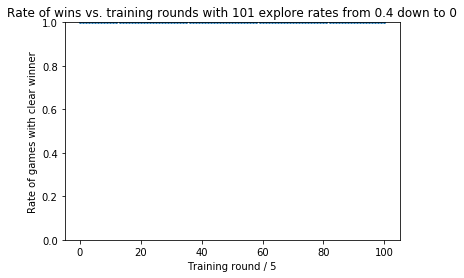

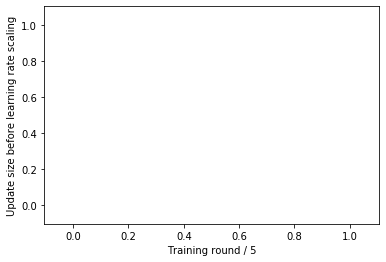

In [24]:
p144100, p244100 = makedynamic(5, 101, 0.7, rows=4, cols=4, movingalpha = True, stratnames='grav44final', 
                                         aggover=5, numfilters=16, filtersize=3, selftrain=True, squareloss=True)

0.004666666666666666




  0%|                                                                                          | 0/151 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  1%|▌                                                                               | 1/151 [00:37<1:33:00, 37.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  1%|█                                                                               | 2/151 [01:29<1:43:25, 41.65s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  2%|█▌                                                                              | 3/151 [02:12<1:43:41, 42.04s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  3%|██                                                                              | 4/151 [02:44<1:35:44, 39.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  3%|██▋                                                                             | 5/151 [03:27<1:37:47, 40.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  4%|███▏                                                                            | 6/151 [04:20<1:46:46, 44.18s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  5%|███▋                                                                            | 7/151 [05:01<1:43:53, 43.29s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  5%|████▏                                                                           | 8/151 [05:40<1:39:53, 41.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  6%|████▊                                                                           | 9/151 [06:20<1:37:33, 41.22s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  7%|█████▏                                                                         | 10/151 [06:59<1:35:49, 40.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  7%|█████▊                                                                         | 11/151 [07:37<1:32:55, 39.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  8%|██████▎                                                                        | 12/151 [08:27<1:39:33, 42.98s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  9%|██████▊                                                                        | 13/151 [09:06<1:35:38, 41.58s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  9%|███████▎                                                                       | 14/151 [09:58<1:42:16, 44.80s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 10%|███████▊                                                                       | 15/151 [10:48<1:45:27, 46.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 11%|████████▎                                                                      | 16/151 [11:31<1:41:57, 45.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 11%|████████▉                                                                      | 17/151 [12:15<1:40:21, 44.94s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 12%|█████████▍                                                                     | 18/151 [12:54<1:35:36, 43.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 13%|█████████▉                                                                     | 19/151 [13:33<1:32:25, 42.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 13%|██████████▍                                                                    | 20/151 [14:17<1:32:57, 42.57s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 14%|██████████▉                                                                    | 21/151 [14:55<1:29:10, 41.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 15%|███████████▌                                                                   | 22/151 [15:35<1:27:53, 40.88s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 15%|████████████                                                                   | 23/151 [16:12<1:24:49, 39.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 16%|████████████▌                                                                  | 24/151 [16:52<1:23:43, 39.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 17%|█████████████                                                                  | 25/151 [17:30<1:22:11, 39.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 17%|█████████████▌                                                                 | 26/151 [18:04<1:18:42, 37.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 18%|██████████████▏                                                                | 27/151 [18:33<1:12:22, 35.02s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 19%|██████████████▋                                                                | 28/151 [19:11<1:13:56, 36.07s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 19%|███████████████▏                                                               | 29/151 [19:56<1:18:47, 38.75s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 20%|███████████████▋                                                               | 30/151 [20:31<1:15:37, 37.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 21%|████████████████▏                                                              | 31/151 [21:15<1:18:48, 39.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 21%|████████████████▋                                                              | 32/151 [22:04<1:24:13, 42.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 22%|█████████████████▎                                                             | 33/151 [22:34<1:15:53, 38.59s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 23%|█████████████████▊                                                             | 34/151 [23:01<1:08:39, 35.21s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 23%|██████████████████▎                                                            | 35/151 [23:46<1:13:26, 37.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 24%|██████████████████▊                                                            | 36/151 [24:22<1:11:30, 37.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 25%|███████████████████▎                                                           | 37/151 [24:56<1:09:13, 36.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 25%|███████████████████▉                                                           | 38/151 [25:30<1:07:16, 35.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 26%|████████████████████▍                                                          | 39/151 [26:24<1:16:59, 41.25s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 26%|████████████████████▉                                                          | 40/151 [27:02<1:14:20, 40.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 27%|█████████████████████▍                                                         | 41/151 [27:30<1:07:09, 36.63s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 28%|█████████████████████▉                                                         | 42/151 [28:00<1:02:43, 34.53s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 28%|██████████████████████▍                                                        | 43/151 [28:32<1:00:59, 33.88s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 29%|███████████████████████                                                        | 44/151 [29:07<1:00:47, 34.09s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 30%|███████████████████████▌                                                       | 45/151 [29:51<1:05:42, 37.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 30%|████████████████████████                                                       | 46/151 [30:29<1:05:21, 37.35s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 31%|████████████████████████▌                                                      | 47/151 [31:05<1:04:13, 37.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 32%|█████████████████████████                                                      | 48/151 [31:42<1:03:34, 37.04s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 32%|█████████████████████████▋                                                     | 49/151 [32:16<1:01:04, 35.93s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 33%|██████████████████████████▏                                                    | 50/151 [33:00<1:04:58, 38.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 34%|██████████████████████████▋                                                    | 51/151 [33:35<1:02:15, 37.35s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 34%|███████████████████████████▏                                                   | 52/151 [34:14<1:02:37, 37.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 35%|███████████████████████████▋                                                   | 53/151 [34:57<1:04:19, 39.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 36%|████████████████████████████▎                                                  | 54/151 [35:39<1:05:12, 40.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 36%|████████████████████████████▊                                                  | 55/151 [36:24<1:06:20, 41.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 37%|█████████████████████████████▎                                                 | 56/151 [37:09<1:07:28, 42.61s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 38%|█████████████████████████████▊                                                 | 57/151 [37:48<1:04:53, 41.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 38%|██████████████████████████████▎                                                | 58/151 [38:30<1:04:46, 41.79s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 39%|██████████████████████████████▊                                                | 59/151 [39:07<1:01:56, 40.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 40%|███████████████████████████████▍                                               | 60/151 [39:58<1:05:50, 43.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 40%|████████████████████████████████▋                                                | 61/151 [40:22<56:30, 37.68s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 41%|█████████████████████████████████▎                                               | 62/151 [40:56<54:04, 36.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 42%|█████████████████████████████████▊                                               | 63/151 [41:32<53:22, 36.40s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 42%|██████████████████████████████████▎                                              | 64/151 [42:14<55:17, 38.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 43%|██████████████████████████████████▊                                              | 65/151 [42:41<49:48, 34.75s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 44%|███████████████████████████████████▍                                             | 66/151 [43:14<48:26, 34.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 44%|███████████████████████████████████▉                                             | 67/151 [43:50<48:40, 34.77s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 45%|████████████████████████████████████▍                                            | 68/151 [44:29<49:41, 35.93s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 46%|█████████████████████████████████████                                            | 69/151 [45:06<49:31, 36.24s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 46%|█████████████████████████████████████▌                                           | 70/151 [45:38<47:26, 35.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 47%|██████████████████████████████████████                                           | 71/151 [46:32<54:09, 40.61s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 48%|██████████████████████████████████████▌                                          | 72/151 [47:13<53:51, 40.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 48%|███████████████████████████████████████▏                                         | 73/151 [47:57<54:25, 41.86s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 49%|███████████████████████████████████████▋                                         | 74/151 [48:34<51:42, 40.29s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 50%|████████████████████████████████████████▏                                        | 75/151 [49:07<48:13, 38.07s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 50%|████████████████████████████████████████▊                                        | 76/151 [49:46<48:12, 38.57s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 51%|█████████████████████████████████████████▎                                       | 77/151 [50:37<52:11, 42.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 52%|█████████████████████████████████████████▊                                       | 78/151 [51:18<50:41, 41.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 52%|██████████████████████████████████████████▍                                      | 79/151 [51:56<48:55, 40.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 53%|██████████████████████████████████████████▉                                      | 80/151 [52:35<47:29, 40.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 54%|███████████████████████████████████████████▍                                     | 81/151 [53:24<49:48, 42.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 54%|███████████████████████████████████████████▉                                     | 82/151 [53:59<46:30, 40.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 55%|████████████████████████████████████████████▌                                    | 83/151 [54:53<50:27, 44.53s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 56%|█████████████████████████████████████████████                                    | 84/151 [55:35<48:51, 43.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 56%|█████████████████████████████████████████████▌                                   | 85/151 [56:04<43:20, 39.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 57%|██████████████████████████████████████████████▏                                  | 86/151 [56:53<45:38, 42.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 58%|██████████████████████████████████████████████▋                                  | 87/151 [57:36<45:30, 42.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 58%|███████████████████████████████████████████████▏                                 | 88/151 [58:22<45:40, 43.51s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 59%|███████████████████████████████████████████████▋                                 | 89/151 [58:59<43:06, 41.71s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 60%|████████████████████████████████████████████████▎                                | 90/151 [59:44<43:22, 42.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 60%|███████████████████████████████████████████████▌                               | 91/151 [1:00:25<42:04, 42.07s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 61%|████████████████████████████████████████████████▏                              | 92/151 [1:01:20<45:18, 46.07s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 62%|████████████████████████████████████████████████▋                              | 93/151 [1:02:15<47:00, 48.63s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 62%|█████████████████████████████████████████████████▏                             | 94/151 [1:02:59<44:43, 47.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 63%|█████████████████████████████████████████████████▋                             | 95/151 [1:03:53<45:52, 49.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 64%|██████████████████████████████████████████████████▏                            | 96/151 [1:04:31<42:04, 45.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 64%|██████████████████████████████████████████████████▋                            | 97/151 [1:05:12<39:59, 44.44s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 65%|███████████████████████████████████████████████████▎                           | 98/151 [1:05:45<36:12, 40.98s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 66%|███████████████████████████████████████████████████▊                           | 99/151 [1:06:37<38:21, 44.27s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 66%|███████████████████████████████████████████████████▋                          | 100/151 [1:07:20<37:16, 43.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 67%|████████████████████████████████████████████████████▏                         | 101/151 [1:08:03<36:20, 43.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 68%|████████████████████████████████████████████████████▋                         | 102/151 [1:08:56<38:01, 46.57s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 68%|█████████████████████████████████████████████████████▏                        | 103/151 [1:09:37<35:46, 44.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 69%|█████████████████████████████████████████████████████▋                        | 104/151 [1:10:18<34:21, 43.86s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 70%|██████████████████████████████████████████████████████▏                       | 105/151 [1:10:58<32:37, 42.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 70%|██████████████████████████████████████████████████████▊                       | 106/151 [1:12:08<38:06, 50.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 71%|███████████████████████████████████████████████████████▎                      | 107/151 [1:13:06<38:55, 53.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 72%|███████████████████████████████████████████████████████▊                      | 108/151 [1:14:16<41:37, 58.09s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 72%|████████████████████████████████████████████████████████▎                     | 109/151 [1:15:01<37:58, 54.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 73%|████████████████████████████████████████████████████████▊                     | 110/151 [1:15:58<37:37, 55.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 74%|█████████████████████████████████████████████████████████▎                    | 111/151 [1:17:08<39:34, 59.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 74%|█████████████████████████████████████████████████████████▊                    | 112/151 [1:17:55<36:12, 55.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 75%|██████████████████████████████████████████████████████████▎                   | 113/151 [1:19:00<37:02, 58.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 75%|██████████████████████████████████████████████████████████▉                   | 114/151 [1:20:11<38:20, 62.18s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 76%|███████████████████████████████████████████████████████████▍                  | 115/151 [1:21:11<36:55, 61.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 77%|███████████████████████████████████████████████████████████▉                  | 116/151 [1:21:55<32:54, 56.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 77%|████████████████████████████████████████████████████████████▍                 | 117/151 [1:22:46<31:05, 54.87s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 78%|████████████████████████████████████████████████████████████▉                 | 118/151 [1:23:34<29:01, 52.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 79%|█████████████████████████████████████████████████████████████▍                | 119/151 [1:24:47<31:17, 58.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 79%|█████████████████████████████████████████████████████████████▉                | 120/151 [1:25:40<29:31, 57.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 80%|██████████████████████████████████████████████████████████████▌               | 121/151 [1:26:33<27:53, 55.80s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 81%|███████████████████████████████████████████████████████████████               | 122/151 [1:27:08<23:54, 49.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 81%|███████████████████████████████████████████████████████████████▌              | 123/151 [1:27:53<22:28, 48.18s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 82%|████████████████████████████████████████████████████████████████              | 124/151 [1:28:46<22:22, 49.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 83%|████████████████████████████████████████████████████████████████▌             | 125/151 [1:29:26<20:14, 46.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 83%|█████████████████████████████████████████████████████████████████             | 126/151 [1:30:04<18:21, 44.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 84%|█████████████████████████████████████████████████████████████████▌            | 127/151 [1:30:49<17:45, 44.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 85%|██████████████████████████████████████████████████████████████████            | 128/151 [1:31:17<15:05, 39.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 85%|██████████████████████████████████████████████████████████████████▋           | 129/151 [1:31:45<13:12, 36.02s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 86%|███████████████████████████████████████████████████████████████████▏          | 130/151 [1:32:29<13:26, 38.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 87%|███████████████████████████████████████████████████████████████████▋          | 131/151 [1:33:19<14:01, 42.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 87%|████████████████████████████████████████████████████████████████████▏         | 132/151 [1:34:00<13:09, 41.55s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 88%|████████████████████████████████████████████████████████████████████▋         | 133/151 [1:34:28<11:18, 37.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 89%|█████████████████████████████████████████████████████████████████████▏        | 134/151 [1:35:19<11:45, 41.49s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 89%|█████████████████████████████████████████████████████████████████████▋        | 135/151 [1:35:57<10:49, 40.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 90%|██████████████████████████████████████████████████████████████████████▎       | 136/151 [1:36:39<10:13, 40.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 91%|██████████████████████████████████████████████████████████████████████▊       | 137/151 [1:37:23<09:44, 41.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 91%|███████████████████████████████████████████████████████████████████████▎      | 138/151 [1:37:54<08:23, 38.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 92%|███████████████████████████████████████████████████████████████████████▊      | 139/151 [1:38:44<08:25, 42.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 93%|████████████████████████████████████████████████████████████████████████▎     | 140/151 [1:39:22<07:27, 40.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 93%|████████████████████████████████████████████████████████████████████████▊     | 141/151 [1:40:08<07:05, 42.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 94%|█████████████████████████████████████████████████████████████████████████▎    | 142/151 [1:40:54<06:31, 43.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 95%|█████████████████████████████████████████████████████████████████████████▊    | 143/151 [1:41:35<05:41, 42.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 95%|██████████████████████████████████████████████████████████████████████████▍   | 144/151 [1:42:13<04:47, 41.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 96%|██████████████████████████████████████████████████████████████████████████▉   | 145/151 [1:43:09<04:34, 45.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 97%|███████████████████████████████████████████████████████████████████████████▍  | 146/151 [1:43:47<03:37, 43.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 97%|███████████████████████████████████████████████████████████████████████████▉  | 147/151 [1:44:20<02:41, 40.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 98%|████████████████████████████████████████████████████████████████████████████▍ | 148/151 [1:45:08<02:07, 42.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 99%|████████████████████████████████████████████████████████████████████████████▉ | 149/151 [1:45:52<01:26, 43.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 99%|█████████████████████████████████████████████████████████████████████████████▍| 150/151 [1:46:34<00:42, 42.55s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




100%|██████████████████████████████████████████████████████████████████████████████| 151/151 [1:47:05<00:00, 42.55s/it]


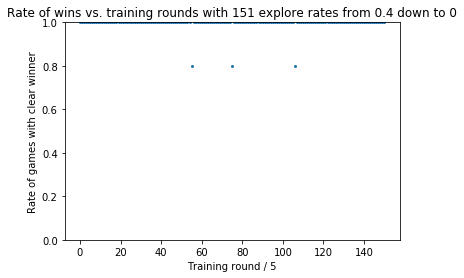

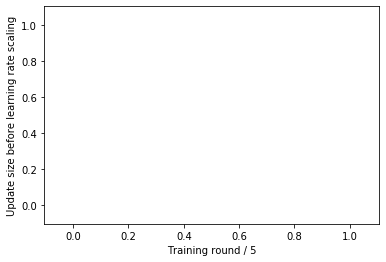

In [25]:
p144150, p244150 = makedynamic(5, 151, 0.7, rows=4, cols=4, movingalpha = True, stratnames='grav44final', 
                                         aggover=5, numfilters=16, filtersize=3, selftrain=True, squareloss=True)

0.0034999999999999996




  0%|                                                                                          | 0/201 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  0%|▍                                                                               | 1/201 [00:45<2:30:56, 45.28s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  1%|▊                                                                               | 2/201 [01:23<2:23:19, 43.21s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  1%|█▏                                                                              | 3/201 [02:02<2:18:45, 42.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  2%|█▌                                                                              | 4/201 [02:35<2:08:51, 39.25s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  2%|█▉                                                                              | 5/201 [03:18<2:11:42, 40.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  3%|██▍                                                                             | 6/201 [04:21<2:32:56, 47.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  3%|██▊                                                                             | 7/201 [04:57<2:21:13, 43.68s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  4%|███▏                                                                            | 8/201 [05:29<2:09:08, 40.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  4%|███▌                                                                            | 9/201 [06:10<2:09:23, 40.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  5%|███▉                                                                           | 10/201 [06:57<2:15:01, 42.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  5%|████▎                                                                          | 11/201 [07:35<2:10:48, 41.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  6%|████▋                                                                          | 12/201 [08:20<2:13:31, 42.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  6%|█████                                                                          | 13/201 [08:58<2:08:45, 41.09s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  7%|█████▌                                                                         | 14/201 [09:25<1:54:27, 36.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  7%|█████▉                                                                         | 15/201 [10:17<2:08:20, 41.40s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  8%|██████▎                                                                        | 16/201 [10:59<2:08:21, 41.63s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  8%|██████▋                                                                        | 17/201 [11:40<2:06:35, 41.28s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  9%|███████                                                                        | 18/201 [12:30<2:14:25, 44.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  9%|███████▍                                                                       | 19/201 [13:10<2:10:02, 42.87s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 10%|███████▊                                                                       | 20/201 [13:43<1:59:58, 39.77s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 10%|████████▎                                                                      | 21/201 [14:42<2:16:24, 45.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 11%|████████▋                                                                      | 22/201 [15:17<2:06:17, 42.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 11%|█████████                                                                      | 23/201 [16:18<2:22:37, 48.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 12%|█████████▍                                                                     | 24/201 [17:07<2:22:11, 48.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 12%|█████████▊                                                                     | 25/201 [17:48<2:15:18, 46.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 13%|██████████▏                                                                    | 26/201 [18:57<2:34:24, 52.94s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 13%|██████████▌                                                                    | 27/201 [19:37<2:22:04, 48.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 14%|███████████                                                                    | 28/201 [20:15<2:12:11, 45.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 14%|███████████▍                                                                   | 29/201 [20:43<1:55:57, 40.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 15%|███████████▊                                                                   | 30/201 [21:43<2:11:47, 46.24s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 15%|████████████▏                                                                  | 31/201 [22:21<2:04:22, 43.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 16%|████████████▌                                                                  | 32/201 [23:06<2:04:05, 44.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 16%|████████████▉                                                                  | 33/201 [23:50<2:03:19, 44.04s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 17%|█████████████▎                                                                 | 34/201 [24:41<2:08:45, 46.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 17%|█████████████▊                                                                 | 35/201 [25:18<2:00:36, 43.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 18%|██████████████▏                                                                | 36/201 [26:01<1:58:38, 43.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 18%|██████████████▌                                                                | 37/201 [26:48<2:01:15, 44.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 19%|██████████████▉                                                                | 38/201 [27:20<1:50:56, 40.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 19%|███████████████▎                                                               | 39/201 [27:53<1:43:45, 38.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 20%|███████████████▋                                                               | 40/201 [28:39<1:49:24, 40.77s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 20%|████████████████                                                               | 41/201 [29:23<1:51:09, 41.68s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 21%|████████████████▌                                                              | 42/201 [30:16<1:59:30, 45.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 21%|████████████████▉                                                              | 43/201 [31:05<2:01:18, 46.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 22%|█████████████████▎                                                             | 44/201 [31:45<1:56:13, 44.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 22%|█████████████████▋                                                             | 45/201 [32:23<1:50:07, 42.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 23%|██████████████████                                                             | 46/201 [33:04<1:48:41, 42.07s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 23%|██████████████████▍                                                            | 47/201 [33:42<1:44:49, 40.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 24%|██████████████████▊                                                            | 48/201 [34:21<1:42:41, 40.27s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 24%|███████████████████▎                                                           | 49/201 [34:49<1:32:58, 36.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 25%|███████████████████▋                                                           | 50/201 [35:15<1:24:05, 33.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 25%|████████████████████                                                           | 51/201 [35:49<1:23:41, 33.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 26%|████████████████████▍                                                          | 52/201 [36:29<1:28:05, 35.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 26%|████████████████████▊                                                          | 53/201 [37:17<1:36:55, 39.29s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 27%|█████████████████████▏                                                         | 54/201 [38:01<1:39:42, 40.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 27%|█████████████████████▌                                                         | 55/201 [38:43<1:40:12, 41.18s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 28%|██████████████████████                                                         | 56/201 [39:13<1:31:26, 37.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 28%|██████████████████████▍                                                        | 57/201 [39:56<1:34:23, 39.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 29%|██████████████████████▊                                                        | 58/201 [40:25<1:26:21, 36.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 29%|███████████████████████▏                                                       | 59/201 [41:05<1:28:20, 37.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 30%|███████████████████████▌                                                       | 60/201 [41:41<1:26:55, 36.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 30%|███████████████████████▉                                                       | 61/201 [42:24<1:29:55, 38.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 31%|████████████████████████▎                                                      | 62/201 [43:04<1:30:55, 39.25s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 31%|████████████████████████▊                                                      | 63/201 [43:44<1:30:18, 39.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 32%|█████████████████████████▏                                                     | 64/201 [44:29<1:33:31, 40.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 32%|█████████████████████████▌                                                     | 65/201 [45:03<1:28:16, 38.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 33%|█████████████████████████▉                                                     | 66/201 [45:32<1:20:55, 35.97s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 33%|██████████████████████████▎                                                    | 67/201 [46:16<1:26:05, 38.55s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 34%|██████████████████████████▋                                                    | 68/201 [46:52<1:23:14, 37.55s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 34%|███████████████████████████                                                    | 69/201 [47:20<1:16:15, 34.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 35%|███████████████████████████▌                                                   | 70/201 [48:03<1:21:19, 37.24s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 35%|███████████████████████████▉                                                   | 71/201 [48:52<1:28:39, 40.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 36%|████████████████████████████▎                                                  | 72/201 [49:27<1:24:10, 39.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 36%|████████████████████████████▋                                                  | 73/201 [50:23<1:33:58, 44.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 37%|█████████████████████████████                                                  | 74/201 [51:05<1:32:16, 43.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 37%|█████████████████████████████▍                                                 | 75/201 [51:52<1:33:25, 44.49s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 38%|█████████████████████████████▊                                                 | 76/201 [52:30<1:28:52, 42.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 38%|██████████████████████████████▎                                                | 77/201 [52:58<1:19:05, 38.27s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 39%|██████████████████████████████▋                                                | 78/201 [53:34<1:16:46, 37.46s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 39%|███████████████████████████████                                                | 79/201 [54:28<1:26:06, 42.35s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 40%|███████████████████████████████▍                                               | 80/201 [55:13<1:27:14, 43.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 40%|███████████████████████████████▊                                               | 81/201 [55:43<1:18:31, 39.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 41%|████████████████████████████████▏                                              | 82/201 [56:28<1:21:01, 40.86s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 41%|████████████████████████████████▌                                              | 83/201 [57:00<1:15:18, 38.30s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 42%|█████████████████████████████████                                              | 84/201 [57:42<1:16:38, 39.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 42%|█████████████████████████████████▍                                             | 85/201 [58:11<1:10:15, 36.34s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 43%|█████████████████████████████████▊                                             | 86/201 [58:41<1:06:08, 34.51s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 43%|██████████████████████████████████▏                                            | 87/201 [59:17<1:06:25, 34.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 44%|██████████████████████████████████▌                                            | 88/201 [59:55<1:07:20, 35.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 44%|██████████████████████████████████                                           | 89/201 [1:00:34<1:08:35, 36.75s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 45%|██████████████████████████████████▍                                          | 90/201 [1:01:16<1:10:55, 38.34s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 45%|██████████████████████████████████▊                                          | 91/201 [1:02:11<1:19:17, 43.25s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 46%|███████████████████████████████████▏                                         | 92/201 [1:03:00<1:21:38, 44.94s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 46%|███████████████████████████████████▋                                         | 93/201 [1:03:40<1:18:41, 43.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 47%|████████████████████████████████████                                         | 94/201 [1:04:18<1:14:28, 41.77s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 47%|████████████████████████████████████▍                                        | 95/201 [1:05:19<1:24:00, 47.55s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 48%|████████████████████████████████████▊                                        | 96/201 [1:06:03<1:21:19, 46.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 48%|█████████████████████████████████████▏                                       | 97/201 [1:06:44<1:18:00, 45.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 49%|█████████████████████████████████████▌                                       | 98/201 [1:07:20<1:12:26, 42.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 49%|█████████████████████████████████████▉                                       | 99/201 [1:07:58<1:09:48, 41.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 50%|█████████████████████████████████████▊                                      | 100/201 [1:08:40<1:09:17, 41.17s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 50%|██████████████████████████████████████▏                                     | 101/201 [1:09:20<1:07:56, 40.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 51%|██████████████████████████████████████▌                                     | 102/201 [1:10:05<1:09:40, 42.22s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 51%|██████████████████████████████████████▉                                     | 103/201 [1:10:39<1:04:47, 39.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 52%|███████████████████████████████████████▎                                    | 104/201 [1:11:19<1:04:10, 39.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 52%|███████████████████████████████████████▋                                    | 105/201 [1:11:59<1:03:44, 39.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 53%|████████████████████████████████████████                                    | 106/201 [1:12:44<1:05:27, 41.34s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 53%|████████████████████████████████████████▍                                   | 107/201 [1:13:26<1:05:01, 41.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 54%|████████████████████████████████████████▊                                   | 108/201 [1:14:00<1:01:13, 39.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 54%|█████████████████████████████████████████▏                                  | 109/201 [1:14:48<1:04:07, 41.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 55%|██████████████████████████████████████████▋                                   | 110/201 [1:15:20<59:02, 38.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 55%|█████████████████████████████████████████▉                                  | 111/201 [1:16:08<1:02:46, 41.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 56%|██████████████████████████████████████████▎                                 | 112/201 [1:16:54<1:03:55, 43.09s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 56%|██████████████████████████████████████████▋                                 | 113/201 [1:17:48<1:07:57, 46.34s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 57%|███████████████████████████████████████████                                 | 114/201 [1:18:31<1:05:36, 45.25s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 57%|████████████████████████████████████████████▋                                 | 115/201 [1:19:04<59:43, 41.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 58%|█████████████████████████████████████████████                                 | 116/201 [1:19:43<57:48, 40.81s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 58%|█████████████████████████████████████████████▍                                | 117/201 [1:20:23<56:30, 40.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 59%|█████████████████████████████████████████████▊                                | 118/201 [1:20:58<53:49, 38.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 59%|██████████████████████████████████████████████▏                               | 119/201 [1:21:36<52:55, 38.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 60%|██████████████████████████████████████████████▌                               | 120/201 [1:22:17<53:04, 39.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 60%|██████████████████████████████████████████████▉                               | 121/201 [1:23:06<56:15, 42.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 61%|███████████████████████████████████████████████▎                              | 122/201 [1:23:58<59:17, 45.03s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 61%|███████████████████████████████████████████████▋                              | 123/201 [1:24:28<52:52, 40.68s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 62%|████████████████████████████████████████████████                              | 124/201 [1:24:57<47:46, 37.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 62%|████████████████████████████████████████████████▌                             | 125/201 [1:25:40<49:17, 38.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 63%|████████████████████████████████████████████████▉                             | 126/201 [1:26:13<46:32, 37.24s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 63%|█████████████████████████████████████████████████▎                            | 127/201 [1:26:52<46:28, 37.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 64%|█████████████████████████████████████████████████▋                            | 128/201 [1:27:38<48:39, 40.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 64%|██████████████████████████████████████████████████                            | 129/201 [1:28:18<48:00, 40.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 65%|██████████████████████████████████████████████████▍                           | 130/201 [1:29:00<48:06, 40.65s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 65%|██████████████████████████████████████████████████▊                           | 131/201 [1:29:28<42:58, 36.83s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 66%|███████████████████████████████████████████████████▏                          | 132/201 [1:30:06<42:46, 37.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 66%|███████████████████████████████████████████████████▌                          | 133/201 [1:30:49<44:16, 39.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 67%|████████████████████████████████████████████████████                          | 134/201 [1:31:31<44:25, 39.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 67%|████████████████████████████████████████████████████▍                         | 135/201 [1:32:06<42:26, 38.59s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 68%|████████████████████████████████████████████████████▊                         | 136/201 [1:32:34<38:06, 35.17s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 68%|█████████████████████████████████████████████████████▏                        | 137/201 [1:33:11<38:18, 35.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 69%|█████████████████████████████████████████████████████▌                        | 138/201 [1:34:13<45:44, 43.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 69%|█████████████████████████████████████████████████████▉                        | 139/201 [1:34:44<41:10, 39.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 70%|██████████████████████████████████████████████████████▎                       | 140/201 [1:35:24<40:35, 39.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 70%|██████████████████████████████████████████████████████▋                       | 141/201 [1:35:55<37:15, 37.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 71%|███████████████████████████████████████████████████████                       | 142/201 [1:36:29<35:49, 36.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 71%|███████████████████████████████████████████████████████▍                      | 143/201 [1:37:19<38:57, 40.30s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 72%|███████████████████████████████████████████████████████▉                      | 144/201 [1:38:09<41:12, 43.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 72%|████████████████████████████████████████████████████████▎                     | 145/201 [1:38:44<37:58, 40.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 73%|████████████████████████████████████████████████████████▋                     | 146/201 [1:39:16<35:02, 38.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 73%|█████████████████████████████████████████████████████████                     | 147/201 [1:40:09<38:17, 42.55s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 74%|█████████████████████████████████████████████████████████▍                    | 148/201 [1:40:43<35:26, 40.11s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 74%|█████████████████████████████████████████████████████████▊                    | 149/201 [1:41:33<37:15, 42.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 75%|██████████████████████████████████████████████████████████▏                   | 150/201 [1:42:20<37:32, 44.17s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 75%|██████████████████████████████████████████████████████████▌                   | 151/201 [1:42:51<33:26, 40.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 76%|██████████████████████████████████████████████████████████▉                   | 152/201 [1:43:25<31:24, 38.46s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 76%|███████████████████████████████████████████████████████████▎                  | 153/201 [1:44:06<31:18, 39.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 77%|███████████████████████████████████████████████████████████▊                  | 154/201 [1:44:36<28:29, 36.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 77%|████████████████████████████████████████████████████████████▏                 | 155/201 [1:45:10<27:16, 35.58s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 78%|████████████████████████████████████████████████████████████▌                 | 156/201 [1:45:45<26:33, 35.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 78%|████████████████████████████████████████████████████████████▉                 | 157/201 [1:46:25<27:05, 36.94s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 79%|█████████████████████████████████████████████████████████████▎                | 158/201 [1:47:00<26:01, 36.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 79%|█████████████████████████████████████████████████████████████▋                | 159/201 [1:47:42<26:36, 38.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 80%|██████████████████████████████████████████████████████████████                | 160/201 [1:48:22<26:18, 38.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 80%|██████████████████████████████████████████████████████████████▍               | 161/201 [1:49:08<27:12, 40.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 81%|██████████████████████████████████████████████████████████████▊               | 162/201 [1:49:38<24:31, 37.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 81%|███████████████████████████████████████████████████████████████▎              | 163/201 [1:50:15<23:41, 37.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 82%|███████████████████████████████████████████████████████████████▋              | 164/201 [1:50:56<23:41, 38.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 82%|████████████████████████████████████████████████████████████████              | 165/201 [1:51:36<23:22, 38.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 83%|████████████████████████████████████████████████████████████████▍             | 166/201 [1:52:17<23:04, 39.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 83%|████████████████████████████████████████████████████████████████▊             | 167/201 [1:53:01<23:10, 40.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 84%|█████████████████████████████████████████████████████████████████▏            | 168/201 [1:53:48<23:32, 42.79s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 84%|█████████████████████████████████████████████████████████████████▌            | 169/201 [1:54:23<21:35, 40.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 85%|█████████████████████████████████████████████████████████████████▉            | 170/201 [1:55:09<21:44, 42.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 85%|██████████████████████████████████████████████████████████████████▎           | 171/201 [1:55:38<19:01, 38.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 86%|██████████████████████████████████████████████████████████████████▋           | 172/201 [1:56:12<17:52, 36.97s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 86%|███████████████████████████████████████████████████████████████████▏          | 173/201 [1:56:56<18:15, 39.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 87%|███████████████████████████████████████████████████████████████████▌          | 174/201 [1:57:24<16:01, 35.61s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 87%|███████████████████████████████████████████████████████████████████▉          | 175/201 [1:58:00<15:33, 35.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 88%|████████████████████████████████████████████████████████████████████▎         | 176/201 [1:58:36<14:56, 35.86s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 88%|████████████████████████████████████████████████████████████████████▋         | 177/201 [1:59:16<14:52, 37.17s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 89%|█████████████████████████████████████████████████████████████████████         | 178/201 [1:59:57<14:37, 38.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 89%|█████████████████████████████████████████████████████████████████████▍        | 179/201 [2:00:28<13:16, 36.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 90%|█████████████████████████████████████████████████████████████████████▊        | 180/201 [2:01:08<13:02, 37.29s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 90%|██████████████████████████████████████████████████████████████████████▏       | 181/201 [2:01:52<13:04, 39.24s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 91%|██████████████████████████████████████████████████████████████████████▋       | 182/201 [2:02:37<12:55, 40.81s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 91%|███████████████████████████████████████████████████████████████████████       | 183/201 [2:03:30<13:24, 44.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 92%|███████████████████████████████████████████████████████████████████████▍      | 184/201 [2:04:06<11:52, 41.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 92%|███████████████████████████████████████████████████████████████████████▊      | 185/201 [2:04:45<10:58, 41.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 93%|████████████████████████████████████████████████████████████████████████▏     | 186/201 [2:05:22<10:00, 40.04s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 93%|████████████████████████████████████████████████████████████████████████▌     | 187/201 [2:05:52<08:37, 36.97s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 94%|████████████████████████████████████████████████████████████████████████▉     | 188/201 [2:06:32<08:11, 37.77s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 94%|█████████████████████████████████████████████████████████████████████████▎    | 189/201 [2:07:10<07:33, 37.75s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 95%|█████████████████████████████████████████████████████████████████████████▋    | 190/201 [2:07:49<06:59, 38.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 95%|██████████████████████████████████████████████████████████████████████████    | 191/201 [2:08:28<06:23, 38.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 96%|██████████████████████████████████████████████████████████████████████████▌   | 192/201 [2:09:03<05:36, 37.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 96%|██████████████████████████████████████████████████████████████████████████▉   | 193/201 [2:09:34<04:45, 35.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 97%|███████████████████████████████████████████████████████████████████████████▎  | 194/201 [2:10:20<04:31, 38.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 97%|███████████████████████████████████████████████████████████████████████████▋  | 195/201 [2:11:06<04:05, 40.86s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 98%|████████████████████████████████████████████████████████████████████████████  | 196/201 [2:11:50<03:28, 41.79s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 98%|████████████████████████████████████████████████████████████████████████████▍ | 197/201 [2:12:33<02:48, 42.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 99%|████████████████████████████████████████████████████████████████████████████▊ | 198/201 [2:13:13<02:04, 41.37s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 99%|█████████████████████████████████████████████████████████████████████████████▏| 199/201 [2:13:44<01:16, 38.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




100%|█████████████████████████████████████████████████████████████████████████████▌| 200/201 [2:14:31<00:41, 41.03s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [2:15:24<00:00, 40.42s/it]


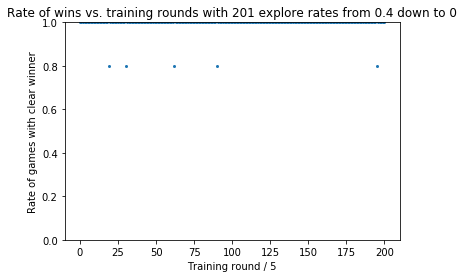

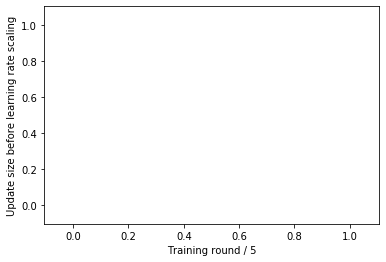

In [26]:
p144200, p244200 = makedynamic(5, 201, 0.7, rows=4, cols=4, movingalpha = True, stratnames='grav44final', 
                                         aggover=5, numfilters=16, filtersize=3, selftrain=True, squareloss=True)

0.0017499999999999998




  0%|                                                                                          | 0/401 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  0%|▏                                                                               | 1/401 [00:43<4:53:16, 43.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  0%|▍                                                                               | 2/401 [01:18<4:33:25, 41.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  1%|▌                                                                               | 3/401 [01:57<4:27:58, 40.40s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  1%|▊                                                                               | 4/401 [02:26<4:06:16, 37.22s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  1%|▉                                                                               | 5/401 [03:21<4:39:23, 42.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  1%|█▏                                                                              | 6/401 [03:58<4:28:16, 40.75s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  2%|█▍                                                                              | 7/401 [04:48<4:45:38, 43.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  2%|█▌                                                                              | 8/401 [05:32<4:47:05, 43.83s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  2%|█▊                                                                              | 9/401 [06:05<4:23:58, 40.40s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  2%|█▉                                                                             | 10/401 [06:48<4:28:12, 41.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  3%|██▏                                                                            | 11/401 [07:29<4:28:10, 41.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  3%|██▎                                                                            | 12/401 [08:13<4:32:57, 42.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  3%|██▌                                                                            | 13/401 [08:55<4:32:23, 42.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  3%|██▊                                                                            | 14/401 [09:35<4:27:47, 41.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  4%|██▉                                                                            | 15/401 [10:19<4:30:08, 41.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  4%|███▏                                                                           | 16/401 [10:54<4:16:10, 39.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  4%|███▎                                                                           | 17/401 [11:30<4:08:50, 38.88s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  4%|███▌                                                                           | 18/401 [12:07<4:05:13, 38.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  5%|███▋                                                                           | 19/401 [12:49<4:09:57, 39.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  5%|███▉                                                                           | 20/401 [13:29<4:12:01, 39.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  5%|████▏                                                                          | 21/401 [14:09<4:11:23, 39.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  5%|████▎                                                                          | 22/401 [14:47<4:06:35, 39.04s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  6%|████▌                                                                          | 23/401 [15:16<3:48:10, 36.22s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  6%|████▋                                                                          | 24/401 [16:01<4:03:57, 38.83s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  6%|████▉                                                                          | 25/401 [16:36<3:55:19, 37.55s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  6%|█████                                                                          | 26/401 [17:22<4:11:45, 40.28s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  7%|█████▎                                                                         | 27/401 [17:48<3:44:16, 35.98s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  7%|█████▌                                                                         | 28/401 [18:29<3:52:32, 37.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  7%|█████▋                                                                         | 29/401 [19:03<3:45:29, 36.37s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  7%|█████▉                                                                         | 30/401 [19:30<3:28:08, 33.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  8%|██████                                                                         | 31/401 [20:13<3:44:29, 36.40s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  8%|██████▎                                                                        | 32/401 [20:44<3:33:45, 34.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  8%|██████▌                                                                        | 33/401 [21:21<3:37:40, 35.49s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  8%|██████▋                                                                        | 34/401 [21:57<3:36:55, 35.46s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  9%|██████▉                                                                        | 35/401 [22:25<3:23:41, 33.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  9%|███████                                                                        | 36/401 [23:27<4:14:14, 41.79s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  9%|███████▎                                                                       | 37/401 [24:01<4:00:30, 39.64s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  9%|███████▍                                                                       | 38/401 [24:29<3:37:46, 36.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 10%|███████▋                                                                       | 39/401 [25:07<3:42:17, 36.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 10%|███████▉                                                                       | 40/401 [25:44<3:40:39, 36.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 10%|████████                                                                       | 41/401 [26:08<3:18:05, 33.02s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 10%|████████▎                                                                      | 42/401 [26:45<3:24:57, 34.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 11%|████████▍                                                                      | 43/401 [27:21<3:27:12, 34.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 11%|████████▋                                                                      | 44/401 [28:10<3:50:49, 38.79s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 11%|████████▊                                                                      | 45/401 [28:40<3:36:07, 36.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 11%|█████████                                                                      | 46/401 [29:32<4:01:37, 40.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 12%|█████████▎                                                                     | 47/401 [30:13<4:02:28, 41.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 12%|█████████▍                                                                     | 48/401 [31:05<4:21:21, 44.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 12%|█████████▋                                                                     | 49/401 [31:46<4:13:09, 43.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 12%|█████████▊                                                                     | 50/401 [32:22<3:59:41, 40.97s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 13%|██████████                                                                     | 51/401 [33:01<3:56:34, 40.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 13%|██████████▏                                                                    | 52/401 [33:46<4:04:02, 41.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 13%|██████████▍                                                                    | 53/401 [34:26<3:59:09, 41.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 13%|██████████▋                                                                    | 54/401 [35:16<4:14:29, 44.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 14%|██████████▊                                                                    | 55/401 [36:06<4:22:58, 45.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 14%|███████████                                                                    | 56/401 [36:32<3:48:43, 39.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 14%|███████████▏                                                                   | 57/401 [37:24<4:08:45, 43.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 14%|███████████▍                                                                   | 58/401 [37:59<3:53:55, 40.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 15%|███████████▌                                                                   | 59/401 [38:48<4:06:56, 43.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 15%|███████████▊                                                                   | 60/401 [39:31<4:06:12, 43.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 15%|████████████                                                                   | 61/401 [40:08<3:53:56, 41.28s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 15%|████████████▏                                                                  | 62/401 [40:47<3:50:44, 40.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 16%|████████████▍                                                                  | 63/401 [41:25<3:44:00, 39.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 16%|████████████▌                                                                  | 64/401 [42:10<3:52:12, 41.34s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 16%|████████████▊                                                                  | 65/401 [42:50<3:48:59, 40.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 16%|█████████████                                                                  | 66/401 [43:30<3:47:54, 40.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 17%|█████████████▏                                                                 | 67/401 [44:02<3:32:36, 38.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 17%|█████████████▍                                                                 | 68/401 [44:40<3:31:03, 38.03s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 17%|█████████████▌                                                                 | 69/401 [45:07<3:13:03, 34.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 17%|█████████████▊                                                                 | 70/401 [45:44<3:15:43, 35.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 18%|█████████████▉                                                                 | 71/401 [46:17<3:11:03, 34.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 18%|██████████████▏                                                                | 72/401 [47:01<3:25:52, 37.55s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 18%|██████████████▍                                                                | 73/401 [47:49<3:40:56, 40.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 18%|██████████████▌                                                                | 74/401 [48:23<3:30:45, 38.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 19%|██████████████▊                                                                | 75/401 [49:00<3:27:20, 38.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 19%|██████████████▉                                                                | 76/401 [49:43<3:34:58, 39.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 19%|███████████████▏                                                               | 77/401 [50:29<3:43:38, 41.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 19%|███████████████▎                                                               | 78/401 [51:01<3:27:34, 38.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 20%|███████████████▌                                                               | 79/401 [51:48<3:40:41, 41.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 20%|███████████████▊                                                               | 80/401 [52:21<3:26:52, 38.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 20%|███████████████▉                                                               | 81/401 [52:55<3:19:36, 37.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 20%|████████████████▏                                                              | 82/401 [53:56<3:56:26, 44.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 21%|████████████████▎                                                              | 83/401 [54:52<4:14:08, 47.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 21%|████████████████▌                                                              | 84/401 [55:22<3:45:17, 42.64s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 21%|████████████████▋                                                              | 85/401 [56:18<4:04:10, 46.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 21%|████████████████▉                                                              | 86/401 [56:52<3:45:10, 42.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 22%|█████████████████▏                                                             | 87/401 [57:39<3:50:53, 44.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 22%|█████████████████▎                                                             | 88/401 [58:22<3:48:00, 43.71s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 22%|█████████████████▌                                                             | 89/401 [59:09<3:53:06, 44.83s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 22%|█████████████████▋                                                             | 90/401 [59:56<3:55:25, 45.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 23%|█████████████████▍                                                           | 91/401 [1:00:48<4:05:04, 47.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 23%|█████████████████▋                                                           | 92/401 [1:01:25<3:47:10, 44.11s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 23%|█████████████████▊                                                           | 93/401 [1:01:57<3:28:12, 40.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 23%|██████████████████                                                           | 94/401 [1:02:49<3:45:19, 44.04s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 24%|██████████████████▏                                                          | 95/401 [1:03:23<3:29:35, 41.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 24%|██████████████████▍                                                          | 96/401 [1:04:09<3:35:52, 42.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 24%|██████████████████▋                                                          | 97/401 [1:04:50<3:33:26, 42.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 24%|██████████████████▊                                                          | 98/401 [1:05:17<3:08:40, 37.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 25%|███████████████████                                                          | 99/401 [1:05:57<3:12:54, 38.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 25%|██████████████████▉                                                         | 100/401 [1:06:25<2:56:05, 35.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 25%|███████████████████▏                                                        | 101/401 [1:06:56<2:48:56, 33.79s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 25%|███████████████████▎                                                        | 102/401 [1:07:28<2:46:44, 33.46s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 26%|███████████████████▌                                                        | 103/401 [1:08:03<2:47:31, 33.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 26%|███████████████████▋                                                        | 104/401 [1:08:57<3:17:11, 39.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 26%|███████████████████▉                                                        | 105/401 [1:09:25<2:59:45, 36.44s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 26%|████████████████████                                                        | 106/401 [1:10:01<2:58:09, 36.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 27%|████████████████████▎                                                       | 107/401 [1:10:53<3:21:13, 41.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 27%|████████████████████▍                                                       | 108/401 [1:11:47<3:39:01, 44.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 27%|████████████████████▋                                                       | 109/401 [1:12:15<3:14:10, 39.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 27%|████████████████████▊                                                       | 110/401 [1:12:59<3:19:14, 41.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 28%|█████████████████████                                                       | 111/401 [1:13:50<3:32:36, 43.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 28%|█████████████████████▏                                                      | 112/401 [1:14:26<3:20:48, 41.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 28%|█████████████████████▍                                                      | 113/401 [1:14:59<3:07:05, 38.98s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 28%|█████████████████████▌                                                      | 114/401 [1:15:29<2:53:35, 36.29s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 29%|█████████████████████▊                                                      | 115/401 [1:16:08<2:56:50, 37.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 29%|█████████████████████▉                                                      | 116/401 [1:16:44<2:54:09, 36.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 29%|██████████████████████▏                                                     | 117/401 [1:17:21<2:54:54, 36.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 29%|██████████████████████▎                                                     | 118/401 [1:17:56<2:50:48, 36.21s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 30%|██████████████████████▌                                                     | 119/401 [1:18:36<2:56:26, 37.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 30%|██████████████████████▋                                                     | 120/401 [1:19:28<3:15:25, 41.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 30%|██████████████████████▉                                                     | 121/401 [1:20:06<3:10:19, 40.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 30%|███████████████████████                                                     | 122/401 [1:20:35<2:52:17, 37.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 31%|███████████████████████▎                                                    | 123/401 [1:21:26<3:11:22, 41.30s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 31%|███████████████████████▌                                                    | 124/401 [1:22:14<3:19:44, 43.27s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 31%|███████████████████████▋                                                    | 125/401 [1:22:54<3:14:18, 42.24s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 31%|███████████████████████▉                                                    | 126/401 [1:23:42<3:21:32, 43.97s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 32%|████████████████████████                                                    | 127/401 [1:24:17<3:09:29, 41.49s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 32%|████████████████████████▎                                                   | 128/401 [1:25:09<3:22:34, 44.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 32%|████████████████████████▍                                                   | 129/401 [1:26:06<3:39:03, 48.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 32%|████████████████████████▋                                                   | 130/401 [1:26:47<3:28:42, 46.21s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 33%|████████████████████████▊                                                   | 131/401 [1:27:21<3:10:31, 42.34s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 33%|█████████████████████████                                                   | 132/401 [1:27:58<3:03:33, 40.94s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 33%|█████████████████████████▏                                                  | 133/401 [1:28:34<2:54:58, 39.18s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 33%|█████████████████████████▍                                                  | 134/401 [1:29:19<3:02:25, 40.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 34%|█████████████████████████▌                                                  | 135/401 [1:29:55<2:54:53, 39.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 34%|█████████████████████████▊                                                  | 136/401 [1:30:42<3:04:53, 41.86s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 34%|█████████████████████████▉                                                  | 137/401 [1:31:24<3:03:44, 41.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 34%|██████████████████████████▏                                                 | 138/401 [1:32:07<3:05:07, 42.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 35%|██████████████████████████▎                                                 | 139/401 [1:32:50<3:05:51, 42.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 35%|██████████████████████████▌                                                 | 140/401 [1:33:28<2:59:10, 41.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 35%|██████████████████████████▋                                                 | 141/401 [1:33:58<2:43:41, 37.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 35%|██████████████████████████▉                                                 | 142/401 [1:34:47<2:58:04, 41.25s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 36%|███████████████████████████                                                 | 143/401 [1:35:39<3:10:37, 44.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 36%|███████████████████████████▎                                                | 144/401 [1:36:15<2:59:37, 41.93s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 36%|███████████████████████████▍                                                | 145/401 [1:36:58<2:59:32, 42.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 36%|███████████████████████████▋                                                | 146/401 [1:37:42<3:02:06, 42.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 37%|███████████████████████████▊                                                | 147/401 [1:38:16<2:50:18, 40.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 37%|████████████████████████████                                                | 148/401 [1:38:57<2:49:36, 40.22s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 37%|████████████████████████████▏                                               | 149/401 [1:39:39<2:51:07, 40.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 37%|████████████████████████████▍                                               | 150/401 [1:40:24<2:56:17, 42.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 38%|████████████████████████████▌                                               | 151/401 [1:41:04<2:52:43, 41.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 38%|████████████████████████████▊                                               | 152/401 [1:41:43<2:49:30, 40.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 38%|████████████████████████████▉                                               | 153/401 [1:42:17<2:39:58, 38.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 38%|█████████████████████████████▏                                              | 154/401 [1:43:04<2:49:10, 41.09s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 39%|█████████████████████████████▍                                              | 155/401 [1:43:58<3:05:09, 45.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 39%|█████████████████████████████▌                                              | 156/401 [1:44:46<3:07:35, 45.94s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 39%|█████████████████████████████▊                                              | 157/401 [1:45:19<2:50:28, 41.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 39%|█████████████████████████████▉                                              | 158/401 [1:46:05<2:55:39, 43.37s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 40%|██████████████████████████████▏                                             | 159/401 [1:46:46<2:51:23, 42.49s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 40%|██████████████████████████████▎                                             | 160/401 [1:47:23<2:44:24, 40.93s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 40%|██████████████████████████████▌                                             | 161/401 [1:47:56<2:34:30, 38.63s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 40%|██████████████████████████████▋                                             | 162/401 [1:48:36<2:34:57, 38.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 41%|██████████████████████████████▉                                             | 163/401 [1:49:15<2:34:15, 38.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 41%|███████████████████████████████                                             | 164/401 [1:49:59<2:39:31, 40.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 41%|███████████████████████████████▎                                            | 165/401 [1:50:38<2:38:05, 40.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 41%|███████████████████████████████▍                                            | 166/401 [1:51:17<2:35:30, 39.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 42%|███████████████████████████████▋                                            | 167/401 [1:51:52<2:29:05, 38.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 42%|███████████████████████████████▊                                            | 168/401 [1:52:25<2:22:17, 36.64s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 42%|████████████████████████████████                                            | 169/401 [1:53:23<2:46:17, 43.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 42%|████████████████████████████████▏                                           | 170/401 [1:54:10<2:50:25, 44.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 43%|████████████████████████████████▍                                           | 171/401 [1:54:53<2:48:20, 43.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 43%|████████████████████████████████▌                                           | 172/401 [1:55:41<2:52:51, 45.29s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 43%|████████████████████████████████▊                                           | 173/401 [1:56:34<3:01:00, 47.63s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 43%|████████████████████████████████▉                                           | 174/401 [1:57:10<2:46:33, 44.03s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 44%|█████████████████████████████████▏                                          | 175/401 [1:57:51<2:42:03, 43.03s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 44%|█████████████████████████████████▎                                          | 176/401 [1:58:25<2:31:01, 40.27s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 44%|█████████████████████████████████▌                                          | 177/401 [1:59:05<2:30:50, 40.40s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 44%|█████████████████████████████████▋                                          | 178/401 [1:59:52<2:36:40, 42.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 45%|█████████████████████████████████▉                                          | 179/401 [2:00:34<2:36:05, 42.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 45%|██████████████████████████████████                                          | 180/401 [2:01:34<2:55:40, 47.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 45%|██████████████████████████████████▎                                         | 181/401 [2:02:20<2:52:23, 47.02s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 45%|██████████████████████████████████▍                                         | 182/401 [2:03:04<2:48:10, 46.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 46%|██████████████████████████████████▋                                         | 183/401 [2:03:44<2:41:13, 44.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 46%|██████████████████████████████████▊                                         | 184/401 [2:04:28<2:39:33, 44.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 46%|███████████████████████████████████                                         | 185/401 [2:05:14<2:41:03, 44.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 46%|███████████████████████████████████▎                                        | 186/401 [2:05:54<2:35:15, 43.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 47%|███████████████████████████████████▍                                        | 187/401 [2:06:27<2:23:15, 40.17s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 47%|███████████████████████████████████▋                                        | 188/401 [2:07:18<2:34:34, 43.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 47%|███████████████████████████████████▊                                        | 189/401 [2:07:47<2:18:55, 39.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 47%|████████████████████████████████████                                        | 190/401 [2:08:22<2:13:31, 37.97s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 48%|████████████████████████████████████▏                                       | 191/401 [2:09:17<2:29:56, 42.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 48%|████████████████████████████████████▍                                       | 192/401 [2:10:07<2:37:19, 45.17s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 48%|████████████████████████████████████▌                                       | 193/401 [2:10:45<2:28:32, 42.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 48%|████████████████████████████████████▊                                       | 194/401 [2:11:39<2:39:47, 46.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 49%|████████████████████████████████████▉                                       | 195/401 [2:12:17<2:30:09, 43.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 49%|█████████████████████████████████████▏                                      | 196/401 [2:13:04<2:32:43, 44.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 49%|█████████████████████████████████████▎                                      | 197/401 [2:13:42<2:25:33, 42.81s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 49%|█████████████████████████████████████▌                                      | 198/401 [2:14:17<2:16:57, 40.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 50%|█████████████████████████████████████▋                                      | 199/401 [2:15:10<2:28:58, 44.25s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 50%|█████████████████████████████████████▉                                      | 200/401 [2:15:50<2:23:54, 42.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 50%|██████████████████████████████████████                                      | 201/401 [2:16:26<2:15:43, 40.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 50%|██████████████████████████████████████▎                                     | 202/401 [2:16:58<2:06:59, 38.29s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 51%|██████████████████████████████████████▍                                     | 203/401 [2:17:37<2:07:00, 38.49s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 51%|██████████████████████████████████████▋                                     | 204/401 [2:18:24<2:14:50, 41.07s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 51%|██████████████████████████████████████▊                                     | 205/401 [2:19:11<2:19:25, 42.68s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 51%|███████████████████████████████████████                                     | 206/401 [2:20:00<2:25:02, 44.63s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 52%|███████████████████████████████████████▏                                    | 207/401 [2:20:32<2:12:31, 40.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 52%|███████████████████████████████████████▍                                    | 208/401 [2:21:05<2:03:27, 38.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 52%|███████████████████████████████████████▌                                    | 209/401 [2:21:51<2:10:57, 40.93s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 52%|███████████████████████████████████████▊                                    | 210/401 [2:22:24<2:02:11, 38.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 53%|███████████████████████████████████████▉                                    | 211/401 [2:22:51<1:50:39, 34.94s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 53%|████████████████████████████████████████▏                                   | 212/401 [2:23:22<1:46:20, 33.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 53%|████████████████████████████████████████▎                                   | 213/401 [2:23:58<1:48:22, 34.59s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 53%|████████████████████████████████████████▌                                   | 214/401 [2:24:27<1:41:53, 32.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 54%|████████████████████████████████████████▋                                   | 215/401 [2:25:04<1:46:01, 34.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 54%|████████████████████████████████████████▉                                   | 216/401 [2:25:41<1:47:34, 34.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 54%|█████████████████████████████████████████▏                                  | 217/401 [2:26:16<1:46:51, 34.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 54%|█████████████████████████████████████████▎                                  | 218/401 [2:26:49<1:45:03, 34.44s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 55%|█████████████████████████████████████████▌                                  | 219/401 [2:27:28<1:48:57, 35.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 55%|█████████████████████████████████████████▋                                  | 220/401 [2:28:06<1:49:42, 36.37s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 55%|█████████████████████████████████████████▉                                  | 221/401 [2:28:58<2:03:33, 41.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 55%|██████████████████████████████████████████                                  | 222/401 [2:29:32<1:56:05, 38.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 56%|██████████████████████████████████████████▎                                 | 223/401 [2:30:15<1:59:13, 40.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 56%|██████████████████████████████████████████▍                                 | 224/401 [2:30:51<1:54:36, 38.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 56%|██████████████████████████████████████████▋                                 | 225/401 [2:31:37<2:00:04, 40.93s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 56%|██████████████████████████████████████████▊                                 | 226/401 [2:32:14<1:56:24, 39.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 57%|███████████████████████████████████████████                                 | 227/401 [2:32:53<1:55:02, 39.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 57%|███████████████████████████████████████████▏                                | 228/401 [2:33:31<1:53:05, 39.22s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 57%|███████████████████████████████████████████▍                                | 229/401 [2:34:17<1:57:49, 41.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 57%|███████████████████████████████████████████▌                                | 230/401 [2:34:50<1:50:33, 38.79s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 58%|███████████████████████████████████████████▊                                | 231/401 [2:35:36<1:55:32, 40.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 58%|███████████████████████████████████████████▉                                | 232/401 [2:36:14<1:53:02, 40.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 58%|████████████████████████████████████████████▏                               | 233/401 [2:37:05<2:00:51, 43.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 58%|████████████████████████████████████████████▎                               | 234/401 [2:37:46<1:58:40, 42.64s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 59%|████████████████████████████████████████████▌                               | 235/401 [2:38:25<1:54:37, 41.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 59%|████████████████████████████████████████████▋                               | 236/401 [2:39:10<1:57:00, 42.55s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 59%|████████████████████████████████████████████▉                               | 237/401 [2:39:46<1:50:57, 40.59s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 59%|█████████████████████████████████████████████                               | 238/401 [2:40:34<1:56:46, 42.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 60%|█████████████████████████████████████████████▎                              | 239/401 [2:41:18<1:56:19, 43.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 60%|█████████████████████████████████████████████▍                              | 240/401 [2:42:02<1:56:50, 43.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 60%|█████████████████████████████████████████████▋                              | 241/401 [2:42:34<1:46:29, 39.94s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 60%|█████████████████████████████████████████████▊                              | 242/401 [2:43:19<1:49:52, 41.46s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 61%|██████████████████████████████████████████████                              | 243/401 [2:43:48<1:39:42, 37.86s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 61%|██████████████████████████████████████████████▏                             | 244/401 [2:44:37<1:47:33, 41.11s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 61%|██████████████████████████████████████████████▍                             | 245/401 [2:45:24<1:51:11, 42.77s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 61%|██████████████████████████████████████████████▌                             | 246/401 [2:46:11<1:54:04, 44.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 62%|██████████████████████████████████████████████▊                             | 247/401 [2:46:49<1:48:49, 42.40s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 62%|███████████████████████████████████████████████                             | 248/401 [2:47:30<1:46:28, 41.75s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 62%|███████████████████████████████████████████████▏                            | 249/401 [2:48:16<1:49:02, 43.04s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 62%|███████████████████████████████████████████████▍                            | 250/401 [2:49:02<1:50:29, 43.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 63%|███████████████████████████████████████████████▌                            | 251/401 [2:49:33<1:40:24, 40.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 63%|███████████████████████████████████████████████▊                            | 252/401 [2:50:20<1:45:12, 42.37s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 63%|███████████████████████████████████████████████▉                            | 253/401 [2:50:52<1:36:32, 39.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 63%|████████████████████████████████████████████████▏                           | 254/401 [2:51:28<1:33:11, 38.04s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 64%|████████████████████████████████████████████████▎                           | 255/401 [2:52:15<1:39:39, 40.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 64%|████████████████████████████████████████████████▌                           | 256/401 [2:52:54<1:37:16, 40.25s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 64%|████████████████████████████████████████████████▋                           | 257/401 [2:53:30<1:33:18, 38.88s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 64%|████████████████████████████████████████████████▉                           | 258/401 [2:54:08<1:32:34, 38.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 65%|█████████████████████████████████████████████████                           | 259/401 [2:54:45<1:30:03, 38.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 65%|█████████████████████████████████████████████████▎                          | 260/401 [2:55:26<1:32:08, 39.21s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 65%|█████████████████████████████████████████████████▍                          | 261/401 [2:56:05<1:31:03, 39.03s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 65%|█████████████████████████████████████████████████▋                          | 262/401 [2:56:45<1:30:45, 39.18s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 66%|█████████████████████████████████████████████████▊                          | 263/401 [2:57:34<1:36:53, 42.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 66%|██████████████████████████████████████████████████                          | 264/401 [2:58:13<1:34:03, 41.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 66%|██████████████████████████████████████████████████▏                         | 265/401 [2:58:50<1:30:53, 40.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 66%|██████████████████████████████████████████████████▍                         | 266/401 [2:59:36<1:33:52, 41.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 67%|██████████████████████████████████████████████████▌                         | 267/401 [3:00:10<1:28:31, 39.64s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 67%|██████████████████████████████████████████████████▊                         | 268/401 [3:00:56<1:32:05, 41.55s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 67%|██████████████████████████████████████████████████▉                         | 269/401 [3:01:42<1:34:08, 42.79s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 67%|███████████████████████████████████████████████████▏                        | 270/401 [3:02:11<1:24:19, 38.62s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 68%|███████████████████████████████████████████████████▎                        | 271/401 [3:03:01<1:31:05, 42.04s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 68%|███████████████████████████████████████████████████▌                        | 272/401 [3:03:44<1:30:51, 42.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 68%|███████████████████████████████████████████████████▋                        | 273/401 [3:04:12<1:21:02, 37.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 68%|███████████████████████████████████████████████████▉                        | 274/401 [3:04:57<1:24:58, 40.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 69%|████████████████████████████████████████████████████                        | 275/401 [3:05:28<1:18:32, 37.40s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 69%|████████████████████████████████████████████████████▎                       | 276/401 [3:06:10<1:20:40, 38.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 69%|████████████████████████████████████████████████████▍                       | 277/401 [3:06:48<1:19:38, 38.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 69%|████████████████████████████████████████████████████▋                       | 278/401 [3:07:24<1:17:13, 37.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 70%|████████████████████████████████████████████████████▉                       | 279/401 [3:08:08<1:20:59, 39.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 70%|█████████████████████████████████████████████████████                       | 280/401 [3:08:57<1:25:43, 42.51s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 70%|█████████████████████████████████████████████████████▎                      | 281/401 [3:09:38<1:24:15, 42.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 70%|█████████████████████████████████████████████████████▍                      | 282/401 [3:10:29<1:28:36, 44.68s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 71%|█████████████████████████████████████████████████████▋                      | 283/401 [3:11:04<1:22:00, 41.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 71%|█████████████████████████████████████████████████████▊                      | 284/401 [3:11:44<1:20:21, 41.21s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 71%|██████████████████████████████████████████████████████                      | 285/401 [3:12:32<1:23:53, 43.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 71%|██████████████████████████████████████████████████████▏                     | 286/401 [3:13:11<1:20:25, 41.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 72%|██████████████████████████████████████████████████████▍                     | 287/401 [3:13:46<1:15:58, 39.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 72%|██████████████████████████████████████████████████████▌                     | 288/401 [3:14:36<1:20:37, 42.81s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 72%|██████████████████████████████████████████████████████▊                     | 289/401 [3:15:17<1:18:55, 42.28s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 72%|██████████████████████████████████████████████████████▉                     | 290/401 [3:16:04<1:20:56, 43.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 73%|███████████████████████████████████████████████████████▏                    | 291/401 [3:16:54<1:23:26, 45.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 73%|███████████████████████████████████████████████████████▎                    | 292/401 [3:17:34<1:19:36, 43.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 73%|███████████████████████████████████████████████████████▌                    | 293/401 [3:18:19<1:19:53, 44.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 73%|███████████████████████████████████████████████████████▋                    | 294/401 [3:18:56<1:15:12, 42.17s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 74%|███████████████████████████████████████████████████████▉                    | 295/401 [3:19:30<1:10:14, 39.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 74%|████████████████████████████████████████████████████████                    | 296/401 [3:20:15<1:12:07, 41.22s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 74%|████████████████████████████████████████████████████████▎                   | 297/401 [3:21:01<1:14:05, 42.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 74%|████████████████████████████████████████████████████████▍                   | 298/401 [3:21:44<1:13:14, 42.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 75%|████████████████████████████████████████████████████████▋                   | 299/401 [3:22:33<1:16:04, 44.75s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 75%|████████████████████████████████████████████████████████▊                   | 300/401 [3:23:23<1:18:00, 46.34s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 75%|█████████████████████████████████████████████████████████                   | 301/401 [3:24:08<1:16:22, 45.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 75%|█████████████████████████████████████████████████████████▏                  | 302/401 [3:25:03<1:19:54, 48.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 76%|█████████████████████████████████████████████████████████▍                  | 303/401 [3:25:35<1:11:29, 43.77s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 76%|█████████████████████████████████████████████████████████▌                  | 304/401 [3:26:17<1:09:33, 43.02s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 76%|█████████████████████████████████████████████████████████▊                  | 305/401 [3:27:14<1:15:47, 47.37s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 76%|█████████████████████████████████████████████████████████▉                  | 306/401 [3:27:47<1:08:02, 42.97s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 77%|██████████████████████████████████████████████████████████▏                 | 307/401 [3:28:33<1:08:56, 44.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 77%|██████████████████████████████████████████████████████████▎                 | 308/401 [3:29:21<1:09:59, 45.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 77%|██████████████████████████████████████████████████████████▌                 | 309/401 [3:29:59<1:05:51, 42.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 77%|██████████████████████████████████████████████████████████▊                 | 310/401 [3:30:47<1:07:19, 44.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 78%|██████████████████████████████████████████████████████████▉                 | 311/401 [3:31:36<1:08:32, 45.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 78%|███████████████████████████████████████████████████████████▏                | 312/401 [3:32:12<1:03:31, 42.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 78%|███████████████████████████████████████████████████████████▎                | 313/401 [3:33:02<1:05:57, 44.97s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 78%|███████████████████████████████████████████████████████████▌                | 314/401 [3:33:48<1:05:58, 45.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 79%|███████████████████████████████████████████████████████████▋                | 315/401 [3:34:38<1:06:57, 46.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 79%|███████████████████████████████████████████████████████████▉                | 316/401 [3:35:20<1:04:07, 45.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 79%|████████████████████████████████████████████████████████████                | 317/401 [3:36:07<1:04:10, 45.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 79%|████████████████████████████████████████████████████████████▎               | 318/401 [3:37:10<1:10:29, 50.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 80%|████████████████████████████████████████████████████████████▍               | 319/401 [3:38:13<1:14:31, 54.53s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 80%|████████████████████████████████████████████████████████████▋               | 320/401 [3:39:02<1:11:33, 53.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 80%|████████████████████████████████████████████████████████████▊               | 321/401 [3:39:42<1:05:34, 49.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 80%|█████████████████████████████████████████████████████████████               | 322/401 [3:40:31<1:04:42, 49.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 81%|██████████████████████████████████████████████████████████████▊               | 323/401 [3:41:04<57:24, 44.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 81%|███████████████████████████████████████████████████████████████               | 324/401 [3:41:42<54:18, 42.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 81%|███████████████████████████████████████████████████████████████▏              | 325/401 [3:42:32<56:38, 44.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 81%|███████████████████████████████████████████████████████████████▍              | 326/401 [3:43:07<52:11, 41.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 82%|███████████████████████████████████████████████████████████████▌              | 327/401 [3:43:48<51:19, 41.61s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 82%|███████████████████████████████████████████████████████████████▊              | 328/401 [3:44:37<53:05, 43.64s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 82%|███████████████████████████████████████████████████████████████▉              | 329/401 [3:45:18<51:32, 42.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 82%|████████████████████████████████████████████████████████████████▏             | 330/401 [3:46:04<51:56, 43.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 83%|████████████████████████████████████████████████████████████████▍             | 331/401 [3:46:32<45:30, 39.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 83%|████████████████████████████████████████████████████████████████▌             | 332/401 [3:47:08<43:59, 38.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 83%|████████████████████████████████████████████████████████████████▊             | 333/401 [3:47:53<45:28, 40.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 83%|████████████████████████████████████████████████████████████████▉             | 334/401 [3:48:33<44:42, 40.03s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 84%|█████████████████████████████████████████████████████████████████▏            | 335/401 [3:49:26<48:16, 43.88s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 84%|█████████████████████████████████████████████████████████████████▎            | 336/401 [3:50:12<48:15, 44.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 84%|█████████████████████████████████████████████████████████████████▌            | 337/401 [3:50:40<42:20, 39.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 84%|█████████████████████████████████████████████████████████████████▋            | 338/401 [3:51:25<43:30, 41.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 85%|█████████████████████████████████████████████████████████████████▉            | 339/401 [3:52:12<44:20, 42.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 85%|██████████████████████████████████████████████████████████████████▏           | 340/401 [3:52:55<43:40, 42.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 85%|██████████████████████████████████████████████████████████████████▎           | 341/401 [3:53:52<47:20, 47.34s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 85%|██████████████████████████████████████████████████████████████████▌           | 342/401 [3:54:31<43:59, 44.75s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 86%|██████████████████████████████████████████████████████████████████▋           | 343/401 [3:55:18<43:52, 45.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 86%|██████████████████████████████████████████████████████████████████▉           | 344/401 [3:56:19<47:28, 49.98s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 86%|███████████████████████████████████████████████████████████████████           | 345/401 [3:57:10<46:54, 50.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 86%|███████████████████████████████████████████████████████████████████▎          | 346/401 [3:58:07<48:06, 52.49s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 87%|███████████████████████████████████████████████████████████████████▍          | 347/401 [3:58:44<42:51, 47.62s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 87%|███████████████████████████████████████████████████████████████████▋          | 348/401 [3:59:39<44:10, 50.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 87%|███████████████████████████████████████████████████████████████████▉          | 349/401 [4:00:34<44:40, 51.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 87%|████████████████████████████████████████████████████████████████████          | 350/401 [4:01:18<41:52, 49.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 88%|████████████████████████████████████████████████████████████████████▎         | 351/401 [4:02:00<39:12, 47.04s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 88%|████████████████████████████████████████████████████████████████████▍         | 352/401 [4:02:37<35:58, 44.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 88%|████████████████████████████████████████████████████████████████████▋         | 353/401 [4:03:19<34:44, 43.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 88%|████████████████████████████████████████████████████████████████████▊         | 354/401 [4:03:56<32:22, 41.34s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 89%|█████████████████████████████████████████████████████████████████████         | 355/401 [4:04:31<30:18, 39.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 89%|█████████████████████████████████████████████████████████████████████▏        | 356/401 [4:05:06<28:42, 38.27s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 89%|█████████████████████████████████████████████████████████████████████▍        | 357/401 [4:05:53<29:50, 40.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 89%|█████████████████████████████████████████████████████████████████████▋        | 358/401 [4:06:48<32:24, 45.22s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 90%|█████████████████████████████████████████████████████████████████████▊        | 359/401 [4:07:25<29:53, 42.71s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 90%|██████████████████████████████████████████████████████████████████████        | 360/401 [4:08:00<27:38, 40.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 90%|██████████████████████████████████████████████████████████████████████▏       | 361/401 [4:08:35<25:46, 38.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 90%|██████████████████████████████████████████████████████████████████████▍       | 362/401 [4:09:25<27:24, 42.17s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 91%|██████████████████████████████████████████████████████████████████████▌       | 363/401 [4:10:15<28:07, 44.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 91%|██████████████████████████████████████████████████████████████████████▊       | 364/401 [4:11:07<28:42, 46.57s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 91%|██████████████████████████████████████████████████████████████████████▉       | 365/401 [4:11:41<25:42, 42.86s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 91%|███████████████████████████████████████████████████████████████████████▏      | 366/401 [4:12:16<23:42, 40.64s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 92%|███████████████████████████████████████████████████████████████████████▍      | 367/401 [4:12:54<22:36, 39.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 92%|███████████████████████████████████████████████████████████████████████▌      | 368/401 [4:13:49<24:21, 44.29s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 92%|███████████████████████████████████████████████████████████████████████▊      | 369/401 [4:14:20<21:32, 40.40s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 92%|███████████████████████████████████████████████████████████████████████▉      | 370/401 [4:15:01<20:55, 40.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 93%|████████████████████████████████████████████████████████████████████████▏     | 371/401 [4:15:41<20:08, 40.29s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 93%|████████████████████████████████████████████████████████████████████████▎     | 372/401 [4:16:21<19:29, 40.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 93%|████████████████████████████████████████████████████████████████████████▌     | 373/401 [4:16:59<18:30, 39.64s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 93%|████████████████████████████████████████████████████████████████████████▋     | 374/401 [4:17:30<16:35, 36.86s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 94%|████████████████████████████████████████████████████████████████████████▉     | 375/401 [4:18:12<16:38, 38.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 94%|█████████████████████████████████████████████████████████████████████████▏    | 376/401 [4:18:54<16:26, 39.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 94%|█████████████████████████████████████████████████████████████████████████▎    | 377/401 [4:19:41<16:43, 41.83s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 94%|█████████████████████████████████████████████████████████████████████████▌    | 378/401 [4:20:18<15:27, 40.34s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 95%|█████████████████████████████████████████████████████████████████████████▋    | 379/401 [4:20:48<13:42, 37.40s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 95%|█████████████████████████████████████████████████████████████████████████▉    | 380/401 [4:21:31<13:37, 38.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 95%|██████████████████████████████████████████████████████████████████████████    | 381/401 [4:22:19<13:55, 41.77s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 95%|██████████████████████████████████████████████████████████████████████████▎   | 382/401 [4:23:03<13:26, 42.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 96%|██████████████████████████████████████████████████████████████████████████▍   | 383/401 [4:23:37<11:56, 39.81s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 96%|██████████████████████████████████████████████████████████████████████████▋   | 384/401 [4:24:24<11:56, 42.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 96%|██████████████████████████████████████████████████████████████████████████▉   | 385/401 [4:25:07<11:17, 42.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 96%|███████████████████████████████████████████████████████████████████████████   | 386/401 [4:25:55<11:00, 44.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 97%|███████████████████████████████████████████████████████████████████████████▎  | 387/401 [4:26:52<11:11, 47.97s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 97%|███████████████████████████████████████████████████████████████████████████▍  | 388/401 [4:27:40<10:20, 47.75s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 97%|███████████████████████████████████████████████████████████████████████████▋  | 389/401 [4:28:20<09:06, 45.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 97%|███████████████████████████████████████████████████████████████████████████▊  | 390/401 [4:29:05<08:18, 45.30s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 98%|████████████████████████████████████████████████████████████████████████████  | 391/401 [4:29:51<07:36, 45.65s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 98%|████████████████████████████████████████████████████████████████████████████▏ | 392/401 [4:30:28<06:26, 42.98s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 98%|████████████████████████████████████████████████████████████████████████████▍ | 393/401 [4:31:17<05:58, 44.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 98%|████████████████████████████████████████████████████████████████████████████▋ | 394/401 [4:31:58<05:06, 43.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 99%|████████████████████████████████████████████████████████████████████████████▊ | 395/401 [4:32:49<04:34, 45.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 99%|█████████████████████████████████████████████████████████████████████████████ | 396/401 [4:33:23<03:31, 42.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 99%|█████████████████████████████████████████████████████████████████████████████▏| 397/401 [4:33:56<02:38, 39.51s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 99%|█████████████████████████████████████████████████████████████████████████████▍| 398/401 [4:34:34<01:57, 39.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




100%|█████████████████████████████████████████████████████████████████████████████▌| 399/401 [4:35:20<01:22, 41.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




100%|█████████████████████████████████████████████████████████████████████████████▊| 400/401 [4:36:03<00:41, 41.65s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




100%|██████████████████████████████████████████████████████████████████████████████| 401/401 [4:36:57<00:00, 41.44s/it]


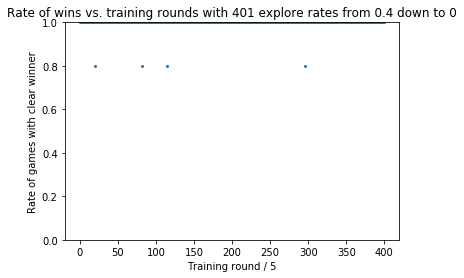

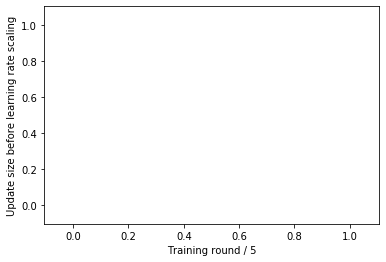

In [27]:
p144400, p244400 = makedynamic(5, 401, 0.7, rows=4, cols=4, movingalpha = True, stratnames='grav44final', 
                                         aggover=5, numfilters=16, filtersize=3, selftrain=True, squareloss=True)
#p1grav34, p2grav34 = makedynamic(15000, 9, 0.4, rows=3, cols=4, winc=3, gmove=True, movingalpha=True, 
                               #stratnames="grav34")
# gmove is no longer necessary, our class takes care of that for us now.

In [30]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p144400, p244400, numrows=4, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------
3  |   |   |   |   | 
---------------------

[0, 1, 2, 3]
0
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------
3  | x |   |   |   | 
---------------------

[0, 1, 2, 3]
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | o |   |   |   | 
---------------------
3  | x |   |   |   | 
---------------------

[0, 1, 2, 3]
2
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  | o |   |   |   | 
---------------------
3  | x |   | x |   | 
---------------------

[0, 1, 2, 3]
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 

1

Let's try 200 with a more reasonable number of filters (8?) and no square loss. Will also try 100.

0.005




  0%|                                                                                          | 0/101 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  1%|▊                                                                                 | 1/101 [00:29<48:40, 29.21s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  2%|█▌                                                                                | 2/101 [01:17<57:26, 34.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  3%|██▍                                                                             | 3/101 [02:15<1:08:29, 41.93s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  4%|███▏                                                                            | 4/101 [03:09<1:13:37, 45.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  5%|███▉                                                                            | 5/101 [03:55<1:13:02, 45.65s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  6%|████▊                                                                           | 6/101 [04:50<1:16:50, 48.53s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  7%|█████▌                                                                          | 7/101 [05:38<1:15:35, 48.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  8%|██████▎                                                                         | 8/101 [06:19<1:11:25, 46.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  9%|███████▏                                                                        | 9/101 [07:18<1:16:35, 49.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 10%|███████▊                                                                       | 10/101 [08:02<1:13:06, 48.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 11%|████████▌                                                                      | 11/101 [08:54<1:14:04, 49.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 12%|█████████▍                                                                     | 12/101 [09:55<1:18:16, 52.77s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 13%|██████████▏                                                                    | 13/101 [10:37<1:12:50, 49.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 14%|██████████▉                                                                    | 14/101 [11:18<1:08:19, 47.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 15%|███████████▋                                                                   | 15/101 [12:07<1:08:06, 47.51s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 16%|████████████▌                                                                  | 16/101 [12:43<1:02:35, 44.18s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 17%|█████████████▎                                                                 | 17/101 [13:28<1:02:08, 44.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 18%|██████████████                                                                 | 18/101 [14:21<1:04:47, 46.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 19%|██████████████▊                                                                | 19/101 [15:28<1:12:18, 52.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 20%|███████████████▋                                                               | 20/101 [16:21<1:11:23, 52.88s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 21%|████████████████▍                                                              | 21/101 [17:17<1:12:02, 54.03s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 22%|█████████████████▏                                                             | 22/101 [18:17<1:13:19, 55.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 23%|█████████████████▉                                                             | 23/101 [19:13<1:12:28, 55.75s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 24%|██████████████████▊                                                            | 24/101 [19:51<1:04:41, 50.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 25%|███████████████████▌                                                           | 25/101 [20:54<1:08:55, 54.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 26%|████████████████████▎                                                          | 26/101 [21:53<1:09:28, 55.59s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 27%|█████████████████████                                                          | 27/101 [22:37<1:04:17, 52.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 28%|█████████████████████▉                                                         | 28/101 [23:36<1:05:49, 54.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 29%|███████████████████████▎                                                         | 29/101 [24:15<59:35, 49.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 30%|███████████████████████▍                                                       | 30/101 [25:12<1:01:22, 51.87s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 31%|████████████████████████▊                                                        | 31/101 [25:53<56:49, 48.71s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 32%|█████████████████████████▋                                                       | 32/101 [26:50<58:57, 51.27s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 33%|██████████████████████████▍                                                      | 33/101 [27:40<57:21, 50.62s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 34%|██████████████████████████▌                                                    | 34/101 [28:47<1:02:12, 55.71s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 35%|███████████████████████████▍                                                   | 35/101 [29:44<1:01:31, 55.93s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 36%|████████████████████████████▊                                                    | 36/101 [30:34<58:51, 54.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 37%|█████████████████████████████▋                                                   | 37/101 [31:28<57:47, 54.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 38%|██████████████████████████████▍                                                  | 38/101 [32:08<52:28, 49.98s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 39%|███████████████████████████████▎                                                 | 39/101 [32:46<48:01, 46.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 40%|████████████████████████████████                                                 | 40/101 [33:36<48:13, 47.44s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 41%|████████████████████████████████▉                                                | 41/101 [34:29<49:10, 49.18s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 42%|█████████████████████████████████▋                                               | 42/101 [35:33<52:40, 53.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 43%|██████████████████████████████████▍                                              | 43/101 [36:20<49:56, 51.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 44%|███████████████████████████████████▎                                             | 44/101 [37:33<55:02, 57.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 45%|████████████████████████████████████                                             | 45/101 [38:36<55:25, 59.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 46%|████████████████████████████████████▉                                            | 46/101 [39:27<52:03, 56.79s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 47%|█████████████████████████████████████▋                                           | 47/101 [40:39<55:13, 61.35s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 48%|██████████████████████████████████████▍                                          | 48/101 [41:49<56:39, 64.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 49%|███████████████████████████████████████▎                                         | 49/101 [42:46<53:43, 61.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 50%|████████████████████████████████████████                                         | 50/101 [43:37<49:45, 58.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 50%|████████████████████████████████████████▉                                        | 51/101 [44:20<45:00, 54.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 51%|█████████████████████████████████████████▋                                       | 52/101 [45:10<43:12, 52.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 52%|██████████████████████████████████████████▌                                      | 53/101 [45:52<39:34, 49.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 53%|███████████████████████████████████████████▎                                     | 54/101 [46:46<39:50, 50.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 54%|████████████████████████████████████████████                                     | 55/101 [47:51<42:14, 55.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 55%|████████████████████████████████████████████▉                                    | 56/101 [48:42<40:28, 53.97s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 56%|█████████████████████████████████████████████▋                                   | 57/101 [49:52<42:58, 58.59s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 57%|██████████████████████████████████████████████▌                                  | 58/101 [51:00<43:59, 61.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 58%|███████████████████████████████████████████████▎                                 | 59/101 [51:59<42:28, 60.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 59%|████████████████████████████████████████████████                                 | 60/101 [52:44<38:26, 56.24s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 60%|████████████████████████████████████████████████▉                                | 61/101 [53:45<38:22, 57.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 61%|█████████████████████████████████████████████████▋                               | 62/101 [54:57<40:17, 62.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 62%|██████████████████████████████████████████████████▌                              | 63/101 [56:01<39:28, 62.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 63%|███████████████████████████████████████████████████▎                             | 64/101 [57:12<40:07, 65.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 64%|████████████████████████████████████████████████████▏                            | 65/101 [58:10<37:49, 63.04s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 65%|████████████████████████████████████████████████████▉                            | 66/101 [59:13<36:45, 63.02s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 66%|████████████████████████████████████████████████████▍                          | 67/101 [1:00:11<34:46, 61.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 67%|█████████████████████████████████████████████████████▏                         | 68/101 [1:00:55<30:58, 56.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 68%|█████████████████████████████████████████████████████▉                         | 69/101 [1:01:55<30:36, 57.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 69%|██████████████████████████████████████████████████████▊                        | 70/101 [1:02:52<29:32, 57.18s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 70%|███████████████████████████████████████████████████████▌                       | 71/101 [1:03:37<26:48, 53.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 71%|████████████████████████████████████████████████████████▎                      | 72/101 [1:04:31<25:59, 53.79s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 72%|█████████████████████████████████████████████████████████                      | 73/101 [1:05:43<27:34, 59.09s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 73%|█████████████████████████████████████████████████████████▉                     | 74/101 [1:06:42<26:39, 59.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 74%|██████████████████████████████████████████████████████████▋                    | 75/101 [1:07:37<25:06, 57.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 75%|███████████████████████████████████████████████████████████▍                   | 76/101 [1:08:35<24:02, 57.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 76%|████████████████████████████████████████████████████████████▏                  | 77/101 [1:09:43<24:20, 60.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 77%|█████████████████████████████████████████████████████████████                  | 78/101 [1:10:46<23:34, 61.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 78%|█████████████████████████████████████████████████████████████▊                 | 79/101 [1:12:00<23:59, 65.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 79%|██████████████████████████████████████████████████████████████▌                | 80/101 [1:13:04<22:43, 64.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 80%|███████████████████████████████████████████████████████████████▎               | 81/101 [1:14:17<22:28, 67.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 81%|████████████████████████████████████████████████████████████████▏              | 82/101 [1:15:25<21:22, 67.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 82%|████████████████████████████████████████████████████████████████▉              | 83/101 [1:16:25<19:34, 65.27s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 83%|█████████████████████████████████████████████████████████████████▋             | 84/101 [1:17:54<20:30, 72.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 84%|██████████████████████████████████████████████████████████████████▍            | 85/101 [1:19:08<19:24, 72.79s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 85%|███████████████████████████████████████████████████████████████████▎           | 86/101 [1:20:03<16:54, 67.62s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 86%|████████████████████████████████████████████████████████████████████           | 87/101 [1:21:19<16:22, 70.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 87%|████████████████████████████████████████████████████████████████████▊          | 88/101 [1:22:29<15:11, 70.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 88%|█████████████████████████████████████████████████████████████████████▌         | 89/101 [1:23:35<13:46, 68.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 89%|██████████████████████████████████████████████████████████████████████▍        | 90/101 [1:24:35<12:07, 66.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 90%|███████████████████████████████████████████████████████████████████████▏       | 91/101 [1:25:46<11:14, 67.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 91%|███████████████████████████████████████████████████████████████████████▉       | 92/101 [1:27:09<10:49, 72.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 92%|████████████████████████████████████████████████████████████████████████▋      | 93/101 [1:28:25<09:47, 73.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 93%|█████████████████████████████████████████████████████████████████████████▌     | 94/101 [1:29:29<08:13, 70.46s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 94%|██████████████████████████████████████████████████████████████████████████▎    | 95/101 [1:30:43<07:09, 71.65s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 95%|███████████████████████████████████████████████████████████████████████████    | 96/101 [1:32:04<06:12, 74.51s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 96%|███████████████████████████████████████████████████████████████████████████▊   | 97/101 [1:33:23<05:02, 75.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 97%|████████████████████████████████████████████████████████████████████████████▋  | 98/101 [1:34:40<03:48, 76.09s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 98%|█████████████████████████████████████████████████████████████████████████████▍ | 99/101 [1:35:58<02:33, 76.83s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 99%|█████████████████████████████████████████████████████████████████████████████▏| 100/101 [1:37:15<01:16, 76.77s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [1:38:28<00:00, 58.50s/it]


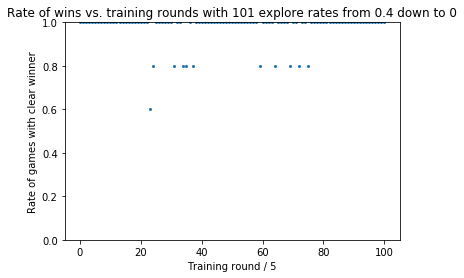

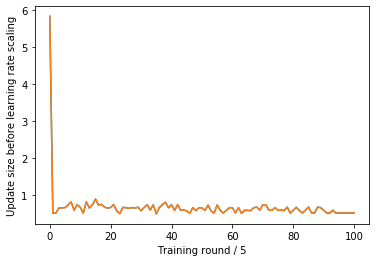

In [33]:
p144_100, p244_100 = makedynamic(5, 101, 0.5, rows=4, cols=4, movingalpha = True, stratnames='grav44final', 
                                         aggover=5, numfilters=8, filtersize=3, selftrain=True)

0.0025




  0%|                                                                                          | 0/201 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  0%|▍                                                                               | 1/201 [00:56<3:08:31, 56.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  1%|▊                                                                               | 2/201 [01:32<2:46:36, 50.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  1%|█▏                                                                              | 3/201 [02:27<2:50:48, 51.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  2%|█▌                                                                              | 4/201 [03:09<2:40:19, 48.83s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  2%|█▉                                                                              | 5/201 [03:51<2:32:43, 46.75s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  3%|██▍                                                                             | 6/201 [04:54<2:47:44, 51.61s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  3%|██▊                                                                             | 7/201 [05:48<2:49:29, 52.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  4%|███▏                                                                            | 8/201 [06:38<2:46:42, 51.83s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  4%|███▌                                                                            | 9/201 [07:23<2:38:40, 49.59s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  5%|███▉                                                                           | 10/201 [08:17<2:42:04, 50.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  5%|████▎                                                                          | 11/201 [09:17<2:49:43, 53.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  6%|████▋                                                                          | 12/201 [10:10<2:48:52, 53.61s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  6%|█████                                                                          | 13/201 [11:00<2:43:52, 52.30s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  7%|█████▌                                                                         | 14/201 [11:52<2:43:11, 52.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  7%|█████▉                                                                         | 15/201 [12:39<2:37:03, 50.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  8%|██████▎                                                                        | 16/201 [13:22<2:29:35, 48.51s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  8%|██████▋                                                                        | 17/201 [14:19<2:36:03, 50.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  9%|███████                                                                        | 18/201 [15:04<2:30:23, 49.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




  9%|███████▍                                                                       | 19/201 [15:54<2:29:48, 49.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 10%|███████▊                                                                       | 20/201 [16:45<2:30:26, 49.87s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 10%|████████▎                                                                      | 21/201 [17:26<2:21:55, 47.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 11%|████████▋                                                                      | 22/201 [18:01<2:10:15, 43.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 11%|█████████                                                                      | 23/201 [18:46<2:10:30, 43.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 12%|█████████▍                                                                     | 24/201 [19:31<2:10:56, 44.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 12%|█████████▊                                                                     | 25/201 [20:24<2:17:00, 46.71s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 13%|██████████▏                                                                    | 26/201 [21:09<2:15:24, 46.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 13%|██████████▌                                                                    | 27/201 [21:47<2:06:37, 43.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 14%|███████████                                                                    | 28/201 [22:50<2:23:17, 49.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 14%|███████████▍                                                                   | 29/201 [23:42<2:24:05, 50.27s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 15%|███████████▊                                                                   | 30/201 [24:41<2:31:04, 53.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 15%|████████████▏                                                                  | 31/201 [25:36<2:31:11, 53.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 16%|████████████▌                                                                  | 32/201 [26:16<2:19:00, 49.35s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 16%|████████████▉                                                                  | 33/201 [27:07<2:19:36, 49.86s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 17%|█████████████▎                                                                 | 34/201 [27:55<2:17:30, 49.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 17%|█████████████▊                                                                 | 35/201 [28:53<2:23:48, 51.98s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 18%|██████████████▏                                                                | 36/201 [29:42<2:20:47, 51.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 18%|██████████████▌                                                                | 37/201 [30:37<2:22:45, 52.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 19%|██████████████▉                                                                | 38/201 [31:28<2:21:00, 51.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 19%|███████████████▎                                                               | 39/201 [32:20<2:19:47, 51.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 20%|███████████████▋                                                               | 40/201 [33:21<2:27:08, 54.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 20%|████████████████                                                               | 41/201 [34:07<2:18:45, 52.03s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 21%|████████████████▌                                                              | 42/201 [34:56<2:15:31, 51.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 21%|████████████████▉                                                              | 43/201 [35:44<2:12:31, 50.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 22%|█████████████████▎                                                             | 44/201 [36:53<2:26:16, 55.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 22%|█████████████████▋                                                             | 45/201 [37:30<2:10:39, 50.25s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 23%|██████████████████                                                             | 46/201 [38:11<2:02:22, 47.37s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 23%|██████████████████▍                                                            | 47/201 [39:14<2:13:18, 51.94s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 24%|██████████████████▊                                                            | 48/201 [40:13<2:17:59, 54.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 24%|███████████████████▎                                                           | 49/201 [40:57<2:09:30, 51.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 25%|███████████████████▋                                                           | 50/201 [41:45<2:05:57, 50.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 25%|████████████████████                                                           | 51/201 [42:25<1:58:16, 47.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 26%|████████████████████▍                                                          | 52/201 [43:24<2:05:53, 50.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 26%|████████████████████▊                                                          | 53/201 [44:01<1:55:09, 46.68s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 27%|█████████████████████▏                                                         | 54/201 [44:47<1:53:30, 46.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 27%|█████████████████████▌                                                         | 55/201 [45:30<1:50:15, 45.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 28%|██████████████████████                                                         | 56/201 [46:29<1:59:41, 49.53s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 28%|██████████████████████▍                                                        | 57/201 [47:21<2:00:45, 50.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 29%|██████████████████████▊                                                        | 58/201 [48:24<2:09:00, 54.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 29%|███████████████████████▏                                                       | 59/201 [49:18<2:07:26, 53.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 30%|███████████████████████▌                                                       | 60/201 [50:11<2:06:21, 53.77s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 30%|███████████████████████▉                                                       | 61/201 [51:03<2:04:08, 53.21s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 31%|████████████████████████▎                                                      | 62/201 [51:53<2:01:04, 52.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 31%|████████████████████████▊                                                      | 63/201 [52:46<2:00:51, 52.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 32%|█████████████████████████▏                                                     | 64/201 [53:36<1:58:10, 51.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 32%|█████████████████████████▌                                                     | 65/201 [54:35<2:02:04, 53.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 33%|█████████████████████████▉                                                     | 66/201 [55:38<2:07:29, 56.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 33%|██████████████████████████▎                                                    | 67/201 [56:29<2:02:50, 55.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 34%|██████████████████████████▋                                                    | 68/201 [57:13<1:54:06, 51.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 34%|███████████████████████████                                                    | 69/201 [57:56<1:48:10, 49.17s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 35%|███████████████████████████▌                                                   | 70/201 [58:39<1:43:02, 47.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 35%|███████████████████████████▉                                                   | 71/201 [59:23<1:40:07, 46.21s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 36%|███████████████████████████▌                                                 | 72/201 [1:00:31<1:53:17, 52.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 36%|███████████████████████████▉                                                 | 73/201 [1:01:23<1:52:25, 52.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 37%|████████████████████████████▎                                                | 74/201 [1:02:12<1:48:44, 51.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 37%|████████████████████████████▋                                                | 75/201 [1:03:05<1:49:17, 52.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 38%|█████████████████████████████                                                | 76/201 [1:04:11<1:57:08, 56.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 38%|█████████████████████████████▍                                               | 77/201 [1:05:00<1:51:18, 53.86s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 39%|█████████████████████████████▉                                               | 78/201 [1:05:41<1:42:28, 49.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 39%|██████████████████████████████▎                                              | 79/201 [1:06:35<1:44:36, 51.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 40%|██████████████████████████████▋                                              | 80/201 [1:07:25<1:42:47, 50.97s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 40%|███████████████████████████████                                              | 81/201 [1:08:24<1:46:44, 53.37s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 41%|███████████████████████████████▍                                             | 82/201 [1:09:17<1:45:33, 53.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 41%|███████████████████████████████▊                                             | 83/201 [1:10:04<1:40:51, 51.29s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 42%|████████████████████████████████▏                                            | 84/201 [1:11:03<1:44:44, 53.71s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 42%|████████████████████████████████▌                                            | 85/201 [1:12:04<1:47:38, 55.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 43%|████████████████████████████████▉                                            | 86/201 [1:12:46<1:39:05, 51.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 43%|█████████████████████████████████▎                                           | 87/201 [1:13:43<1:41:08, 53.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 44%|█████████████████████████████████▋                                           | 88/201 [1:14:41<1:42:53, 54.63s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 44%|██████████████████████████████████                                           | 89/201 [1:15:33<1:40:40, 53.94s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 45%|██████████████████████████████████▍                                          | 90/201 [1:16:27<1:39:56, 54.02s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 45%|██████████████████████████████████▊                                          | 91/201 [1:17:30<1:43:46, 56.61s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 46%|███████████████████████████████████▏                                         | 92/201 [1:18:14<1:35:47, 52.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 46%|███████████████████████████████████▋                                         | 93/201 [1:19:09<1:36:21, 53.53s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 47%|████████████████████████████████████                                         | 94/201 [1:20:00<1:34:07, 52.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 47%|████████████████████████████████████▍                                        | 95/201 [1:20:44<1:28:39, 50.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 48%|████████████████████████████████████▊                                        | 96/201 [1:21:23<1:22:03, 46.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 48%|█████████████████████████████████████▏                                       | 97/201 [1:22:04<1:17:58, 44.98s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 49%|█████████████████████████████████████▌                                       | 98/201 [1:22:50<1:17:58, 45.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 49%|█████████████████████████████████████▉                                       | 99/201 [1:23:46<1:22:16, 48.40s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 50%|█████████████████████████████████████▊                                      | 100/201 [1:24:43<1:25:52, 51.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 50%|██████████████████████████████████████▏                                     | 101/201 [1:25:23<1:19:41, 47.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 51%|██████████████████████████████████████▌                                     | 102/201 [1:26:16<1:21:10, 49.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 51%|██████████████████████████████████████▉                                     | 103/201 [1:27:10<1:23:09, 50.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 52%|███████████████████████████████████████▎                                    | 104/201 [1:28:16<1:29:24, 55.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 52%|███████████████████████████████████████▋                                    | 105/201 [1:29:10<1:28:03, 55.03s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 53%|████████████████████████████████████████                                    | 106/201 [1:30:07<1:28:06, 55.65s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 53%|████████████████████████████████████████▍                                   | 107/201 [1:30:44<1:18:12, 49.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 54%|████████████████████████████████████████▊                                   | 108/201 [1:31:33<1:17:08, 49.77s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 54%|█████████████████████████████████████████▏                                  | 109/201 [1:32:20<1:14:42, 48.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 55%|█████████████████████████████████████████▌                                  | 110/201 [1:33:06<1:12:35, 47.86s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 55%|█████████████████████████████████████████▉                                  | 111/201 [1:33:59<1:14:29, 49.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 56%|██████████████████████████████████████████▎                                 | 112/201 [1:35:06<1:21:23, 54.87s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 56%|██████████████████████████████████████████▋                                 | 113/201 [1:35:57<1:18:29, 53.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 57%|███████████████████████████████████████████                                 | 114/201 [1:36:38<1:12:19, 49.87s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 57%|███████████████████████████████████████████▍                                | 115/201 [1:37:13<1:04:48, 45.21s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 58%|███████████████████████████████████████████▊                                | 116/201 [1:38:04<1:06:34, 47.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 58%|████████████████████████████████████████████▏                               | 117/201 [1:39:14<1:15:35, 54.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 59%|████████████████████████████████████████████▌                               | 118/201 [1:40:29<1:23:19, 60.24s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 59%|████████████████████████████████████████████▉                               | 119/201 [1:41:23<1:19:52, 58.44s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 60%|█████████████████████████████████████████████▎                              | 120/201 [1:42:19<1:17:53, 57.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 60%|█████████████████████████████████████████████▊                              | 121/201 [1:43:13<1:15:28, 56.61s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 61%|██████████████████████████████████████████████▏                             | 122/201 [1:44:24<1:19:59, 60.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 61%|██████████████████████████████████████████████▌                             | 123/201 [1:45:24<1:18:47, 60.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 62%|██████████████████████████████████████████████▉                             | 124/201 [1:46:05<1:10:15, 54.75s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 62%|███████████████████████████████████████████████▎                            | 125/201 [1:46:54<1:07:04, 52.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 63%|███████████████████████████████████████████████▋                            | 126/201 [1:47:53<1:08:32, 54.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 63%|████████████████████████████████████████████████                            | 127/201 [1:49:01<1:12:42, 58.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 64%|████████████████████████████████████████████████▍                           | 128/201 [1:49:58<1:10:45, 58.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 64%|████████████████████████████████████████████████▊                           | 129/201 [1:51:09<1:14:21, 61.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 65%|█████████████████████████████████████████████████▏                          | 130/201 [1:52:03<1:10:40, 59.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 65%|█████████████████████████████████████████████████▌                          | 131/201 [1:53:01<1:09:01, 59.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 66%|█████████████████████████████████████████████████▉                          | 132/201 [1:53:53<1:05:44, 57.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 66%|██████████████████████████████████████████████████▎                         | 133/201 [1:54:47<1:03:28, 56.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 67%|████████████████████████████████████████████████████                          | 134/201 [1:55:25<56:41, 50.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 67%|████████████████████████████████████████████████████▍                         | 135/201 [1:56:21<57:32, 52.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 68%|████████████████████████████████████████████████████▊                         | 136/201 [1:57:08<55:02, 50.81s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 68%|█████████████████████████████████████████████████████▏                        | 137/201 [1:57:53<52:11, 48.93s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 69%|█████████████████████████████████████████████████████▌                        | 138/201 [1:58:51<54:04, 51.51s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 69%|█████████████████████████████████████████████████████▉                        | 139/201 [1:59:36<51:12, 49.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 70%|██████████████████████████████████████████████████████▎                       | 140/201 [2:00:28<51:24, 50.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 70%|██████████████████████████████████████████████████████▋                       | 141/201 [2:01:16<49:34, 49.57s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 71%|███████████████████████████████████████████████████████                       | 142/201 [2:02:15<51:44, 52.61s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 71%|███████████████████████████████████████████████████████▍                      | 143/201 [2:02:57<47:37, 49.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 72%|███████████████████████████████████████████████████████▉                      | 144/201 [2:03:48<47:25, 49.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 72%|████████████████████████████████████████████████████████▎                     | 145/201 [2:04:55<51:09, 54.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 73%|████████████████████████████████████████████████████████▋                     | 146/201 [2:05:55<51:46, 56.49s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 73%|█████████████████████████████████████████████████████████                     | 147/201 [2:06:43<48:35, 53.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 74%|█████████████████████████████████████████████████████████▍                    | 148/201 [2:07:39<48:14, 54.62s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 74%|█████████████████████████████████████████████████████████▊                    | 149/201 [2:08:25<44:58, 51.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 75%|██████████████████████████████████████████████████████████▏                   | 150/201 [2:09:15<43:35, 51.28s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 75%|██████████████████████████████████████████████████████████▌                   | 151/201 [2:10:08<43:09, 51.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 76%|██████████████████████████████████████████████████████████▉                   | 152/201 [2:11:07<44:14, 54.18s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 76%|███████████████████████████████████████████████████████████▎                  | 153/201 [2:12:05<44:16, 55.34s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 77%|███████████████████████████████████████████████████████████▊                  | 154/201 [2:12:48<40:18, 51.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 77%|████████████████████████████████████████████████████████████▏                 | 155/201 [2:13:41<39:57, 52.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 78%|████████████████████████████████████████████████████████████▌                 | 156/201 [2:14:41<40:48, 54.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 78%|████████████████████████████████████████████████████████████▉                 | 157/201 [2:15:24<37:22, 50.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 79%|█████████████████████████████████████████████████████████████▎                | 158/201 [2:16:11<35:37, 49.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 79%|█████████████████████████████████████████████████████████████▋                | 159/201 [2:17:13<37:29, 53.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 80%|██████████████████████████████████████████████████████████████                | 160/201 [2:18:16<38:26, 56.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 80%|██████████████████████████████████████████████████████████████▍               | 161/201 [2:19:17<38:32, 57.81s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 81%|██████████████████████████████████████████████████████████████▊               | 162/201 [2:20:03<35:09, 54.09s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 81%|███████████████████████████████████████████████████████████████▎              | 163/201 [2:20:46<32:10, 50.81s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 82%|███████████████████████████████████████████████████████████████▋              | 164/201 [2:21:44<32:40, 52.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 82%|████████████████████████████████████████████████████████████████              | 165/201 [2:22:40<32:20, 53.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 83%|████████████████████████████████████████████████████████████████▍             | 166/201 [2:23:38<32:03, 54.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 83%|████████████████████████████████████████████████████████████████▊             | 167/201 [2:24:36<31:44, 56.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 84%|█████████████████████████████████████████████████████████████████▏            | 168/201 [2:25:22<29:14, 53.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 84%|█████████████████████████████████████████████████████████████████▌            | 169/201 [2:26:13<27:53, 52.30s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 85%|█████████████████████████████████████████████████████████████████▉            | 170/201 [2:27:08<27:23, 53.03s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 85%|██████████████████████████████████████████████████████████████████▎           | 171/201 [2:27:57<26:02, 52.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 86%|██████████████████████████████████████████████████████████████████▋           | 172/201 [2:28:50<25:11, 52.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 86%|███████████████████████████████████████████████████████████████████▏          | 173/201 [2:29:38<23:48, 51.02s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 87%|███████████████████████████████████████████████████████████████████▌          | 174/201 [2:30:25<22:24, 49.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 87%|███████████████████████████████████████████████████████████████████▉          | 175/201 [2:31:26<22:58, 53.03s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 88%|████████████████████████████████████████████████████████████████████▎         | 176/201 [2:32:20<22:18, 53.55s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 88%|████████████████████████████████████████████████████████████████████▋         | 177/201 [2:33:18<21:57, 54.88s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 89%|█████████████████████████████████████████████████████████████████████         | 178/201 [2:34:17<21:29, 56.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 89%|█████████████████████████████████████████████████████████████████████▍        | 179/201 [2:35:14<20:36, 56.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 90%|█████████████████████████████████████████████████████████████████████▊        | 180/201 [2:36:15<20:12, 57.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 90%|██████████████████████████████████████████████████████████████████████▏       | 181/201 [2:37:09<18:52, 56.63s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 91%|██████████████████████████████████████████████████████████████████████▋       | 182/201 [2:38:15<18:46, 59.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 91%|███████████████████████████████████████████████████████████████████████       | 183/201 [2:39:16<18:01, 60.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 92%|███████████████████████████████████████████████████████████████████████▍      | 184/201 [2:40:05<16:00, 56.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 92%|███████████████████████████████████████████████████████████████████████▊      | 185/201 [2:40:57<14:46, 55.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 93%|████████████████████████████████████████████████████████████████████████▏     | 186/201 [2:41:57<14:09, 56.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 93%|████████████████████████████████████████████████████████████████████████▌     | 187/201 [2:43:02<13:49, 59.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 94%|████████████████████████████████████████████████████████████████████████▉     | 188/201 [2:43:59<12:40, 58.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 94%|█████████████████████████████████████████████████████████████████████████▎    | 189/201 [2:44:54<11:29, 57.46s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 95%|█████████████████████████████████████████████████████████████████████████▋    | 190/201 [2:45:50<10:26, 56.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 95%|██████████████████████████████████████████████████████████████████████████    | 191/201 [2:46:36<08:56, 53.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 96%|██████████████████████████████████████████████████████████████████████████▌   | 192/201 [2:47:27<07:56, 52.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 96%|██████████████████████████████████████████████████████████████████████████▉   | 193/201 [2:48:20<07:02, 52.80s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 97%|███████████████████████████████████████████████████████████████████████████▎  | 194/201 [2:49:17<06:19, 54.28s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 97%|███████████████████████████████████████████████████████████████████████████▋  | 195/201 [2:50:15<05:31, 55.29s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 98%|████████████████████████████████████████████████████████████████████████████  | 196/201 [2:51:14<04:42, 56.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 98%|████████████████████████████████████████████████████████████████████████████▍ | 197/201 [2:52:03<03:36, 54.24s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 99%|████████████████████████████████████████████████████████████████████████████▊ | 198/201 [2:53:02<02:47, 55.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




 99%|█████████████████████████████████████████████████████████████████████████████▏| 199/201 [2:53:54<01:49, 54.59s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




100%|█████████████████████████████████████████████████████████████████████████████▌| 200/201 [2:54:47<00:53, 53.93s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets




100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [2:55:40<00:00, 52.44s/it]


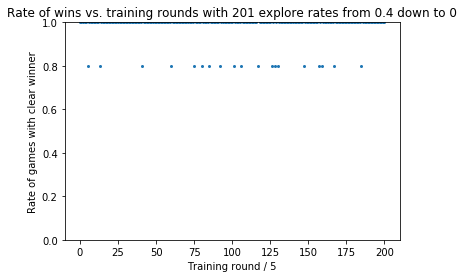

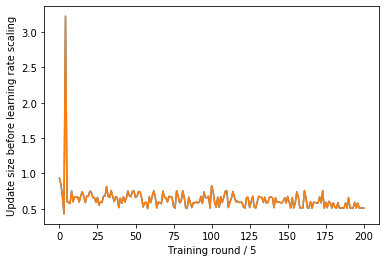

In [34]:
p144_200, p244_200 = makedynamic(5, 201, 0.5, rows=4, cols=4, movingalpha = True, stratnames='grav44final', 
                                         aggover=5, numfilters=8, filtersize=3, selftrain=True)

In [36]:
#p1 = player("computer", explore_rate=0)
human = HumanPlayer("human")
#p1.loadPolicy("policy_p1")
game = tictactoe(p144_200, human, numrows=4, numcols=4, wincount=3, gravitymove=True)
game.playhuman()

   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------
3  |   |   |   |   | 
---------------------

[0, 1, 2, 3]
3
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   |   | 
---------------------
3  |   |   |   | x | 
---------------------

[0, 1, 2, 3]
Input your action col:3
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   |   | 
---------------------
2  |   |   |   | o | 
---------------------
3  |   |   |   | x | 
---------------------

[0, 1, 2, 3]
3
   | 0 | 1 | 2 | 3 |
---------------------
0  |   |   |   |   | 
---------------------
1  |   |   |   | x | 
---------------------
2  |   |   |   | o | 
---------------------
3  |   |   |   | x | 
---------------------

[0, 1, 2, 3]
Input your action col:3
   | 0 | 1 | 2 |

1

8 filters is actually still doing poorly. Do we just use 4 like usual? Let's test 4 filters with 100 and 200 rounds of 5, and with square loss and without. Even with fewer filters, square loss still does badly for 4x4. I think 4x4 is just not really well built for this architecture.

0.005



  0%|                                                                                          | 0/101 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  1%|▊                                                                               | 1/101 [00:49<1:23:04, 49.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  2%|█▌                                                                              | 2/101 [01:55<1:30:12, 54.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  3%|██▍                                                                             | 3/101 [02:52<1:30:23, 55.35s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  4%|███▏                                                                            | 4/101 [03:28<1:20:06, 49.55s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  5%|███▉                                                                            | 5/101 [04:18<1:19:09, 49.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  6%|████▊                                                                           | 6/101 [05:11<1:20:07, 50.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  7%|█████▌                                                                          | 7/101 [06:10<1:23:17, 53.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  8%|██████▎                                                                         | 8/101 [07:14<1:27:30, 56.46s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  9%|███████▏                                                                        | 9/101 [07:49<1:16:29, 49.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 10%|███████▊                                                                       | 10/101 [08:53<1:22:18, 54.27s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 11%|████████▌                                                                      | 11/101 [09:55<1:24:47, 56.53s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 12%|█████████▍                                                                     | 12/101 [10:42<1:19:50, 53.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 13%|██████████▏                                                                    | 13/101 [11:36<1:18:44, 53.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 14%|██████████▉                                                                    | 14/101 [12:18<1:13:04, 50.40s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 15%|███████████▋                                                                   | 15/101 [13:05<1:10:45, 49.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 16%|████████████▌                                                                  | 16/101 [14:06<1:14:34, 52.64s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 17%|█████████████▎                                                                 | 17/101 [14:51<1:10:39, 50.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 18%|██████████████                                                                 | 18/101 [15:32<1:05:44, 47.53s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 19%|██████████████▊                                                                | 19/101 [16:17<1:04:09, 46.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 20%|███████████████▋                                                               | 20/101 [17:06<1:03:53, 47.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 21%|████████████████▍                                                              | 21/101 [18:08<1:08:56, 51.71s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 22%|█████████████████▏                                                             | 22/101 [18:45<1:02:30, 47.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 23%|█████████████████▉                                                             | 23/101 [19:31<1:01:07, 47.02s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 24%|██████████████████▊                                                            | 24/101 [20:20<1:01:11, 47.68s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 25%|███████████████████▌                                                           | 25/101 [21:18<1:04:17, 50.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 26%|████████████████████▎                                                          | 26/101 [22:27<1:10:08, 56.11s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 27%|█████████████████████                                                          | 27/101 [23:24<1:09:25, 56.30s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 28%|█████████████████████▉                                                         | 28/101 [24:13<1:05:53, 54.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 29%|██████████████████████▋                                                        | 29/101 [25:16<1:08:16, 56.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 30%|███████████████████████▍                                                       | 30/101 [26:12<1:06:54, 56.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 31%|████████████████████████▏                                                      | 31/101 [27:12<1:07:10, 57.57s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 32%|█████████████████████████                                                      | 32/101 [28:20<1:10:02, 60.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 33%|█████████████████████████▊                                                     | 33/101 [29:10<1:05:02, 57.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 34%|██████████████████████████▌                                                    | 34/101 [30:03<1:02:53, 56.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 35%|███████████████████████████▍                                                   | 35/101 [31:02<1:02:46, 57.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 36%|████████████████████████████▊                                                    | 36/101 [31:53<59:44, 55.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 37%|█████████████████████████████▋                                                   | 37/101 [32:42<56:48, 53.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 38%|██████████████████████████████▍                                                  | 38/101 [33:39<57:14, 54.51s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 39%|██████████████████████████████▌                                                | 39/101 [34:51<1:01:42, 59.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 40%|████████████████████████████████                                                 | 40/101 [35:41<57:51, 56.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 41%|████████████████████████████████▉                                                | 41/101 [36:42<58:09, 58.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 42%|█████████████████████████████████▋                                               | 42/101 [37:40<56:55, 57.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 43%|█████████████████████████████████▋                                             | 43/101 [39:03<1:03:17, 65.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 44%|██████████████████████████████████▍                                            | 44/101 [40:09<1:02:27, 65.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 45%|████████████████████████████████████                                             | 45/101 [41:01<57:18, 61.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 46%|████████████████████████████████████▉                                            | 46/101 [41:55<54:23, 59.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 47%|█████████████████████████████████████▋                                           | 47/101 [42:59<54:38, 60.71s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 48%|██████████████████████████████████████▍                                          | 48/101 [44:02<54:07, 61.27s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 49%|███████████████████████████████████████▎                                         | 49/101 [44:55<50:57, 58.80s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 50%|████████████████████████████████████████                                         | 50/101 [45:58<51:16, 60.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 50%|████████████████████████████████████████▉                                        | 51/101 [46:53<48:45, 58.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 51%|█████████████████████████████████████████▋                                       | 52/101 [47:59<49:38, 60.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 52%|██████████████████████████████████████████▌                                      | 53/101 [49:01<49:00, 61.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 53%|███████████████████████████████████████████▎                                     | 54/101 [49:59<47:03, 60.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 54%|████████████████████████████████████████████                                     | 55/101 [50:51<44:21, 57.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 55%|████████████████████████████████████████████▉                                    | 56/101 [51:49<43:24, 57.87s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 56%|█████████████████████████████████████████████▋                                   | 57/101 [52:29<38:24, 52.37s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 57%|██████████████████████████████████████████████▌                                  | 58/101 [53:35<40:32, 56.57s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 58%|███████████████████████████████████████████████▎                                 | 59/101 [54:30<39:14, 56.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 59%|████████████████████████████████████████████████                                 | 60/101 [55:30<39:08, 57.27s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 60%|████████████████████████████████████████████████▉                                | 61/101 [56:23<37:21, 56.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 61%|█████████████████████████████████████████████████▋                               | 62/101 [57:13<35:18, 54.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 62%|██████████████████████████████████████████████████▌                              | 63/101 [58:28<38:18, 60.49s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 63%|███████████████████████████████████████████████████▎                             | 64/101 [59:27<36:57, 59.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 64%|██████████████████████████████████████████████████▊                            | 65/101 [1:00:33<37:00, 61.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 65%|███████████████████████████████████████████████████▌                           | 66/101 [1:01:22<33:50, 58.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 66%|████████████████████████████████████████████████████▍                          | 67/101 [1:02:17<32:25, 57.21s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 67%|█████████████████████████████████████████████████████▏                         | 68/101 [1:03:29<33:46, 61.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 68%|█████████████████████████████████████████████████████▉                         | 69/101 [1:04:23<31:36, 59.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 69%|██████████████████████████████████████████████████████▊                        | 70/101 [1:05:34<32:25, 62.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 70%|███████████████████████████████████████████████████████▌                       | 71/101 [1:06:32<30:42, 61.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 71%|████████████████████████████████████████████████████████▎                      | 72/101 [1:07:42<30:54, 63.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 72%|█████████████████████████████████████████████████████████                      | 73/101 [1:08:56<31:18, 67.09s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 73%|█████████████████████████████████████████████████████████▉                     | 74/101 [1:09:51<28:33, 63.46s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 74%|██████████████████████████████████████████████████████████▋                    | 75/101 [1:10:51<26:59, 62.30s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 75%|███████████████████████████████████████████████████████████▍                   | 76/101 [1:12:05<27:23, 65.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 76%|████████████████████████████████████████████████████████████▏                  | 77/101 [1:13:23<27:44, 69.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 77%|█████████████████████████████████████████████████████████████                  | 78/101 [1:14:30<26:18, 68.63s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 78%|█████████████████████████████████████████████████████████████▊                 | 79/101 [1:15:44<25:50, 70.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 79%|██████████████████████████████████████████████████████████████▌                | 80/101 [1:16:44<23:32, 67.25s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 80%|███████████████████████████████████████████████████████████████▎               | 81/101 [1:17:57<23:02, 69.11s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 81%|████████████████████████████████████████████████████████████████▏              | 82/101 [1:18:59<21:09, 66.79s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 82%|████████████████████████████████████████████████████████████████▉              | 83/101 [1:20:04<19:51, 66.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 83%|█████████████████████████████████████████████████████████████████▋             | 84/101 [1:21:18<19:27, 68.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 84%|██████████████████████████████████████████████████████████████████▍            | 85/101 [1:22:37<19:05, 71.62s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 85%|███████████████████████████████████████████████████████████████████▎           | 86/101 [1:23:34<16:50, 67.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 86%|████████████████████████████████████████████████████████████████████           | 87/101 [1:24:24<14:29, 62.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 87%|████████████████████████████████████████████████████████████████████▊          | 88/101 [1:25:42<14:28, 66.79s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 88%|█████████████████████████████████████████████████████████████████████▌         | 89/101 [1:27:00<14:04, 70.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 89%|██████████████████████████████████████████████████████████████████████▍        | 90/101 [1:28:01<12:21, 67.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 90%|███████████████████████████████████████████████████████████████████████▏       | 91/101 [1:29:23<11:57, 71.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 91%|███████████████████████████████████████████████████████████████████████▉       | 92/101 [1:30:33<10:42, 71.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 92%|████████████████████████████████████████████████████████████████████████▋      | 93/101 [1:31:36<09:11, 68.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 93%|█████████████████████████████████████████████████████████████████████████▌     | 94/101 [1:32:53<08:18, 71.18s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 94%|██████████████████████████████████████████████████████████████████████████▎    | 95/101 [1:34:06<07:10, 71.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 95%|███████████████████████████████████████████████████████████████████████████    | 96/101 [1:35:11<05:49, 69.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 96%|███████████████████████████████████████████████████████████████████████████▊   | 97/101 [1:36:23<04:41, 70.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 97%|████████████████████████████████████████████████████████████████████████████▋  | 98/101 [1:37:41<03:38, 72.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 98%|█████████████████████████████████████████████████████████████████████████████▍ | 99/101 [1:38:59<02:28, 74.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 99%|█████████████████████████████████████████████████████████████████████████████▏| 100/101 [1:40:19<01:16, 76.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [1:41:33<00:00, 60.34s/it]


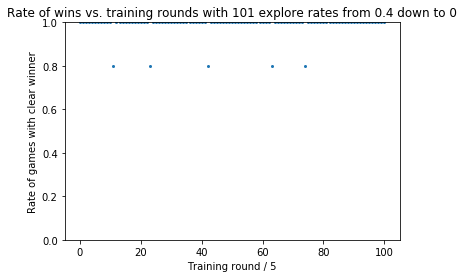

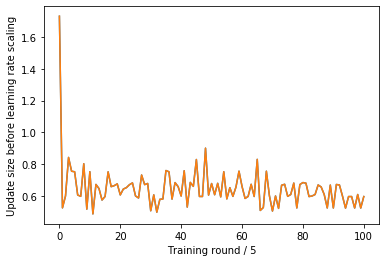

In [8]:
p144_100_4, p244_100_4 = makedynamic(5, 101, 0.5, rows=4, cols=4, movingalpha = True, stratnames='grav44final', 
                                         aggover=5, numfilters=4, filtersize=3, selftrain=True)

0.005



  0%|                                                                                          | 0/101 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  1%|▊                                                                                 | 1/101 [00:34<56:42, 34.03s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  2%|█▌                                                                              | 2/101 [01:21<1:02:53, 38.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  3%|██▍                                                                             | 3/101 [02:06<1:05:30, 40.11s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  4%|███▏                                                                            | 4/101 [02:51<1:07:05, 41.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  5%|███▉                                                                            | 5/101 [03:40<1:10:20, 43.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  6%|████▊                                                                           | 6/101 [04:32<1:13:03, 46.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  7%|█████▌                                                                          | 7/101 [05:21<1:13:56, 47.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  8%|██████▎                                                                         | 8/101 [06:13<1:15:06, 48.46s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  9%|███████▏                                                                        | 9/101 [07:00<1:13:42, 48.07s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 10%|███████▊                                                                       | 10/101 [07:44<1:11:01, 46.83s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 11%|████████▌                                                                      | 11/101 [08:28<1:09:09, 46.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 12%|█████████▍                                                                     | 12/101 [09:02<1:02:53, 42.40s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 13%|██████████▏                                                                    | 13/101 [09:56<1:07:08, 45.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 14%|██████████▉                                                                    | 14/101 [10:49<1:09:47, 48.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 15%|███████████▋                                                                   | 15/101 [11:48<1:13:46, 51.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 16%|████████████▌                                                                  | 16/101 [13:09<1:25:04, 60.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 17%|█████████████▎                                                                 | 17/101 [14:28<1:32:02, 65.75s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 18%|██████████████                                                                 | 18/101 [15:37<1:32:33, 66.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 19%|██████████████▊                                                                | 19/101 [16:40<1:29:46, 65.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 20%|███████████████▋                                                               | 20/101 [17:34<1:23:56, 62.17s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 21%|████████████████▍                                                              | 21/101 [18:36<1:22:52, 62.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 22%|█████████████████▏                                                             | 22/101 [20:06<1:32:54, 70.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 23%|█████████████████▉                                                             | 23/101 [21:19<1:32:37, 71.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 24%|██████████████████▊                                                            | 24/101 [22:25<1:29:23, 69.65s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 25%|███████████████████▌                                                           | 25/101 [23:22<1:23:31, 65.94s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 26%|████████████████████▎                                                          | 26/101 [24:20<1:19:17, 63.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 27%|█████████████████████                                                          | 27/101 [25:34<1:22:19, 66.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 28%|█████████████████████▉                                                         | 28/101 [26:30<1:17:16, 63.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 29%|██████████████████████▋                                                        | 29/101 [27:57<1:24:27, 70.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 30%|███████████████████████▍                                                       | 30/101 [28:56<1:19:11, 66.93s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 31%|████████████████████████▏                                                      | 31/101 [29:47<1:12:34, 62.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 32%|█████████████████████████                                                      | 32/101 [30:36<1:07:05, 58.34s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 33%|█████████████████████████▊                                                     | 33/101 [31:22<1:01:46, 54.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 34%|███████████████████████████▎                                                     | 34/101 [32:13<59:46, 53.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 35%|████████████████████████████                                                     | 35/101 [32:50<53:34, 48.71s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 36%|████████████████████████████▊                                                    | 36/101 [33:44<54:19, 50.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 37%|█████████████████████████████▋                                                   | 37/101 [34:24<50:19, 47.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 38%|██████████████████████████████▍                                                  | 38/101 [35:02<46:42, 44.49s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 39%|███████████████████████████████▎                                                 | 39/101 [35:44<45:00, 43.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 40%|████████████████████████████████                                                 | 40/101 [36:47<50:15, 49.44s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 41%|████████████████████████████████▉                                                | 41/101 [37:33<48:26, 48.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 42%|█████████████████████████████████▋                                               | 42/101 [38:26<49:02, 49.87s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 43%|██████████████████████████████████▍                                              | 43/101 [39:16<48:08, 49.80s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 44%|███████████████████████████████████▎                                             | 44/101 [40:10<48:38, 51.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 45%|████████████████████████████████████                                             | 45/101 [40:54<45:43, 48.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 46%|████████████████████████████████████▉                                            | 46/101 [41:32<41:54, 45.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 47%|█████████████████████████████████████▋                                           | 47/101 [42:14<39:56, 44.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 48%|██████████████████████████████████████▍                                          | 48/101 [42:58<39:08, 44.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 49%|███████████████████████████████████████▎                                         | 49/101 [43:44<39:00, 45.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 50%|████████████████████████████████████████                                         | 50/101 [44:27<37:34, 44.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 50%|████████████████████████████████████████▉                                        | 51/101 [45:32<42:02, 50.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 51%|█████████████████████████████████████████▋                                       | 52/101 [46:08<37:39, 46.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 52%|██████████████████████████████████████████▌                                      | 53/101 [46:57<37:31, 46.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 53%|███████████████████████████████████████████▎                                     | 54/101 [47:40<35:58, 45.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 54%|████████████████████████████████████████████                                     | 55/101 [48:34<37:02, 48.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 55%|████████████████████████████████████████████▉                                    | 56/101 [49:20<35:38, 47.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 56%|█████████████████████████████████████████████▋                                   | 57/101 [50:02<33:39, 45.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 57%|██████████████████████████████████████████████▌                                  | 58/101 [50:46<32:36, 45.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 58%|███████████████████████████████████████████████▎                                 | 59/101 [51:48<35:16, 50.40s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 59%|████████████████████████████████████████████████                                 | 60/101 [52:31<32:50, 48.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 60%|████████████████████████████████████████████████▉                                | 61/101 [53:22<32:42, 49.07s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 61%|█████████████████████████████████████████████████▋                               | 62/101 [54:06<30:48, 47.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 62%|██████████████████████████████████████████████████▌                              | 63/101 [54:54<30:12, 47.71s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 63%|███████████████████████████████████████████████████▎                             | 64/101 [55:32<27:34, 44.71s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 64%|████████████████████████████████████████████████████▏                            | 65/101 [56:28<28:47, 48.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 65%|████████████████████████████████████████████████████▉                            | 66/101 [57:11<27:08, 46.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 66%|█████████████████████████████████████████████████████▋                           | 67/101 [58:00<26:55, 47.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 67%|██████████████████████████████████████████████████████▌                          | 68/101 [59:04<28:48, 52.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 68%|███████████████████████████████████████████████████████▎                         | 69/101 [59:45<26:08, 49.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 69%|██████████████████████████████████████████████████████▊                        | 70/101 [1:00:43<26:35, 51.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 70%|███████████████████████████████████████████████████████▌                       | 71/101 [1:01:43<27:00, 54.03s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 71%|████████████████████████████████████████████████████████▎                      | 72/101 [1:02:32<25:29, 52.75s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 72%|█████████████████████████████████████████████████████████                      | 73/101 [1:03:21<24:05, 51.63s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 73%|█████████████████████████████████████████████████████████▉                     | 74/101 [1:04:17<23:43, 52.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 74%|██████████████████████████████████████████████████████████▋                    | 75/101 [1:04:55<20:59, 48.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 75%|███████████████████████████████████████████████████████████▍                   | 76/101 [1:05:49<20:53, 50.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 76%|████████████████████████████████████████████████████████████▏                  | 77/101 [1:06:31<18:59, 47.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 77%|█████████████████████████████████████████████████████████████                  | 78/101 [1:07:17<18:04, 47.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 78%|█████████████████████████████████████████████████████████████▊                 | 79/101 [1:07:53<16:04, 43.86s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 79%|██████████████████████████████████████████████████████████████▌                | 80/101 [1:08:39<15:34, 44.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 80%|███████████████████████████████████████████████████████████████▎               | 81/101 [1:09:15<13:59, 41.98s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 81%|████████████████████████████████████████████████████████████████▏              | 82/101 [1:10:00<13:34, 42.87s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 82%|████████████████████████████████████████████████████████████████▉              | 83/101 [1:10:51<13:36, 45.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 83%|█████████████████████████████████████████████████████████████████▋             | 84/101 [1:11:40<13:09, 46.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 84%|██████████████████████████████████████████████████████████████████▍            | 85/101 [1:12:23<12:06, 45.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 85%|███████████████████████████████████████████████████████████████████▎           | 86/101 [1:13:18<12:03, 48.24s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 86%|████████████████████████████████████████████████████████████████████           | 87/101 [1:14:05<11:09, 47.81s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 87%|████████████████████████████████████████████████████████████████████▊          | 88/101 [1:14:53<10:22, 47.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 88%|█████████████████████████████████████████████████████████████████████▌         | 89/101 [1:15:33<09:07, 45.61s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 89%|██████████████████████████████████████████████████████████████████████▍        | 90/101 [1:16:25<08:42, 47.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 90%|███████████████████████████████████████████████████████████████████████▏       | 91/101 [1:17:39<09:13, 55.34s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 91%|███████████████████████████████████████████████████████████████████████▉       | 92/101 [1:18:27<07:58, 53.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 92%|████████████████████████████████████████████████████████████████████████▋      | 93/101 [1:19:26<07:20, 55.07s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 93%|█████████████████████████████████████████████████████████████████████████▌     | 94/101 [1:20:08<05:57, 51.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 94%|██████████████████████████████████████████████████████████████████████████▎    | 95/101 [1:20:45<04:41, 46.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 95%|███████████████████████████████████████████████████████████████████████████    | 96/101 [1:21:38<04:02, 48.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 96%|███████████████████████████████████████████████████████████████████████████▊   | 97/101 [1:22:24<03:11, 47.97s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 97%|████████████████████████████████████████████████████████████████████████████▋  | 98/101 [1:23:10<02:22, 47.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 98%|█████████████████████████████████████████████████████████████████████████████▍ | 99/101 [1:23:51<01:30, 45.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 99%|█████████████████████████████████████████████████████████████████████████████▏| 100/101 [1:24:32<00:44, 44.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [1:25:15<00:00, 50.65s/it]


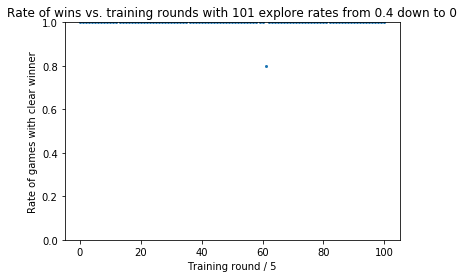

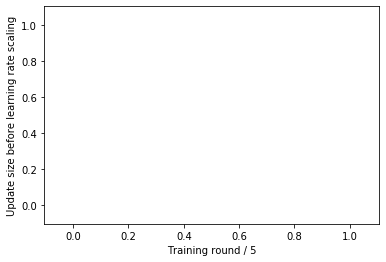

In [9]:
p144_100_4, p244_100_4 = makedynamic(5, 101, 0.5, rows=4, cols=4, movingalpha = True, stratnames='grav44final', 
                                         aggover=5, numfilters=4, filtersize=3, selftrain=True, squareloss=True)

0.0025



  0%|                                                                                          | 0/201 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  0%|▍                                                                               | 1/201 [00:49<2:44:29, 49.35s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  1%|▊                                                                               | 2/201 [01:46<2:51:18, 51.65s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  1%|█▏                                                                              | 3/201 [02:38<2:50:30, 51.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  2%|█▌                                                                              | 4/201 [03:19<2:39:32, 48.59s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  2%|█▉                                                                              | 5/201 [03:58<2:29:18, 45.71s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  3%|██▍                                                                             | 6/201 [04:54<2:38:23, 48.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  3%|██▊                                                                             | 7/201 [05:57<2:51:26, 53.02s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  4%|███▏                                                                            | 8/201 [06:53<2:53:51, 54.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  4%|███▌                                                                            | 9/201 [07:47<2:52:38, 53.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  5%|███▉                                                                           | 10/201 [08:35<2:46:27, 52.29s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  5%|████▎                                                                          | 11/201 [09:25<2:43:20, 51.58s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  6%|████▋                                                                          | 12/201 [10:19<2:44:04, 52.09s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  6%|█████                                                                          | 13/201 [11:06<2:38:58, 50.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  7%|█████▌                                                                         | 14/201 [12:04<2:45:12, 53.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  7%|█████▉                                                                         | 15/201 [12:47<2:34:30, 49.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  8%|██████▎                                                                        | 16/201 [13:36<2:33:06, 49.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  8%|██████▋                                                                        | 17/201 [14:33<2:38:59, 51.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  9%|███████                                                                        | 18/201 [15:28<2:40:32, 52.64s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  9%|███████▍                                                                       | 19/201 [16:14<2:33:50, 50.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 10%|███████▊                                                                       | 20/201 [17:03<2:31:55, 50.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 10%|████████▎                                                                      | 21/201 [17:32<2:11:40, 43.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 11%|████████▋                                                                      | 22/201 [18:28<2:22:00, 47.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 11%|█████████                                                                      | 23/201 [19:20<2:24:20, 48.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 12%|█████████▍                                                                     | 24/201 [20:05<2:20:57, 47.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 12%|█████████▊                                                                     | 25/201 [20:56<2:23:06, 48.79s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 13%|██████████▏                                                                    | 26/201 [21:46<2:22:41, 48.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 13%|██████████▌                                                                    | 27/201 [22:54<2:38:47, 54.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 14%|███████████                                                                    | 28/201 [23:45<2:34:51, 53.71s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 14%|███████████▍                                                                   | 29/201 [24:34<2:29:40, 52.21s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 15%|███████████▊                                                                   | 30/201 [25:26<2:29:02, 52.29s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 15%|████████████▏                                                                  | 31/201 [26:34<2:41:07, 56.87s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 16%|████████████▌                                                                  | 32/201 [27:27<2:36:55, 55.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 16%|████████████▉                                                                  | 33/201 [28:20<2:33:31, 54.83s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 17%|█████████████▎                                                                 | 34/201 [29:26<2:42:26, 58.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 17%|█████████████▊                                                                 | 35/201 [30:12<2:30:55, 54.55s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 18%|██████████████▏                                                                | 36/201 [31:31<2:50:26, 61.98s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 18%|██████████████▌                                                                | 37/201 [32:52<3:04:35, 67.53s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 19%|██████████████▉                                                                | 38/201 [33:50<2:55:31, 64.61s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 19%|███████████████▎                                                               | 39/201 [34:49<2:50:21, 63.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 20%|███████████████▋                                                               | 40/201 [35:33<2:34:06, 57.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 20%|████████████████                                                               | 41/201 [36:27<2:29:47, 56.17s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 21%|████████████████▌                                                              | 42/201 [36:58<2:08:46, 48.59s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 21%|████████████████▉                                                              | 43/201 [37:45<2:07:20, 48.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 22%|█████████████████▎                                                             | 44/201 [38:31<2:04:28, 47.57s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 22%|█████████████████▋                                                             | 45/201 [39:10<1:56:49, 44.93s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 23%|██████████████████                                                             | 46/201 [39:52<1:54:04, 44.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 23%|██████████████████▍                                                            | 47/201 [40:31<1:49:04, 42.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 24%|██████████████████▊                                                            | 48/201 [41:08<1:44:19, 40.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 24%|███████████████████▎                                                           | 49/201 [42:11<2:00:15, 47.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 25%|███████████████████▋                                                           | 50/201 [42:56<1:57:49, 46.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 25%|████████████████████                                                           | 51/201 [44:03<2:12:06, 52.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 26%|████████████████████▍                                                          | 52/201 [44:46<2:04:11, 50.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 26%|████████████████████▊                                                          | 53/201 [45:36<2:03:20, 50.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 27%|█████████████████████▏                                                         | 54/201 [46:28<2:03:20, 50.34s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 27%|█████████████████████▌                                                         | 55/201 [47:13<1:58:40, 48.77s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 28%|██████████████████████                                                         | 56/201 [48:02<1:58:18, 48.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 28%|██████████████████████▍                                                        | 57/201 [49:04<2:06:56, 52.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 29%|██████████████████████▊                                                        | 58/201 [49:54<2:03:49, 51.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 29%|███████████████████████▏                                                       | 59/201 [50:45<2:02:37, 51.81s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 30%|███████████████████████▌                                                       | 60/201 [51:40<2:03:48, 52.68s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 30%|███████████████████████▉                                                       | 61/201 [52:42<2:09:17, 55.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 31%|████████████████████████▎                                                      | 62/201 [53:20<1:56:40, 50.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 31%|████████████████████████▊                                                      | 63/201 [54:19<2:01:09, 52.68s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 32%|█████████████████████████▏                                                     | 64/201 [55:04<1:55:02, 50.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 32%|█████████████████████████▌                                                     | 65/201 [55:51<1:51:56, 49.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 33%|█████████████████████████▉                                                     | 66/201 [56:35<1:47:30, 47.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 33%|██████████████████████████▎                                                    | 67/201 [57:38<1:57:20, 52.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 34%|██████████████████████████▋                                                    | 68/201 [58:41<2:03:00, 55.49s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 34%|███████████████████████████                                                    | 69/201 [59:36<2:01:59, 55.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 35%|██████████████████████████▊                                                  | 70/201 [1:00:33<2:01:44, 55.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 35%|███████████████████████████▏                                                 | 71/201 [1:01:21<1:55:57, 53.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 36%|███████████████████████████▌                                                 | 72/201 [1:02:23<2:00:43, 56.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 36%|███████████████████████████▉                                                 | 73/201 [1:03:30<2:06:50, 59.46s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 37%|████████████████████████████▎                                                | 74/201 [1:04:32<2:07:20, 60.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 37%|████████████████████████████▋                                                | 75/201 [1:05:22<1:59:47, 57.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 38%|█████████████████████████████                                                | 76/201 [1:06:08<1:51:44, 53.63s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 38%|█████████████████████████████▍                                               | 77/201 [1:06:58<1:49:06, 52.80s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 39%|█████████████████████████████▉                                               | 78/201 [1:07:46<1:44:58, 51.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 39%|██████████████████████████████▎                                              | 79/201 [1:08:41<1:46:39, 52.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 40%|██████████████████████████████▋                                              | 80/201 [1:09:29<1:42:42, 50.93s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 40%|███████████████████████████████                                              | 81/201 [1:10:35<1:50:58, 55.49s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 41%|███████████████████████████████▍                                             | 82/201 [1:11:23<1:45:49, 53.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 41%|███████████████████████████████▊                                             | 83/201 [1:12:18<1:45:50, 53.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 42%|████████████████████████████████▏                                            | 84/201 [1:13:04<1:40:27, 51.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 42%|████████████████████████████████▌                                            | 85/201 [1:13:52<1:37:16, 50.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 43%|████████████████████████████████▉                                            | 86/201 [1:14:43<1:37:13, 50.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 43%|█████████████████████████████████▎                                           | 87/201 [1:15:52<1:46:51, 56.24s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 44%|█████████████████████████████████▋                                           | 88/201 [1:16:55<1:49:28, 58.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 44%|██████████████████████████████████                                           | 89/201 [1:17:39<1:40:30, 53.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 45%|██████████████████████████████████▍                                          | 90/201 [1:18:26<1:36:04, 51.93s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 45%|██████████████████████████████████▊                                          | 91/201 [1:19:19<1:35:44, 52.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 46%|███████████████████████████████████▏                                         | 92/201 [1:20:17<1:37:47, 53.83s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 46%|███████████████████████████████████▋                                         | 93/201 [1:21:17<1:40:13, 55.68s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 47%|████████████████████████████████████                                         | 94/201 [1:22:34<1:50:42, 62.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 47%|████████████████████████████████████▍                                        | 95/201 [1:23:30<1:46:39, 60.37s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 48%|████████████████████████████████████▊                                        | 96/201 [1:24:26<1:43:23, 59.09s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 48%|█████████████████████████████████████▏                                       | 97/201 [1:25:18<1:38:36, 56.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 49%|█████████████████████████████████████▌                                       | 98/201 [1:26:19<1:39:49, 58.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 49%|█████████████████████████████████████▉                                       | 99/201 [1:27:16<1:38:23, 57.88s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 50%|█████████████████████████████████████▊                                      | 100/201 [1:28:27<1:44:01, 61.80s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 50%|██████████████████████████████████████▏                                     | 101/201 [1:29:32<1:44:37, 62.77s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 51%|██████████████████████████████████████▌                                     | 102/201 [1:30:27<1:39:38, 60.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 51%|██████████████████████████████████████▉                                     | 103/201 [1:31:29<1:39:33, 60.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 52%|███████████████████████████████████████▎                                    | 104/201 [1:32:17<1:32:00, 56.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 52%|███████████████████████████████████████▋                                    | 105/201 [1:33:12<1:30:14, 56.40s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 53%|████████████████████████████████████████                                    | 106/201 [1:34:07<1:28:21, 55.81s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 53%|████████████████████████████████████████▍                                   | 107/201 [1:35:27<1:38:45, 63.04s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 54%|████████████████████████████████████████▊                                   | 108/201 [1:36:24<1:34:55, 61.24s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 54%|█████████████████████████████████████████▏                                  | 109/201 [1:36:59<1:21:55, 53.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 55%|█████████████████████████████████████████▌                                  | 110/201 [1:38:05<1:26:56, 57.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 55%|█████████████████████████████████████████▉                                  | 111/201 [1:39:19<1:33:23, 62.27s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 56%|██████████████████████████████████████████▎                                 | 112/201 [1:40:04<1:24:40, 57.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 56%|██████████████████████████████████████████▋                                 | 113/201 [1:41:06<1:25:42, 58.44s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 57%|███████████████████████████████████████████                                 | 114/201 [1:42:06<1:25:38, 59.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 57%|███████████████████████████████████████████▍                                | 115/201 [1:43:01<1:22:44, 57.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 58%|███████████████████████████████████████████▊                                | 116/201 [1:44:07<1:25:18, 60.22s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 58%|████████████████████████████████████████████▏                               | 117/201 [1:45:23<1:30:59, 65.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 59%|████████████████████████████████████████████▌                               | 118/201 [1:46:37<1:33:48, 67.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 59%|████████████████████████████████████████████▉                               | 119/201 [1:47:35<1:28:26, 64.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 60%|█████████████████████████████████████████████▎                              | 120/201 [1:48:29<1:23:02, 61.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 60%|█████████████████████████████████████████████▊                              | 121/201 [1:49:16<1:16:13, 57.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 61%|██████████████████████████████████████████████▏                             | 122/201 [1:50:10<1:14:03, 56.25s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 61%|██████████████████████████████████████████████▌                             | 123/201 [1:50:48<1:06:09, 50.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 62%|██████████████████████████████████████████████▉                             | 124/201 [1:51:32<1:02:39, 48.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 62%|███████████████████████████████████████████████▎                            | 125/201 [1:52:17<1:00:21, 47.65s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 63%|███████████████████████████████████████████████▋                            | 126/201 [1:53:17<1:04:13, 51.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 63%|████████████████████████████████████████████████                            | 127/201 [1:54:12<1:04:44, 52.49s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 64%|████████████████████████████████████████████████▍                           | 128/201 [1:55:10<1:05:52, 54.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 64%|████████████████████████████████████████████████▊                           | 129/201 [1:56:18<1:09:57, 58.30s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 65%|█████████████████████████████████████████████████▏                          | 130/201 [1:57:01<1:03:32, 53.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 65%|██████████████████████████████████████████████████▊                           | 131/201 [1:57:34<55:23, 47.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 66%|█████████████████████████████████████████████████▉                          | 132/201 [1:58:38<1:00:16, 52.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 66%|███████████████████████████████████████████████████▌                          | 133/201 [1:59:27<58:17, 51.44s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 67%|██████████████████████████████████████████████████▋                         | 134/201 [2:00:28<1:00:34, 54.25s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 67%|███████████████████████████████████████████████████                         | 135/201 [2:01:35<1:03:57, 58.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 68%|███████████████████████████████████████████████████▍                        | 136/201 [2:02:34<1:03:10, 58.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 68%|███████████████████████████████████████████████████▊                        | 137/201 [2:03:36<1:03:18, 59.35s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 69%|████████████████████████████████████████████████████▏                       | 138/201 [2:04:30<1:00:30, 57.63s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 69%|█████████████████████████████████████████████████████▉                        | 139/201 [2:05:28<59:52, 57.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 70%|██████████████████████████████████████████████████████▎                       | 140/201 [2:06:20<57:03, 56.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 70%|██████████████████████████████████████████████████████▋                       | 141/201 [2:07:10<54:09, 54.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 71%|███████████████████████████████████████████████████████                       | 142/201 [2:08:08<54:22, 55.30s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 71%|███████████████████████████████████████████████████████▍                      | 143/201 [2:09:10<55:28, 57.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 72%|███████████████████████████████████████████████████████▉                      | 144/201 [2:09:53<50:34, 53.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 72%|████████████████████████████████████████████████████████▎                     | 145/201 [2:10:43<48:38, 52.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 73%|████████████████████████████████████████████████████████▋                     | 146/201 [2:11:51<52:09, 56.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 73%|█████████████████████████████████████████████████████████                     | 147/201 [2:12:49<51:28, 57.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 74%|█████████████████████████████████████████████████████████▍                    | 148/201 [2:13:47<50:44, 57.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 74%|█████████████████████████████████████████████████████████▊                    | 149/201 [2:14:45<50:00, 57.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 75%|██████████████████████████████████████████████████████████▏                   | 150/201 [2:15:35<47:06, 55.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 75%|██████████████████████████████████████████████████████████▌                   | 151/201 [2:16:27<45:09, 54.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 76%|██████████████████████████████████████████████████████████▉                   | 152/201 [2:17:31<46:37, 57.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 76%|███████████████████████████████████████████████████████████▎                  | 153/201 [2:18:24<44:46, 55.97s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 77%|███████████████████████████████████████████████████████████▊                  | 154/201 [2:19:34<47:05, 60.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 77%|████████████████████████████████████████████████████████████▏                 | 155/201 [2:20:30<45:06, 58.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 78%|████████████████████████████████████████████████████████████▌                 | 156/201 [2:21:36<45:54, 61.21s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 78%|████████████████████████████████████████████████████████████▉                 | 157/201 [2:22:32<43:41, 59.58s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 79%|█████████████████████████████████████████████████████████████▎                | 158/201 [2:23:19<39:53, 55.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 79%|█████████████████████████████████████████████████████████████▋                | 159/201 [2:24:26<41:21, 59.08s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 80%|██████████████████████████████████████████████████████████████                | 160/201 [2:25:38<43:01, 62.97s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 80%|██████████████████████████████████████████████████████████████▍               | 161/201 [2:26:21<37:57, 56.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 81%|██████████████████████████████████████████████████████████████▊               | 162/201 [2:27:15<36:34, 56.26s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 81%|███████████████████████████████████████████████████████████████▎              | 163/201 [2:28:23<37:51, 59.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 82%|███████████████████████████████████████████████████████████████▋              | 164/201 [2:29:26<37:24, 60.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 82%|████████████████████████████████████████████████████████████████              | 165/201 [2:30:44<39:27, 65.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 83%|████████████████████████████████████████████████████████████████▍             | 166/201 [2:31:43<37:11, 63.77s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 83%|████████████████████████████████████████████████████████████████▊             | 167/201 [2:32:43<35:36, 62.83s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 84%|█████████████████████████████████████████████████████████████████▏            | 168/201 [2:33:29<31:43, 57.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 84%|█████████████████████████████████████████████████████████████████▌            | 169/201 [2:34:46<33:49, 63.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 85%|█████████████████████████████████████████████████████████████████▉            | 170/201 [2:35:57<33:59, 65.79s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 85%|██████████████████████████████████████████████████████████████████▎           | 171/201 [2:37:05<33:10, 66.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 86%|██████████████████████████████████████████████████████████████████▋           | 172/201 [2:38:19<33:10, 68.65s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 86%|███████████████████████████████████████████████████████████████████▏          | 173/201 [2:39:15<30:14, 64.81s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 87%|███████████████████████████████████████████████████████████████████▌          | 174/201 [2:40:22<29:28, 65.51s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 87%|███████████████████████████████████████████████████████████████████▉          | 175/201 [2:41:26<28:12, 65.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 88%|████████████████████████████████████████████████████████████████████▎         | 176/201 [2:42:31<27:08, 65.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 88%|████████████████████████████████████████████████████████████████████▋         | 177/201 [2:43:12<23:06, 57.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 89%|█████████████████████████████████████████████████████████████████████         | 178/201 [2:44:16<22:51, 59.63s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 89%|█████████████████████████████████████████████████████████████████████▍        | 179/201 [2:45:16<21:59, 59.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 90%|█████████████████████████████████████████████████████████████████████▊        | 180/201 [2:46:30<22:26, 64.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 90%|██████████████████████████████████████████████████████████████████████▏       | 181/201 [2:47:31<20:59, 63.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 91%|██████████████████████████████████████████████████████████████████████▋       | 182/201 [2:48:35<20:04, 63.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 91%|███████████████████████████████████████████████████████████████████████       | 183/201 [2:49:40<19:11, 63.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 92%|███████████████████████████████████████████████████████████████████████▍      | 184/201 [2:50:50<18:38, 65.80s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 92%|███████████████████████████████████████████████████████████████████████▊      | 185/201 [2:51:59<17:47, 66.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 93%|████████████████████████████████████████████████████████████████████████▏     | 186/201 [2:53:08<16:48, 67.24s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 93%|████████████████████████████████████████████████████████████████████████▌     | 187/201 [2:54:10<15:20, 65.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 94%|████████████████████████████████████████████████████████████████████████▉     | 188/201 [2:55:19<14:25, 66.57s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 94%|█████████████████████████████████████████████████████████████████████████▎    | 189/201 [2:56:31<13:38, 68.24s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 95%|█████████████████████████████████████████████████████████████████████████▋    | 190/201 [2:57:47<12:58, 70.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 95%|██████████████████████████████████████████████████████████████████████████    | 191/201 [2:59:03<12:03, 72.30s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 96%|██████████████████████████████████████████████████████████████████████████▌   | 192/201 [3:00:12<10:41, 71.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 96%|██████████████████████████████████████████████████████████████████████████▉   | 193/201 [3:01:22<09:26, 70.80s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 97%|███████████████████████████████████████████████████████████████████████████▎  | 194/201 [3:02:35<08:21, 71.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 97%|███████████████████████████████████████████████████████████████████████████▋  | 195/201 [3:03:55<07:24, 74.07s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 98%|████████████████████████████████████████████████████████████████████████████  | 196/201 [3:05:07<06:07, 73.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 98%|████████████████████████████████████████████████████████████████████████████▍ | 197/201 [3:06:15<04:46, 71.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 99%|████████████████████████████████████████████████████████████████████████████▊ | 198/201 [3:07:25<03:33, 71.25s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 99%|█████████████████████████████████████████████████████████████████████████████▏| 199/201 [3:08:35<02:21, 70.86s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



100%|█████████████████████████████████████████████████████████████████████████████▌| 200/201 [3:09:49<01:11, 71.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [3:11:04<00:00, 57.04s/it]


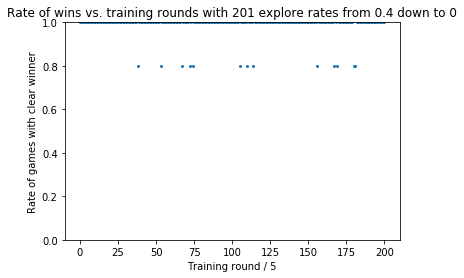

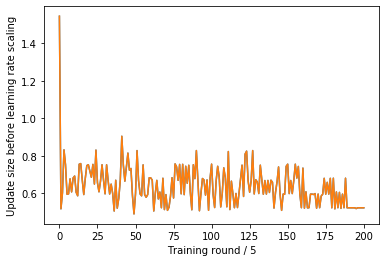

In [10]:
p144_200_4, p244_200_4 = makedynamic(5, 201, 0.5, rows=4, cols=4, movingalpha = True, stratnames='grav44final', 
                                         aggover=5, numfilters=4, filtersize=3, selftrain=True)

In [11]:
p144_200_4, p244_200_4 = makedynamic(5, 201, 0.5, rows=4, cols=4, movingalpha = True, stratnames='grav44final', 
                                         aggover=5, numfilters=4, filtersize=3, selftrain=True, squareloss=True)

0.0025



  0%|                                                                                          | 0/201 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  0%|▍                                                                               | 1/201 [00:46<2:35:48, 46.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  1%|▊                                                                               | 2/201 [01:16<2:18:29, 41.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  1%|█▏                                                                              | 3/201 [01:59<2:18:48, 42.07s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  2%|█▌                                                                              | 4/201 [02:38<2:15:25, 41.24s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  2%|█▉                                                                              | 5/201 [03:17<2:11:42, 40.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  3%|██▍                                                                             | 6/201 [04:09<2:22:50, 43.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  3%|██▊                                                                             | 7/201 [05:01<2:29:27, 46.22s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  4%|███▏                                                                            | 8/201 [05:49<2:30:49, 46.89s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  4%|███▌                                                                            | 9/201 [06:45<2:39:01, 49.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  5%|███▉                                                                           | 10/201 [07:22<2:25:25, 45.68s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  5%|████▎                                                                          | 11/201 [08:16<2:32:38, 48.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  6%|████▋                                                                          | 12/201 [09:05<2:32:41, 48.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  6%|█████                                                                          | 13/201 [09:55<2:33:57, 49.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  7%|█████▌                                                                         | 14/201 [10:39<2:28:14, 47.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  7%|█████▉                                                                         | 15/201 [11:13<2:14:12, 43.29s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  8%|██████▎                                                                        | 16/201 [11:53<2:10:15, 42.25s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  8%|██████▋                                                                        | 17/201 [12:25<2:00:47, 39.39s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  9%|███████                                                                        | 18/201 [13:26<2:19:40, 45.80s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



  9%|███████▍                                                                       | 19/201 [14:13<2:20:28, 46.31s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 10%|███████▊                                                                       | 20/201 [15:04<2:23:51, 47.69s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 10%|████████▎                                                                      | 21/201 [15:44<2:15:49, 45.27s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 11%|████████▋                                                                      | 22/201 [16:21<2:07:44, 42.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 11%|█████████                                                                      | 23/201 [17:07<2:09:45, 43.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 12%|█████████▍                                                                     | 24/201 [18:05<2:21:21, 47.92s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 12%|█████████▊                                                                     | 25/201 [18:44<2:13:22, 45.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 13%|██████████▏                                                                    | 26/201 [19:29<2:11:30, 45.09s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 13%|██████████▌                                                                    | 27/201 [20:20<2:16:05, 46.93s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 14%|███████████                                                                    | 28/201 [21:21<2:27:46, 51.25s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 14%|███████████▍                                                                   | 29/201 [21:53<2:10:25, 45.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 15%|███████████▊                                                                   | 30/201 [22:37<2:08:25, 45.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 15%|████████████▏                                                                  | 31/201 [23:27<2:11:48, 46.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 16%|████████████▌                                                                  | 32/201 [24:18<2:14:28, 47.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 16%|████████████▉                                                                  | 33/201 [24:54<2:04:15, 44.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 17%|█████████████▎                                                                 | 34/201 [25:46<2:09:42, 46.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 17%|█████████████▊                                                                 | 35/201 [26:42<2:16:48, 49.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 18%|██████████████▏                                                                | 36/201 [27:30<2:14:53, 49.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 18%|██████████████▌                                                                | 37/201 [28:09<2:05:23, 45.87s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 19%|██████████████▉                                                                | 38/201 [28:54<2:03:41, 45.53s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 19%|███████████████▎                                                               | 39/201 [29:31<1:56:03, 42.99s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 20%|███████████████▋                                                               | 40/201 [30:21<2:01:41, 45.35s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 20%|████████████████                                                               | 41/201 [31:06<2:00:30, 45.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 21%|████████████████▌                                                              | 42/201 [31:58<2:04:51, 47.11s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 21%|████████████████▉                                                              | 43/201 [32:34<1:55:29, 43.86s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 22%|█████████████████▎                                                             | 44/201 [33:16<1:52:49, 43.12s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 22%|█████████████████▋                                                             | 45/201 [34:14<2:04:24, 47.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 23%|██████████████████                                                             | 46/201 [34:56<1:58:23, 45.83s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 23%|██████████████████▍                                                            | 47/201 [35:51<2:04:52, 48.65s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 24%|██████████████████▊                                                            | 48/201 [36:24<1:52:05, 43.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 24%|███████████████████▎                                                           | 49/201 [37:20<2:00:35, 47.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 25%|███████████████████▋                                                           | 50/201 [38:09<2:00:57, 48.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 25%|████████████████████                                                           | 51/201 [38:59<2:01:39, 48.66s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 26%|████████████████████▍                                                          | 52/201 [39:42<1:56:13, 46.81s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 26%|████████████████████▊                                                          | 53/201 [40:35<2:00:15, 48.75s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 27%|█████████████████████▏                                                         | 54/201 [41:35<2:07:58, 52.24s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 27%|█████████████████████▌                                                         | 55/201 [42:33<2:11:21, 53.98s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 28%|██████████████████████                                                         | 56/201 [43:24<2:08:27, 53.15s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 28%|██████████████████████▍                                                        | 57/201 [44:09<2:01:24, 50.59s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 29%|██████████████████████▊                                                        | 58/201 [44:47<1:51:47, 46.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 29%|███████████████████████▏                                                       | 59/201 [45:27<1:46:05, 44.83s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 30%|███████████████████████▌                                                       | 60/201 [46:03<1:38:34, 41.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 30%|███████████████████████▉                                                       | 61/201 [46:45<1:37:54, 41.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 31%|████████████████████████▎                                                      | 62/201 [47:30<1:39:26, 42.93s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 31%|████████████████████████▊                                                      | 63/201 [48:01<1:30:25, 39.32s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 32%|█████████████████████████▏                                                     | 64/201 [48:41<1:30:09, 39.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 32%|█████████████████████████▌                                                     | 65/201 [49:37<1:41:02, 44.58s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 33%|█████████████████████████▉                                                     | 66/201 [50:37<1:50:46, 49.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 33%|██████████████████████████▎                                                    | 67/201 [51:21<1:46:04, 47.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 34%|██████████████████████████▋                                                    | 68/201 [52:10<1:46:29, 48.04s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 34%|███████████████████████████                                                    | 69/201 [52:52<1:42:02, 46.38s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 35%|███████████████████████████▌                                                   | 70/201 [53:44<1:44:31, 47.87s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 35%|███████████████████████████▉                                                   | 71/201 [54:28<1:41:23, 46.80s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 36%|████████████████████████████▎                                                  | 72/201 [55:13<1:39:39, 46.36s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 36%|████████████████████████████▋                                                  | 73/201 [55:53<1:34:26, 44.27s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 37%|█████████████████████████████                                                  | 74/201 [56:46<1:39:30, 47.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 37%|█████████████████████████████▍                                                 | 75/201 [57:25<1:33:17, 44.42s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 38%|█████████████████████████████▊                                                 | 76/201 [58:01<1:27:27, 41.98s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 38%|██████████████████████████████▎                                                | 77/201 [58:36<1:22:18, 39.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 39%|██████████████████████████████▋                                                | 78/201 [59:09<1:17:50, 37.97s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 39%|███████████████████████████████                                                | 79/201 [59:56<1:22:34, 40.61s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 40%|██████████████████████████████▋                                              | 80/201 [1:01:00<1:35:47, 47.50s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 40%|███████████████████████████████                                              | 81/201 [1:01:50<1:36:54, 48.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 41%|███████████████████████████████▍                                             | 82/201 [1:02:47<1:41:10, 51.02s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 41%|███████████████████████████████▊                                             | 83/201 [1:03:41<1:42:04, 51.90s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 42%|████████████████████████████████▏                                            | 84/201 [1:04:43<1:46:54, 54.82s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 42%|████████████████████████████████▌                                            | 85/201 [1:05:21<1:36:22, 49.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 43%|████████████████████████████████▉                                            | 86/201 [1:06:02<1:30:06, 47.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 43%|█████████████████████████████████▎                                           | 87/201 [1:06:47<1:28:15, 46.45s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 44%|█████████████████████████████████▋                                           | 88/201 [1:07:37<1:29:29, 47.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 44%|██████████████████████████████████                                           | 89/201 [1:08:29<1:31:34, 49.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 45%|██████████████████████████████████▍                                          | 90/201 [1:09:13<1:28:00, 47.57s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 45%|██████████████████████████████████▊                                          | 91/201 [1:10:01<1:26:57, 47.43s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 46%|███████████████████████████████████▏                                         | 92/201 [1:10:38<1:20:52, 44.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 46%|███████████████████████████████████▋                                         | 93/201 [1:11:17<1:17:00, 42.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 47%|████████████████████████████████████                                         | 94/201 [1:12:09<1:21:21, 45.62s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 47%|████████████████████████████████████▍                                        | 95/201 [1:12:49<1:17:43, 44.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 48%|████████████████████████████████████▊                                        | 96/201 [1:13:39<1:19:39, 45.52s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 48%|█████████████████████████████████████▏                                       | 97/201 [1:14:19<1:16:15, 44.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 49%|█████████████████████████████████████▌                                       | 98/201 [1:15:00<1:13:54, 43.05s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 49%|█████████████████████████████████████▉                                       | 99/201 [1:15:45<1:14:31, 43.83s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 50%|█████████████████████████████████████▊                                      | 100/201 [1:16:27<1:12:45, 43.22s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 50%|██████████████████████████████████████▏                                     | 101/201 [1:17:20<1:16:57, 46.18s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 51%|██████████████████████████████████████▌                                     | 102/201 [1:18:05<1:15:21, 45.68s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 51%|██████████████████████████████████████▉                                     | 103/201 [1:18:38<1:08:38, 42.03s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 52%|███████████████████████████████████████▎                                    | 104/201 [1:19:22<1:08:33, 42.41s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 52%|███████████████████████████████████████▋                                    | 105/201 [1:19:57<1:04:19, 40.20s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 53%|████████████████████████████████████████                                    | 106/201 [1:20:39<1:04:41, 40.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 53%|████████████████████████████████████████▍                                   | 107/201 [1:21:32<1:09:39, 44.46s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 54%|████████████████████████████████████████▊                                   | 108/201 [1:22:28<1:14:08, 47.83s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 54%|█████████████████████████████████████████▏                                  | 109/201 [1:23:17<1:13:53, 48.19s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 55%|█████████████████████████████████████████▌                                  | 110/201 [1:24:04<1:12:30, 47.81s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 55%|█████████████████████████████████████████▉                                  | 111/201 [1:24:47<1:09:47, 46.53s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 56%|██████████████████████████████████████████▎                                 | 112/201 [1:25:27<1:06:13, 44.64s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 56%|██████████████████████████████████████████▋                                 | 113/201 [1:26:01<1:00:50, 41.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 57%|███████████████████████████████████████████                                 | 114/201 [1:26:51<1:03:42, 43.93s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 57%|███████████████████████████████████████████▍                                | 115/201 [1:27:44<1:06:47, 46.60s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 58%|███████████████████████████████████████████▊                                | 116/201 [1:28:22<1:02:19, 44.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 58%|█████████████████████████████████████████████▍                                | 117/201 [1:29:00<59:08, 42.25s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 59%|█████████████████████████████████████████████▊                                | 118/201 [1:29:39<56:54, 41.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 59%|██████████████████████████████████████████████▏                               | 119/201 [1:30:27<59:09, 43.29s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 60%|█████████████████████████████████████████████▎                              | 120/201 [1:31:26<1:04:49, 48.02s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 60%|█████████████████████████████████████████████▊                              | 121/201 [1:32:18<1:05:30, 49.13s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 61%|███████████████████████████████████████████████▎                              | 122/201 [1:32:52<58:39, 44.55s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 61%|███████████████████████████████████████████████▋                              | 123/201 [1:33:41<59:38, 45.88s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 62%|████████████████████████████████████████████████                              | 124/201 [1:34:22<57:13, 44.59s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 62%|███████████████████████████████████████████████▎                            | 125/201 [1:35:18<1:00:52, 48.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 63%|████████████████████████████████████████████████▉                             | 126/201 [1:36:00<57:42, 46.16s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 63%|█████████████████████████████████████████████████▎                            | 127/201 [1:36:38<53:56, 43.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 64%|█████████████████████████████████████████████████▋                            | 128/201 [1:37:25<54:33, 44.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 64%|██████████████████████████████████████████████████                            | 129/201 [1:38:11<54:00, 45.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 65%|██████████████████████████████████████████████████▍                           | 130/201 [1:39:02<55:33, 46.95s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 65%|██████████████████████████████████████████████████▊                           | 131/201 [1:39:57<57:27, 49.25s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 66%|███████████████████████████████████████████████████▏                          | 132/201 [1:40:32<51:44, 45.00s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 66%|███████████████████████████████████████████████████▌                          | 133/201 [1:41:15<50:23, 44.47s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 67%|████████████████████████████████████████████████████                          | 134/201 [1:41:51<46:34, 41.71s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 67%|████████████████████████████████████████████████████▍                         | 135/201 [1:42:33<46:14, 42.04s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 68%|████████████████████████████████████████████████████▊                         | 136/201 [1:43:14<45:09, 41.68s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 68%|█████████████████████████████████████████████████████▏                        | 137/201 [1:44:04<47:10, 44.23s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 69%|█████████████████████████████████████████████████████▌                        | 138/201 [1:44:48<46:18, 44.10s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 69%|█████████████████████████████████████████████████████▉                        | 139/201 [1:45:45<49:34, 47.97s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 70%|██████████████████████████████████████████████████████▎                       | 140/201 [1:46:38<50:07, 49.30s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 70%|██████████████████████████████████████████████████████▋                       | 141/201 [1:47:19<46:56, 46.94s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 71%|███████████████████████████████████████████████████████                       | 142/201 [1:47:55<42:55, 43.65s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 71%|███████████████████████████████████████████████████████▍                      | 143/201 [1:48:40<42:41, 44.17s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 72%|███████████████████████████████████████████████████████▉                      | 144/201 [1:49:16<39:39, 41.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 72%|████████████████████████████████████████████████████████▎                     | 145/201 [1:50:02<39:56, 42.80s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 73%|████████████████████████████████████████████████████████▋                     | 146/201 [1:50:47<39:57, 43.59s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 73%|█████████████████████████████████████████████████████████                     | 147/201 [1:51:39<41:27, 46.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 74%|█████████████████████████████████████████████████████████▍                    | 148/201 [1:52:24<40:20, 45.67s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 74%|█████████████████████████████████████████████████████████▊                    | 149/201 [1:53:10<39:40, 45.78s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 75%|██████████████████████████████████████████████████████████▏                   | 150/201 [1:53:49<37:09, 43.72s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 75%|██████████████████████████████████████████████████████████▌                   | 151/201 [1:54:22<33:42, 40.46s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 76%|██████████████████████████████████████████████████████████▉                   | 152/201 [1:55:28<39:26, 48.30s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 76%|███████████████████████████████████████████████████████████▎                  | 153/201 [1:56:15<38:24, 48.01s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 77%|███████████████████████████████████████████████████████████▊                  | 154/201 [1:57:09<38:49, 49.57s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 77%|████████████████████████████████████████████████████████████▏                 | 155/201 [1:57:59<38:16, 49.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 78%|████████████████████████████████████████████████████████████▌                 | 156/201 [1:58:46<36:40, 48.91s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 78%|████████████████████████████████████████████████████████████▉                 | 157/201 [1:59:25<33:37, 45.85s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 79%|█████████████████████████████████████████████████████████████▎                | 158/201 [2:00:23<35:27, 49.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 79%|█████████████████████████████████████████████████████████████▋                | 159/201 [2:01:19<36:02, 51.49s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 80%|██████████████████████████████████████████████████████████████                | 160/201 [2:02:01<33:18, 48.74s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 80%|██████████████████████████████████████████████████████████████▍               | 161/201 [2:02:37<29:51, 44.79s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 81%|██████████████████████████████████████████████████████████████▊               | 162/201 [2:03:32<31:04, 47.81s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 81%|███████████████████████████████████████████████████████████████▎              | 163/201 [2:04:26<31:32, 49.81s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 82%|███████████████████████████████████████████████████████████████▋              | 164/201 [2:05:29<33:09, 53.76s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 82%|████████████████████████████████████████████████████████████████              | 165/201 [2:06:10<30:02, 50.06s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 83%|████████████████████████████████████████████████████████████████▍             | 166/201 [2:06:57<28:39, 49.14s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 83%|████████████████████████████████████████████████████████████████▊             | 167/201 [2:07:48<28:02, 49.48s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 84%|█████████████████████████████████████████████████████████████████▏            | 168/201 [2:08:48<28:59, 52.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 84%|█████████████████████████████████████████████████████████████████▌            | 169/201 [2:09:28<26:05, 48.94s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 85%|█████████████████████████████████████████████████████████████████▉            | 170/201 [2:10:23<26:11, 50.70s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 85%|██████████████████████████████████████████████████████████████████▎           | 171/201 [2:11:21<26:30, 53.02s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 86%|██████████████████████████████████████████████████████████████████▋           | 172/201 [2:12:12<25:17, 52.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 86%|███████████████████████████████████████████████████████████████████▏          | 173/201 [2:12:55<23:07, 49.57s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 87%|███████████████████████████████████████████████████████████████████▌          | 174/201 [2:13:49<22:49, 50.73s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 87%|███████████████████████████████████████████████████████████████████▉          | 175/201 [2:14:51<23:32, 54.33s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 88%|████████████████████████████████████████████████████████████████████▎         | 176/201 [2:15:31<20:49, 49.98s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 88%|████████████████████████████████████████████████████████████████████▋         | 177/201 [2:16:03<17:45, 44.40s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 89%|█████████████████████████████████████████████████████████████████████         | 178/201 [2:16:40<16:16, 42.44s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 89%|█████████████████████████████████████████████████████████████████████▍        | 179/201 [2:17:29<16:11, 44.18s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 90%|█████████████████████████████████████████████████████████████████████▊        | 180/201 [2:18:09<15:02, 42.96s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 90%|██████████████████████████████████████████████████████████████████████▏       | 181/201 [2:18:54<14:30, 43.54s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 91%|██████████████████████████████████████████████████████████████████████▋       | 182/201 [2:19:40<14:00, 44.24s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 91%|███████████████████████████████████████████████████████████████████████       | 183/201 [2:20:18<12:46, 42.57s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 92%|███████████████████████████████████████████████████████████████████████▍      | 184/201 [2:21:11<12:54, 45.56s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 92%|███████████████████████████████████████████████████████████████████████▊      | 185/201 [2:21:51<11:41, 43.84s/it]

INFO:tensorflow:Assets written to: models/grav44final1\assets
INFO:tensorflow:Assets written to: models/grav44final2\assets



 93%|████████████████████████████████████████████████████████████████████████▏     | 186/201 [2:22:36<11:03, 44.26s/it]

KeyboardInterrupt: 